In [1]:
import io
import subprocess
import os
import glob

import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA
import pickle
import re
import math
import plotnine as pn
import seaborn as sns
import glob
import subprocess
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from numpy import log
from collections import defaultdict,Counter
import re
import statsmodels
import warnings
import json

from pathlib import Path
from midas import m
from datetime import datetime, date
import altair as alt

# !pip install statannotations==0.4.0
# #!pip uninstall statannotations --yes
# from statannotations.Annotator import Annotator

warnings.filterwarnings("ignore")
pd.options.display.max_rows = None
pd.options.display.max_columns=None
pd.options.display.max_colwidth=None
work_dir="/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/Treatement_Effect_RUOMRD_CSO_call_05052024"

# Data preocessing

In [2]:
# File name list to handle corner case of data readin
header1_list = ["20230627_JNJ_SQ01_17Samples_RevealReport.csv"]
header0_list = [
 '20230928_AstraZeneca_SOW164_46Samples_InfinityReport.csv',
 '20231106_AstraZeneca_SOW164_46Samples_InfinityReport.csv',
 '20231130_BoundlessBio_SOW02_10Samples_InfinityReport.csv',
 '20231207_AstraZeneca_SOW170_188Samples_InfinityReport.csv',
 '20231225_BristolMyersSquibb_SOW29_14Samples_InfinityReport.csv',
 '20231227_CL003_IST01_170Samples_InfinityReport.csv',
 '20240111_AstraZeneca_SOW174_35Samples_InfinityReport.csv',
 '20240116_AstraZeneca_SOW182_40Samples_InfinityReport.csv',
 '20240126_NCC_IST14_35Samples_InfinityReport.csv',
 '20240401_Cyclacel_SOW01_12Samples_InfinityReport.csv',
 '20240422_AstraZeneca_SOW176Monitoring_998Samples_InfinityReport.csv',
 '20221024_SMC_IST_01_198samples_InfinityReport.csv']


# Define the folder paths
folders = [
    "/ghsfa/projects/pharma/datawarehouse/Infinity",
    "/ghsfa/projects/pharma/datawarehouse/infinity",
    "/ghsfa/projects/pharma/datawarehouse/data/infinity_ist_report_warehouse",
    "/ghsfa/projects/pharma/datawarehouse/data/infinity_mrd_report_warehouse",
    "/ghsfa/projects/pharma/datawarehouse/data/infinity_report_warehouse"
]

# List to store the dataframes for final merge
dfs = []

# Iterate over each folder
for folder in folders:
    # List all csv files in the folder
    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)
        # Check if the file is a CSV
        if file.endswith('.csv'):
            try:
                # Determine the header row based on the presence of "MRD" in the filename
                # Some corner cases
                if file in header0_list:
                    df = pd.read_csv(file_path, header=0)
                elif file in header1_list:
                    df = pd.read_csv(file_path, header=1)
                elif "MRD" in file.upper():
                    df = pd.read_csv(file_path, header=0)
                elif "Reveal" in file:
                    df = pd.read_csv(file_path, header=0)
                else:
                    df = pd.read_csv(file_path, header=1)

                # Select specified columns, handling cases where some columns might not exist
                columns = ['GHRequestID', 'GHSampleID', 'Patient_ID', 'Visit_name', 
                           'Sample_status', 'Sample_comment', 'cfDNA_ng', 'Plasma_ml_input', 'Cancertype']
                df_sub = df.loc[:, df.columns.isin(columns)].copy()

                # Drop duplicates based on 'GHSampleID'
                df_sub_dedup = df_sub.drop_duplicates(subset=["GHSampleID"])

                # Add a column for the CSV file name
                df_sub_dedup['csv_file_name'] = file

                # Append the processed dataframe to the list
                dfs.append(df_sub_dedup)
            except pd.errors.ParserError:
                print(f"Error reading file: {file_path} - possibly incorrect header.")
            except Exception as e:
                print(f"An unexpected error occurred with file: {file_path} - {str(e)}")

# Merge all dataframes into a final DataFrame
df_merged = pd.concat(dfs, ignore_index=True)



Error reading file: /ghsfa/projects/pharma/datawarehouse/infinity/20231102_RepareTherapeutics_SOW01_4_22_infinityReport.csv - possibly incorrect header.


In [3]:
# Filter out rows where GHSampleID is NaN
nan_sample_ids = df_merged[df_merged['GHSampleID'].isna()]

# Group by csv_file_name and take the first row from each group
unique_csv_with_nan = nan_sample_ids.groupby('csv_file_name').first().reset_index()
unique_csv_with_nan

csv_file_name GHRequestID  \
0         20230607_AstraZenaca_SOW01_2Samples_infinityReport.csv    A0730247   
1      20231026_RepareTherapeutics_SOW01_4_23_infinityReport.csv    A0800783   
2              20231106_GHIResearch_SOW10_2_3_infinityReport.csv    A0776833   
3  20231211_GHIResearch_E2E01_Batch1_1Samples_InfinityReport.csv    A0542330   

  GHSampleID      Patient_ID Visit_name Sample_status Sample_comment  \
0       None          3005.0     SCREEN      Released           None   
1       None      10010348.0  Screening       SUCCESS           None   
2       None  S3_CGP_E2E_074       None       SUCCESS           None   
3       None            None       None       SUCCESS           None   

   cfDNA_ng  Plasma_ml_input                 Cancertype  
0       NaN              NaN                       None  
1       NaN              NaN                       None  
2       NaN              NaN  Colorectal adenocarcinoma  
3     60.32              NaN                       None

In [2]:
# Readin samples 
df_merged_1 = df_merged.copy()
print("Total size of this RUO summary data is " + str(df_merged_1.shape[0]) + "\n") 
print("Total unique sample size of this RUO/IST summary data is " + str(df_merged_1.GHSampleID.nunique()) + "\n")
print("Total NaN in cancer type of this RUO/IST  summary data is " + str(df_merged_1.Cancertype.isnull().sum()) + "\n")

# Drop duplicates 
df_merged_dedup = df_merged_1.drop_duplicates(subset=["GHSampleID"])
print("Total size of this RUO/IST summary data is " + str(df_merged_dedup.shape[0]) + "\n") 

# Regular expression to extract 'Account' and 'SOW_num'
pattern = r'_(?P<Account>[^_]+)_SOW(?P<SOW_num>\d+)'

# Using str.extract() to create new columns in the DataFrame
df_merged_dedup[['Account', 'SOW_num']] = df_merged_dedup['csv_file_name'].str.extract(pattern)

df_merged_dedup.head()

NameError: name 'df_merged' is not defined

In [4]:
# Merge cancer type information from /ghsfa/projects/pharma/datawarehouse/pdw/raw/latest/fact_accessions.tsv
df_cancer_type_fact = pd.read_table("/ghsfa/projects/pharma/datawarehouse/pdw/raw/latest/fact_accessions.tsv")
df_cancer_type_fact_1 = df_cancer_type_fact.copy()

#merge the "runid" information with the 217 COSMOS data
df_cancer_type_fact_1.rename(columns={'accn_id': 'GHRequestID'}, inplace=True)
df_merged_1 = df_merged_dedup.merge(df_cancer_type_fact_1[["GHRequestID", "cancer_category", "cancerother", "cancerstage", "cancertype"]], on = "GHRequestID", how = "left")
print("Total sample size of the RUO/IST summary is " + str(df_merged_1.shape[0]) + "\n") 
df_merged_1.head()

# # Save the dataframe
# df_merged_1.to_csv(f"{work_dir}/df_merged_warehouse.csv", index = False)

NameError: name 'df_merged_dedup' is not defined

In [ ]:
# Readin samples that pulled by Kyle
df_ruo_kyle = pd.read_csv(f"{work_dir}/all_ruo_mbcaller_tfv2_input.csv", header=0)

print("Total size of this RUO summary data is " + str(df_ruo_kyle.shape[0]) + "\n") 
print("Total unique sample size of this RUO summary data is " + str(df_ruo_kyle.GHSampleID.nunique()) + "\n")
print("Total NaN in cancer type of this RUO summary data is " + str(df_ruo_kyle.cancer_type.isnull().sum()) + "\n")

# Drop duplicates 
df_ruo_kyle_dedup = df_ruo_kyle.drop_duplicates(subset=["GHSampleID"])
print("Total size of this RUO summary data is " + str(df_ruo_kyle_dedup.shape[0]) + "\n") 
df_ruo_kyle_dedup.head()

Total size of this RUO summary data is 23683

Total unique sample size of this RUO summary data is 23683

Total NaN in cancer type of this RUO summary data is 23286

Total size of this RUO summary data is 23683



runid run_sample_id sample_index  gender  \
0  230324_A01902_0106_AHVHYFDSX5    A023820110   AATCAGCAGG  Female   
1  230908_A01537_0336_BHCFJ5DSX7    A023999810   CGTAGCGCTG    Male   
2  230324_A01902_0106_AHVHYFDSX5    A024000210   GATTCGGCCC    Male   
3  230324_A01902_0106_AHVHYFDSX5    A024063710   CTGGTACTGG  Female   
4  230324_A01902_0106_AHVHYFDSX5    A024090010   GTGAAGAACG    Male   

  sample_type             timestamp        panel  control_lot  \
0    Research  2023-03-27T04:34:49Z  Sirius_v1.0          NaN   
1    Research  2023-09-11T02:11:52Z  Sirius_v1.0          NaN   
2    Research  2023-03-27T04:34:49Z  Sirius_v1.0          NaN   
3    Research  2023-03-27T04:34:49Z  Sirius_v1.0          NaN   
4    Research  2023-03-27T04:34:49Z  Sirius_v1.0          NaN   

        bip_version  git_version  run_mode       product    project  \
0  Sirius-1.0.0-RLS          NaN       NaN  Guardant 360  COS_01_V3   
1  Sirius-1.1.1-RLS          NaN       NaN  Guardant 360  COS_01_V3   
2  Sirius-1.0.0-RLS          NaN       NaN  Guardant 360  COS_01_V3   
3  Sirius-1.0.0-RLS          NaN       NaN  Guardant 360  COS_01_V3   
4  Sirius-1.0.0-RLS          NaN       NaN  Guardant 360  COS_01_V3   

  cancer_type  patient_age         parameter_set  lunar_caller  comment  \
0         NaN          NaN           Sirius_v1.0           NaN      NaN   
1       Other          NaN  Sirius_LDT_Soft_v2.0           NaN      NaN   
2         NaN          NaN           Sirius_v1.0           NaN      NaN   
3         NaN          NaN           Sirius_v1.0           NaN      NaN   
4         NaN          NaN           Sirius_v1.0           NaN      NaN   

  provided_tumor_type request_id use_case qc_status  \
0                 NaN   A0238201      NaN      PASS   
1                 NaN   A0239998      cgp      PASS   
2                 NaN   A0240002      NaN      PASS   
3                 NaN   A0240637      NaN      PASS   
4                 NaN   A0240900      NaN      PASS   

                                                                                            fc_dir  \
0     /ghsfa/projects/omni_v2/flowcells/230324_A01902_0106_AHVHYFDSX5_PS3R212_AP2.Sirius-1.0.0-RLS   
1  /ghsfa/projects/omni_v2/flowcells/230908_A01537_0336_BHCFJ5DSX7_PS3C132LDT_AP3.Sirius-1.1.1-RLS   
2     /ghsfa/projects/omni_v2/flowcells/230324_A01902_0106_AHVHYFDSX5_PS3R212_AP2.Sirius-1.0.0-RLS   
3     /ghsfa/projects/omni_v2/flowcells/230324_A01902_0106_AHVHYFDSX5_PS3R212_AP2.Sirius-1.0.0-RLS   
4     /ghsfa/projects/omni_v2/flowcells/230324_A01902_0106_AHVHYFDSX5_PS3R212_AP2.Sirius-1.0.0-RLS   

    sample_id  GHSampleID  \
0  A023820110  A023820110   
1  A023999810  A023999810   
2  A024000210  A024000210   
3  A024063710  A024063710   
4  A024090010  A024090010   

                                                                                                  sample_path  \
0     /ghsfa/projects/omni_v2/flowcells/230324_A01902_0106_AHVHYFDSX5_PS3R212_AP2.Sirius-1.0.0-RLS/A023820110   
1  /ghsfa/projects/omni_v2/flowcells/230908_A01537_0336_BHCFJ5DSX7_PS3C132LDT_AP3.Sirius-1.1.1-RLS/A023999810   
2     /ghsfa/projects/omni_v2/flowcells/230324_A01902_0106_AHVHYFDSX5_PS3R212_AP2.Sirius-1.0.0-RLS/A024000210   
3     /ghsfa/projects/omni_v2/flowcells/230324_A01902_0106_AHVHYFDSX5_PS3R212_AP2.Sirius-1.0.0-RLS/A024063710   
4     /ghsfa/projects/omni_v2/flowcells/230324_A01902_0106_AHVHYFDSX5_PS3R212_AP2.Sirius-1.0.0-RLS/A024090010   

                                                                                                                                        mbd_path  \
0     /ghsfa/projects/omni_v2/flowcells/230324_A01902_0106_AHVHYFDSX5_PS3R212_AP2.Sirius-1.0.0-RLS/A023820110/A023820110.mbd_hyper_molecules.tsv   
1  /ghsfa/projects/omni_v2/flowcells/230908_A01537_0336_BHCFJ5DSX7_PS3C132LDT_AP3.Sirius-1.1.1-RLS/A023999810/A023999810.mbd_hyper_molecules.tsv   
2     /ghsfa/projects/omni_v2/flowcells/230324_A01902_0106_AHVHYFDSX5_PS3R212_AP2.Sirius-

In [ ]:
# Merge the runid, fc_dir and other information from Kyle's pull
df_complete_1 = df_merged_1.merge(df_ruo_kyle_dedup, on="GHSampleID", how="left")
df_complete_1.head()

GHRequestID GHSampleID Patient_ID     Visit_name Sample_status  \
0    A0800783  B00459142   10010348      Screening       SUCCESS   
1    A0800784  B00459144   10040388  Cycle 1 Day 1       SUCCESS   
2    A0800785  B00459143   10040457  Cycle 1 Day 1       SUCCESS   
3    A0800786  B00459146   10040474  Cycle 1 Day 1       SUCCESS   
4    A0800787  B00459145   10050383  Cycle 1 Day 1       SUCCESS   

                                           Sample_comment  cfDNA_ng  \
0                                                     NaN     85.28   
1                                                     NaN    421.72   
2  Methylation Suppression Warning; Low Diversity Warning      0.31   
3                                                     NaN     23.61   
4                                                     NaN    208.00   

   Plasma_ml_input Cancertype  \
0              4.0        NaN   
1              2.5        NaN   
2              1.5        NaN   
3              3.0        NaN   
4              3.5        NaN   

                                                           csv_file_name  \
0  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   
1  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   
2  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   
3  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   
4  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   

              Account SOW_num cancer_category cancerother cancerstage  \
0  RepareTherapeutics      01           Other         NaN         NaN   
1  RepareTherapeutics      01           Other         NaN         NaN   
2  RepareTherapeutics      01           Other         NaN         NaN   
3  RepareTherapeutics      01           Other         NaN         NaN   
4  RepareTherapeutics      01           Other         NaN         NaN   

  cancertype                          runid run_sample_id sample_index  \
0        NaN  230810_A01902_0186_AH5VV7DSX7     B00459142   CAGGCGTTGC   
1        NaN  230810_A01902_0186_AH5VV7DSX7     B00459144   GCAAAGAGCT   
2        NaN                            NaN           NaN          NaN   
3        NaN  230810_A01902_0186_AH5VV7DSX7     B00459146   TATTAACATG   
4        NaN  230810_A01902_0186_AH5VV7DSX7     B00459145   ATTTAAGGAC   

    gender sample_type             timestamp        panel  control_lot  \
0  Unknown    Research  2023-08-13T00:37:40Z  Sirius_v1.0          NaN   
1  Unknown    Research  2023-08-13T00:37:40Z  Sirius_v1.0          NaN   
2      NaN         NaN                   NaN          NaN          NaN   
3  Unknown    Research  2023-08-13T00:37:40Z  Sirius_v1.0          NaN   
4  Unknown    Research  2023-08-13T00:37:40Z  Sirius_v1.0          NaN   

        bip_version  git_version  run_mode       product    project  \
0  Sirius-1.1.0-RLS          NaN       NaN  Guardant 360  REP_SOW01   
1  Sirius-1.1.0-RLS          NaN       NaN  Guardant 360  REP_SOW01   
2               NaN          NaN       NaN           NaN        NaN   
3  Sirius-1.1.0-RLS          NaN       NaN  Guardant 360  REP_SOW01   
4  Sirius-1.1.0-RLS          NaN       NaN  Guardant 360  REP_SOW01   

  cancer_type  patient_age         parameter_set  lunar_caller  comment  \
0         NaN          NaN  Sirius_LDT_Soft_v2.0           NaN      NaN   
1         NaN          NaN  Sirius_LDT_Soft_v2.0           NaN      NaN   
2         NaN          NaN                   NaN           NaN      NaN   
3         NaN          NaN  Sirius_LDT_Soft_v2.0           NaN      NaN   
4         NaN          NaN  Sirius_LDT_Soft_v2.0           NaN      NaN   

  provided_tumor_type request_id use_case qc_status  \
0                 NaN   A0800783      cgp      PASS   
1                 NaN   A0800784      cgp      PASS   
2                 NaN        NaN      NaN       NaN   
3                 NaN   A0800786      cgp      PASS   
4                 NaN   A080

In [8]:
# Check the samples with missing runid
df_complete_nan = df_complete_1[df_complete_1["runid"].isna()]
df_complete_nan.shape

(5776, 43)

In [96]:
runid_nan_list = df_complete_nan.GHSampleID.tolist()
len(runid_nan_list)
# runid_nan_list.to_list(f"{work_dir}/runid_nan_list")

5776

In [99]:
# Save the sample id that missed runid for SQL
runid_nan_list = df_complete_nan['GHSampleID'].tolist()

# Specify the file path (you can change the directory if needed)
file_path = f"{work_dir}/runid_nan_list.json"  # Saves in the current working directory

# Writing the list to a file
with open(file_path, 'w') as file:
    json.dump(runid_nan_list, file)


In [102]:
# Specify the file path
file_path = f"{work_dir}/runid_nan_list.json"  # Saves in the current working directory

# Reading the list from the file
with open(file_path, 'r') as file:
    runid_nan_list_loaded = json.load(file)

# Now runid_nan_list_loaded is a list containing the data
len(runid_nan_list_loaded)

5776

In [ ]:
# This is the SQL and make sure remove any nan values
SELECT *
FROM gh_sample 
WHERE run_sample_id in ('B00459143', 'B00459152', 'B00651690', 'B00651686', 'B00651688', 'B00651668', 'B00651683', 'B00651691', 'B00652400', 'B00652373', 'B00652380', 'B00652382', 'B00652376', 'B00652378', 'B00652386', 'B00652388', 'B00652383', 'B00652384', 'B00652389', 'B00652390', 'B00652391', 'B00652394', 'B00652395', 'B00652392', 'B00652393', 'B00652398', 'B00652399', 'B00652396', 'B00652397', 'B00652374', 'B00652371', 'B00652372', 'B00652379', 'B00652381', 'B00652375', 'B00652377', 'B00652385', 'B00652387', 'B00652412', 'B00652421', 'B00652423', 'B00652417', 'B00652419', 'B00652428', 'B00652430', 'B00652425', 'B00652426', 'B00652432', 'B00652403', 'B00652406', 'B00652407', 'B00652404', 'B00652405', 'B00652410', 'B00652411', 'B00652408', 'B00652409', 'B00652413', 'B00652414', 'B00652415', 'B00652420', 'B00652422', 'B00652416', 'B00652418', 'B00652427', 'B00652429', 'B00652424', 'B00652453', 'B00652441', 'B00652443', 'B00652437', 'B00652439', 'B00652448', 'B00652450', 'B00652755', 'B00652446', 'B00652451', 'B00652452', 'B00652457', 'B00652458', 'B00652455', 'B00652456', 'B00652461', 'B00652462', 'B00652459', 'B00652460', 'B00652463', 'B00652434', 'B00652435', 'B00652440', 'B00652442', 'B00652436', 'B00652438', 'B00652447', 'B00652449', 'B00652444', 'B00652445', 'B00652454', 'B00652655', 'B00652657', 'B00652664', 'B00652666', 'B00652661', 'B00652663', 'B00652669', 'B00652670', 'B00652667', 'B00652645', 'B00652646', 'B00652643', 'B00652644', 'B00652649', 'B00652650', 'B00652647', 'B00652648', 'B00652651', 'B00652652', 'B00652653', 'B00652658', 'B00652659', 'B00652654', 'B00652656', 'B00652665', 'B00652660', 'B00652662', 'B00652668', 'B00652641', 'B00652642', 'B00652717', 'B00652715', 'B00652716', 'B00652719', 'B00652721', 'B00652751', 'B00652752', 'B00652763', 'B00652758', 'B00652760', 'B00652767', 'B00652769', 'B00652765', 'B00652766', 'B00652771', 'B00652772', 'B00652770', 'B00652745', 'B00652746', 'B00652743', 'B00652744', 'B00652749', 'B00652750', 'B00652747', 'B00652748', 'B00652753', 'B00652754', 'B00652756', 'B00652761', 'B00652762', 'B00652757', 'B00652759', 'B00652768', 'B00652764', 'B00457773', 'B00457774', 'B00578677', 'B00642087', 'B00642191', 'B00642204', 'B00642202', 'B00645617', 'B00645581', 'B00645606', 'B00646461', 'B00645589', 'B00645604', 'B00646426', 'B00646434', 'B00647154', 'B00647166', 'B00647163', 'B00647160', 'B00646900', 'B00646898', 'B00647147', 'B00647184', 'B00647183', 'B00647182', 'B00647191', 'B00647188', 'B00647175', 'B00647207', 'B00647203', 'B00647210', 'B00647209', 'B00646895', 'B00647226', 'B00646897', 'B00646896', 'B00647231', 'B00647146', 'B00647145', 'B00647151', 'B00647169', 'B00647187', 'B00647186', 'B00647174', 'B00647171', 'B00647178', 'B00647177', 'B00647176', 'B00647206', 'B00647204', 'B00647193', 'B00647192', 'B00647200', 'B00647198', 'B00647196', 'B00647233', 'B00647230', 'B00647228', 'B00647218', 'B00647213', 'B00647221', 'B00647220', 'B00647153', 'B00647165', 'B00647162', 'B00647159', 'B00647157', 'B00646891', 'B00647181', 'B00646894', 'B00646893', 'B00647173', 'B00647172', 'B00647170', 'B00647202', 'B00647201', 'B00647208', 'B00647205', 'B00646905', 'B00647225', 'B00647224', 'B00647223', 'B00647222', 'B00647232', 'B00647229', 'B00646908', 'B00647227', 'B00647217', 'B00647234', 'B00647155', 'B00647152', 'B00647164', 'B00647161', 'B00647158', 'B00647156', 'B00647148', 'B00647168', 'B00647167', 'B00647180', 'B00647179', 'B00647190', 'B00647189', 'B00647185', 'B00647199', 'B00647197', 'B00647195', 'B00647194', 'B00647211', 'B00652701', 'B00647216', 'B00647215', 'B00647214', 'B00647212', 'B00647219', 'B00647336', 'B00647267', 'B00647263', 'B00647262', 'B00647273', 'B00646899', 'B00647303', 'B00647301', 'B00647291', 'B00647289', 'B00647286', 'B00647283', 'B00647297', 'B00647295', 'B00647293', 'B00647328', 'B00647327', 'B00647325', 'B00647324', 'B00647312', 'B00647307', 'B00647305', 'B00647318', 'B00647316', 'B00647340', 'B00647349', 'B00647347', 'B00647345', 'B00647335', 'B00647333', 'B00647332', 'B00647338', 'B00647274', 'B00647265', 'B00647261', 'B00647299', 'B00647298', 'B00652687', 'B00647302', 'B00647300', 'B00647290', 'B00647288', 'B00647285', 'B00647322', 'B00647321', 'B00647320', 'B00647319', 'B00647326', 'B00647323', 'B00647311', 'B00647309', 'B00647329', 'B00647343', 'B00647342', 'B00647341', 'B00647339', 'B00647348', 'B00652700', 'B00647334', 'B00647264', 'B00647260', 'B00647272', 'B00647271', 'B00647269', 'B00647268', 'B00647282', 'B00646892', 'B00647281', 'B00647287', 'B00647284', 'B00652680', 'B00647296', 'B00647294', 'B00647292', 'B00652688', 'B00646904', 'B00647310', 'B00647308', 'B00647306', 'B00647304', 'B00647317', 'B00647315', 'B00647314', 'B00647313', 'B00647346', 'B00647344', 'B00646906', 'B00647331', 'B00647330', 'B00647337', 'B00646907', 'B00647277', 'B00647275', 'B00647266', 'B00652673', 'B00652671', 'B00652676', 'B00652675', 'B00652674', 'B00652686', 'B00646903', 'B00652685', 'B00646902', 'B00652682', 'B00652681', 'B00646901', 'B00652684', 'B00652683', 'B00652692', 'B00652690', 'B00652689', 'B00653099', 'B00653098', 'B00586988', 'B00586984', 'B00587759', 'B00587749', 'B00531405', 'B00590541', 'B00590618', 'B00590557', 'B00591443', 'B00591494', 'B00591473', 'B00570375', 'B00651666', 'B00651630', 'B00651641', 'B00538645', 'B00555036', 'B00553971', 'B00554962', 'B00555856', 'B00553993', 'B00539083', 'B00541362', 'B00555050', 'B00553794', 'B00554993', 'B00544095', 'B00544016', 'B00543064', 'B00543022', 'B00553803', 'B00539129', 'B00556553', 'B00539234', 'B00539255', 'B00541295', 'B00539209', 'B00539233', 'B00543041', 'B00556696', 'B00539223', 'B00539216', 'B00541331', 'B00539244', 'B00539228', 'B00556534', 'B00539207', 'B00541280', 'B00539249', 'B00541351', 'B00539180', 'B00539212', 'B00539203', 'B00554978', 'B00556597', 'B00556634', 'B00543021', 'B00539227', 'B00539247', 'B00539217', 'B00555828', 'B00543047', 'B00562004', 'B00539262', 'B00555749', 'B00553785', 'B00539060', 'B00543063', 'B00554934', 'B00556648', 'B00554983', 'B00539231', 'B00539259', 'B00556625', 'B00539173', 'B00539215', 'B00539224', 'B00539221', 'B00556615', 'B00557985', 'B00554063', 'B00557988', 'B00557994', 'B00555804', 'B00556605', 'B00556550', 'B00554084', 'B00556678', 'B00558031', 'B00617745', 'B00617728', 'B00617718', 'B00617778', 'B00578712', 'B00578818', 'B00578741', 'B00578763', 'B00578755', 'B00578766', 'B00580355', 'B00580361', 'B00580363', 'B00579258', 'B00579177', 'B00579145', 'B00579152', 'B00579303', 'B00579306', 'B00579310', 'B00579308', 'B00579147', 'B00579257', 'B00579228', 'B00579149', 'B00579162', 'B00579175', 'B00579272', 'B00579196', 'B00579205', 'B00579278', 'B00579221', 'B00579283', 'B00579302', 'B00579301', 'B00579304', 'B00579307', 'B00579312', 'B00579326', 'B00579330', 'B00579334', 'B00579357', 'B00579359', 'B00579291', 'B00579314', 'B00579335', 'B00580367', 'B00580369', 'B00580377', 'B00580350', 'B00580356', 'B00580362', 'B00603821', 'B00555010', 'B00652733', 'B00652732', 'B00652730', 'B00652728', 'B00652727', 'B00652726', 'B00652725', 'B00652724', 'B00652723', 'B00652722', 'B00652720', 'B00652718', 'B00652731', 'B00652742', 'B00652741', 'B00652740', 'B00652739', 'B00652738', 'B00652737', 'B00652736', 'B00652735', 'B00652734', 'B00652714', 'B00652713', 'B00652729', 'B00654303', 'B00654301', 'B00654299', 'B00654297', 'B00654295', 'B00584844', 'B00584762', 'B00584781', 'B00580524', 'B00580502', 'B00580568', 'B00580518', 'B00580499', 'B00580498', 'B00628192', 'B00622105', 'B00622107', 'B00622131', 'B00622137', 'B00622142', 'B00622144', 'B00622145', 'B00622155', 'B00622165', 'B00622167', 'B00622174', 'B00622176', 'B00622183', 'B00622184', 'B00622109', 'B00622113', 'B00622114', 'B00622116', 'B00622118', 'B00622124', 'B00622128', 'B00622138', 'B00622149', 'B00622151', 'B00622158', 'B00622162', 'B00622168', 'B00622169', 'B00622175', 'B00622177', 'B00622180', 'B00622095', 'B00622096', 'B00622102', 'B00622104', 'B00622106', 'B00622108', 'B00622122', 'B00622123', 'B00622125', 'B00622127', 'B00622129', 'B00622134', 'B00622202', 'B00619453', 'B00622239', 'B00622201', 'B00622220', 'B00628151', 'B00624912', 'B00624918', 'B00628201', 'B00626806', 'B00628147', 'B00628172', 'B00628194', 'B00628197', 'B00628200', 'B00628140', 'B00628174', 'B00628189', 'B00628191', 'B00628198', 'B00628108', 'B00628004', 'B00628324', 'B00628113', 'B00628190', 'B00628320', 'B00628322', 'B00607001', 'B00630388', 'B00630392', 'B00587737', 'B00654306', 'B00654305', 'B00565245', 'B00654298', 'B00654296', 'B00654294', 'B00654293', 'B00654291', 'B00654290', 'B00654289', 'B00654288', 'B00654307', 'B00654330', 'B00654327', 'B00654324', 'B00654375', 'B00654319', 'B00654317', 'B00654314', 'B00654312', 'B00654310', 'B00654334', 'B00654332', 'B00654329', 'B00654326', 'B00654323', 'B00654321', 'B00654318', 'B00654316', 'B00654313', 'B00654311', 'B00654315', 'B00654333', 'B00654331', 'B00654328', 'B00654325', 'B00654322', 'B00654320', 'B00601965', 'B00601964', 'B00601962', 'B00601961', 'B00654376', 'B00654360', 'B00654355', 'B00654354', 'B00654353', 'B00654352', 'B00654359', 'B00654358', 'B00654357', 'B00654356', 'B00654363', 'B00654373', 'B00654372', 'B00654370', 'B00654369', 'B00654368', 'B00597519', 'B00580405', 'B00580406', 'B00581103', 'B00581104', 'B00581136', 'B00652677', 'B00652678', 'B00652679', 'B00652706', 'B00652707', 'B00652708', 'B00652702', 'B00652703', 'B00652704', 'B00652705', 'B00652710', 'B00652711', 'B00652712', 'B00652696', 'B00652697', 'B00652698', 'B00652699', 'B00652693', 'B00652694', 'B00652695', 'B00654292', 'B00654300', 'B00654302', 'B00654304', 'B00526024', 'B00525959', 'B00526005', 'B00577245', 'B00577257', 'B00439164', 'B00439162', 'B00323217', 'B00323227', 'B00323236', 'B00323256', 'B00323258', 'B00323259', 'B00323270', 'B00323282', 'B00323284', 'B00323288', 'B00323289', 'B00365342', 'B00280780', 'B00280783', 'B00280788', 'B00280789', 'B00280790', 'B00280791', 'B00280792', 'B00280793', 'B00280794', 'B00280795', 'B00280797', 'B00280802', 'B00280804', 'B00280814', 'B00280815', 'B00280816', 'B00280817', 'B00280818', 'B00280819', 'B00280820', 'B00280821', 'B00280822', 'B00280823', 'B00280824', 'B00280836', 'B00280837', 'B00280838', 'B00280839', 'B00280840', 'B00280841', 'B00280843', 'B00280845', 'B00280846', 'B00280850', 'B00280857', 'B00280858', 'B00280859', 'B00280860', 'B00280861', 'B00280863', 'B00280864', 'B00280866', 'B00280877', 'B00280879', 'B00280880', 'B00280881', 'B00280883', 'B00280885', 'B00280886', 'B00280887', 'B00280890', 'B00280897', 'B00280901', 'B00280908', 'B00280912', 'B00280918', 'B00280924', 'B00280928', 'B00280958', 'B00280974', 'B00280977', 'B00280981', 'B00367009', 'B00538696', 'B00536516', 'B00439176', 'B00439151', 'B00439163', 'B00439161', 'B00536216', 'B00536220', 'B00536171', 'B00162768', 'B00162771', 'B00162772', 'B00162769', 'B00162770', 'B00162672', 'B00496276', 'B00484179', 'B00484187', 'B00484313', 'B00487899', 'A086322101', 'A087355001', 'A089298101', 'A089636801', 'A091086801', 'B00162856', 'B00162848', 'B00500186', 'B00500229', 'B00505928', 'A085110102', 'A085110101', 'B00518315', 'B00543030', 'B00543034', 'B00543025', 'B00543051', 'B00543052', 'B00543049', 'B00543050', 'B00543061', 'B00543062', 'B00543059', 'B00543060', 'B00543054', 'B00543057', 'B00543076', 'B00543074', 'B00543075', 'B00543072', 'B00543073', 'B00543081', 'B00543082', 'B00543079', 'B00543080', 'B00543077', 'B00543102', 'B00543097', 'B00543099', 'B00543091', 'B00543093', 'B00543087', 'B00543089', 'B00543084', 'B00543086', 'B00543083', 'B00543029', 'B00543033', 'B00543024', 'B00543028', 'B00543018', 'B00543020', 'B00547968', 'B00558293', 'B00548765', 'B00548848', 'B00550428', 'B00550408', 'B00550470', 'B00550542', 'B00550609', 'B00361423R', 'B00361421R', 'B00505129', 'B00505114', 'B00505068', 'B00498404', 'B00498428', 'B00498400', 'B00498423', 'A089283601', 'B00506683', 'B00506661', 'B00506654', 'B00506703', 'B00506778', 'B00506732', 'B00506789', 'B00478332', 'B00479084', 'B00480094', 'B00480093', 'B00480039', 'B00558715', 'B00558968', 'B00276308', 'B00276309', 'B00276310', 'B00276311', 'B00276312', 'B00276313', 'B00276314', 'B00276315', 'B00276316', 'B00276317', 'B00276318', 'B00276319', 'B00276320', 'B00276321', 'B00276322', 'B00276323', 'B00276324', 'B00276325', 'B00276326', 'B00276327', 'B00276328', 'B00276329', 'A3281001_1', 'A3974501_1', 'A3996801_1', 'A4080801_1', 'A4089001_1', 'A4112801_1', 'A4251901_1', 'A4403101_1', 'A4475101_1', 'A4720501_1', 'A5020801_1', 'A3322601_1', 'A6645001', 'A6862401', 'A6923401', 'A6939601', 'A6939701', 'A7194301', 'A7346601', 'A7346701', 'A7531201', 'A7560801', 'A3465001_1', 'A7560901', 'A7648101', 'A7942601', 'A7943401', 'A7945001', 'A7945601', 'A8034701', 'A8138801', 'A8255401', 'A8501401', 'A3533801_1', 'A8502001', 'A8615001', 'A8615101', 'A8634201', 'A8832401', 'A8908501', 'A8961601', 'A010548801', 'A027058203', 'A027058303', 'A3565401_1', 'A027058403', 'A027058503', 'A027058603', 'A027058703', 'A027058903', 'A027059003', 'A3649101_1', 'A3678301_1', 'A027060803', 'A3770101_1', 'A3876701_1', 'A027058802', 'A027059103', 'A027059203', 'A027059303', 'A027059403', 'A027059503', 'A027059603', 'A027059703', 'A027059803', 'A027059903', 'A027060003', 'A027060103', 'A027060203', 'A027060303', 'A027060403', 'A027060503', 'A027060603', 'A027060703', 'A027060903', 'A027061003', 'A027061103', 'A027061203', 'A027061303', 'A027061403', 'B00273825', 'B00273817', 'B00273820', 'B00273879', 'B00273892', 'B00273882', 'B00273885', 'B00273848', 'B00273850', 'B00273864', 'B00273867', 'B00273869', 'B00273872', 'B00273854', 'B00273857', 'B00273860', 'B00204664', 'B00204665', 'B00204954', 'B00204955', 'B00204948', 'B00204949', 'B00204950', 'B00204951', 'B00204952', 'B00204953', 'B00213081', 'B00213077', 'B00213095', 'B00213113', 'B00213114', 'B00213115', 'B00213117', 'B00213020', 'B00213024', 'B00213029', 'B00213014', 'B00213015', 'B00213016', 'B00213018', 'B00213045', 'B00213047', 'B00213051', 'B00213049', 'B00213028', 'B00213023', 'B00213043', 'B00213039', 'B00213044', 'B00213082', 'B00213085', 'B00213083', 'B00213089', 'B00213087', 'B00213093', 'B00213091', 'B00244534', 'B00244527', 'B00244535', 'B00244536', 'B00244529', 'B00213067', 'B00213065', 'B00213063', 'B00213061', 'B00213074', 'B00213072', 'B00213070', 'B00213068', 'B00213099', 'B00213098', 'B00213096', 'B00213106', 'B00213105', 'B00213103', 'B00213101', 'B00213111', 'B00213109', 'B00213107', 'B00213036', 'B00213035', 'B00213033', 'B00213031', 'B00231436', 'B00231437', 'B00236007', 'B00236008', 'B00236064', 'B00236067', 'B00236049', 'B00231438', 'B00231445', 'B00236040', 'B00236042', 'B00236034', 'B00226004', 'B00226007', 'B00226010', 'B00226013', 'B00225988', 'B00236023', 'B00225975', 'B00225977', 'B00225978', 'B00225979', 'B00225981', 'B00225982', 'B00225984', 'B00225969', 'B00225964', 'B00225966', 'B00225948', 'B00225950', 'B00225951', 'B00225953', 'B00225954', 'B00225956', 'B00225958', 'B00225959', 'B00226028', 'B00226031', 'B00226034', 'B00226017', 'B00236045', 'B00231643', 'B00231642', 'B00231630', 'B00231629', 'B00231633', 'B00231632', 'B00231638', 'B00231635', 'B00231692', 'B00231694', 'B00231693', 'B00231696', 'B00231695', 'B00231680', 'B00231679', 'B00231685', 'B00231683', 'B00231689', 'B00231671', 'B00231670', 'B00231673', 'B00231672', 'B00231675', 'B00231674', 'B00231666', 'B00231665', 'B00231669', 'B00231667', 'B00231655', 'B00231654', 'B00231657', 'B00231646', 'B00231645', 'B00231649', 'B00231647', 'B00231651', 'B00231650', 'B00231631', 'B00231637', 'B00231634', 'B00231641', 'B00231639', 'B00231623', 'B00231626', 'B00231625', 'B00231628', 'B00231684', 'B00231682', 'B00231688', 'B00231676', 'B00231678', 'B00231662', 'B00231664', 'B00231658', 'B00231656', 'B00231644', 'B00231648', 'B00231636', 'B00231640', 'B00231622', 'B00231621', 'B00231624', 'B00231627', 'B00231681', 'B00231687', 'B00231686', 'B00231691', 'B00231690', 'B00231677', 'B00231668', 'B00231660', 'B00231659', 'B00231663', 'B00231661', 'B00231652', 'B00231653', 'B00232261', 'B00232259', 'B00232266', 'B00232244', 'B00232243', 'B00232245', 'B00232230', 'B00232229', 'B00232233', 'B00232232', 'B00232239', 'B00232236', 'B00232204', 'B00232209', 'B00232207', 'B00232213', 'B00232211', 'B00232197', 'B00232195', 'B00232199', 'B00232198', 'B00232201', 'B00232280', 'B00232281', 'B00232271', 'B00232269', 'B00232273', 'B00232272', 'B00232276', 'B00232274', 'B00232279', 'B00232260', 'B00232258', 'B00232265', 'B00232263', 'B00232250', 'B00232248', 'B00232254', 'B00232252', 'B00232231', 'B00232238', 'B00232235', 'B00232242', 'B00232240', 'B00232218', 'B00232215', 'B00232275', 'B00232278', 'B00232267', 'B00232264', 'B00232262', 'B00232249', 'B00232247', 'B00232251', 'B00232253', 'B00232256', 'B00232255', 'B00232234', 'B00232217', 'B00232220', 'B00232225', 'B00232223', 'B00232228', 'B00232200', 'B00232202', 'B00232192', 'B00232193', 'B00232270', 'B00232268', 'B00232257', 'B00232216', 'B00232214', 'B00232221', 'B00232219', 'B00232224', 'B00232222', 'B00232227', 'B00232226', 'B00232277', 'B00232246', 'B00232241', 'B00232237', 'B00232205', 'B00232203', 'B00232208', 'B00232206', 'B00232212', 'B00232210', 'B00232196', 'B00232194', 'B00232090', 'B00232098', 'B00232096', 'B00232078', 'B00232075', 'B00232080', 'B00232079', 'B00232054', 'B00232061', 'B00232058', 'B00232064', 'B00232063', 'B00232068', 'B00232066', 'B00232050', 'B00232049', 'B00232051', 'B00232040', 'B00232039', 'B00232043', 'B00232041', 'B00232046', 'B00232044', 'B00232048', 'B00232047', 'B00232038', 'B00232028', 'B00232027', 'B00232030', 'B00232029', 'B00232032', 'B00232036', 'B00232034', 'B00232018', 'B00232101', 'B00232100', 'B00232083', 'B00232082', 'B00232087', 'B00232085', 'B00232092', 'B00232089', 'B00232097', 'B00232095', 'B00232069', 'B00232073', 'B00232071', 'B00232055', 'B00232053', 'B00232060', 'B00232057', 'B00232042', 'B00232045', 'B00232026', 'B00232031', 'B00232035', 'B00232033', 'B00232017', 'B00232016', 'B00232099', 'B00232086', 'B00232084', 'B00232091', 'B00232088', 'B00232094', 'B00232077', 'B00232072', 'B00232070', 'B00232052', 'B00232059', 'B00232056', 'B00232062', 'B00232067', 'B00232065', 'B00232037', 'B00232024', 'B00232093', 'B00232081', 'B00236373', 'B00236418', 'B00236409', 'B00236408', 'B00236410', 'B00236414', 'B00236412', 'B00236417', 'B00236399', 'B00236398', 'B00236401', 'B00236400', 'B00236388', 'B00236387', 'B00236391', 'B00236390', 'B00236395', 'B00236393', 'B00236385', 'B00236384', 'B00236377', 'B00236376', 'B00236379', 'B00236378', 'B00236381', 'B00236380', 'B00236383', 'B00236382', 'B00236372', 'B00236375', 'B00236374', 'B00236366', 'B00236365', 'B00236368', 'B00236367', 'B00236370', 'B00236369', 'B00236371', 'B00236413', 'B00236411', 'B00236416', 'B00236415', 'B00236403', 'B00236402', 'B00236405', 'B00236404', 'B00236407', 'B00236406', 'B00236389', 'B00236394', 'B00236392', 'B00236397', 'B00236396', 'B00236386', 'B00239288', 'B00232132', 'B00232130', 'B00232134', 'B00232116', 'B00232121', 'B00232118', 'B00232124', 'B00232122', 'B00232104', 'B00232102', 'B00232107', 'B00232105', 'B00232175', 'B00232177', 'B00232181', 'B00232180', 'B00232184', 'B00232182', 'B00232170', 'B00232173', 'B00232171', 'B00232157', 'B00232161', 'B00232167', 'B00232164', 'B00232138', 'B00232147', 'B00232145', 'B00232128', 'B00232114', 'B00232113', 'B00232111', 'B00232185', 'B00232187', 'B00232186', 'B00232189', 'B00232188', 'B00239647', 'B00239645', 'B00239716', 'B00239676', 'B00239681', 'B00239679', 'B00239685', 'B00239661', 'B00239660', 'B00239666', 'B00239663', 'B00239669', 'B00239649', 'B00239644', 'B00239630', 'B00239629', 'B00239632', 'B00239631', 'B00239633', 'B00239634', 'B00239628', 'B00239715', 'B00239701', 'B00239700', 'B00239705', 'B00239704', 'B00239709', 'B00239707', 'B00239690', 'B00239693', 'B00239692', 'B00239677', 'B00239680', 'B00239678', 'B00239684', 'B00239688', 'B00239665', 'B00239652', 'B00239656', 'B00239713', 'B00239714', 'B00239699', 'B00239703', 'B00239689', 'B00239691', 'B00239658', 'B00239659', 'B00239664', 'B00239662', 'B00239668', 'B00239667', 'B00239654', 'B00239651', 'B00239648', 'B00239636', 'B00239635', 'B00239639', 'B00239638', 'B00239642', 'B00239712', 'B00242433', 'B00242422', 'B00242424', 'B00242423', 'B00242396', 'B00242404', 'B00242401', 'B00242410', 'B00242408', 'B00242416', 'B00242412', 'B00242392', 'B00242390', 'B00242393', 'B00242465', 'B00242463', 'B00242469', 'B00242467', 'B00242472', 'B00242475', 'B00242473', 'B00242461', 'B00242460', 'B00242458', 'B00242446', 'B00242444', 'B00242449', 'B00242448', 'B00242452', 'B00242454', 'B00242453', 'B00242442', 'B00242441', 'B00242439', 'B00242427', 'B00242425', 'B00242429', 'B00242428', 'B00242431', 'B00242430', 'B00242434', 'B00242432', 'B00242417', 'B00242421', 'B00242419', 'B00242398', 'B00242395', 'B00242403', 'B00242400', 'B00242407', 'B00242415', 'B00242406', 'B00242414', 'B00242391', 'B00242420', 'B00242418', 'B00242397', 'B00242394', 'B00242402', 'B00242399', 'B00242409', 'B00242405', 'B00242413', 'B00242411', 'B00242476', 'B00242478', 'B00242477', 'B00242464', 'B00242462', 'B00242468', 'B00242466', 'B00242471', 'B00242470', 'B00242474', 'B00242456', 'B00242455', 'B00242459', 'B00242457', 'B00242445', 'B00242443', 'B00242447', 'B00242451', 'B00242450', 'B00242435', 'B00242437', 'B00242436', 'B00242440', 'B00242438', 'B00242426', 'B00232169', 'B00232174', 'B00232155', 'B00244537', 'B00232158', 'B00232162', 'B00232160', 'B00232168', 'B00232165', 'B00232153', 'B00232151', 'B00232149', 'B00232137', 'B00232135', 'B00232141', 'B00232139', 'B00232144', 'B00232143', 'B00232148', 'B00232146', 'B00232129', 'B00232126', 'B00232125', 'B00232110', 'B00232108', 'B00232115', 'B00232112', 'B00232120', 'B00232117', 'B00244547', 'B00244546', 'B00244544', 'B00244543', 'B00244545', 'B00232127', 'B00232131', 'B00232109', 'B00232119', 'B00232183', 'B00244538', 'B00232142', 'B00232133', 'B00232123', 'B00232103', 'B00232106', 'B00232179', 'B00170834', 'B00170833', 'B00170832', 'B00170828', 'B00170826', 'B00170824', 'B00170822', 'B00170820', 'B00170818', 'B00170816', 'B00170815', 'B00170814', 'B00170813', 'B00187380', 'B00170806', 'B00170804', 'B00170802', 'B00170801', 'B00170799', 'B00170797', 'B00170796', 'B00170795', 'B00170794', 'B00170789', 'B00170787', 'B00170785', 'B00170783', 'B00170781', 'B00170780', 'B00170779', 'B00170778', 'B00170777', 'B00170776', 'B00170842', 'B00170841', 'B00170840', 'B00170839', 'B00170838', 'B00170837', 'B00170836', 'B00170835', 'B00170831', 'B00170830', 'B00170829', 'B00170827', 'B00170825', 'B00170823', 'B00170821', 'B00170819', 'B00170817', 'B00170812', 'B00170811', 'B00170810', 'B00170809', 'B00170807', 'B00170805', 'B00170803', 'B00170800', 'B00170798', 'B00170793', 'B00170792', 'B00170791', 'B00170790', 'B00170788', 'B00170786', 'B00187379', 'B00170782', 'B00174853', 'B00174851', 'B00174870', 'B00174868', 'B00174866', 'B00174864', 'B00174862', 'B00174860', 'B00174858', 'B00174855', 'B00187393', 'B00174846', 'B00174844', 'B00174842', 'B00174840', 'B00174838', 'B00174836', 'B00174872', 'B00174871', 'B00174869', 'B00174867', 'B00174865', 'B00174863', 'B00174861', 'B00174859', 'B00174857', 'B00174902', 'B00174854', 'B00174852', 'B00174850', 'B00174849', 'B00174848', 'B00174847', 'B00174845', 'B00174843', 'B00174841', 'B00174839', 'B00171210', 'B00171208', 'B00171206', 'B00171205', 'B00171202', 'B00171199', 'B00171196', 'B00171194', 'B00171192', 'B00171190', 'B00171182', 'B00171180', 'B00171178', 'B00187378', 'B00171173', 'B00171170', 'B00171167', 'B00171165', 'B00171163', 'B00171161', 'B00171160', 'B00171159', 'B00171158', 'B00171157', 'B00171155', 'B00171153', 'B00171152', 'B00171151', 'B00171149', 'B00187375', 'B00171140', 'B00171139', 'B00171138', 'B00171137', 'B00171136', 'B00171135', 'B00171132', 'B00187391', 'B00171214', 'B00171213', 'B00171212', 'B00171211', 'B00171209', 'B00171207', 'B00171204', 'B00171201', 'B00171198', 'B00171185', 'B00171184', 'B00171183', 'B00171181', 'B00171179', 'B00171177', 'B00171175', 'B00171172', 'B00171169', 'B00171150', 'B00171148', 'B00171146', 'B00171145', 'B00171144', 'B00187373', 'B00171142', 'B00171141', 'B00171133', 'B00171131', 'B00171130', 'B00171129', 'B00171128', 'B00187372', 'B00171126', 'B00171125', 'B00171203', 'B00187377', 'B00171195', 'B00187392', 'B00171193', 'B00187374', 'B00171189', 'B00171188', 'B00171187', 'B00171186', 'B00171174', 'B00171171', 'B00171168', 'B00187376', 'B00171164', 'B00171162', 'B00174903', 'B00187371', 'B00171156', 'B00171154', 'B00204766', 'B00204765', 'B00239637', 'B00239641', 'B00239640', 'B00239646', 'B00239643', 'B00239653', 'B00239650', 'B00239657', 'B00239655', 'B00239683', 'B00239682', 'B00239687', 'B00239686', 'B00239671', 'B00239670', 'B00239673', 'B00239672', 'B00239675', 'B00239674', 'B00239702', 'B00239708', 'B00239706', 'B00239711', 'B00239710', 'B00239695', 'B00239694', 'B00239697', 'B00239696', 'B00239698', 'B00273901', 'B00273814', 'B00273816', 'B00273904', 'B00273903', 'B00273878', 'B00273847', 'B00273849', 'B00273902', 'B00273846', 'B00273845', 'B00273829', 'B00273828', 'B00274053', 'B00274057', 'B00274108', 'B00274117', 'B00274115', 'B00274121', 'B00274119', 'B00274087', 'B00274090', 'B00274092', 'B00274097', 'B00274095', 'B00274101', 'B00274067', 'B00274065', 'B00274071', 'B00274069', 'B00274074', 'B00274073', 'B00278499', 'B00278505', 'B00278503', 'B00278509', 'B00278559', 'B00278565', 'B00278562', 'B00234320', 'B00234194', 'B00234192', 'B00234205', 'B00234207', 'B00234201', 'B00234203', 'B00234213', 'B00234215', 'B00234209', 'B00234211', 'B00234171', 'B00234172', 'B00234175', 'B00234182', 'B00234184', 'B00234178', 'B00234180', 'B00234189', 'B00234191', 'B00234186', 'B00234187', 'B00234193', 'B00234196', 'B00234197', 'B00234204', 'B00234206', 'B00234200', 'B00234202', 'B00234212', 'B00234214', 'B00234208', 'B00234210', 'B00234176', 'B00234173', 'B00234174', 'B00234181', 'B00234183', 'B00234177', 'B00234179', 'B00234188', 'B00234190', 'B00234198', 'B00234199', 'B00234195', 'B00235336', 'B00235331', 'B00235333', 'B00235340', 'B00235312', 'B00235314', 'B00235322', 'B00235324', 'B00235318', 'B00235320', 'B00234977', 'B00234980', 'B00234972', 'B00234975', 'B00234991', 'B00234988', 'B00234990', 'B00234996', 'B00235328', 'B00235326', 'B00235327', 'B00235334', 'B00235335', 'B00235330', 'B00235315', 'B00235316', 'B00235311', 'B00235313', 'B00235321', 'B00235323', 'B00235317', 'B00235319', 'B00235325', 'B00235329', 'B00235332', 'B00235339', 'B00235341', 'B00235337', 'B00235338', 'B00235310', 'B00234963', 'B00234964', 'B00234979', 'B00234971', 'B00234974', 'B00234984', 'B00234985', 'B00234981', 'B00234982', 'B00234986', 'B00234994', 'B00235003', 'B00235005', 'B00234999', 'B00235001', 'B00235006', 'B00235007', 'B00234965', 'B00234968', 'B00234969', 'B00234966', 'B00234967', 'B00234976', 'B00234978', 'B00234970', 'B00234973', 'B00234983', 'B00234987', 'B00234989', 'B00234995', 'B00234997', 'B00234992', 'B00234993', 'B00235002', 'B00235004', 'B00234998', 'B00235000', 'B00236435', 'B00236438', 'B00236436', 'B00236437', 'B00236441', 'B00236442', 'B00236439', 'B00236440', 'B00236444', 'B00236445', 'B00236443', 'B00236422', 'B00236423', 'B00236420', 'B00236421', 'B00236426', 'B00236427', 'B00236424', 'B00236425', 'B00236428', 'B00236429', 'B00236430', 'B00236433', 'B00236434', 'B00236431', 'B00236432', 'B00190245', 'B00190241', 'B00190214', 'B00190218', 'B00190273', 'B00190272', 'B00190255', 'B00190250', 'B00190232', 'B00190230', 'B00190221', 'B00190224', 'B00190287', 'B00190285', 'B00190293', 'B00190290', 'B00190277', 'B00190274', 'B00190266', 'B00190269', 'B00190244', 'B00190240', 'B00190254', 'B00190249', 'B00190213', 'B00190217', 'B00190281', 'B00190280', 'B00190286', 'B00190284', 'B00190292', 'B00190289', 'B00190261', 'B00190263', 'B00190265', 'B00190268', 'B00190248', 'B00190253', 'B00190229', 'B00190231', 'B00190233', 'B00190234', 'B00190228', 'B00190226', 'B00190202', 'B00190200', 'B00190288', 'B00190291', 'B00190295', 'B00190276', 'B00190278', 'B00190279', 'B00190271', 'B00190270', 'B00190257', 'B00190256', 'B00190239', 'B00190243', 'B00190247', 'B00190252', 'B00190223', 'B00190220', 'B00190227', 'B00190225', 'B00190294', 'B00190275', 'B00190267', 'B00190264', 'B00190238', 'B00190242', 'B00190246', 'B00190251', 'B00190216', 'B00190212', 'B00190222', 'B00190219', 'B00190262', 'B00190260', 'B00190259', 'B00190258', 'B00190237', 'B00190235', 'B00190236', 'B00190215', 'B00190211', 'B00190206', 'B00190204', 'B00190209', 'B00190283', 'B00190282', 'B00190703', 'B00190699', 'B00190708', 'B00190688', 'B00190695', 'B00190692', 'B00190680', 'B00190676', 'B00190656', 'B00190640', 'B00190718', 'B00190716', 'B00190702', 'B00190696', 'B00190690', 'B00190687', 'B00190672', 'B00190671', 'B00190636', 'B00190634', 'B00190712', 'B00190701', 'B00190697', 'B00190707', 'B00190704', 'B00190694', 'B00190682', 'B00190679', 'B00190685', 'B00190684', 'B00190670', 'B00190669', 'B00190660', 'B00190639', 'B00190647', 'B00190644', 'B00190663', 'B00190662', 'B00190666', 'B00190658', 'B00190650', 'B00190648', 'B00190711', 'B00190709', 'B00190715', 'B00190713', 'B00190678', 'B00190675', 'B00190673', 'B00190665', 'B00190655', 'B00190652', 'B00190659', 'B00190646', 'B00190643', 'B00190632', 'B00190706', 'B00190705', 'B00190683', 'B00190661', 'B00190654', 'B00190651', 'B00190638', 'B00190649', 'B00190642', 'B00190631', 'B00190629', 'B00190710', 'B00190717', 'B00190714', 'B00190700', 'B00190698', 'B00190689', 'B00190686', 'B00190693', 'B00190691', 'B00190668', 'B00190664', 'B00190630', 'B00190637', 'B00190635', 'B00190633', 'B00190681', 'B00190677', 'B00190674', 'B00190667', 'B00190657', 'B00190653', 'B00190645', 'B00190641', 'B00193216', 'B00193212', 'B00193223', 'B00193290', 'B00193274', 'B00193281', 'B00193271', 'B00193269', 'B00193256', 'B00193253', 'B00193262', 'B00193239', 'B00193243', 'B00193240', 'B00193215', 'B00193285', 'B00193286', 'B00193278', 'B00193259', 'B00193248', 'B00193246', 'B00193232', 'B00193220', 'B00193214', 'B00193267', 'B00193255', 'B00193258', 'B00193242', 'B00193238', 'B00193236', 'B00193227', 'B00193225', 'B00193219', 'B00193213', 'B00193276', 'B00193273', 'B00193263', 'B00193270', 'B00193266', 'B00193254', 'B00193245', 'B00193241', 'B00193234', 'B00193231', 'B00193211', 'B00193209', 'B00193280', 'B00193279', 'B00193252', 'B00193250', 'B00193261', 'B00193257', 'B00193247', 'B00193233', 'B00193230', 'B00193237', 'B00193235', 'B00193229', 'B00193222', 'B00193218', 'B00193210', 'B00193288', 'B00193277', 'B00193275', 'B00193268', 'B00193265', 'B00193251', 'B00193249', 'B00193260', 'B00193244', 'B00193228', 'B00193226', 'B00193221', 'B00193217', 'B00193224', 'B00193284', 'B00193289', 'B00193287', 'B00278536', 'B00278544', 'B00278534', 'B00278526', 'B00278525', 'B00278512', 'B00278497', 'B00278504', 'B00278510', 'B00278557', 'B00278535', 'B00280856', 'B00280826', 'B00280829', 'B00280827', 'B00280830', 'B00280832', 'B00280831', 'B00280834', 'B00280833', 'B00280800', 'B00280798', 'B00280805', 'B00280803', 'B00280807', 'B00280806', 'B00280808', 'B00280796', 'B00280779', 'B00280784', 'B00280781', 'B00280785', 'B00280787', 'B00280862', 'B00280867', 'B00280865', 'B00280849', 'B00280848', 'B00280852', 'B00280851', 'B00280854', 'B00280853', 'B00280855', 'B00280844', 'B00280842', 'B00280847', 'B00280825', 'B00280828', 'B00296346', 'B00296418', 'B00296375', 'B00296387', 'B00296398', 'B00296394', 'B00296377', 'B00296423', 'B00296370', 'B00296420', 'B00296368', 'B00296372', 'B00296385', 'B00296396', 'B00296359', 'B00296416', 'B00296363', 'B00296361', 'B00296383', 'B00296344', 'B00296343', 'B00296367', 'B00296382', 'B00296381', 'B00296421', 'B00296414', 'B00296349', 'B00296412', 'B00281835', 'B00281837', 'B00281828', 'B00281829', 'B00281831', 'B00281832', 'B00465253', 'B00466360', 'B00466403', 'B00466379', 'B00467764', 'B00469050', 'B00469024', 'B00468961', 'B00319546', 'B00468989', 'B00468993', 'B00468983', 'B00468986', 'B00469026', 'B00469049', 'B00319575', 'B00469006', 'B00469011', 'B00469028', 'B00470741', 'B00470639', 'B00470706', 'B00470713', 'B00470619', 'B00324265', 'B00439186', 'B00439581', 'B00488615', 'B00488618', 'B00488531', 'B00488482', 'B00488585', 'B00488508', 'B00487930', 'B00319551', 'B00489781', 'B00319615', 'B00319552', 'B00319547', 'B00489816', 'B00489842', 'B00489454', 'B00489433', 'B00489463', 'B00489436', 'B00489395', 'B00490020', 'B00490053', 'B00491635', 'B00491620', 'B00489989', 'B00489981', 'B00489958', 'B00491965', 'B00326343', 'B00306668', 'B00306662', 'B00306664', 'B00306666', 'B00306667', 'B00306653', 'B00306689', 'B00306691', 'B00306684', 'B00306685', 'B00306686', 'B00306687', 'B00306680', 'B00306681', 'B00306682', 'B00306683', 'B00306711', 'B00306713', 'B00306714', 'B00306710', 'B00501321', 'B00432872', 'B00432926', 'B00432919', 'B00517749', 'B00517747', 'B00517766', 'B00517761', 'B00517793', 'B00601899', 'B00601904', 'B00601905', 'B00601884', 'B00388320', 'B00388323', 'B00388309', 'B00388317', 'B00388393', 'B00388307', 'B00388387', 'B00388385', 'B00388390', 'B00388388', 'B00388315', 'B00388322', 'B00388318', 'B00388313', 'B00388361', 'B00388358', 'B00388351', 'B00388360', 'B00388355', 'B00388353', 'B00388340', 'B00388344', 'B00388349', 'B00388346', 'B00388332', 'B00388330', 'B00388321', 'B00388338', 'B00388359', 'B00388367', 'B00386552', 'B00386546', 'B00386534', 'B00386535', 'B00386537', 'B00386536', 'B00386527', 'B00386529', 'B00386531', 'B00386532', 'B00386533', 'B00386521', 'B00386524', 'B00386525', 'B00386526', 'B00386517', 'B00386518', 'B00386507', 'B00386511', 'B00386556', 'B00386560', 'B00386557', 'B00386554', 'B00386583', 'B00386581', 'B00386545', 'B00386548', 'B00386550', 'B00386551', 'B00386539', 'B00386541', 'B00386522', 'B00386508', 'B00386555', 'B00386558', 'B00386547', 'B00386549', 'B00386542', 'B00386553', 'B00386540', 'B00386528', 'B00386530', 'B00386510', 'B00386506', 'B00386502', 'B00386509', 'B00386505', 'B00386500', 'B00386497', 'B00386504', 'B00386579', 'B00386580', 'B00386575', 'B00386576', 'B00386577', 'B00386578', 'B00386569', 'B00386570', 'B00386572', 'B00386574', 'B00386561', 'B00386559', 'B00386520', 'B00386523', 'B00386503', 'B00386495', 'B00386496', 'B00386498', 'B00386499', 'B00386512', 'B00386513', 'B00386515', 'B00386514', 'B00386573', 'B00386568', 'B00386565', 'B00386571', 'B00386564', 'B00386567', 'B00386582', 'B00386566', 'B00386543', 'B00386544', 'B00386562', 'B00386563', 'B00386519', 'B00386516', 'B00386538', 'B00386501', 'B00386438', 'B00386450', 'B00386439', 'B00386440', 'B00386434', 'B00386435', 'B00386436', 'B00386437', 'B00386430', 'B00386421', 'B00386433', 'B00386423', 'B00386420', 'B00386416', 'B00386422', 'B00386419', 'B00386415', 'B00386418', 'B00386411', 'B00386482', 'B00386480', 'B00386485', 'B00386470', 'B00386472', 'B00386475', 'B00386478', 'B00386448', 'B00386466', 'B00386449', 'B00386451', 'B00386443', 'B00386444', 'B00386445', 'B00386446', 'B00386457', 'B00386458', 'B00386428', 'B00386426', 'B00386895', 'B00386920', 'B00386905', 'B00386955', 'B00386989', 'B00388363', 'B00393504', 'B00480789', 'B00248112', 'B00248115', 'B00248098', 'B00248103', 'B00248144', 'B00248145', 'B00248146', 'B00248147', 'B00248142', 'B00248121', 'B00248163', 'B00248154', 'B00248157', 'B00248149', 'B00248176', 'B00248107', 'B00248110', 'B00248111', 'B00248097', 'B00248100', 'B00248102', 'B00248105', 'B00248093', 'B00248094', 'B00248137', 'B00248141', 'B00248143', 'B00248124', 'B00248126', 'B00248128', 'B00248130', 'B00248120', 'B00248161', 'B00248162', 'B00248153', 'B00248178', 'B00248118', 'B00248109', 'B00248114', 'B00248140', 'B00248156', 'B00248169', 'B00248171', 'B00248180', 'B00248173', 'B00248175', 'B00248166', 'B00248167', 'B00248117', 'B00248106', 'B00248113', 'B00248160', 'B00248181', 'B00248179', 'B00248104', 'B00248129', 'B00248119', 'B00248131', 'B00248133', 'B00248152', 'B00248148', 'B00248150', 'B00248172', 'B00248165', 'B00248096', 'B00248099', 'B00248095', 'B00248139', 'B00248127', 'B00248136', 'B00248138', 'B00248158', 'B00248159', 'B00248164', 'B00248168', 'B00248177', 'B00248123', 'B00248170', 'B00248132', 'B00248155', 'B00248151', 'B00248122', 'B00248174', 'B00248108', 'B00248101', 'B00248135', 'B00248134', 'B00248125', 'B00248116', 'B00248207', 'B00248237', 'B00248239', 'B00248264', 'B00248268', 'B00248249', 'B00248252', 'B00248257', 'B00248228', 'B00249358', 'B00249303', 'B00249368', 'B00249308', 'B00250487', 'B00250552', 'B00250533', 'B00250528', 'B00250636', 'B00250642', 'B00250643', 'B00250658', 'B00250660', 'B00250661', 'B00250690', 'B00250691', 'B00250683', 'B00250687', 'B00250615', 'B00250618', 'B00250608', 'B00250630', 'B00250631', 'B00250648', 'B00250679', 'B00250666', 'B00250682', 'B00250671', 'B00250673', 'B00250663', 'B00250614', 'B00250605', 'B00250689', 'B00250676', 'B00250686', 'B00250670', 'B00250613', 'B00250656', 'B00251839', 'B00251869', 'B00251876', 'B00251930', 'B00252008', 'B00257533', 'B00257544', 'B00250604', 'B00197312', 'B00197321', 'B00197295', 'B00197296', 'B00197284', 'B00197285', 'B00197281', 'B00197283', 'B00197289', 'B00197290', 'B00197287', 'B00197288', 'B00197264', 'B00197262', 'B00197263', 'B00197256', 'B00248265', 'B00248266', 'B00248267', 'B00248250', 'B00248251', 'B00248275', 'B00248269', 'B00248271', 'B00248273', 'B00248279', 'B00248282', 'B00248285', 'B00248287', 'B00248211', 'B00248212', 'B00248204', 'B00248206', 'B00248209', 'B00248210', 'B00248220', 'B00248222', 'B00248224', 'B00248226', 'B00248235', 'B00248236', 'B00248238', 'B00248230', 'B00248231', 'B00248233', 'B00248234', 'B00248244', 'B00592403', 'B00306677', 'B00306678', 'B00306700', 'B00306699', 'B00306707', 'B00306708', 'B00306705', 'B00306706', 'B00306703', 'B00306704', 'B00306701', 'B00306702', 'B00306718', 'B00306721', 'B00306730', 'B00306728', 'B00306729', 'B00306726', 'B00306727', 'B00306724', 'B00306725', 'B00306722', 'B00306723', 'B00306739', 'B00306663', 'B00306665', 'B00306659', 'B00306661', 'B00306654', 'B00306656', 'B00197276', 'B00197278', 'B00197280', 'B00197265', 'B00197267', 'B00197330', 'B00403112', 'B00290550', 'B00290568', 'B00290606', 'B00290540', 'B00290541', 'B00290543', 'B00290544', 'B00517715', 'B00517711', 'B00517712', 'B00517758', 'B00517753', 'B00517786', 'B00518306', 'B00518336', 'B00225022', 'B00225044', 'B00225032', 'B00225034', 'B00225036', 'B00225071', 'B00225072', 'B00225073', 'B00225074', 'B00225045', 'B00225093', 'B00225096', 'B00225082', 'B00225084', 'B00225086', 'B00225087', 'B00225097', 'B00225098', 'B00225099', 'B00225100', 'B00225112', 'B00225114', 'B00225116', 'B00225105', 'B00225107', 'B00225108', 'B00225109', 'B00225117', 'B00225118', 'B00225127', 'B00225017', 'B00225019', 'B00225021', 'B00225011', 'B00225012', 'B00225013', 'B00225015', 'B00225024', 'B00225025', 'B00225029', 'B00225038', 'B00225040', 'B00225041', 'B00225043', 'B00225033', 'B00225037', 'B00225070', 'B00225076', 'B00225077', 'B00225088', 'B00225090', 'B00225092', 'B00225095', 'B00225081', 'B00225083', 'B00225085', 'B00225101', 'B00225102', 'B00225110', 'B00225111', 'B00225113', 'B00225115', 'B00225104', 'B00225106', 'B00225035', 'B00561870', 'B00562442', 'B00562448', 'B00562302', 'B00562281', 'B00562349', 'B00563373', 'B00563395', 'B00563387', 'B00563484', 'B00563449', 'B00563509', 'B00563430', 'B00563494', 'B00563452', 'B00563502', 'B00563997', 'B00563971', 'B00563958', 'B00563989', 'B00563961', 'B00564010', 'B00563949', 'B00563999', 'B00565541', 'B00565563', 'B00565531', 'B00541332', 'B00566912', 'B00566940', 'B00566882', 'B00566942', 'B00584763', 'B00256669', 'B00256651', 'B00256794', 'B00256797', 'B00256808', 'B00256810', 'B00256804', 'B00271180', 'B00271182', 'B00271184', 'B00271186', 'B00271191', 'B00271192', 'B00271193', 'B00271194', 'B00271168', 'B00271169', 'B00218539', 'B00218538', 'B00218543', 'B00218542', 'B00218541', 'B00218540', 'B00218547', 'B00218546', 'B00218545', 'B00218544', 'B00218559', 'B00218558', 'B00218557', 'B00218562', 'B00218561', 'B00218560', 'B00218565', 'B00218564', 'B00218563', 'B00218576', 'B00218575', 'B00218574', 'B00218573', 'B00218584', 'B00218582', 'B00218580', 'B00218578', 'B00218590', 'B00218588', 'B00218605', 'B00218604', 'B00218603', 'B00218602', 'B00218612', 'B00218610', 'B00218608', 'B00148363', 'B00148358', 'B00148361', 'B00148367', 'B00148370', 'B00148350', 'B00148354', 'B00148356', 'B00148351', 'B00148352', 'B00148360', 'B00148366', 'B00148348', 'B00148349', 'B00148353', 'B00148355', 'B00148357', 'B00148359', 'B00148365', 'B00148369', 'B00148368', 'B00148364', 'B00148362', 'B00157212', 'B00157213', 'B00157210', 'B00157221', 'B00157222', 'B00157225', 'B00157227', 'B00157223', 'B00157224', 'B00157191', 'B00157192', 'B00157187', 'B00157189', 'B00157178', 'B00157180', 'B00157176', 'B00157181', 'B00157182', 'B00157199', 'B00157204', 'B00157201', 'B00157202', 'B00157196', 'B00157193', 'B00157194', 'B00157197', 'B00157209', 'B00157211', 'B00157216', 'B00157217', 'B00157214', 'B00157215', 'B00157207', 'B00157208', 'B00157205', 'B00157206', 'B00157226', 'B00157228', 'B00157229', 'B00157219', 'B00157220', 'B00157218', 'B00157185', 'B00157186', 'B00157184', 'B00157179', 'B00157200_rpt', 'B00157175_rpt', 'B00157203_rpt', 'B00157195_rpt', 'B00157183_rpt', 'B00157190_rpt', 'B00157188_rpt', 'B00157177_rpt', 'B00157198_rpt', 'B00278554', 'B00278511', 'B00278518', 'B00278520', 'B00278543', 'B00278547', 'B00278564', 'B00278537', 'B00280871', 'B00280996', 'B00281000', 'B00280988', 'B00280994', 'B00281018', 'B00281004', 'B00281008', 'B00280972', 'B00280940', 'B00280952', 'B00280956', 'B00280966', 'B00280968', 'B00280960', 'B00280962', 'B00280932', 'B00280894', 'B00280896', 'B00280916', 'B00280899', 'B00280906', 'B00280926', 'B00280930', 'B00280920', 'B00280922', 'B00280878', 'B00280882', 'B00280884', 'B00280889', 'B00280892', 'B00280980', 'B00280983', 'B00280976', 'B00280998', 'B00280985', 'B00280992', 'B00281012', 'B00281016', 'B00280934', 'B00280942', 'B00280944', 'B00280936', 'B00280938', 'B00280950', 'B00280954', 'B00280946', 'B00280948', 'B00280964', 'B00280893', 'B00280895', 'B00280910', 'B00280914', 'B00280898', 'B00280903', 'B00280888', 'B00280891', 'B00280873', 'B00280874', 'B00280870', 'B00280872', 'B00280875', 'B00280876', 'B00280990', 'B00281010', 'B00281014', 'B00281002', 'B00281006', 'B00280970', 'B00281854', 'B00281840', 'B00281842', 'B00281865', 'B00281838', 'B00281845', 'B00281862', 'B00281860', 'B00281863', 'B00281864', 'B00281861', 'B00281847', 'B00281849', 'B00567834', 'B00567826', 'B00567844', 'B00570040', 'B00570014', 'B00570063', 'B00570001', 'B00570045', 'B00570073', 'B00570000', 'B00570381', 'B00570356', 'B00570584', 'B00570585', 'B00570567', 'B00570606', 'B00570637', 'B00572276', 'B00572270', 'B00573992', 'B00573979', 'B00573930', 'B00573978', 'B00573881', 'B00573844', 'B00575630', 'B00575642', 'B00575687', 'B00575692', 'B00576335', 'B00576396', 'B00576327', 'B00576403', 'B00576339', 'B00576384', 'B00576374', 'B00572306', 'B00572231', 'B00576601', 'B00576539', 'B00193272', 'B00193282', 'B00193283', 'B00193296', 'B00193297', 'B00193295', 'B00193293', 'B00193294', 'B00193291', 'B00193292', 'B00193264', 'B00521955', 'B00616782', 'B00313690', 'B00318971', 'B00318972', 'B00319565', 'B00319634', 'B00319662', 'B00319720', 'B00319658', 'B00319655', 'B00319670', 'B00319691', 'B00319724', 'B00319659', 'B00319928', 'B00319926', 'B00320810', 'B00320745', 'B00353167', 'B00586931', 'B00586911', 'B00586977', 'B00290118', 'B00290110', 'B00290112', 'B00290123', 'B00290125', 'B00290117', 'B00290121', 'B00290130', 'B00290132', 'B00290127', 'B00290128', 'B00290115', 'B00290120', 'B00290114', 'B00290122', 'B00290124', 'B00290116', 'B00290119', 'B00290129', 'B00290131', 'B00290126', 'B00290113', 'B00290109', 'B00290111', 'B00522003', 'B00521983', 'B00522000', 'B00521998', 'B00523416', 'B00523373', 'B00523423', 'B00395558', 'B00395514', 'B00395515', 'B00395510', 'B00395512', 'B00395506', 'B00395508', 'B00395503', 'B00395487', 'B00395488', 'B00395485', 'B00395486', 'B00395497', 'B00395498', 'B00395495', 'B00395496', 'B00395491', 'B00395493', 'B00395553', 'B00395556', 'B00395547', 'B00395550', 'B00395543', 'B00395545', 'B00395540', 'B00395542', 'B00395539', 'B00395530', 'B00395523', 'B00395526', 'B00218536', 'B00218535', 'B00218534', 'B00218533', 'B00218532', 'B00218619', 'B00218618', 'B00218617', 'B00218599', 'B00218598', 'B00218597', 'B00218596', 'B00218595', 'B00218594', 'B00218592', 'B00218591', 'B00218572', 'B00218571', 'B00218570', 'B00218569', 'B00218568', 'B00218567', 'B00218566', 'B00218556', 'B00218555', 'B00218554', 'B00218553', 'B00218552', 'B00218551', 'B00218550', 'B00218549', 'B00218548', 'B00213053', 'B00213041', 'B00213037', 'B00213026', 'B00213022', 'B00213012', 'B00213090', 'B00213079', 'B00213075', 'B00213060', 'B00213059', 'B00213057', 'B00213055', 'B00213052', 'B00274082', 'B00274084', 'B00274086', 'B00274076', 'B00274077', 'B00274078', 'B00274079', 'B00274045', 'B00274047', 'B00274049', 'B00274059', 'B00274061', 'B00274063', 'B00274064', 'B00274054', 'B00274055', 'B00274056', 'B00274107', 'B00274110', 'B00274112', 'B00274114', 'B00274126', 'B00274128', 'B00274129', 'B00274130', 'B00274123', 'B00274124', 'B00274099', 'B00274088', 'B00274089', 'B00274091', 'B00274102', 'B00274103', 'B00274104', 'B00274105', 'B00274100', 'B00274075', 'B00274066', 'B00274068', 'B00274070', 'B00274072', 'B00274080', 'B00274081', 'B00274083', 'B00274085', 'B00274050', 'B00274051', 'B00274052', 'B00274043', 'B00274044', 'B00274046', 'B00274048', 'B00274058', 'B00274060', 'B00274062', 'B00274116', 'B00274118', 'B00274120', 'B00274122', 'B00274106', 'B00274109', 'B00274111', 'B00274113', 'B00274125', 'B00274127', 'B00274131', 'B00274093', 'B00274094', 'B00274096', 'B00274098', 'B00161922', 'B00161921', 'B00161917', 'B00161913', 'B00161914', 'B00161911', 'B00161912', 'B00161945', 'B00161960', 'B00161962', 'B00161958', 'B00161953', 'B00161954', 'B00161951', 'B00161952', 'B00161950', 'B00161924', 'B00161926', 'B00161940', 'B00161942', 'B00161937', 'B00161938', 'B00161934', 'B00161935', 'B00161932', 'B00161933', 'B00161892', 'B00161887', 'B00161889', 'B00161903', 'B00161905', 'B00161900', 'B00161901', 'B00161898', 'B00161899', 'B00161897', 'B00161872', 'B00161874', 'B00161869', 'B00161870', 'B00161884', 'B00161885', 'B00161882', 'B00161883', 'B00161880', 'B00161881', 'B00161910', 'B00161908', 'B00161909', 'B00161906', 'B00161907', 'B00161919', 'B00161920', 'B00161916', 'B00161918', 'B00161915', 'B00161948', 'B00161949', 'B00161946', 'B00161947', 'B00161943', 'B00161944', 'B00161959', 'B00161961', 'B00161955', 'B00161957', 'B00161931', 'B00161929', 'B00161930', 'B00161927', 'B00161928', 'B00161923', 'B00161925', 'B00161939', 'B00161941', 'B00161936', 'B00161895', 'B00161896', 'B00161893', 'B00161894', 'B00161890', 'B00161891', 'B00161886', 'B00161888', 'B00161902', 'B00161904', 'B00161879', 'B00161877', 'B00162240', 'B00157365_rpt', 'B00157374_rpt', 'B00157371_rpt', 'B00157373_rpt', 'B00157368_rpt', 'B00157369_rpt', 'B00157366_rpt', 'B00157367_rpt', 'B00157364_rpt', 'B00157376_rpt', 'B00157377_rpt', 'B00157375_rpt', 'B00157370_rpt', 'B00157372_rpt', 'B00161878', 'B00161875', 'B00161876', 'B00161871', 'B00161873', 'B00143322', 'B00143320', 'B00143321', 'B00143362', 'B00143363', 'B00143368', 'B00143370', 'B00143366', 'B00143367', 'B00143371', 'B00143341', 'B00143342', 'B00143339', 'B00143340', 'B00143346', 'B00143347', 'B00143343', 'B00143345', 'B00143351', 'B00143353', 'B00143323', 'B00143326', 'B00143327', 'B00143324', 'B00143325', 'B00143331', 'B00143328', 'B00143330', 'B00143334', 'B00143312', 'B00143313', 'B00143316', 'B00143317', 'B00143314', 'B00143315', 'B00143319', 'B00143360', 'B00143364', 'B00143361', 'B00143365', 'B00143344', 'B00143350', 'B00143348', 'B00143349', 'B00143356', 'B00143357', 'B00143354', 'B00143355', 'B00143358', 'B00143329', 'B00143335', 'B00143332', 'B00143333', 'B00143337', 'B00143338', 'B00143336', 'B00143372', 'B00143373', 'B00148313', 'B00148332', 'B00148334', 'B00148333', 'B00148338', 'B00148321', 'B00148322', 'B00148314', 'B00148311', 'B00148312', 'B00148316', 'B00148317', 'B00148315', 'B00148319', 'B00148320', 'B00148318', 'B00148337', 'B00148339', 'B00148335', 'B00148336', 'B00148342', 'B00148343', 'B00148340', 'B00148341', 'B00148344', 'B00148345', 'B00148323', 'B00148325', 'B00148326', 'B00148324', 'B00148329', 'B00148330', 'B00148327', 'B00148328', 'B00148331', 'B00170070', 'B00170072', 'B00170071', 'B00169879', 'B00169807', 'B00169887', 'B00170775', 'B00169886', 'B00169806', 'B00169882', 'B00169804', 'B00169803', 'B00161956', 'B00256611', 'B00256614', 'B00256752', 'B00256754', 'B00256740', 'B00256743', 'B00256746', 'B00256776', 'B00256777', 'B00256779', 'B00256781', 'B00256767', 'B00256769', 'B00256771', 'B00256773', 'B00256763', 'B00256764', 'B00256809', 'B00256803', 'B00256805', 'B00256806', 'B00256807', 'B00256789', 'B00256790', 'B00256793', 'B00256796', 'B00256783', 'B00526033', 'B00525973', 'B00517750', 'B00517741', 'B00517735', 'B00517731', 'B00517723', 'B00517718', 'B00517716', 'B00517714', 'B00517777', 'B00517774', 'B00517772', 'B00517770', 'B00517768', 'B00489734', 'B00489755', 'B00484293', 'B00361337', 'B00360691', 'B00225955', 'B00225957', 'B00225952', 'B00225972', 'B00225973', 'B00225970', 'B00225971', 'B00225983', 'B00225985', 'B00225980', 'B00553790', 'B00555005', 'B00555778', 'B00555826', 'B00432899', 'B00432907', 'B00460927', 'B00460930', 'B00460929', 'B00460928', 'B00482377', 'B00482426', 'B00482420', 'B00482410', 'B00482407', 'B00482350', 'B00485054', 'B00485030', 'B00485057', 'B00485059', 'B00235018', 'B00235016', 'B00235014', 'B00235013', 'B00235012', 'B00235011', 'B00235010', 'B00235009', 'B00235008', 'B00235020', 'B00235019', 'B00235017', 'B00235015', 'B00617753', 'B00617741', 'B00617772', 'B00617730', 'B00617739', 'B00480743', 'B00480725', 'B00484947', 'B00484921', 'B00301176', 'B00301166', 'B00299065', 'B00299070', 'B00432885', 'B00432886', 'B00432887', 'B00432868', 'B00306696', 'B00306695', 'B00306651', 'B00306655', 'B00306652', 'B00306660', 'B00306657', 'B00326321', 'B00507499', 'B00507529', 'B00157236_rpt', 'B00157235_rpt', 'B00157234_rpt', 'B00157233_rpt', 'B00157232_rpt', 'B00157231_rpt', 'B00252813', 'B00252814', 'B00252839', 'B00252840', 'B00252841', 'B00252842', 'B00252844', 'B00252845', 'B00252858', 'B00252860', 'B00252864', 'B00252865', 'B00252868', 'B00252870', 'B00252872', 'B00252788', 'B00252790', 'B00252793', 'B00252794', 'B00252796', 'B00252797', 'B00252798', 'B00252803', 'B00252805', 'B00252811', 'B00252816', 'B00252818', 'B00252819', 'B00252822', 'B00252823', 'B00252829', 'B00252832', 'B00252834', 'B00252836', 'B00252838', 'B00252862', 'B00252801', 'B00252786', 'B00252787', 'B00252792', 'B00252820', 'B00252810', 'B00252815', 'B00252843', 'B00252846', 'B00252831', 'B00252866', 'B00252867', 'B00252854', 'B00252856', 'B00255481', 'B00255466', 'B00255489', 'B00255507', 'B00255494', 'B00255495', 'B00255469', 'B00255482', 'B00255503', 'B00255506', 'B00255483', 'B00255485', 'B00255488', 'B00255491', 'B00255493', 'B00255496', 'B00255497', 'B00255478', 'B00255480', 'B00255468', 'B00255472', 'B00255473', 'B00255474', 'B00255500', 'B00255501', 'B00255505', 'B00255484', 'B00255487', 'B00255492', 'B00255476', 'B00255477', 'B00255479', 'B00255465', 'B00255467', 'B00255470', 'B00255471', 'B00255498', 'B00255499', 'B00255502', 'B00255504', 'B00255486', 'B00255490', 'B00298928', 'B00298961', 'B00298951', 'B00298948', 'B00298949', 'B00298891', 'B00298912', 'B00298914', 'B00298909', 'B00298911', 'B00298918', 'B00298938', 'B00298932', 'B00298934', 'B00298943', 'B00298939', 'B00298941', 'B00298966', 'B00298964', 'B00298959', 'B00320774', 'B00386492', 'B00386493', 'B00386494', 'B00386486', 'B00386487', 'B00386489', 'B00386491', 'B00496211', 'B00496272', 'B00480717', 'B00480700', 'B00293117', 'B00293140', 'B00293136', 'B00293138', 'B00293133', 'B00293135', 'B00293130', 'B00293147', 'B00293148', 'B00293145', 'B00293146', 'B00293166', 'B00293167', 'B00293165', 'B00293158', 'B00293161', 'B00293170', 'B00293171', 'B00293168', 'B00293169', 'B00293186', 'B00293188', 'B00293183', 'B00293185', 'B00293180', 'B00293202', 'B00293198', 'B00293200', 'B00293196', 'B00293197', 'B00293193', 'B00293195', 'B00293191', 'B00293192', 'B00293190', 'B00293132', 'B00293134', 'B00293129', 'B00293131', 'B00293127', 'B00293128', 'B00293124', 'B00293125', 'B00293122', 'B00293123', 'B00293160', 'B00293154', 'B00293151', 'B00293152', 'B00293150', 'B00293182', 'B00293184', 'B00293155', 'B00293156', 'B00293179', 'B00293181', 'B00293177', 'B00293178', 'B00293175', 'B00293176', 'B00293173', 'B00293174', 'B00293153', 'B00293164', 'B00293157', 'B00293142', 'B00619499', 'B00273894', 'B00273896', 'B00273889', 'B00273891', 'B00273900', 'B00273897', 'B00273898', 'B00273863', 'B00273856', 'B00273859', 'B00273871', 'B00273874', 'B00273866', 'B00273868', 'B00273876', 'B00273875', 'B00273833', 'B00273830', 'B00273831', 'B00273837', 'B00273838', 'B00273834', 'B00273836', 'B00273842', 'B00273844', 'B00273813', 'B00273819', 'B00273821', 'B00273815', 'B00273818', 'B00273824', 'B00273826', 'B00273822', 'B00273823', 'B00273827', 'B00273880', 'B00273881', 'B00273886', 'B00273887', 'B00273883', 'B00273884', 'B00273893', 'B00273895', 'B00273888', 'B00273890', 'B00273853', 'B00273851', 'B00273852', 'B00273861', 'B00273862', 'B00273855', 'B00273858', 'B00273870', 'B00273873', 'B00273865', 'B00273835', 'B00273841', 'B00273843', 'B00273839', 'B00273840', 'B00204658', 'B00204660', 'B00204659', 'B00204655', 'B00204654', 'B00204657', 'B00204656', 'B00204662', 'B00204661', 'B00204652', 'B00204642', 'B00204640', 'B00204644', 'B00204643', 'B00204637', 'B00204635', 'B00204639', 'B00319864', 'B00494937', 'B00218586', 'B00218585', 'B00218589', 'B00218587', 'B00218579', 'B00218577', 'B00218583', 'B00218581', 'B00218593', 'B00218601', 'B00218600', 'B00218614', 'B00218613', 'B00218616', 'B00218615', 'B00218607', 'B00218606', 'B00218611', 'B00218609', 'B00218537', 'B00258382', 'B00258383', 'B00258384', 'B00258385', 'B00258378', 'B00258379', 'B00258380', 'B00258381', 'B00258333', 'B00258337', 'B00258338', 'B00258335', 'B00258336', 'B00258355', 'B00258356', 'B00258358', 'B00258438', 'B00258434', 'B00258435', 'B00258436', 'B00258441', 'B00258442', 'B00258444', 'B00258439', 'B00258454', 'B00258455', 'B00258459', 'B00258460', 'B00258461', 'B00258462', 'B00258479', 'B00258469', 'B00258471', 'B00258504', 'B00258506', 'B00258509', 'B00258512', 'B00258495', 'B00258501', 'B00258623', 'B00258626', 'B00258628', 'B00271163', 'B00271199', 'B00271200', 'B00271195', 'B00271196', 'B00271197', 'B00271198', 'B00271175', 'B00271176', 'B00271177', 'B00271178', 'B00271137', 'B00271138', 'B00271139', 'B00271133', 'B00271134', 'B00271135', 'B00271136', 'B00271121', 'B00271122', 'B00271123', 'B00271159', 'B00271160', 'B00271161', 'B00271162', 'B00271155', 'B00271156', 'B00271157', 'B00271158', 'B00271140', 'B00271141', 'B00271170', 'B00271171', 'B00271172', 'B00258332', 'B00258357', 'B00258360', 'B00258498', 'B00258502', 'B00157249_rpt', 'B00157247_rpt', 'B00157237_rpt', 'B00157239_rpt', 'B00157238_rpt', 'B00157241_rpt', 'B00157240_rpt', 'B00157243_rpt', 'B00157242_rpt', 'B00157245_rpt', 'B00157244_rpt', 'B00157248_rpt', 'B00157246_rpt', 'B00157251_rpt', 'B00157250_rpt', 'B00592427', 'B00592388', 'B00592389', 'B00592398', 'B00592394', 'B00592396', 'B00592361', 'B00592357', 'B00592380', 'B00592387', 'B00592378', 'B00592434', 'B00592441', 'B00592392', 'B00592437', 'B00592416', 'B00592426', 'B00592420', 'B00187346', 'B00187349', 'B00187306', 'B00187366', 'B00187350', 'B00187369', 'B00187347', 'B00187361', 'B00187362', 'B00187363', 'B00187360', 'B00187307', 'B00187315', 'B00187348', 'B00187368', 'B00187364', 'B00187365', 'B00187303', 'B00187367', 'B00187314', 'B00187313', 'B00187317', 'B00187316', 'B00187324', 'B00187304', 'B00187320', 'B00187318', 'B00187310', 'B00187326', 'B00187329', 'B00187334', 'B00187331', 'B00187322', 'B00383761', 'B00383758', 'B00383759', 'B00383760', 'B00386447', 'B00386479', 'B00386481', 'B00386484', 'B00386453', 'B00386454', 'B00386452', 'B00386455', 'B00386456', 'B00386473', 'B00386476', 'B00386488', 'B00386483', 'B00386490', 'B00386469', 'B00386471', 'B00306712', 'B00306693', 'B00306694', 'B00306698', 'B00306675', 'B00306670', 'B00306672', 'B00306674', 'B00306731', 'B00306732', 'B00306733', 'B00306734', 'B00306736', 'B00306716', 'B00306717', 'B00306720', 'B00306719', 'B00306697', 'B00306658', 'B00306735', 'B00306737', 'B00306738', 'B00306709', 'B00306715', 'B00306679', 'B00306688', 'B00306690', 'B00306692', 'B00306676', 'B00306669', 'B00306671', 'B00306673', 'B00308460', 'B00308444', 'B00308446', 'B00308448', 'B00308452', 'B00308431', 'B00308434', 'B00308414', 'B00308418', 'B00308420', 'B00308422', 'B00308424', 'B00308427', 'B00308407', 'B00308471', 'B00308472', 'B00308479', 'B00308480', 'B00308482', 'B00308484', 'B00308488', 'B00308492', 'B00308453', 'B00308454', 'B00308455', 'B00308464', 'B00308465', 'B00308467', 'B00308451', 'B00308430', 'B00308433', 'B00308435', 'B00308438', 'B00308439', 'B00308442', 'B00308404', 'B00308426', 'B00308428', 'B00308406', 'B00308411', 'B00308412', 'B00308413', 'B00308487', 'B00308458', 'B00308450', 'B00308429', 'B00308432', 'B00308437', 'B00308417', 'B00308421', 'B00308425', 'B00308405', 'B00308408', 'B00308409', 'B00308410', 'B00308481', 'B00308483', 'B00308486', 'B00308490', 'B00308474', 'B00308477', 'B00308463', 'B00308466', 'B00308468', 'B00308469', 'B00308443', 'B00308445', 'B00308447', 'B00308449', 'B00308415', 'B00308416', 'B00308419', 'B00308456', 'B00308470', 'B00308457', 'B00308459', 'B00308461', 'B00308462', 'B00308436', 'B00308440', 'B00308441', 'B00308423', 'B00308485', 'B00308489', 'B00308491', 'B00308473', 'B00308475', 'B00308476', 'B00308478', 'B00313675', 'B00313658', 'B00313652', 'B00313693', 'B00256775', 'B00256823', 'B00256749', 'B00256739', 'B00256742', 'B00256751', 'B00256753', 'B00256768', 'B00256778', 'B00256780', 'B00256785', 'B00256792', 'B00256795', 'B00256788', 'B00256814', 'B00256816', 'B00256760', 'B00256745', 'B00256748', 'B00256738', 'B00256741', 'B00256750', 'B00256774', 'B00256765', 'B00256766', 'B00256770', 'B00256772', 'B00256798', 'B00256801', 'B00256802', 'B00256799', 'B00256800', 'B00256786', 'B00256787', 'B00256782', 'B00256784', 'B00256791', 'B00256817', 'B00256818', 'B00256821', 'B00256822', 'B00256819', 'B00256820', 'B00256813', 'B00256815', 'B00256811', 'B00256812', 'B00256757', 'B00256755', 'B00256756', 'B00256761', 'B00256762', 'B00256758', 'B00256759', 'B00256744', 'B00256747', 'B00507629', 'B00516726', 'B00293194', 'B00293139', 'B00293144', 'B00293126', 'B00293149', 'B00293163', 'B00293162', 'B00293159', 'B00293187', 'B00293189', 'B00293203', 'B00293205', 'B00293204', 'B00293201', 'B00293199', 'B00293121', 'B00293118', 'B00293116', 'B00293120', 'B00293119', 'B00293137', 'B00293143', 'B00293141', 'B00296425', 'B00296427', 'B00296426', 'B00296424', 'B00296347', 'B00296364', 'B00296366', 'B00296358', 'B00296357', 'B00296362', 'B00296360', 'B00296373', 'B00296384', 'B00296388', 'B00296386', 'B00296380', 'B00296390', 'B00296395', 'B00296392', 'B00296402', 'B00296403', 'B00296400', 'B00296401', 'B00296407', 'B00296405', 'B00296410', 'B00296429', 'B00432931', 'B00432911', 'B00433011', 'B00433003', 'B00565545', 'B00565516', 'B00565526', 'B00565518', 'B00565521', 'B00565496', 'B00565568', 'B00565504', 'B00565571', 'B00565577', 'B00565554', 'B00565525', 'B00565523', 'B00565498', 'B00565497', 'B00565569', 'B00565502', 'B00565578', 'B00565544', 'B00565546', 'B00565553', 'B00565547', 'B00565549', 'B00565499', 'B00565503', 'B00565574', 'B00565572', 'B00565579', 'B00565552', 'B00565520', 'B00565519', 'B00565517', 'B00565505', 'B00565501', 'B00565500', 'B00565567', 'B00565570', 'B00258344', 'B00258341', 'B00258427', 'B00258428', 'B00258425', 'B00258426', 'B00258432', 'B00258433', 'B00258431', 'B00258417', 'B00258538', 'B00258543', 'B00258545', 'B00258539', 'B00258547', 'B00258484', 'B00258478', 'B00258489', 'B00258491', 'B00258493', 'B00258607', 'B00258608', 'B00258605', 'B00258611', 'B00258624', 'B00258643', 'B00258644', 'B00258636', 'B00258634', 'B00258642', 'B00258637', 'B00258639', 'B00258565', 'B00258564', 'B00258560', 'B00258593', 'B00258586', 'B00258587', 'B00258346', 'B00258429', 'B00258551', 'B00258553', 'B00258482', 'B00258499', 'B00258567', 'B00258596', 'B00258419', 'B00258536', 'B00258541', 'B00258492', 'B00258619', 'B00258595', 'B00481395', 'B00481352', 'B00481400', 'B00481373', 'B00481344', 'B00481342', 'B00481340', 'B00481383', 'B00481382', 'B00481381', 'B00481380', 'B00481379', 'B00481378', 'B00481376', 'B00481374', 'B00481371', 'B00481368', 'B00481404', 'B00481403', 'B00481402', 'B00481401', 'B00481399', 'B00481398', 'B00481397', 'B00481393', 'B00481424', 'B00481423', 'B00481421', 'B00481419', 'B00481418', 'B00481416', 'B00481414', 'B00481361', 'B00481360', 'B00481359', 'B00481357', 'B00481353', 'B00481370', 'B00481367', 'B00281868', 'B00281870', 'B00281830', 'B00281836', 'B00281839', 'B00281833', 'B00281834', 'B00281844', 'B00281846', 'B00281841', 'B00281843', 'B00281852', 'B00281869', 'B00281866', 'B00281867', 'B00281855', 'B00281856', 'B00281858', 'B00281859', 'B00281857', 'B00281851', 'B00281853', 'B00281848', 'B00281850', 'B00399759', 'B00199227', 'B00197268', 'B00197271', 'B00197275', 'B00197274', 'B00197343', 'B00197342', 'B00197327', 'B00197328', 'B00197329', 'B00197322', 'B00197310', 'B00197311', 'B00197309', 'B00197308', 'B00197279', 'B00197255', 'B00197324', 'B00197326', 'B00197307', 'B00197305', 'B00197273', 'B00197277', 'B00197282', 'B00197286', 'B00197337', 'B00197339', 'B00197340', 'B00197341', 'B00197325', 'B00197323', 'B00197302', 'B00197306', 'B00197314', 'B00197313', 'B00197293', 'B00197291', 'B00197300', 'B00197298', 'B00197304', 'B00197301', 'B00197266', 'B00197272', 'B00197270', 'B00197261', 'B00197335', 'B00197334', 'B00197319', 'B00197318', 'B00197299', 'B00197297', 'B00197303', 'B00197269', 'B00197260', 'B00197258', 'B00197294', 'B00197292', 'B00197259', 'B00197257', 'B00197333', 'B00197338', 'B00197336', 'B00197332', 'B00197331', 'B00197316', 'B00197315', 'B00197320', 'B00197317', 'B00199234', 'B00199218', 'B00199224', 'B00199201', 'B00199200', 'B00199188', 'B00199272', 'B00199239', 'B00199236', 'B00199187', 'B00199197', 'B00199189', 'B00199270', 'B00199257', 'B00199254', 'B00199244', 'B00199243', 'B00199233', 'B00199231', 'B00199223', 'B00199222', 'B00199232', 'B00199225', 'B00199219', 'B00199217', 'B00199184', 'B00199256', 'B00199249', 'B00199263', 'B00199259', 'B00199247', 'B00199242', 'B00199238', 'B00199214', 'B00199212', 'B00199268', 'B00199255', 'B00199209', 'B00199207', 'B00199199', 'B00199198', 'B00199203', 'B00199202', 'B00199265', 'B00199271', 'B00199230', 'B00199241', 'B00199216', 'B00199213', 'B00199205', 'B00199204', 'B00199194', 'B00199190', 'B00199185', 'B00199267', 'B00199252', 'B00199248', 'B00199261', 'B00199258', 'B00199229', 'B00199240', 'B00199211', 'B00199208', 'B00199193', 'B00199264', 'B00199269', 'B00199266', 'B00199228', 'B00199220', 'B00199196', 'B00199192', 'B00199186', 'B00199251', 'B00199246', 'B00199245', 'B00199195', 'B00199191', 'B00199262', 'B00199260', 'B00199221', 'B00199210', 'B00199206', 'B00199215', 'B00199253', 'B00199250', 'B00199237', 'B00199235', 'B00199226', 'B00169848', 'B00169829', 'B00166594', 'B00166626', 'B00166599', 'B00169840', 'B00166605', 'B00166625', 'B00169839', 'B00169828', 'B00169852', 'B00169847', 'B00169854', 'B00169837', 'B00169841', 'B00169851', 'B00169859', 'B00169855', 'B00169865', 'B00169800', 'B00169819', 'B00169805', 'B00169801', 'B00169802', 'B00166567', 'B00169864', 'B00169857', 'B00169858', 'B00169863', 'B00169867', 'B00169866', 'B00169861', 'B00169862', 'B00169856', 'B00169842', 'B00169811', 'B00169810', 'B00169822', 'B00169823', 'B00169820', 'B00169821', 'B00169860', 'B00169872', 'B00169877', 'B00169878', 'B00169873', 'B00169876', 'B00169871', 'B00169869', 'B00169868', 'B00169875', 'B00169874', 'B00169835', 'B00169870', 'B00169826', 'B00169845', 'B00169836', 'B00166603', 'B00169834', 'B00169831', 'B00169824', 'B00166569', 'B00166588', 'B00166591', 'B00166604', 'B00169832', 'B00169833', 'B00166627', 'B00169825', 'B00169827', 'B00166628', 'B00169830', 'B00166618', 'B00166619', 'B00166620', 'B00166601', 'B00169853', 'B00169849', 'B00169843', 'B00169844', 'B00169850', 'B00169846', 'B00166622', 'B00169838', 'B00166609', 'B00166612', 'B00166561', 'B00166562', 'B00166563', 'B00166564', 'B00166560', 'B00166551', 'B00166554', 'B00166621', 'B00166606', 'B00166598', 'B00166602', 'B00166590', 'B00166570', 'B00166566', 'B00166568', 'B00166577', 'B00166575', 'B00166608', 'B00166565', 'B00166607', 'B00166593', 'B00166597', 'B00166629', 'B00166624', 'B00166611', 'B00166614', 'B00166616', 'B00166573', 'B00166586', 'B00166585', 'B00166587', 'B00166545', 'B00166543', 'B00166544', 'B00166581', 'B00166600', 'B00166592', 'B00166595', 'B00166596', 'B00166580', 'B00166557', 'B00166579', 'B00166635', 'B00166634', 'B00166584', 'B00166546', 'B00166610', 'B00166613', 'B00166615', 'B00166617', 'B00166548', 'B00166550', 'B00166547', 'B00166623', 'B00166555', 'B00166556', 'B00166631', 'B00166632', 'B00166571', 'B00166552', 'B00166549', 'B00166553', 'B00166582', 'B00166542', 'B00166578', 'B00166583', 'B00166559', 'B00166630', 'B00166633', 'B00166558', 'B00166574', 'B00166572', 'B00166589', 'B00166576', 'B00586008', 'B00278571', 'B00278574', 'B00278576', 'B00278572', 'B00271576', 'B00271586', 'B00271719', 'B00271718', 'B00271562', 'B00271561', 'B00271566', 'B00271564', 'B00271556', 'B00271554', 'B00271560', 'B00271558', 'B00271571', 'B00271572', 'B00271725', 'B00271727', 'B00271726', 'B00271728', 'B00271579', 'B00271574', 'B00271573', 'B00271578', 'B00271551', 'B00271550', 'B00271722', 'B00271721', 'B00271724', 'B00271723', 'B00271565', 'B00271563', 'B00271555', 'B00271553', 'B00271577', 'B00271575', 'B00271585', 'B00271584', 'B00271588', 'B00271587', 'B00271581', 'B00271580', 'B00271583', 'B00271582', 'B00271552', 'B00271559', 'B00271557', 'B00271569', 'B00271568', 'B00271720', 'B00271570', 'B00271567', 'B00361402R', 'B00361404R', 'B00361400R', 'B00361436R', 'B00361420R', 'B00361422R', 'B00361401R', 'B00361403R', 'B00361438R', 'B00361426R', 'B00361424R', 'B00361414R', 'B00361415R', 'B00361416R', 'B00361411R', 'B00361413R', 'B00361406R', 'B00361407R', 'B00361408R', 'B00361409R', 'B00361405R', 'B00361433R', 'B00361428R', 'B00361430R', 'B00361434R', 'B00361435R', 'B00361437R', 'B00361425R', 'B00361427R', 'B00361429R', 'B00361431R', 'B00361417R', 'B00361410R', 'B00361412R', 'B00361419R', 'B00361439R', 'B00361432R', 'B00361418R', 'B00426167', 'B00426146', 'B00426151', 'B00426176', 'B00426172', 'B00426180', 'B00523350', 'B00296404', 'B00296431', 'B00296430', 'B00296428', 'B00296354', 'B00296352', 'B00296351', 'B00296350', 'B00296348', 'B00296345', 'B00296365', 'B00296378', 'B00296376', 'B00296374', 'B00296371', 'B00296369', 'B00296399', 'B00296397', 'B00296393', 'B00296391', 'B00296389', 'B00296422', 'B00296419', 'B00296417', 'B00296415', 'B00296413', 'B00296411', 'B00296409', 'B00296408', 'B00296406', 'B00296356', 'B00296355', 'B00296353', 'B00296379', 'B00396000', 'B00187354', 'B00187351', 'B00187353', 'B00187357', 'B00187359', 'B00187305', 'B00187311', 'B00187312', 'B00187308', 'B00187309', 'B00187300', 'B00187301', 'B00187298', 'B00187299', 'B00187302', 'B00187327', 'B00187328', 'B00187333', 'B00187335', 'B00187330', 'B00187332', 'B00187323', 'B00187325', 'B00187319', 'B00187321', 'B00187344', 'B00187345', 'B00187342', 'B00187343', 'B00187338', 'B00187339', 'B00187336', 'B00187337', 'B00187340', 'B00187341', 'B00187352', 'B00187356', 'B00187358', 'B00187355', 'B00323659', 'B00323671', 'B00323663', 'B00508950', 'B00508955', 'B00508956', 'B00508970', 'B00508979', 'B00508986', 'B00508995', 'B00508997', 'B00509002', 'B00509010', 'B00509011', 'B00509028', 'B00509045', 'B00509137', 'B00509152', 'B00509159', 'B00509165', 'B00509166', 'B00509170', 'B00509175', 'B00509251', 'B00509262', 'B00509265', 'B00509276', 'B00509284', 'B00509292', 'B00510266', 'B00510278', 'B00510285', 'B00510289', 'B00510308', 'B00510315', 'B00510334', 'B00510346', 'B00510350', 'B00510351', 'B00510352', 'B00510360', 'B00510377', 'B00510378', 'B00510382', 'B00510384', 'B00510390', 'B00510391', 'B00510398', 'B00510400', 'B00510404', 'B00510406', 'B00510416', 'B00510421', 'B00510422', 'B00510425', 'B00510427', 'B00510430', 'B00510432', 'B00510436', 'B00510775', 'B00510788', 'B00510797', 'B00510798', 'B00510823', 'B00511774', 'B00511777', 'B00511816', 'B00511817', 'B00511818', 'B00511819', 'B00511848', 'B00514471', 'B00514494', 'B00514522', 'B00514582', 'B00514583', 'B00514891', 'B00514998', 'B00515601', 'B00515630', 'B00515631', 'B00515893', 'B00515901', 'B00515943', 'B00515946', 'B00410212', 'B00410190', 'B00410194', 'B00441885', 'B00408095', 'B00408094', 'B00408098', 'B00408111', 'B00408108', 'B00408112', 'B00408129', 'B00521090', 'B00271151', 'B00271154', 'B00271167', 'B00271149', 'B00271591', 'B00271547', 'B00271536', 'B00271538', 'B00271541', 'B00271543', 'B00271530', 'B00271535', 'B00271537', 'B00271540', 'B00271542', 'B00271529', 'B00271531', 'B00480805', 'B00480752', 'B00480770', 'B00480772', 'B00480802', 'B00480790', 'B00480729', 'B00480727', 'B00480736', 'B00480737', 'B00237358', 'B00237360', 'B00237382', 'B00237384', 'B00237367', 'B00237369', 'B00237371', 'B00237373', 'B00237374', 'B00237375', 'B00237376', 'B00237377', 'B00237319', 'B00237321', 'B00237323', 'B00237296', 'B00237298', 'B00237300', 'B00237302', 'B00237304', 'B00237306', 'B00237308', 'B00237335', 'B00237337', 'B00237339', 'B00237341', 'B00237329', 'B00237331', 'B00237333', 'B00237354', 'B00237356', 'B00237361', 'B00237362', 'B00237344', 'B00237346', 'B00237348', 'B00237350', 'B00237352', 'B00237378', 'B00237379', 'B00237380', 'B00237381', 'B00237383', 'B00237366', 'B00237368', 'B00237370', 'B00237372', 'B00237310', 'B00237314', 'B00237316', 'B00237317', 'B00271146', 'B00271147', 'B00271148', 'B00271150', 'B00271142', 'B00271143', 'B00271144', 'B00271145', 'B00271152', 'B00271153', 'B00271120', 'B00271128', 'B00271129', 'B00271130', 'B00271131', 'B00271124', 'B00271125', 'B00271126', 'B00271127', 'B00271132', 'B00271173', 'B00271174', 'B00271187', 'B00271188', 'B00271189', 'B00271190', 'B00271179', 'B00271181', 'B00271183', 'B00271185', 'B00271164', 'B00271165', 'B00271166', 'B00466669', 'B00466756', 'B00466701', 'B00310979', 'B00481388', 'B00481386', 'B00482360', 'B00143076', 'B00143075', 'B00143066', 'B00143065', 'B00143068', 'B00143067', 'B00143064', 'B00142999', 'B00142997', 'B00142991', 'B00142990', 'B00142993', 'B00142992', 'B00142981', 'B00142980', 'B00142983', 'B00142982', 'B00143007', 'B00143009', 'B00143008', 'B00143004', 'B00143003', 'B00143006', 'B00143005', 'B00143001', 'B00143000', 'B00143002', 'B00143017', 'B00143016', 'B00143019', 'B00143018', 'B00143013', 'B00143012', 'B00143015', 'B00143014', 'B00143011', 'B00143010', 'B00143021', 'B00143027', 'B00143026', 'B00143029', 'B00143028', 'B00143023', 'B00143022', 'B00143025', 'B00143024', 'B00143020', 'B00143031', 'B00143030', 'B00143037', 'B00143036', 'B00143039', 'B00143038', 'B00143033', 'B00143032', 'B00143035', 'B00143034', 'B00143040', 'B00143042', 'B00143041', 'B00143051', 'B00143050', 'B00143053', 'B00143052', 'B00143046', 'B00143044', 'B00143049', 'B00143055', 'B00143054', 'B00143057', 'B00143056', 'B00143061', 'B00143060', 'B00143063', 'B00143062', 'B00143059', 'B00143058', 'B00143073', 'B00143070', 'B00143069', 'B00143072', 'B00143071', 'B00143078', 'B00143077', 'B00143080', 'B00143079', 'B00143074', 'B00142989', 'B00142988', 'B00142985', 'B00142984', 'B00142987', 'B00142986', 'B00142995', 'B00142994', 'B00142998', 'B00142996', 'B00143045', 'B00143043', 'B00143048', 'B00143047', 'B00478273', 'B00248284', 'B00248281', 'B00248289', 'B00248286', 'B00248272', 'B00248270', 'B00248274', 'B00248216', 'B00248214', 'B00248219', 'B00248217', 'B00248223', 'B00248221', 'B00248227', 'B00248225', 'B00248208', 'B00248205', 'B00248229', 'B00248241', 'B00248240', 'B00248243', 'B00248242', 'B00248245', 'B00248246', 'B00248232', 'B00248248', 'B00248247', 'B00248254', 'B00248253', 'B00248256', 'B00248255', 'B00248259', 'B00248258', 'B00248260', 'B00248261', 'B00248263', 'B00248262', 'B00248277', 'B00248276', 'B00248278', 'B00248283', 'B00248280', 'B00248288', 'B00248291', 'B00248290', 'B00248292', 'B00248215', 'B00248213', 'B00248218', 'B00482419', 'B00359634', 'B00280835', 'B00280799', 'B00280801', 'B00280812', 'B00280813', 'B00280810', 'B00280811', 'B00280809', 'B00280786', 'B00280782', 'B00278553', 'B00278550', 'B00278522', 'B00278528', 'B00624758', 'B00624774', 'B00624757', 'B00624771', 'B00558723', 'B00481298', 'B00558719', 'B00255532', 'B00255517', 'B00290579', 'B00561919', 'B00258411', 'B00258413', 'B00258415', 'B00258402', 'B00258406', 'B00258399', 'B00258400', 'B00258528', 'B00258530', 'B00258532', 'B00258522', 'B00258524', 'B00258526', 'B00258517', 'B00258548', 'B00258550', 'B00258552', 'B00258554', 'B00258540', 'B00258542', 'B00258544', 'B00258546', 'B00258537', 'B00258487', 'B00258514', 'B00258515', 'B00258503', 'B00258508', 'B00258511', 'B00258500', 'B00258629', 'B00258622', 'B00258625', 'B00258627', 'B00258612', 'B00258650', 'B00258568', 'B00258569', 'B00258584', 'B00258572', 'B00258576', 'B00258342', 'B00258354', 'B00258440', 'B00258421', 'B00258422', 'B00258423', 'B00258424', 'B00258416', 'B00258448', 'B00258449', 'B00258450', 'B00258404', 'B00258408', 'B00258397', 'B00258534', 'B00258520', 'B00258518', 'B00258488', 'B00258630', 'B00258648', 'B00258570', 'B00258349', 'B00258555', 'B00258505', 'B00258497', 'B00258645', 'B00258646', 'B00258652', 'B00258574', 'B00258348', 'B00426145', 'B00226021', 'B00225990', 'B00225993', 'B00225994', 'B00225986', 'B00225987', 'B00225010', 'B00226022', 'B00226025', 'B00226027', 'B00226030', 'B00226033', 'B00226016', 'B00226018', 'B00226019', 'B00226020', 'B00225998', 'B00226001', 'B00226003', 'B00226006', 'B00226009', 'B00226012', 'B00226014', 'B00225989', 'B00225991', 'B00225992', 'B00225995', 'B00225997', 'B00226000', 'B00226002', 'B00226005', 'B00226008', 'B00226011', 'B00225103', 'B00225089', 'B00225091', 'B00225094', 'B00225075', 'B00225078', 'B00225079', 'B00225080', 'B00225039', 'B00225042', 'B00225026', 'B00225027', 'B00225028', 'B00225030', 'B00225031', 'B00225014', 'B00225016', 'B00225018', 'B00225020', 'B00225023', 'B00225006', 'B00225007', 'B00225008', 'B00225009', 'B00232074', 'B00232076', 'B00232014', 'B00232012', 'B00232013', 'B00232023', 'B00232025', 'B00232021', 'B00232022', 'B00232019', 'B00232020', 'B00232015', 'B00368884', 'B00368887', 'B00368893', 'B00368885', 'B00368890', 'B00368881', 'B00368894', 'B00368892', 'B00368896', 'B00368895', 'B00368891', 'B00369028', 'B00368886', 'B00368888', 'B00368889', 'B00368883', 'B00368882', 'B00204647', 'B00204653', 'B00204651', 'B00204641', 'B00169885', 'B00169883', 'B00169884', 'B00169880', 'B00169881', 'B00169817', 'B00169818', 'B00169815', 'B00169816', 'B00169813', 'B00169814', 'B00169812', 'B00169808', 'B00169809', 'B00480197', 'B00395991', 'B00395984', 'B00396001', 'B00395999', 'B00395997', 'B00395995', 'B00395965', 'B00395964', 'B00395963', 'B00395962', 'B00395959', 'B00395957', 'B00395982', 'B00395943', 'B00395919', 'B00395918', 'B00395917', 'B00395916', 'B00395926', 'B00395924', 'B00395986', 'B00395947', 'B00395914', 'B00395932', 'B00395930', 'B00395928', 'B00395990', 'B00395989', 'B00395988', 'B00395980', 'B00395977', 'B00395939')

In [ ]:
# This is the SQL and make sure remove any nan values

WITH InputSamples AS (
    SELECT run_sample_id
    FROM unnest(ARRAY['B00459143', 'B00459152', 'B00651690', 'B00651686', 'B00651688', 'B00651668', 'B00651683', 'B00651691', 'B00652400', 'B00652373', 'B00652380', 'B00652382', 'B00652376', 'B00652378', 'B00652386', 'B00652388', 'B00652383', 'B00652384', 'B00652389', 'B00652390', 'B00652391', 'B00652394', 'B00652395', 'B00652392', 'B00652393', 'B00652398', 'B00652399', 'B00652396', 'B00652397', 'B00652374', 'B00652371', 'B00652372', 'B00652379', 'B00652381', 'B00652375', 'B00652377', 'B00652385', 'B00652387', 'B00652412', 'B00652421', 'B00652423', 'B00652417', 'B00652419', 'B00652428', 'B00652430', 'B00652425', 'B00652426', 'B00652432', 'B00652403', 'B00652406', 'B00652407', 'B00652404', 'B00652405', 'B00652410', 'B00652411', 'B00652408', 'B00652409', 'B00652413', 'B00652414', 'B00652415', 'B00652420', 'B00652422', 'B00652416', 'B00652418', 'B00652427', 'B00652429', 'B00652424', 'B00652453', 'B00652441', 'B00652443', 'B00652437', 'B00652439', 'B00652448', 'B00652450', 'B00652755', 'B00652446', 'B00652451', 'B00652452', 'B00652457', 'B00652458', 'B00652455', 'B00652456', 'B00652461', 'B00652462', 'B00652459', 'B00652460', 'B00652463', 'B00652434', 'B00652435', 'B00652440', 'B00652442', 'B00652436', 'B00652438', 'B00652447', 'B00652449', 'B00652444', 'B00652445', 'B00652454', 'B00652655', 'B00652657', 'B00652664', 'B00652666', 'B00652661', 'B00652663', 'B00652669', 'B00652670', 'B00652667', 'B00652645', 'B00652646', 'B00652643', 'B00652644', 'B00652649', 'B00652650', 'B00652647', 'B00652648', 'B00652651', 'B00652652', 'B00652653', 'B00652658', 'B00652659', 'B00652654', 'B00652656', 'B00652665', 'B00652660', 'B00652662', 'B00652668', 'B00652641', 'B00652642', 'B00652717', 'B00652715', 'B00652716', 'B00652719', 'B00652721', 'B00652751', 'B00652752', 'B00652763', 'B00652758', 'B00652760', 'B00652767', 'B00652769', 'B00652765', 'B00652766', 'B00652771', 'B00652772', 'B00652770', 'B00652745', 'B00652746', 'B00652743', 'B00652744', 'B00652749', 'B00652750', 'B00652747', 'B00652748', 'B00652753', 'B00652754', 'B00652756', 'B00652761', 'B00652762', 'B00652757', 'B00652759', 'B00652768', 'B00652764', 'B00457773', 'B00457774', 'B00578677', 'B00642087', 'B00642191', 'B00642204', 'B00642202', 'B00645617', 'B00645581', 'B00645606', 'B00646461', 'B00645589', 'B00645604', 'B00646426', 'B00646434', 'B00647154', 'B00647166', 'B00647163', 'B00647160', 'B00646900', 'B00646898', 'B00647147', 'B00647184', 'B00647183', 'B00647182', 'B00647191', 'B00647188', 'B00647175', 'B00647207', 'B00647203', 'B00647210', 'B00647209', 'B00646895', 'B00647226', 'B00646897', 'B00646896', 'B00647231', 'B00647146', 'B00647145', 'B00647151', 'B00647169', 'B00647187', 'B00647186', 'B00647174', 'B00647171', 'B00647178', 'B00647177', 'B00647176', 'B00647206', 'B00647204', 'B00647193', 'B00647192', 'B00647200', 'B00647198', 'B00647196', 'B00647233', 'B00647230', 'B00647228', 'B00647218', 'B00647213', 'B00647221', 'B00647220', 'B00647153', 'B00647165', 'B00647162', 'B00647159', 'B00647157', 'B00646891', 'B00647181', 'B00646894', 'B00646893', 'B00647173', 'B00647172', 'B00647170', 'B00647202', 'B00647201', 'B00647208', 'B00647205', 'B00646905', 'B00647225', 'B00647224', 'B00647223', 'B00647222', 'B00647232', 'B00647229', 'B00646908', 'B00647227', 'B00647217', 'B00647234', 'B00647155', 'B00647152', 'B00647164', 'B00647161', 'B00647158', 'B00647156', 'B00647148', 'B00647168', 'B00647167', 'B00647180', 'B00647179', 'B00647190', 'B00647189', 'B00647185', 'B00647199', 'B00647197', 'B00647195', 'B00647194', 'B00647211', 'B00652701', 'B00647216', 'B00647215', 'B00647214', 'B00647212', 'B00647219', 'B00647336', 'B00647267', 'B00647263', 'B00647262', 'B00647273', 'B00646899', 'B00647303', 'B00647301', 'B00647291', 'B00647289', 'B00647286', 'B00647283', 'B00647297', 'B00647295', 'B00647293', 'B00647328', 'B00647327', 'B00647325', 'B00647324', 'B00647312', 'B00647307', 'B00647305', 'B00647318', 'B00647316', 'B00647340', 'B00647349', 'B00647347', 'B00647345', 'B00647335', 'B00647333', 'B00647332', 'B00647338', 'B00647274', 'B00647265', 'B00647261', 'B00647299', 'B00647298', 'B00652687', 'B00647302', 'B00647300', 'B00647290', 'B00647288', 'B00647285', 'B00647322', 'B00647321', 'B00647320', 'B00647319', 'B00647326', 'B00647323', 'B00647311', 'B00647309', 'B00647329', 'B00647343', 'B00647342', 'B00647341', 'B00647339', 'B00647348', 'B00652700', 'B00647334', 'B00647264', 'B00647260', 'B00647272', 'B00647271', 'B00647269', 'B00647268', 'B00647282', 'B00646892', 'B00647281', 'B00647287', 'B00647284', 'B00652680', 'B00647296', 'B00647294', 'B00647292', 'B00652688', 'B00646904', 'B00647310', 'B00647308', 'B00647306', 'B00647304', 'B00647317', 'B00647315', 'B00647314', 'B00647313', 'B00647346', 'B00647344', 'B00646906', 'B00647331', 'B00647330', 'B00647337', 'B00646907', 'B00647277', 'B00647275', 'B00647266', 'B00652673', 'B00652671', 'B00652676', 'B00652675', 'B00652674', 'B00652686', 'B00646903', 'B00652685', 'B00646902', 'B00652682', 'B00652681', 'B00646901', 'B00652684', 'B00652683', 'B00652692', 'B00652690', 'B00652689', 'B00653099', 'B00653098', 'B00586988', 'B00586984', 'B00587759', 'B00587749', 'B00531405', 'B00590541', 'B00590618', 'B00590557', 'B00591443', 'B00591494', 'B00591473', 'B00570375', 'B00651666', 'B00651630', 'B00651641', 'B00538645', 'B00555036', 'B00553971', 'B00554962', 'B00555856', 'B00553993', 'B00539083', 'B00541362', 'B00555050', 'B00553794', 'B00554993', 'B00544095', 'B00544016', 'B00543064', 'B00543022', 'B00553803', 'B00539129', 'B00556553', 'B00539234', 'B00539255', 'B00541295', 'B00539209', 'B00539233', 'B00543041', 'B00556696', 'B00539223', 'B00539216', 'B00541331', 'B00539244', 'B00539228', 'B00556534', 'B00539207', 'B00541280', 'B00539249', 'B00541351', 'B00539180', 'B00539212', 'B00539203', 'B00554978', 'B00556597', 'B00556634', 'B00543021', 'B00539227', 'B00539247', 'B00539217', 'B00555828', 'B00543047', 'B00562004', 'B00539262', 'B00555749', 'B00553785', 'B00539060', 'B00543063', 'B00554934', 'B00556648', 'B00554983', 'B00539231', 'B00539259', 'B00556625', 'B00539173', 'B00539215', 'B00539224', 'B00539221', 'B00556615', 'B00557985', 'B00554063', 'B00557988', 'B00557994', 'B00555804', 'B00556605', 'B00556550', 'B00554084', 'B00556678', 'B00558031', 'B00617745', 'B00617728', 'B00617718', 'B00617778', 'B00578712', 'B00578818', 'B00578741', 'B00578763', 'B00578755', 'B00578766', 'B00580355', 'B00580361', 'B00580363', 'B00579258', 'B00579177', 'B00579145', 'B00579152', 'B00579303', 'B00579306', 'B00579310', 'B00579308', 'B00579147', 'B00579257', 'B00579228', 'B00579149', 'B00579162', 'B00579175', 'B00579272', 'B00579196', 'B00579205', 'B00579278', 'B00579221', 'B00579283', 'B00579302', 'B00579301', 'B00579304', 'B00579307', 'B00579312', 'B00579326', 'B00579330', 'B00579334', 'B00579357', 'B00579359', 'B00579291', 'B00579314', 'B00579335', 'B00580367', 'B00580369', 'B00580377', 'B00580350', 'B00580356', 'B00580362', 'B00603821', 'B00555010', 'B00652733', 'B00652732', 'B00652730', 'B00652728', 'B00652727', 'B00652726', 'B00652725', 'B00652724', 'B00652723', 'B00652722', 'B00652720', 'B00652718', 'B00652731', 'B00652742', 'B00652741', 'B00652740', 'B00652739', 'B00652738', 'B00652737', 'B00652736', 'B00652735', 'B00652734', 'B00652714', 'B00652713', 'B00652729', 'B00654303', 'B00654301', 'B00654299', 'B00654297', 'B00654295', 'B00584844', 'B00584762', 'B00584781', 'B00580524', 'B00580502', 'B00580568', 'B00580518', 'B00580499', 'B00580498', 'B00628192', 'B00622105', 'B00622107', 'B00622131', 'B00622137', 'B00622142', 'B00622144', 'B00622145', 'B00622155', 'B00622165', 'B00622167', 'B00622174', 'B00622176', 'B00622183', 'B00622184', 'B00622109', 'B00622113', 'B00622114', 'B00622116', 'B00622118', 'B00622124', 'B00622128', 'B00622138', 'B00622149', 'B00622151', 'B00622158', 'B00622162', 'B00622168', 'B00622169', 'B00622175', 'B00622177', 'B00622180', 'B00622095', 'B00622096', 'B00622102', 'B00622104', 'B00622106', 'B00622108', 'B00622122', 'B00622123', 'B00622125', 'B00622127', 'B00622129', 'B00622134', 'B00622202', 'B00619453', 'B00622239', 'B00622201', 'B00622220', 'B00628151', 'B00624912', 'B00624918', 'B00628201', 'B00626806', 'B00628147', 'B00628172', 'B00628194', 'B00628197', 'B00628200', 'B00628140', 'B00628174', 'B00628189', 'B00628191', 'B00628198', 'B00628108', 'B00628004', 'B00628324', 'B00628113', 'B00628190', 'B00628320', 'B00628322', 'B00607001', 'B00630388', 'B00630392', 'B00587737', 'B00654306', 'B00654305', 'B00565245', 'B00654298', 'B00654296', 'B00654294', 'B00654293', 'B00654291', 'B00654290', 'B00654289', 'B00654288', 'B00654307', 'B00654330', 'B00654327', 'B00654324', 'B00654375', 'B00654319', 'B00654317', 'B00654314', 'B00654312', 'B00654310', 'B00654334', 'B00654332', 'B00654329', 'B00654326', 'B00654323', 'B00654321', 'B00654318', 'B00654316', 'B00654313', 'B00654311', 'B00654315', 'B00654333', 'B00654331', 'B00654328', 'B00654325', 'B00654322', 'B00654320', 'B00601965', 'B00601964', 'B00601962', 'B00601961', 'B00654376', 'B00654360', 'B00654355', 'B00654354', 'B00654353', 'B00654352', 'B00654359', 'B00654358', 'B00654357', 'B00654356', 'B00654363', 'B00654373', 'B00654372', 'B00654370', 'B00654369', 'B00654368', 'B00597519', 'B00580405', 'B00580406', 'B00581103', 'B00581104', 'B00581136', 'B00652677', 'B00652678', 'B00652679', 'B00652706', 'B00652707', 'B00652708', 'B00652702', 'B00652703', 'B00652704', 'B00652705', 'B00652710', 'B00652711', 'B00652712', 'B00652696', 'B00652697', 'B00652698', 'B00652699', 'B00652693', 'B00652694', 'B00652695', 'B00654292', 'B00654300', 'B00654302', 'B00654304', 'B00526024', 'B00525959', 'B00526005', 'B00577245', 'B00577257', 'B00439164', 'B00439162', 'B00323217', 'B00323227', 'B00323236', 'B00323256', 'B00323258', 'B00323259', 'B00323270', 'B00323282', 'B00323284', 'B00323288', 'B00323289', 'B00365342', 'B00280780', 'B00280783', 'B00280788', 'B00280789', 'B00280790', 'B00280791', 'B00280792', 'B00280793', 'B00280794', 'B00280795', 'B00280797', 'B00280802', 'B00280804', 'B00280814', 'B00280815', 'B00280816', 'B00280817', 'B00280818', 'B00280819', 'B00280820', 'B00280821', 'B00280822', 'B00280823', 'B00280824', 'B00280836', 'B00280837', 'B00280838', 'B00280839', 'B00280840', 'B00280841', 'B00280843', 'B00280845', 'B00280846', 'B00280850', 'B00280857', 'B00280858', 'B00280859', 'B00280860', 'B00280861', 'B00280863', 'B00280864', 'B00280866', 'B00280877', 'B00280879', 'B00280880', 'B00280881', 'B00280883', 'B00280885', 'B00280886', 'B00280887', 'B00280890', 'B00280897', 'B00280901', 'B00280908', 'B00280912', 'B00280918', 'B00280924', 'B00280928', 'B00280958', 'B00280974', 'B00280977', 'B00280981', 'B00367009', 'B00538696', 'B00536516', 'B00439176', 'B00439151', 'B00439163', 'B00439161', 'B00536216', 'B00536220', 'B00536171', 'B00162768', 'B00162771', 'B00162772', 'B00162769', 'B00162770', 'B00162672', 'B00496276', 'B00484179', 'B00484187', 'B00484313', 'B00487899', 'A086322101', 'A087355001', 'A089298101', 'A089636801', 'A091086801', 'B00162856', 'B00162848', 'B00500186', 'B00500229', 'B00505928', 'A085110102', 'A085110101', 'B00518315', 'B00543030', 'B00543034', 'B00543025', 'B00543051', 'B00543052', 'B00543049', 'B00543050', 'B00543061', 'B00543062', 'B00543059', 'B00543060', 'B00543054', 'B00543057', 'B00543076', 'B00543074', 'B00543075', 'B00543072', 'B00543073', 'B00543081', 'B00543082', 'B00543079', 'B00543080', 'B00543077', 'B00543102', 'B00543097', 'B00543099', 'B00543091', 'B00543093', 'B00543087', 'B00543089', 'B00543084', 'B00543086', 'B00543083', 'B00543029', 'B00543033', 'B00543024', 'B00543028', 'B00543018', 'B00543020', 'B00547968', 'B00558293', 'B00548765', 'B00548848', 'B00550428', 'B00550408', 'B00550470', 'B00550542', 'B00550609', 'B00361423R', 'B00361421R', 'B00505129', 'B00505114', 'B00505068', 'B00498404', 'B00498428', 'B00498400', 'B00498423', 'A089283601', 'B00506683', 'B00506661', 'B00506654', 'B00506703', 'B00506778', 'B00506732', 'B00506789', 'B00478332', 'B00479084', 'B00480094', 'B00480093', 'B00480039', 'B00558715', 'B00558968', 'B00276308', 'B00276309', 'B00276310', 'B00276311', 'B00276312', 'B00276313', 'B00276314', 'B00276315', 'B00276316', 'B00276317', 'B00276318', 'B00276319', 'B00276320', 'B00276321', 'B00276322', 'B00276323', 'B00276324', 'B00276325', 'B00276326', 'B00276327', 'B00276328', 'B00276329', 'A3281001_1', 'A3974501_1', 'A3996801_1', 'A4080801_1', 'A4089001_1', 'A4112801_1', 'A4251901_1', 'A4403101_1', 'A4475101_1', 'A4720501_1', 'A5020801_1', 'A3322601_1', 'A6645001', 'A6862401', 'A6923401', 'A6939601', 'A6939701', 'A7194301', 'A7346601', 'A7346701', 'A7531201', 'A7560801', 'A3465001_1', 'A7560901', 'A7648101', 'A7942601', 'A7943401', 'A7945001', 'A7945601', 'A8034701', 'A8138801', 'A8255401', 'A8501401', 'A3533801_1', 'A8502001', 'A8615001', 'A8615101', 'A8634201', 'A8832401', 'A8908501', 'A8961601', 'A010548801', 'A027058203', 'A027058303', 'A3565401_1', 'A027058403', 'A027058503', 'A027058603', 'A027058703', 'A027058903', 'A027059003', 'A3649101_1', 'A3678301_1', 'A027060803', 'A3770101_1', 'A3876701_1', 'A027058802', 'A027059103', 'A027059203', 'A027059303', 'A027059403', 'A027059503', 'A027059603', 'A027059703', 'A027059803', 'A027059903', 'A027060003', 'A027060103', 'A027060203', 'A027060303', 'A027060403', 'A027060503', 'A027060603', 'A027060703', 'A027060903', 'A027061003', 'A027061103', 'A027061203', 'A027061303', 'A027061403', 'B00273825', 'B00273817', 'B00273820', 'B00273879', 'B00273892', 'B00273882', 'B00273885', 'B00273848', 'B00273850', 'B00273864', 'B00273867', 'B00273869', 'B00273872', 'B00273854', 'B00273857', 'B00273860', 'B00204664', 'B00204665', 'B00204954', 'B00204955', 'B00204948', 'B00204949', 'B00204950', 'B00204951', 'B00204952', 'B00204953', 'B00213081', 'B00213077', 'B00213095', 'B00213113', 'B00213114', 'B00213115', 'B00213117', 'B00213020', 'B00213024', 'B00213029', 'B00213014', 'B00213015', 'B00213016', 'B00213018', 'B00213045', 'B00213047', 'B00213051', 'B00213049', 'B00213028', 'B00213023', 'B00213043', 'B00213039', 'B00213044', 'B00213082', 'B00213085', 'B00213083', 'B00213089', 'B00213087', 'B00213093', 'B00213091', 'B00244534', 'B00244527', 'B00244535', 'B00244536', 'B00244529', 'B00213067', 'B00213065', 'B00213063', 'B00213061', 'B00213074', 'B00213072', 'B00213070', 'B00213068', 'B00213099', 'B00213098', 'B00213096', 'B00213106', 'B00213105', 'B00213103', 'B00213101', 'B00213111', 'B00213109', 'B00213107', 'B00213036', 'B00213035', 'B00213033', 'B00213031', 'B00231436', 'B00231437', 'B00236007', 'B00236008', 'B00236064', 'B00236067', 'B00236049', 'B00231438', 'B00231445', 'B00236040', 'B00236042', 'B00236034', 'B00226004', 'B00226007', 'B00226010', 'B00226013', 'B00225988', 'B00236023', 'B00225975', 'B00225977', 'B00225978', 'B00225979', 'B00225981', 'B00225982', 'B00225984', 'B00225969', 'B00225964', 'B00225966', 'B00225948', 'B00225950', 'B00225951', 'B00225953', 'B00225954', 'B00225956', 'B00225958', 'B00225959', 'B00226028', 'B00226031', 'B00226034', 'B00226017', 'B00236045', 'B00231643', 'B00231642', 'B00231630', 'B00231629', 'B00231633', 'B00231632', 'B00231638', 'B00231635', 'B00231692', 'B00231694', 'B00231693', 'B00231696', 'B00231695', 'B00231680', 'B00231679', 'B00231685', 'B00231683', 'B00231689', 'B00231671', 'B00231670', 'B00231673', 'B00231672', 'B00231675', 'B00231674', 'B00231666', 'B00231665', 'B00231669', 'B00231667', 'B00231655', 'B00231654', 'B00231657', 'B00231646', 'B00231645', 'B00231649', 'B00231647', 'B00231651', 'B00231650', 'B00231631', 'B00231637', 'B00231634', 'B00231641', 'B00231639', 'B00231623', 'B00231626', 'B00231625', 'B00231628', 'B00231684', 'B00231682', 'B00231688', 'B00231676', 'B00231678', 'B00231662', 'B00231664', 'B00231658', 'B00231656', 'B00231644', 'B00231648', 'B00231636', 'B00231640', 'B00231622', 'B00231621', 'B00231624', 'B00231627', 'B00231681', 'B00231687', 'B00231686', 'B00231691', 'B00231690', 'B00231677', 'B00231668', 'B00231660', 'B00231659', 'B00231663', 'B00231661', 'B00231652', 'B00231653', 'B00232261', 'B00232259', 'B00232266', 'B00232244', 'B00232243', 'B00232245', 'B00232230', 'B00232229', 'B00232233', 'B00232232', 'B00232239', 'B00232236', 'B00232204', 'B00232209', 'B00232207', 'B00232213', 'B00232211', 'B00232197', 'B00232195', 'B00232199', 'B00232198', 'B00232201', 'B00232280', 'B00232281', 'B00232271', 'B00232269', 'B00232273', 'B00232272', 'B00232276', 'B00232274', 'B00232279', 'B00232260', 'B00232258', 'B00232265', 'B00232263', 'B00232250', 'B00232248', 'B00232254', 'B00232252', 'B00232231', 'B00232238', 'B00232235', 'B00232242', 'B00232240', 'B00232218', 'B00232215', 'B00232275', 'B00232278', 'B00232267', 'B00232264', 'B00232262', 'B00232249', 'B00232247', 'B00232251', 'B00232253', 'B00232256', 'B00232255', 'B00232234', 'B00232217', 'B00232220', 'B00232225', 'B00232223', 'B00232228', 'B00232200', 'B00232202', 'B00232192', 'B00232193', 'B00232270', 'B00232268', 'B00232257', 'B00232216', 'B00232214', 'B00232221', 'B00232219', 'B00232224', 'B00232222', 'B00232227', 'B00232226', 'B00232277', 'B00232246', 'B00232241', 'B00232237', 'B00232205', 'B00232203', 'B00232208', 'B00232206', 'B00232212', 'B00232210', 'B00232196', 'B00232194', 'B00232090', 'B00232098', 'B00232096', 'B00232078', 'B00232075', 'B00232080', 'B00232079', 'B00232054', 'B00232061', 'B00232058', 'B00232064', 'B00232063', 'B00232068', 'B00232066', 'B00232050', 'B00232049', 'B00232051', 'B00232040', 'B00232039', 'B00232043', 'B00232041', 'B00232046', 'B00232044', 'B00232048', 'B00232047', 'B00232038', 'B00232028', 'B00232027', 'B00232030', 'B00232029', 'B00232032', 'B00232036', 'B00232034', 'B00232018', 'B00232101', 'B00232100', 'B00232083', 'B00232082', 'B00232087', 'B00232085', 'B00232092', 'B00232089', 'B00232097', 'B00232095', 'B00232069', 'B00232073', 'B00232071', 'B00232055', 'B00232053', 'B00232060', 'B00232057', 'B00232042', 'B00232045', 'B00232026', 'B00232031', 'B00232035', 'B00232033', 'B00232017', 'B00232016', 'B00232099', 'B00232086', 'B00232084', 'B00232091', 'B00232088', 'B00232094', 'B00232077', 'B00232072', 'B00232070', 'B00232052', 'B00232059', 'B00232056', 'B00232062', 'B00232067', 'B00232065', 'B00232037', 'B00232024', 'B00232093', 'B00232081', 'B00236373', 'B00236418', 'B00236409', 'B00236408', 'B00236410', 'B00236414', 'B00236412', 'B00236417', 'B00236399', 'B00236398', 'B00236401', 'B00236400', 'B00236388', 'B00236387', 'B00236391', 'B00236390', 'B00236395', 'B00236393', 'B00236385', 'B00236384', 'B00236377', 'B00236376', 'B00236379', 'B00236378', 'B00236381', 'B00236380', 'B00236383', 'B00236382', 'B00236372', 'B00236375', 'B00236374', 'B00236366', 'B00236365', 'B00236368', 'B00236367', 'B00236370', 'B00236369', 'B00236371', 'B00236413', 'B00236411', 'B00236416', 'B00236415', 'B00236403', 'B00236402', 'B00236405', 'B00236404', 'B00236407', 'B00236406', 'B00236389', 'B00236394', 'B00236392', 'B00236397', 'B00236396', 'B00236386', 'B00239288', 'B00232132', 'B00232130', 'B00232134', 'B00232116', 'B00232121', 'B00232118', 'B00232124', 'B00232122', 'B00232104', 'B00232102', 'B00232107', 'B00232105', 'B00232175', 'B00232177', 'B00232181', 'B00232180', 'B00232184', 'B00232182', 'B00232170', 'B00232173', 'B00232171', 'B00232157', 'B00232161', 'B00232167', 'B00232164', 'B00232138', 'B00232147', 'B00232145', 'B00232128', 'B00232114', 'B00232113', 'B00232111', 'B00232185', 'B00232187', 'B00232186', 'B00232189', 'B00232188', 'B00239647', 'B00239645', 'B00239716', 'B00239676', 'B00239681', 'B00239679', 'B00239685', 'B00239661', 'B00239660', 'B00239666', 'B00239663', 'B00239669', 'B00239649', 'B00239644', 'B00239630', 'B00239629', 'B00239632', 'B00239631', 'B00239633', 'B00239634', 'B00239628', 'B00239715', 'B00239701', 'B00239700', 'B00239705', 'B00239704', 'B00239709', 'B00239707', 'B00239690', 'B00239693', 'B00239692', 'B00239677', 'B00239680', 'B00239678', 'B00239684', 'B00239688', 'B00239665', 'B00239652', 'B00239656', 'B00239713', 'B00239714', 'B00239699', 'B00239703', 'B00239689', 'B00239691', 'B00239658', 'B00239659', 'B00239664', 'B00239662', 'B00239668', 'B00239667', 'B00239654', 'B00239651', 'B00239648', 'B00239636', 'B00239635', 'B00239639', 'B00239638', 'B00239642', 'B00239712', 'B00242433', 'B00242422', 'B00242424', 'B00242423', 'B00242396', 'B00242404', 'B00242401', 'B00242410', 'B00242408', 'B00242416', 'B00242412', 'B00242392', 'B00242390', 'B00242393', 'B00242465', 'B00242463', 'B00242469', 'B00242467', 'B00242472', 'B00242475', 'B00242473', 'B00242461', 'B00242460', 'B00242458', 'B00242446', 'B00242444', 'B00242449', 'B00242448', 'B00242452', 'B00242454', 'B00242453', 'B00242442', 'B00242441', 'B00242439', 'B00242427', 'B00242425', 'B00242429', 'B00242428', 'B00242431', 'B00242430', 'B00242434', 'B00242432', 'B00242417', 'B00242421', 'B00242419', 'B00242398', 'B00242395', 'B00242403', 'B00242400', 'B00242407', 'B00242415', 'B00242406', 'B00242414', 'B00242391', 'B00242420', 'B00242418', 'B00242397', 'B00242394', 'B00242402', 'B00242399', 'B00242409', 'B00242405', 'B00242413', 'B00242411', 'B00242476', 'B00242478', 'B00242477', 'B00242464', 'B00242462', 'B00242468', 'B00242466', 'B00242471', 'B00242470', 'B00242474', 'B00242456', 'B00242455', 'B00242459', 'B00242457', 'B00242445', 'B00242443', 'B00242447', 'B00242451', 'B00242450', 'B00242435', 'B00242437', 'B00242436', 'B00242440', 'B00242438', 'B00242426', 'B00232169', 'B00232174', 'B00232155', 'B00244537', 'B00232158', 'B00232162', 'B00232160', 'B00232168', 'B00232165', 'B00232153', 'B00232151', 'B00232149', 'B00232137', 'B00232135', 'B00232141', 'B00232139', 'B00232144', 'B00232143', 'B00232148', 'B00232146', 'B00232129', 'B00232126', 'B00232125', 'B00232110', 'B00232108', 'B00232115', 'B00232112', 'B00232120', 'B00232117', 'B00244547', 'B00244546', 'B00244544', 'B00244543', 'B00244545', 'B00232127', 'B00232131', 'B00232109', 'B00232119', 'B00232183', 'B00244538', 'B00232142', 'B00232133', 'B00232123', 'B00232103', 'B00232106', 'B00232179', 'B00170834', 'B00170833', 'B00170832', 'B00170828', 'B00170826', 'B00170824', 'B00170822', 'B00170820', 'B00170818', 'B00170816', 'B00170815', 'B00170814', 'B00170813', 'B00187380', 'B00170806', 'B00170804', 'B00170802', 'B00170801', 'B00170799', 'B00170797', 'B00170796', 'B00170795', 'B00170794', 'B00170789', 'B00170787', 'B00170785', 'B00170783', 'B00170781', 'B00170780', 'B00170779', 'B00170778', 'B00170777', 'B00170776', 'B00170842', 'B00170841', 'B00170840', 'B00170839', 'B00170838', 'B00170837', 'B00170836', 'B00170835', 'B00170831', 'B00170830', 'B00170829', 'B00170827', 'B00170825', 'B00170823', 'B00170821', 'B00170819', 'B00170817', 'B00170812', 'B00170811', 'B00170810', 'B00170809', 'B00170807', 'B00170805', 'B00170803', 'B00170800', 'B00170798', 'B00170793', 'B00170792', 'B00170791', 'B00170790', 'B00170788', 'B00170786', 'B00187379', 'B00170782', 'B00174853', 'B00174851', 'B00174870', 'B00174868', 'B00174866', 'B00174864', 'B00174862', 'B00174860', 'B00174858', 'B00174855', 'B00187393', 'B00174846', 'B00174844', 'B00174842', 'B00174840', 'B00174838', 'B00174836', 'B00174872', 'B00174871', 'B00174869', 'B00174867', 'B00174865', 'B00174863', 'B00174861', 'B00174859', 'B00174857', 'B00174902', 'B00174854', 'B00174852', 'B00174850', 'B00174849', 'B00174848', 'B00174847', 'B00174845', 'B00174843', 'B00174841', 'B00174839', 'B00171210', 'B00171208', 'B00171206', 'B00171205', 'B00171202', 'B00171199', 'B00171196', 'B00171194', 'B00171192', 'B00171190', 'B00171182', 'B00171180', 'B00171178', 'B00187378', 'B00171173', 'B00171170', 'B00171167', 'B00171165', 'B00171163', 'B00171161', 'B00171160', 'B00171159', 'B00171158', 'B00171157', 'B00171155', 'B00171153', 'B00171152', 'B00171151', 'B00171149', 'B00187375', 'B00171140', 'B00171139', 'B00171138', 'B00171137', 'B00171136', 'B00171135', 'B00171132', 'B00187391', 'B00171214', 'B00171213', 'B00171212', 'B00171211', 'B00171209', 'B00171207', 'B00171204', 'B00171201', 'B00171198', 'B00171185', 'B00171184', 'B00171183', 'B00171181', 'B00171179', 'B00171177', 'B00171175', 'B00171172', 'B00171169', 'B00171150', 'B00171148', 'B00171146', 'B00171145', 'B00171144', 'B00187373', 'B00171142', 'B00171141', 'B00171133', 'B00171131', 'B00171130', 'B00171129', 'B00171128', 'B00187372', 'B00171126', 'B00171125', 'B00171203', 'B00187377', 'B00171195', 'B00187392', 'B00171193', 'B00187374', 'B00171189', 'B00171188', 'B00171187', 'B00171186', 'B00171174', 'B00171171', 'B00171168', 'B00187376', 'B00171164', 'B00171162', 'B00174903', 'B00187371', 'B00171156', 'B00171154', 'B00204766', 'B00204765', 'B00239637', 'B00239641', 'B00239640', 'B00239646', 'B00239643', 'B00239653', 'B00239650', 'B00239657', 'B00239655', 'B00239683', 'B00239682', 'B00239687', 'B00239686', 'B00239671', 'B00239670', 'B00239673', 'B00239672', 'B00239675', 'B00239674', 'B00239702', 'B00239708', 'B00239706', 'B00239711', 'B00239710', 'B00239695', 'B00239694', 'B00239697', 'B00239696', 'B00239698', 'B00273901', 'B00273814', 'B00273816', 'B00273904', 'B00273903', 'B00273878', 'B00273847', 'B00273849', 'B00273902', 'B00273846', 'B00273845', 'B00273829', 'B00273828', 'B00274053', 'B00274057', 'B00274108', 'B00274117', 'B00274115', 'B00274121', 'B00274119', 'B00274087', 'B00274090', 'B00274092', 'B00274097', 'B00274095', 'B00274101', 'B00274067', 'B00274065', 'B00274071', 'B00274069', 'B00274074', 'B00274073', 'B00278499', 'B00278505', 'B00278503', 'B00278509', 'B00278559', 'B00278565', 'B00278562', 'B00234320', 'B00234194', 'B00234192', 'B00234205', 'B00234207', 'B00234201', 'B00234203', 'B00234213', 'B00234215', 'B00234209', 'B00234211', 'B00234171', 'B00234172', 'B00234175', 'B00234182', 'B00234184', 'B00234178', 'B00234180', 'B00234189', 'B00234191', 'B00234186', 'B00234187', 'B00234193', 'B00234196', 'B00234197', 'B00234204', 'B00234206', 'B00234200', 'B00234202', 'B00234212', 'B00234214', 'B00234208', 'B00234210', 'B00234176', 'B00234173', 'B00234174', 'B00234181', 'B00234183', 'B00234177', 'B00234179', 'B00234188', 'B00234190', 'B00234198', 'B00234199', 'B00234195', 'B00235336', 'B00235331', 'B00235333', 'B00235340', 'B00235312', 'B00235314', 'B00235322', 'B00235324', 'B00235318', 'B00235320', 'B00234977', 'B00234980', 'B00234972', 'B00234975', 'B00234991', 'B00234988', 'B00234990', 'B00234996', 'B00235328', 'B00235326', 'B00235327', 'B00235334', 'B00235335', 'B00235330', 'B00235315', 'B00235316', 'B00235311', 'B00235313', 'B00235321', 'B00235323', 'B00235317', 'B00235319', 'B00235325', 'B00235329', 'B00235332', 'B00235339', 'B00235341', 'B00235337', 'B00235338', 'B00235310', 'B00234963', 'B00234964', 'B00234979', 'B00234971', 'B00234974', 'B00234984', 'B00234985', 'B00234981', 'B00234982', 'B00234986', 'B00234994', 'B00235003', 'B00235005', 'B00234999', 'B00235001', 'B00235006', 'B00235007', 'B00234965', 'B00234968', 'B00234969', 'B00234966', 'B00234967', 'B00234976', 'B00234978', 'B00234970', 'B00234973', 'B00234983', 'B00234987', 'B00234989', 'B00234995', 'B00234997', 'B00234992', 'B00234993', 'B00235002', 'B00235004', 'B00234998', 'B00235000', 'B00236435', 'B00236438', 'B00236436', 'B00236437', 'B00236441', 'B00236442', 'B00236439', 'B00236440', 'B00236444', 'B00236445', 'B00236443', 'B00236422', 'B00236423', 'B00236420', 'B00236421', 'B00236426', 'B00236427', 'B00236424', 'B00236425', 'B00236428', 'B00236429', 'B00236430', 'B00236433', 'B00236434', 'B00236431', 'B00236432', 'B00190245', 'B00190241', 'B00190214', 'B00190218', 'B00190273', 'B00190272', 'B00190255', 'B00190250', 'B00190232', 'B00190230', 'B00190221', 'B00190224', 'B00190287', 'B00190285', 'B00190293', 'B00190290', 'B00190277', 'B00190274', 'B00190266', 'B00190269', 'B00190244', 'B00190240', 'B00190254', 'B00190249', 'B00190213', 'B00190217', 'B00190281', 'B00190280', 'B00190286', 'B00190284', 'B00190292', 'B00190289', 'B00190261', 'B00190263', 'B00190265', 'B00190268', 'B00190248', 'B00190253', 'B00190229', 'B00190231', 'B00190233', 'B00190234', 'B00190228', 'B00190226', 'B00190202', 'B00190200', 'B00190288', 'B00190291', 'B00190295', 'B00190276', 'B00190278', 'B00190279', 'B00190271', 'B00190270', 'B00190257', 'B00190256', 'B00190239', 'B00190243', 'B00190247', 'B00190252', 'B00190223', 'B00190220', 'B00190227', 'B00190225', 'B00190294', 'B00190275', 'B00190267', 'B00190264', 'B00190238', 'B00190242', 'B00190246', 'B00190251', 'B00190216', 'B00190212', 'B00190222', 'B00190219', 'B00190262', 'B00190260', 'B00190259', 'B00190258', 'B00190237', 'B00190235', 'B00190236', 'B00190215', 'B00190211', 'B00190206', 'B00190204', 'B00190209', 'B00190283', 'B00190282', 'B00190703', 'B00190699', 'B00190708', 'B00190688', 'B00190695', 'B00190692', 'B00190680', 'B00190676', 'B00190656', 'B00190640', 'B00190718', 'B00190716', 'B00190702', 'B00190696', 'B00190690', 'B00190687', 'B00190672', 'B00190671', 'B00190636', 'B00190634', 'B00190712', 'B00190701', 'B00190697', 'B00190707', 'B00190704', 'B00190694', 'B00190682', 'B00190679', 'B00190685', 'B00190684', 'B00190670', 'B00190669', 'B00190660', 'B00190639', 'B00190647', 'B00190644', 'B00190663', 'B00190662', 'B00190666', 'B00190658', 'B00190650', 'B00190648', 'B00190711', 'B00190709', 'B00190715', 'B00190713', 'B00190678', 'B00190675', 'B00190673', 'B00190665', 'B00190655', 'B00190652', 'B00190659', 'B00190646', 'B00190643', 'B00190632', 'B00190706', 'B00190705', 'B00190683', 'B00190661', 'B00190654', 'B00190651', 'B00190638', 'B00190649', 'B00190642', 'B00190631', 'B00190629', 'B00190710', 'B00190717', 'B00190714', 'B00190700', 'B00190698', 'B00190689', 'B00190686', 'B00190693', 'B00190691', 'B00190668', 'B00190664', 'B00190630', 'B00190637', 'B00190635', 'B00190633', 'B00190681', 'B00190677', 'B00190674', 'B00190667', 'B00190657', 'B00190653', 'B00190645', 'B00190641', 'B00193216', 'B00193212', 'B00193223', 'B00193290', 'B00193274', 'B00193281', 'B00193271', 'B00193269', 'B00193256', 'B00193253', 'B00193262', 'B00193239', 'B00193243', 'B00193240', 'B00193215', 'B00193285', 'B00193286', 'B00193278', 'B00193259', 'B00193248', 'B00193246', 'B00193232', 'B00193220', 'B00193214', 'B00193267', 'B00193255', 'B00193258', 'B00193242', 'B00193238', 'B00193236', 'B00193227', 'B00193225', 'B00193219', 'B00193213', 'B00193276', 'B00193273', 'B00193263', 'B00193270', 'B00193266', 'B00193254', 'B00193245', 'B00193241', 'B00193234', 'B00193231', 'B00193211', 'B00193209', 'B00193280', 'B00193279', 'B00193252', 'B00193250', 'B00193261', 'B00193257', 'B00193247', 'B00193233', 'B00193230', 'B00193237', 'B00193235', 'B00193229', 'B00193222', 'B00193218', 'B00193210', 'B00193288', 'B00193277', 'B00193275', 'B00193268', 'B00193265', 'B00193251', 'B00193249', 'B00193260', 'B00193244', 'B00193228', 'B00193226', 'B00193221', 'B00193217', 'B00193224', 'B00193284', 'B00193289', 'B00193287', 'B00278536', 'B00278544', 'B00278534', 'B00278526', 'B00278525', 'B00278512', 'B00278497', 'B00278504', 'B00278510', 'B00278557', 'B00278535', 'B00280856', 'B00280826', 'B00280829', 'B00280827', 'B00280830', 'B00280832', 'B00280831', 'B00280834', 'B00280833', 'B00280800', 'B00280798', 'B00280805', 'B00280803', 'B00280807', 'B00280806', 'B00280808', 'B00280796', 'B00280779', 'B00280784', 'B00280781', 'B00280785', 'B00280787', 'B00280862', 'B00280867', 'B00280865', 'B00280849', 'B00280848', 'B00280852', 'B00280851', 'B00280854', 'B00280853', 'B00280855', 'B00280844', 'B00280842', 'B00280847', 'B00280825', 'B00280828', 'B00296346', 'B00296418', 'B00296375', 'B00296387', 'B00296398', 'B00296394', 'B00296377', 'B00296423', 'B00296370', 'B00296420', 'B00296368', 'B00296372', 'B00296385', 'B00296396', 'B00296359', 'B00296416', 'B00296363', 'B00296361', 'B00296383', 'B00296344', 'B00296343', 'B00296367', 'B00296382', 'B00296381', 'B00296421', 'B00296414', 'B00296349', 'B00296412', 'B00281835', 'B00281837', 'B00281828', 'B00281829', 'B00281831', 'B00281832', 'B00465253', 'B00466360', 'B00466403', 'B00466379', 'B00467764', 'B00469050', 'B00469024', 'B00468961', 'B00319546', 'B00468989', 'B00468993', 'B00468983', 'B00468986', 'B00469026', 'B00469049', 'B00319575', 'B00469006', 'B00469011', 'B00469028', 'B00470741', 'B00470639', 'B00470706', 'B00470713', 'B00470619', 'B00324265', 'B00439186', 'B00439581', 'B00488615', 'B00488618', 'B00488531', 'B00488482', 'B00488585', 'B00488508', 'B00487930', 'B00319551', 'B00489781', 'B00319615', 'B00319552', 'B00319547', 'B00489816', 'B00489842', 'B00489454', 'B00489433', 'B00489463', 'B00489436', 'B00489395', 'B00490020', 'B00490053', 'B00491635', 'B00491620', 'B00489989', 'B00489981', 'B00489958', 'B00491965', 'B00326343', 'B00306668', 'B00306662', 'B00306664', 'B00306666', 'B00306667', 'B00306653', 'B00306689', 'B00306691', 'B00306684', 'B00306685', 'B00306686', 'B00306687', 'B00306680', 'B00306681', 'B00306682', 'B00306683', 'B00306711', 'B00306713', 'B00306714', 'B00306710', 'B00501321', 'B00432872', 'B00432926', 'B00432919', 'B00517749', 'B00517747', 'B00517766', 'B00517761', 'B00517793', 'B00601899', 'B00601904', 'B00601905', 'B00601884', 'B00388320', 'B00388323', 'B00388309', 'B00388317', 'B00388393', 'B00388307', 'B00388387', 'B00388385', 'B00388390', 'B00388388', 'B00388315', 'B00388322', 'B00388318', 'B00388313', 'B00388361', 'B00388358', 'B00388351', 'B00388360', 'B00388355', 'B00388353', 'B00388340', 'B00388344', 'B00388349', 'B00388346', 'B00388332', 'B00388330', 'B00388321', 'B00388338', 'B00388359', 'B00388367', 'B00386552', 'B00386546', 'B00386534', 'B00386535', 'B00386537', 'B00386536', 'B00386527', 'B00386529', 'B00386531', 'B00386532', 'B00386533', 'B00386521', 'B00386524', 'B00386525', 'B00386526', 'B00386517', 'B00386518', 'B00386507', 'B00386511', 'B00386556', 'B00386560', 'B00386557', 'B00386554', 'B00386583', 'B00386581', 'B00386545', 'B00386548', 'B00386550', 'B00386551', 'B00386539', 'B00386541', 'B00386522', 'B00386508', 'B00386555', 'B00386558', 'B00386547', 'B00386549', 'B00386542', 'B00386553', 'B00386540', 'B00386528', 'B00386530', 'B00386510', 'B00386506', 'B00386502', 'B00386509', 'B00386505', 'B00386500', 'B00386497', 'B00386504', 'B00386579', 'B00386580', 'B00386575', 'B00386576', 'B00386577', 'B00386578', 'B00386569', 'B00386570', 'B00386572', 'B00386574', 'B00386561', 'B00386559', 'B00386520', 'B00386523', 'B00386503', 'B00386495', 'B00386496', 'B00386498', 'B00386499', 'B00386512', 'B00386513', 'B00386515', 'B00386514', 'B00386573', 'B00386568', 'B00386565', 'B00386571', 'B00386564', 'B00386567', 'B00386582', 'B00386566', 'B00386543', 'B00386544', 'B00386562', 'B00386563', 'B00386519', 'B00386516', 'B00386538', 'B00386501', 'B00386438', 'B00386450', 'B00386439', 'B00386440', 'B00386434', 'B00386435', 'B00386436', 'B00386437', 'B00386430', 'B00386421', 'B00386433', 'B00386423', 'B00386420', 'B00386416', 'B00386422', 'B00386419', 'B00386415', 'B00386418', 'B00386411', 'B00386482', 'B00386480', 'B00386485', 'B00386470', 'B00386472', 'B00386475', 'B00386478', 'B00386448', 'B00386466', 'B00386449', 'B00386451', 'B00386443', 'B00386444', 'B00386445', 'B00386446', 'B00386457', 'B00386458', 'B00386428', 'B00386426', 'B00386895', 'B00386920', 'B00386905', 'B00386955', 'B00386989', 'B00388363', 'B00393504', 'B00480789', 'B00248112', 'B00248115', 'B00248098', 'B00248103', 'B00248144', 'B00248145', 'B00248146', 'B00248147', 'B00248142', 'B00248121', 'B00248163', 'B00248154', 'B00248157', 'B00248149', 'B00248176', 'B00248107', 'B00248110', 'B00248111', 'B00248097', 'B00248100', 'B00248102', 'B00248105', 'B00248093', 'B00248094', 'B00248137', 'B00248141', 'B00248143', 'B00248124', 'B00248126', 'B00248128', 'B00248130', 'B00248120', 'B00248161', 'B00248162', 'B00248153', 'B00248178', 'B00248118', 'B00248109', 'B00248114', 'B00248140', 'B00248156', 'B00248169', 'B00248171', 'B00248180', 'B00248173', 'B00248175', 'B00248166', 'B00248167', 'B00248117', 'B00248106', 'B00248113', 'B00248160', 'B00248181', 'B00248179', 'B00248104', 'B00248129', 'B00248119', 'B00248131', 'B00248133', 'B00248152', 'B00248148', 'B00248150', 'B00248172', 'B00248165', 'B00248096', 'B00248099', 'B00248095', 'B00248139', 'B00248127', 'B00248136', 'B00248138', 'B00248158', 'B00248159', 'B00248164', 'B00248168', 'B00248177', 'B00248123', 'B00248170', 'B00248132', 'B00248155', 'B00248151', 'B00248122', 'B00248174', 'B00248108', 'B00248101', 'B00248135', 'B00248134', 'B00248125', 'B00248116', 'B00248207', 'B00248237', 'B00248239', 'B00248264', 'B00248268', 'B00248249', 'B00248252', 'B00248257', 'B00248228', 'B00249358', 'B00249303', 'B00249368', 'B00249308', 'B00250487', 'B00250552', 'B00250533', 'B00250528', 'B00250636', 'B00250642', 'B00250643', 'B00250658', 'B00250660', 'B00250661', 'B00250690', 'B00250691', 'B00250683', 'B00250687', 'B00250615', 'B00250618', 'B00250608', 'B00250630', 'B00250631', 'B00250648', 'B00250679', 'B00250666', 'B00250682', 'B00250671', 'B00250673', 'B00250663', 'B00250614', 'B00250605', 'B00250689', 'B00250676', 'B00250686', 'B00250670', 'B00250613', 'B00250656', 'B00251839', 'B00251869', 'B00251876', 'B00251930', 'B00252008', 'B00257533', 'B00257544', 'B00250604', 'B00197312', 'B00197321', 'B00197295', 'B00197296', 'B00197284', 'B00197285', 'B00197281', 'B00197283', 'B00197289', 'B00197290', 'B00197287', 'B00197288', 'B00197264', 'B00197262', 'B00197263', 'B00197256', 'B00248265', 'B00248266', 'B00248267', 'B00248250', 'B00248251', 'B00248275', 'B00248269', 'B00248271', 'B00248273', 'B00248279', 'B00248282', 'B00248285', 'B00248287', 'B00248211', 'B00248212', 'B00248204', 'B00248206', 'B00248209', 'B00248210', 'B00248220', 'B00248222', 'B00248224', 'B00248226', 'B00248235', 'B00248236', 'B00248238', 'B00248230', 'B00248231', 'B00248233', 'B00248234', 'B00248244', 'B00592403', 'B00306677', 'B00306678', 'B00306700', 'B00306699', 'B00306707', 'B00306708', 'B00306705', 'B00306706', 'B00306703', 'B00306704', 'B00306701', 'B00306702', 'B00306718', 'B00306721', 'B00306730', 'B00306728', 'B00306729', 'B00306726', 'B00306727', 'B00306724', 'B00306725', 'B00306722', 'B00306723', 'B00306739', 'B00306663', 'B00306665', 'B00306659', 'B00306661', 'B00306654', 'B00306656', 'B00197276', 'B00197278', 'B00197280', 'B00197265', 'B00197267', 'B00197330', 'B00403112', 'B00290550', 'B00290568', 'B00290606', 'B00290540', 'B00290541', 'B00290543', 'B00290544', 'B00517715', 'B00517711', 'B00517712', 'B00517758', 'B00517753', 'B00517786', 'B00518306', 'B00518336', 'B00225022', 'B00225044', 'B00225032', 'B00225034', 'B00225036', 'B00225071', 'B00225072', 'B00225073', 'B00225074', 'B00225045', 'B00225093', 'B00225096', 'B00225082', 'B00225084', 'B00225086', 'B00225087', 'B00225097', 'B00225098', 'B00225099', 'B00225100', 'B00225112', 'B00225114', 'B00225116', 'B00225105', 'B00225107', 'B00225108', 'B00225109', 'B00225117', 'B00225118', 'B00225127', 'B00225017', 'B00225019', 'B00225021', 'B00225011', 'B00225012', 'B00225013', 'B00225015', 'B00225024', 'B00225025', 'B00225029', 'B00225038', 'B00225040', 'B00225041', 'B00225043', 'B00225033', 'B00225037', 'B00225070', 'B00225076', 'B00225077', 'B00225088', 'B00225090', 'B00225092', 'B00225095', 'B00225081', 'B00225083', 'B00225085', 'B00225101', 'B00225102', 'B00225110', 'B00225111', 'B00225113', 'B00225115', 'B00225104', 'B00225106', 'B00225035', 'B00561870', 'B00562442', 'B00562448', 'B00562302', 'B00562281', 'B00562349', 'B00563373', 'B00563395', 'B00563387', 'B00563484', 'B00563449', 'B00563509', 'B00563430', 'B00563494', 'B00563452', 'B00563502', 'B00563997', 'B00563971', 'B00563958', 'B00563989', 'B00563961', 'B00564010', 'B00563949', 'B00563999', 'B00565541', 'B00565563', 'B00565531', 'B00541332', 'B00566912', 'B00566940', 'B00566882', 'B00566942', 'B00584763', 'B00256669', 'B00256651', 'B00256794', 'B00256797', 'B00256808', 'B00256810', 'B00256804', 'B00271180', 'B00271182', 'B00271184', 'B00271186', 'B00271191', 'B00271192', 'B00271193', 'B00271194', 'B00271168', 'B00271169', 'B00218539', 'B00218538', 'B00218543', 'B00218542', 'B00218541', 'B00218540', 'B00218547', 'B00218546', 'B00218545', 'B00218544', 'B00218559', 'B00218558', 'B00218557', 'B00218562', 'B00218561', 'B00218560', 'B00218565', 'B00218564', 'B00218563', 'B00218576', 'B00218575', 'B00218574', 'B00218573', 'B00218584', 'B00218582', 'B00218580', 'B00218578', 'B00218590', 'B00218588', 'B00218605', 'B00218604', 'B00218603', 'B00218602', 'B00218612', 'B00218610', 'B00218608', 'B00148363', 'B00148358', 'B00148361', 'B00148367', 'B00148370', 'B00148350', 'B00148354', 'B00148356', 'B00148351', 'B00148352', 'B00148360', 'B00148366', 'B00148348', 'B00148349', 'B00148353', 'B00148355', 'B00148357', 'B00148359', 'B00148365', 'B00148369', 'B00148368', 'B00148364', 'B00148362', 'B00157212', 'B00157213', 'B00157210', 'B00157221', 'B00157222', 'B00157225', 'B00157227', 'B00157223', 'B00157224', 'B00157191', 'B00157192', 'B00157187', 'B00157189', 'B00157178', 'B00157180', 'B00157176', 'B00157181', 'B00157182', 'B00157199', 'B00157204', 'B00157201', 'B00157202', 'B00157196', 'B00157193', 'B00157194', 'B00157197', 'B00157209', 'B00157211', 'B00157216', 'B00157217', 'B00157214', 'B00157215', 'B00157207', 'B00157208', 'B00157205', 'B00157206', 'B00157226', 'B00157228', 'B00157229', 'B00157219', 'B00157220', 'B00157218', 'B00157185', 'B00157186', 'B00157184', 'B00157179', 'B00157200_rpt', 'B00157175_rpt', 'B00157203_rpt', 'B00157195_rpt', 'B00157183_rpt', 'B00157190_rpt', 'B00157188_rpt', 'B00157177_rpt', 'B00157198_rpt', 'B00278554', 'B00278511', 'B00278518', 'B00278520', 'B00278543', 'B00278547', 'B00278564', 'B00278537', 'B00280871', 'B00280996', 'B00281000', 'B00280988', 'B00280994', 'B00281018', 'B00281004', 'B00281008', 'B00280972', 'B00280940', 'B00280952', 'B00280956', 'B00280966', 'B00280968', 'B00280960', 'B00280962', 'B00280932', 'B00280894', 'B00280896', 'B00280916', 'B00280899', 'B00280906', 'B00280926', 'B00280930', 'B00280920', 'B00280922', 'B00280878', 'B00280882', 'B00280884', 'B00280889', 'B00280892', 'B00280980', 'B00280983', 'B00280976', 'B00280998', 'B00280985', 'B00280992', 'B00281012', 'B00281016', 'B00280934', 'B00280942', 'B00280944', 'B00280936', 'B00280938', 'B00280950', 'B00280954', 'B00280946', 'B00280948', 'B00280964', 'B00280893', 'B00280895', 'B00280910', 'B00280914', 'B00280898', 'B00280903', 'B00280888', 'B00280891', 'B00280873', 'B00280874', 'B00280870', 'B00280872', 'B00280875', 'B00280876', 'B00280990', 'B00281010', 'B00281014', 'B00281002', 'B00281006', 'B00280970', 'B00281854', 'B00281840', 'B00281842', 'B00281865', 'B00281838', 'B00281845', 'B00281862', 'B00281860', 'B00281863', 'B00281864', 'B00281861', 'B00281847', 'B00281849', 'B00567834', 'B00567826', 'B00567844', 'B00570040', 'B00570014', 'B00570063', 'B00570001', 'B00570045', 'B00570073', 'B00570000', 'B00570381', 'B00570356', 'B00570584', 'B00570585', 'B00570567', 'B00570606', 'B00570637', 'B00572276', 'B00572270', 'B00573992', 'B00573979', 'B00573930', 'B00573978', 'B00573881', 'B00573844', 'B00575630', 'B00575642', 'B00575687', 'B00575692', 'B00576335', 'B00576396', 'B00576327', 'B00576403', 'B00576339', 'B00576384', 'B00576374', 'B00572306', 'B00572231', 'B00576601', 'B00576539', 'B00193272', 'B00193282', 'B00193283', 'B00193296', 'B00193297', 'B00193295', 'B00193293', 'B00193294', 'B00193291', 'B00193292', 'B00193264', 'B00521955', 'B00616782', 'B00313690', 'B00318971', 'B00318972', 'B00319565', 'B00319634', 'B00319662', 'B00319720', 'B00319658', 'B00319655', 'B00319670', 'B00319691', 'B00319724', 'B00319659', 'B00319928', 'B00319926', 'B00320810', 'B00320745', 'B00353167', 'B00586931', 'B00586911', 'B00586977', 'B00290118', 'B00290110', 'B00290112', 'B00290123', 'B00290125', 'B00290117', 'B00290121', 'B00290130', 'B00290132', 'B00290127', 'B00290128', 'B00290115', 'B00290120', 'B00290114', 'B00290122', 'B00290124', 'B00290116', 'B00290119', 'B00290129', 'B00290131', 'B00290126', 'B00290113', 'B00290109', 'B00290111', 'B00522003', 'B00521983', 'B00522000', 'B00521998', 'B00523416', 'B00523373', 'B00523423', 'B00395558', 'B00395514', 'B00395515', 'B00395510', 'B00395512', 'B00395506', 'B00395508', 'B00395503', 'B00395487', 'B00395488', 'B00395485', 'B00395486', 'B00395497', 'B00395498', 'B00395495', 'B00395496', 'B00395491', 'B00395493', 'B00395553', 'B00395556', 'B00395547', 'B00395550', 'B00395543', 'B00395545', 'B00395540', 'B00395542', 'B00395539', 'B00395530', 'B00395523', 'B00395526', 'B00218536', 'B00218535', 'B00218534', 'B00218533', 'B00218532', 'B00218619', 'B00218618', 'B00218617', 'B00218599', 'B00218598', 'B00218597', 'B00218596', 'B00218595', 'B00218594', 'B00218592', 'B00218591', 'B00218572', 'B00218571', 'B00218570', 'B00218569', 'B00218568', 'B00218567', 'B00218566', 'B00218556', 'B00218555', 'B00218554', 'B00218553', 'B00218552', 'B00218551', 'B00218550', 'B00218549', 'B00218548', 'B00213053', 'B00213041', 'B00213037', 'B00213026', 'B00213022', 'B00213012', 'B00213090', 'B00213079', 'B00213075', 'B00213060', 'B00213059', 'B00213057', 'B00213055', 'B00213052', 'B00274082', 'B00274084', 'B00274086', 'B00274076', 'B00274077', 'B00274078', 'B00274079', 'B00274045', 'B00274047', 'B00274049', 'B00274059', 'B00274061', 'B00274063', 'B00274064', 'B00274054', 'B00274055', 'B00274056', 'B00274107', 'B00274110', 'B00274112', 'B00274114', 'B00274126', 'B00274128', 'B00274129', 'B00274130', 'B00274123', 'B00274124', 'B00274099', 'B00274088', 'B00274089', 'B00274091', 'B00274102', 'B00274103', 'B00274104', 'B00274105', 'B00274100', 'B00274075', 'B00274066', 'B00274068', 'B00274070', 'B00274072', 'B00274080', 'B00274081', 'B00274083', 'B00274085', 'B00274050', 'B00274051', 'B00274052', 'B00274043', 'B00274044', 'B00274046', 'B00274048', 'B00274058', 'B00274060', 'B00274062', 'B00274116', 'B00274118', 'B00274120', 'B00274122', 'B00274106', 'B00274109', 'B00274111', 'B00274113', 'B00274125', 'B00274127', 'B00274131', 'B00274093', 'B00274094', 'B00274096', 'B00274098', 'B00161922', 'B00161921', 'B00161917', 'B00161913', 'B00161914', 'B00161911', 'B00161912', 'B00161945', 'B00161960', 'B00161962', 'B00161958', 'B00161953', 'B00161954', 'B00161951', 'B00161952', 'B00161950', 'B00161924', 'B00161926', 'B00161940', 'B00161942', 'B00161937', 'B00161938', 'B00161934', 'B00161935', 'B00161932', 'B00161933', 'B00161892', 'B00161887', 'B00161889', 'B00161903', 'B00161905', 'B00161900', 'B00161901', 'B00161898', 'B00161899', 'B00161897', 'B00161872', 'B00161874', 'B00161869', 'B00161870', 'B00161884', 'B00161885', 'B00161882', 'B00161883', 'B00161880', 'B00161881', 'B00161910', 'B00161908', 'B00161909', 'B00161906', 'B00161907', 'B00161919', 'B00161920', 'B00161916', 'B00161918', 'B00161915', 'B00161948', 'B00161949', 'B00161946', 'B00161947', 'B00161943', 'B00161944', 'B00161959', 'B00161961', 'B00161955', 'B00161957', 'B00161931', 'B00161929', 'B00161930', 'B00161927', 'B00161928', 'B00161923', 'B00161925', 'B00161939', 'B00161941', 'B00161936', 'B00161895', 'B00161896', 'B00161893', 'B00161894', 'B00161890', 'B00161891', 'B00161886', 'B00161888', 'B00161902', 'B00161904', 'B00161879', 'B00161877', 'B00162240', 'B00157365_rpt', 'B00157374_rpt', 'B00157371_rpt', 'B00157373_rpt', 'B00157368_rpt', 'B00157369_rpt', 'B00157366_rpt', 'B00157367_rpt', 'B00157364_rpt', 'B00157376_rpt', 'B00157377_rpt', 'B00157375_rpt', 'B00157370_rpt', 'B00157372_rpt', 'B00161878', 'B00161875', 'B00161876', 'B00161871', 'B00161873', 'B00143322', 'B00143320', 'B00143321', 'B00143362', 'B00143363', 'B00143368', 'B00143370', 'B00143366', 'B00143367', 'B00143371', 'B00143341', 'B00143342', 'B00143339', 'B00143340', 'B00143346', 'B00143347', 'B00143343', 'B00143345', 'B00143351', 'B00143353', 'B00143323', 'B00143326', 'B00143327', 'B00143324', 'B00143325', 'B00143331', 'B00143328', 'B00143330', 'B00143334', 'B00143312', 'B00143313', 'B00143316', 'B00143317', 'B00143314', 'B00143315', 'B00143319', 'B00143360', 'B00143364', 'B00143361', 'B00143365', 'B00143344', 'B00143350', 'B00143348', 'B00143349', 'B00143356', 'B00143357', 'B00143354', 'B00143355', 'B00143358', 'B00143329', 'B00143335', 'B00143332', 'B00143333', 'B00143337', 'B00143338', 'B00143336', 'B00143372', 'B00143373', 'B00148313', 'B00148332', 'B00148334', 'B00148333', 'B00148338', 'B00148321', 'B00148322', 'B00148314', 'B00148311', 'B00148312', 'B00148316', 'B00148317', 'B00148315', 'B00148319', 'B00148320', 'B00148318', 'B00148337', 'B00148339', 'B00148335', 'B00148336', 'B00148342', 'B00148343', 'B00148340', 'B00148341', 'B00148344', 'B00148345', 'B00148323', 'B00148325', 'B00148326', 'B00148324', 'B00148329', 'B00148330', 'B00148327', 'B00148328', 'B00148331', 'B00170070', 'B00170072', 'B00170071', 'B00169879', 'B00169807', 'B00169887', 'B00170775', 'B00169886', 'B00169806', 'B00169882', 'B00169804', 'B00169803', 'B00161956', 'B00256611', 'B00256614', 'B00256752', 'B00256754', 'B00256740', 'B00256743', 'B00256746', 'B00256776', 'B00256777', 'B00256779', 'B00256781', 'B00256767', 'B00256769', 'B00256771', 'B00256773', 'B00256763', 'B00256764', 'B00256809', 'B00256803', 'B00256805', 'B00256806', 'B00256807', 'B00256789', 'B00256790', 'B00256793', 'B00256796', 'B00256783', 'B00526033', 'B00525973', 'B00517750', 'B00517741', 'B00517735', 'B00517731', 'B00517723', 'B00517718', 'B00517716', 'B00517714', 'B00517777', 'B00517774', 'B00517772', 'B00517770', 'B00517768', 'B00489734', 'B00489755', 'B00484293', 'B00361337', 'B00360691', 'B00225955', 'B00225957', 'B00225952', 'B00225972', 'B00225973', 'B00225970', 'B00225971', 'B00225983', 'B00225985', 'B00225980', 'B00553790', 'B00555005', 'B00555778', 'B00555826', 'B00432899', 'B00432907', 'B00460927', 'B00460930', 'B00460929', 'B00460928', 'B00482377', 'B00482426', 'B00482420', 'B00482410', 'B00482407', 'B00482350', 'B00485054', 'B00485030', 'B00485057', 'B00485059', 'B00235018', 'B00235016', 'B00235014', 'B00235013', 'B00235012', 'B00235011', 'B00235010', 'B00235009', 'B00235008', 'B00235020', 'B00235019', 'B00235017', 'B00235015', 'B00617753', 'B00617741', 'B00617772', 'B00617730', 'B00617739', 'B00480743', 'B00480725', 'B00484947', 'B00484921', 'B00301176', 'B00301166', 'B00299065', 'B00299070', 'B00432885', 'B00432886', 'B00432887', 'B00432868', 'B00306696', 'B00306695', 'B00306651', 'B00306655', 'B00306652', 'B00306660', 'B00306657', 'B00326321', 'B00507499', 'B00507529', 'B00157236_rpt', 'B00157235_rpt', 'B00157234_rpt', 'B00157233_rpt', 'B00157232_rpt', 'B00157231_rpt', 'B00252813', 'B00252814', 'B00252839', 'B00252840', 'B00252841', 'B00252842', 'B00252844', 'B00252845', 'B00252858', 'B00252860', 'B00252864', 'B00252865', 'B00252868', 'B00252870', 'B00252872', 'B00252788', 'B00252790', 'B00252793', 'B00252794', 'B00252796', 'B00252797', 'B00252798', 'B00252803', 'B00252805', 'B00252811', 'B00252816', 'B00252818', 'B00252819', 'B00252822', 'B00252823', 'B00252829', 'B00252832', 'B00252834', 'B00252836', 'B00252838', 'B00252862', 'B00252801', 'B00252786', 'B00252787', 'B00252792', 'B00252820', 'B00252810', 'B00252815', 'B00252843', 'B00252846', 'B00252831', 'B00252866', 'B00252867', 'B00252854', 'B00252856', 'B00255481', 'B00255466', 'B00255489', 'B00255507', 'B00255494', 'B00255495', 'B00255469', 'B00255482', 'B00255503', 'B00255506', 'B00255483', 'B00255485', 'B00255488', 'B00255491', 'B00255493', 'B00255496', 'B00255497', 'B00255478', 'B00255480', 'B00255468', 'B00255472', 'B00255473', 'B00255474', 'B00255500', 'B00255501', 'B00255505', 'B00255484', 'B00255487', 'B00255492', 'B00255476', 'B00255477', 'B00255479', 'B00255465', 'B00255467', 'B00255470', 'B00255471', 'B00255498', 'B00255499', 'B00255502', 'B00255504', 'B00255486', 'B00255490', 'B00298928', 'B00298961', 'B00298951', 'B00298948', 'B00298949', 'B00298891', 'B00298912', 'B00298914', 'B00298909', 'B00298911', 'B00298918', 'B00298938', 'B00298932', 'B00298934', 'B00298943', 'B00298939', 'B00298941', 'B00298966', 'B00298964', 'B00298959', 'B00320774', 'B00386492', 'B00386493', 'B00386494', 'B00386486', 'B00386487', 'B00386489', 'B00386491', 'B00496211', 'B00496272', 'B00480717', 'B00480700', 'B00293117', 'B00293140', 'B00293136', 'B00293138', 'B00293133', 'B00293135', 'B00293130', 'B00293147', 'B00293148', 'B00293145', 'B00293146', 'B00293166', 'B00293167', 'B00293165', 'B00293158', 'B00293161', 'B00293170', 'B00293171', 'B00293168', 'B00293169', 'B00293186', 'B00293188', 'B00293183', 'B00293185', 'B00293180', 'B00293202', 'B00293198', 'B00293200', 'B00293196', 'B00293197', 'B00293193', 'B00293195', 'B00293191', 'B00293192', 'B00293190', 'B00293132', 'B00293134', 'B00293129', 'B00293131', 'B00293127', 'B00293128', 'B00293124', 'B00293125', 'B00293122', 'B00293123', 'B00293160', 'B00293154', 'B00293151', 'B00293152', 'B00293150', 'B00293182', 'B00293184', 'B00293155', 'B00293156', 'B00293179', 'B00293181', 'B00293177', 'B00293178', 'B00293175', 'B00293176', 'B00293173', 'B00293174', 'B00293153', 'B00293164', 'B00293157', 'B00293142', 'B00619499', 'B00273894', 'B00273896', 'B00273889', 'B00273891', 'B00273900', 'B00273897', 'B00273898', 'B00273863', 'B00273856', 'B00273859', 'B00273871', 'B00273874', 'B00273866', 'B00273868', 'B00273876', 'B00273875', 'B00273833', 'B00273830', 'B00273831', 'B00273837', 'B00273838', 'B00273834', 'B00273836', 'B00273842', 'B00273844', 'B00273813', 'B00273819', 'B00273821', 'B00273815', 'B00273818', 'B00273824', 'B00273826', 'B00273822', 'B00273823', 'B00273827', 'B00273880', 'B00273881', 'B00273886', 'B00273887', 'B00273883', 'B00273884', 'B00273893', 'B00273895', 'B00273888', 'B00273890', 'B00273853', 'B00273851', 'B00273852', 'B00273861', 'B00273862', 'B00273855', 'B00273858', 'B00273870', 'B00273873', 'B00273865', 'B00273835', 'B00273841', 'B00273843', 'B00273839', 'B00273840', 'B00204658', 'B00204660', 'B00204659', 'B00204655', 'B00204654', 'B00204657', 'B00204656', 'B00204662', 'B00204661', 'B00204652', 'B00204642', 'B00204640', 'B00204644', 'B00204643', 'B00204637', 'B00204635', 'B00204639', 'B00319864', 'B00494937', 'B00218586', 'B00218585', 'B00218589', 'B00218587', 'B00218579', 'B00218577', 'B00218583', 'B00218581', 'B00218593', 'B00218601', 'B00218600', 'B00218614', 'B00218613', 'B00218616', 'B00218615', 'B00218607', 'B00218606', 'B00218611', 'B00218609', 'B00218537', 'B00258382', 'B00258383', 'B00258384', 'B00258385', 'B00258378', 'B00258379', 'B00258380', 'B00258381', 'B00258333', 'B00258337', 'B00258338', 'B00258335', 'B00258336', 'B00258355', 'B00258356', 'B00258358', 'B00258438', 'B00258434', 'B00258435', 'B00258436', 'B00258441', 'B00258442', 'B00258444', 'B00258439', 'B00258454', 'B00258455', 'B00258459', 'B00258460', 'B00258461', 'B00258462', 'B00258479', 'B00258469', 'B00258471', 'B00258504', 'B00258506', 'B00258509', 'B00258512', 'B00258495', 'B00258501', 'B00258623', 'B00258626', 'B00258628', 'B00271163', 'B00271199', 'B00271200', 'B00271195', 'B00271196', 'B00271197', 'B00271198', 'B00271175', 'B00271176', 'B00271177', 'B00271178', 'B00271137', 'B00271138', 'B00271139', 'B00271133', 'B00271134', 'B00271135', 'B00271136', 'B00271121', 'B00271122', 'B00271123', 'B00271159', 'B00271160', 'B00271161', 'B00271162', 'B00271155', 'B00271156', 'B00271157', 'B00271158', 'B00271140', 'B00271141', 'B00271170', 'B00271171', 'B00271172', 'B00258332', 'B00258357', 'B00258360', 'B00258498', 'B00258502', 'B00157249_rpt', 'B00157247_rpt', 'B00157237_rpt', 'B00157239_rpt', 'B00157238_rpt', 'B00157241_rpt', 'B00157240_rpt', 'B00157243_rpt', 'B00157242_rpt', 'B00157245_rpt', 'B00157244_rpt', 'B00157248_rpt', 'B00157246_rpt', 'B00157251_rpt', 'B00157250_rpt', 'B00592427', 'B00592388', 'B00592389', 'B00592398', 'B00592394', 'B00592396', 'B00592361', 'B00592357', 'B00592380', 'B00592387', 'B00592378', 'B00592434', 'B00592441', 'B00592392', 'B00592437', 'B00592416', 'B00592426', 'B00592420', 'B00187346', 'B00187349', 'B00187306', 'B00187366', 'B00187350', 'B00187369', 'B00187347', 'B00187361', 'B00187362', 'B00187363', 'B00187360', 'B00187307', 'B00187315', 'B00187348', 'B00187368', 'B00187364', 'B00187365', 'B00187303', 'B00187367', 'B00187314', 'B00187313', 'B00187317', 'B00187316', 'B00187324', 'B00187304', 'B00187320', 'B00187318', 'B00187310', 'B00187326', 'B00187329', 'B00187334', 'B00187331', 'B00187322', 'B00383761', 'B00383758', 'B00383759', 'B00383760', 'B00386447', 'B00386479', 'B00386481', 'B00386484', 'B00386453', 'B00386454', 'B00386452', 'B00386455', 'B00386456', 'B00386473', 'B00386476', 'B00386488', 'B00386483', 'B00386490', 'B00386469', 'B00386471', 'B00306712', 'B00306693', 'B00306694', 'B00306698', 'B00306675', 'B00306670', 'B00306672', 'B00306674', 'B00306731', 'B00306732', 'B00306733', 'B00306734', 'B00306736', 'B00306716', 'B00306717', 'B00306720', 'B00306719', 'B00306697', 'B00306658', 'B00306735', 'B00306737', 'B00306738', 'B00306709', 'B00306715', 'B00306679', 'B00306688', 'B00306690', 'B00306692', 'B00306676', 'B00306669', 'B00306671', 'B00306673', 'B00308460', 'B00308444', 'B00308446', 'B00308448', 'B00308452', 'B00308431', 'B00308434', 'B00308414', 'B00308418', 'B00308420', 'B00308422', 'B00308424', 'B00308427', 'B00308407', 'B00308471', 'B00308472', 'B00308479', 'B00308480', 'B00308482', 'B00308484', 'B00308488', 'B00308492', 'B00308453', 'B00308454', 'B00308455', 'B00308464', 'B00308465', 'B00308467', 'B00308451', 'B00308430', 'B00308433', 'B00308435', 'B00308438', 'B00308439', 'B00308442', 'B00308404', 'B00308426', 'B00308428', 'B00308406', 'B00308411', 'B00308412', 'B00308413', 'B00308487', 'B00308458', 'B00308450', 'B00308429', 'B00308432', 'B00308437', 'B00308417', 'B00308421', 'B00308425', 'B00308405', 'B00308408', 'B00308409', 'B00308410', 'B00308481', 'B00308483', 'B00308486', 'B00308490', 'B00308474', 'B00308477', 'B00308463', 'B00308466', 'B00308468', 'B00308469', 'B00308443', 'B00308445', 'B00308447', 'B00308449', 'B00308415', 'B00308416', 'B00308419', 'B00308456', 'B00308470', 'B00308457', 'B00308459', 'B00308461', 'B00308462', 'B00308436', 'B00308440', 'B00308441', 'B00308423', 'B00308485', 'B00308489', 'B00308491', 'B00308473', 'B00308475', 'B00308476', 'B00308478', 'B00313675', 'B00313658', 'B00313652', 'B00313693', 'B00256775', 'B00256823', 'B00256749', 'B00256739', 'B00256742', 'B00256751', 'B00256753', 'B00256768', 'B00256778', 'B00256780', 'B00256785', 'B00256792', 'B00256795', 'B00256788', 'B00256814', 'B00256816', 'B00256760', 'B00256745', 'B00256748', 'B00256738', 'B00256741', 'B00256750', 'B00256774', 'B00256765', 'B00256766', 'B00256770', 'B00256772', 'B00256798', 'B00256801', 'B00256802', 'B00256799', 'B00256800', 'B00256786', 'B00256787', 'B00256782', 'B00256784', 'B00256791', 'B00256817', 'B00256818', 'B00256821', 'B00256822', 'B00256819', 'B00256820', 'B00256813', 'B00256815', 'B00256811', 'B00256812', 'B00256757', 'B00256755', 'B00256756', 'B00256761', 'B00256762', 'B00256758', 'B00256759', 'B00256744', 'B00256747', 'B00507629', 'B00516726', 'B00293194', 'B00293139', 'B00293144', 'B00293126', 'B00293149', 'B00293163', 'B00293162', 'B00293159', 'B00293187', 'B00293189', 'B00293203', 'B00293205', 'B00293204', 'B00293201', 'B00293199', 'B00293121', 'B00293118', 'B00293116', 'B00293120', 'B00293119', 'B00293137', 'B00293143', 'B00293141', 'B00296425', 'B00296427', 'B00296426', 'B00296424', 'B00296347', 'B00296364', 'B00296366', 'B00296358', 'B00296357', 'B00296362', 'B00296360', 'B00296373', 'B00296384', 'B00296388', 'B00296386', 'B00296380', 'B00296390', 'B00296395', 'B00296392', 'B00296402', 'B00296403', 'B00296400', 'B00296401', 'B00296407', 'B00296405', 'B00296410', 'B00296429', 'B00432931', 'B00432911', 'B00433011', 'B00433003', 'B00565545', 'B00565516', 'B00565526', 'B00565518', 'B00565521', 'B00565496', 'B00565568', 'B00565504', 'B00565571', 'B00565577', 'B00565554', 'B00565525', 'B00565523', 'B00565498', 'B00565497', 'B00565569', 'B00565502', 'B00565578', 'B00565544', 'B00565546', 'B00565553', 'B00565547', 'B00565549', 'B00565499', 'B00565503', 'B00565574', 'B00565572', 'B00565579', 'B00565552', 'B00565520', 'B00565519', 'B00565517', 'B00565505', 'B00565501', 'B00565500', 'B00565567', 'B00565570', 'B00258344', 'B00258341', 'B00258427', 'B00258428', 'B00258425', 'B00258426', 'B00258432', 'B00258433', 'B00258431', 'B00258417', 'B00258538', 'B00258543', 'B00258545', 'B00258539', 'B00258547', 'B00258484', 'B00258478', 'B00258489', 'B00258491', 'B00258493', 'B00258607', 'B00258608', 'B00258605', 'B00258611', 'B00258624', 'B00258643', 'B00258644', 'B00258636', 'B00258634', 'B00258642', 'B00258637', 'B00258639', 'B00258565', 'B00258564', 'B00258560', 'B00258593', 'B00258586', 'B00258587', 'B00258346', 'B00258429', 'B00258551', 'B00258553', 'B00258482', 'B00258499', 'B00258567', 'B00258596', 'B00258419', 'B00258536', 'B00258541', 'B00258492', 'B00258619', 'B00258595', 'B00481395', 'B00481352', 'B00481400', 'B00481373', 'B00481344', 'B00481342', 'B00481340', 'B00481383', 'B00481382', 'B00481381', 'B00481380', 'B00481379', 'B00481378', 'B00481376', 'B00481374', 'B00481371', 'B00481368', 'B00481404', 'B00481403', 'B00481402', 'B00481401', 'B00481399', 'B00481398', 'B00481397', 'B00481393', 'B00481424', 'B00481423', 'B00481421', 'B00481419', 'B00481418', 'B00481416', 'B00481414', 'B00481361', 'B00481360', 'B00481359', 'B00481357', 'B00481353', 'B00481370', 'B00481367', 'B00281868', 'B00281870', 'B00281830', 'B00281836', 'B00281839', 'B00281833', 'B00281834', 'B00281844', 'B00281846', 'B00281841', 'B00281843', 'B00281852', 'B00281869', 'B00281866', 'B00281867', 'B00281855', 'B00281856', 'B00281858', 'B00281859', 'B00281857', 'B00281851', 'B00281853', 'B00281848', 'B00281850', 'B00399759', 'B00199227', 'B00197268', 'B00197271', 'B00197275', 'B00197274', 'B00197343', 'B00197342', 'B00197327', 'B00197328', 'B00197329', 'B00197322', 'B00197310', 'B00197311', 'B00197309', 'B00197308', 'B00197279', 'B00197255', 'B00197324', 'B00197326', 'B00197307', 'B00197305', 'B00197273', 'B00197277', 'B00197282', 'B00197286', 'B00197337', 'B00197339', 'B00197340', 'B00197341', 'B00197325', 'B00197323', 'B00197302', 'B00197306', 'B00197314', 'B00197313', 'B00197293', 'B00197291', 'B00197300', 'B00197298', 'B00197304', 'B00197301', 'B00197266', 'B00197272', 'B00197270', 'B00197261', 'B00197335', 'B00197334', 'B00197319', 'B00197318', 'B00197299', 'B00197297', 'B00197303', 'B00197269', 'B00197260', 'B00197258', 'B00197294', 'B00197292', 'B00197259', 'B00197257', 'B00197333', 'B00197338', 'B00197336', 'B00197332', 'B00197331', 'B00197316', 'B00197315', 'B00197320', 'B00197317', 'B00199234', 'B00199218', 'B00199224', 'B00199201', 'B00199200', 'B00199188', 'B00199272', 'B00199239', 'B00199236', 'B00199187', 'B00199197', 'B00199189', 'B00199270', 'B00199257', 'B00199254', 'B00199244', 'B00199243', 'B00199233', 'B00199231', 'B00199223', 'B00199222', 'B00199232', 'B00199225', 'B00199219', 'B00199217', 'B00199184', 'B00199256', 'B00199249', 'B00199263', 'B00199259', 'B00199247', 'B00199242', 'B00199238', 'B00199214', 'B00199212', 'B00199268', 'B00199255', 'B00199209', 'B00199207', 'B00199199', 'B00199198', 'B00199203', 'B00199202', 'B00199265', 'B00199271', 'B00199230', 'B00199241', 'B00199216', 'B00199213', 'B00199205', 'B00199204', 'B00199194', 'B00199190', 'B00199185', 'B00199267', 'B00199252', 'B00199248', 'B00199261', 'B00199258', 'B00199229', 'B00199240', 'B00199211', 'B00199208', 'B00199193', 'B00199264', 'B00199269', 'B00199266', 'B00199228', 'B00199220', 'B00199196', 'B00199192', 'B00199186', 'B00199251', 'B00199246', 'B00199245', 'B00199195', 'B00199191', 'B00199262', 'B00199260', 'B00199221', 'B00199210', 'B00199206', 'B00199215', 'B00199253', 'B00199250', 'B00199237', 'B00199235', 'B00199226', 'B00169848', 'B00169829', 'B00166594', 'B00166626', 'B00166599', 'B00169840', 'B00166605', 'B00166625', 'B00169839', 'B00169828', 'B00169852', 'B00169847', 'B00169854', 'B00169837', 'B00169841', 'B00169851', 'B00169859', 'B00169855', 'B00169865', 'B00169800', 'B00169819', 'B00169805', 'B00169801', 'B00169802', 'B00166567', 'B00169864', 'B00169857', 'B00169858', 'B00169863', 'B00169867', 'B00169866', 'B00169861', 'B00169862', 'B00169856', 'B00169842', 'B00169811', 'B00169810', 'B00169822', 'B00169823', 'B00169820', 'B00169821', 'B00169860', 'B00169872', 'B00169877', 'B00169878', 'B00169873', 'B00169876', 'B00169871', 'B00169869', 'B00169868', 'B00169875', 'B00169874', 'B00169835', 'B00169870', 'B00169826', 'B00169845', 'B00169836', 'B00166603', 'B00169834', 'B00169831', 'B00169824', 'B00166569', 'B00166588', 'B00166591', 'B00166604', 'B00169832', 'B00169833', 'B00166627', 'B00169825', 'B00169827', 'B00166628', 'B00169830', 'B00166618', 'B00166619', 'B00166620', 'B00166601', 'B00169853', 'B00169849', 'B00169843', 'B00169844', 'B00169850', 'B00169846', 'B00166622', 'B00169838', 'B00166609', 'B00166612', 'B00166561', 'B00166562', 'B00166563', 'B00166564', 'B00166560', 'B00166551', 'B00166554', 'B00166621', 'B00166606', 'B00166598', 'B00166602', 'B00166590', 'B00166570', 'B00166566', 'B00166568', 'B00166577', 'B00166575', 'B00166608', 'B00166565', 'B00166607', 'B00166593', 'B00166597', 'B00166629', 'B00166624', 'B00166611', 'B00166614', 'B00166616', 'B00166573', 'B00166586', 'B00166585', 'B00166587', 'B00166545', 'B00166543', 'B00166544', 'B00166581', 'B00166600', 'B00166592', 'B00166595', 'B00166596', 'B00166580', 'B00166557', 'B00166579', 'B00166635', 'B00166634', 'B00166584', 'B00166546', 'B00166610', 'B00166613', 'B00166615', 'B00166617', 'B00166548', 'B00166550', 'B00166547', 'B00166623', 'B00166555', 'B00166556', 'B00166631', 'B00166632', 'B00166571', 'B00166552', 'B00166549', 'B00166553', 'B00166582', 'B00166542', 'B00166578', 'B00166583', 'B00166559', 'B00166630', 'B00166633', 'B00166558', 'B00166574', 'B00166572', 'B00166589', 'B00166576', 'B00586008', 'B00278571', 'B00278574', 'B00278576', 'B00278572', 'B00271576', 'B00271586', 'B00271719', 'B00271718', 'B00271562', 'B00271561', 'B00271566', 'B00271564', 'B00271556', 'B00271554', 'B00271560', 'B00271558', 'B00271571', 'B00271572', 'B00271725', 'B00271727', 'B00271726', 'B00271728', 'B00271579', 'B00271574', 'B00271573', 'B00271578', 'B00271551', 'B00271550', 'B00271722', 'B00271721', 'B00271724', 'B00271723', 'B00271565', 'B00271563', 'B00271555', 'B00271553', 'B00271577', 'B00271575', 'B00271585', 'B00271584', 'B00271588', 'B00271587', 'B00271581', 'B00271580', 'B00271583', 'B00271582', 'B00271552', 'B00271559', 'B00271557', 'B00271569', 'B00271568', 'B00271720', 'B00271570', 'B00271567', 'B00361402R', 'B00361404R', 'B00361400R', 'B00361436R', 'B00361420R', 'B00361422R', 'B00361401R', 'B00361403R', 'B00361438R', 'B00361426R', 'B00361424R', 'B00361414R', 'B00361415R', 'B00361416R', 'B00361411R', 'B00361413R', 'B00361406R', 'B00361407R', 'B00361408R', 'B00361409R', 'B00361405R', 'B00361433R', 'B00361428R', 'B00361430R', 'B00361434R', 'B00361435R', 'B00361437R', 'B00361425R', 'B00361427R', 'B00361429R', 'B00361431R', 'B00361417R', 'B00361410R', 'B00361412R', 'B00361419R', 'B00361439R', 'B00361432R', 'B00361418R', 'B00426167', 'B00426146', 'B00426151', 'B00426176', 'B00426172', 'B00426180', 'B00523350', 'B00296404', 'B00296431', 'B00296430', 'B00296428', 'B00296354', 'B00296352', 'B00296351', 'B00296350', 'B00296348', 'B00296345', 'B00296365', 'B00296378', 'B00296376', 'B00296374', 'B00296371', 'B00296369', 'B00296399', 'B00296397', 'B00296393', 'B00296391', 'B00296389', 'B00296422', 'B00296419', 'B00296417', 'B00296415', 'B00296413', 'B00296411', 'B00296409', 'B00296408', 'B00296406', 'B00296356', 'B00296355', 'B00296353', 'B00296379', 'B00396000', 'B00187354', 'B00187351', 'B00187353', 'B00187357', 'B00187359', 'B00187305', 'B00187311', 'B00187312', 'B00187308', 'B00187309', 'B00187300', 'B00187301', 'B00187298', 'B00187299', 'B00187302', 'B00187327', 'B00187328', 'B00187333', 'B00187335', 'B00187330', 'B00187332', 'B00187323', 'B00187325', 'B00187319', 'B00187321', 'B00187344', 'B00187345', 'B00187342', 'B00187343', 'B00187338', 'B00187339', 'B00187336', 'B00187337', 'B00187340', 'B00187341', 'B00187352', 'B00187356', 'B00187358', 'B00187355', 'B00323659', 'B00323671', 'B00323663', 'B00508950', 'B00508955', 'B00508956', 'B00508970', 'B00508979', 'B00508986', 'B00508995', 'B00508997', 'B00509002', 'B00509010', 'B00509011', 'B00509028', 'B00509045', 'B00509137', 'B00509152', 'B00509159', 'B00509165', 'B00509166', 'B00509170', 'B00509175', 'B00509251', 'B00509262', 'B00509265', 'B00509276', 'B00509284', 'B00509292', 'B00510266', 'B00510278', 'B00510285', 'B00510289', 'B00510308', 'B00510315', 'B00510334', 'B00510346', 'B00510350', 'B00510351', 'B00510352', 'B00510360', 'B00510377', 'B00510378', 'B00510382', 'B00510384', 'B00510390', 'B00510391', 'B00510398', 'B00510400', 'B00510404', 'B00510406', 'B00510416', 'B00510421', 'B00510422', 'B00510425', 'B00510427', 'B00510430', 'B00510432', 'B00510436', 'B00510775', 'B00510788', 'B00510797', 'B00510798', 'B00510823', 'B00511774', 'B00511777', 'B00511816', 'B00511817', 'B00511818', 'B00511819', 'B00511848', 'B00514471', 'B00514494', 'B00514522', 'B00514582', 'B00514583', 'B00514891', 'B00514998', 'B00515601', 'B00515630', 'B00515631', 'B00515893', 'B00515901', 'B00515943', 'B00515946', 'B00410212', 'B00410190', 'B00410194', 'B00441885', 'B00408095', 'B00408094', 'B00408098', 'B00408111', 'B00408108', 'B00408112', 'B00408129', 'B00521090', 'B00271151', 'B00271154', 'B00271167', 'B00271149', 'B00271591', 'B00271547', 'B00271536', 'B00271538', 'B00271541', 'B00271543', 'B00271530', 'B00271535', 'B00271537', 'B00271540', 'B00271542', 'B00271529', 'B00271531', 'B00480805', 'B00480752', 'B00480770', 'B00480772', 'B00480802', 'B00480790', 'B00480729', 'B00480727', 'B00480736', 'B00480737', 'B00237358', 'B00237360', 'B00237382', 'B00237384', 'B00237367', 'B00237369', 'B00237371', 'B00237373', 'B00237374', 'B00237375', 'B00237376', 'B00237377', 'B00237319', 'B00237321', 'B00237323', 'B00237296', 'B00237298', 'B00237300', 'B00237302', 'B00237304', 'B00237306', 'B00237308', 'B00237335', 'B00237337', 'B00237339', 'B00237341', 'B00237329', 'B00237331', 'B00237333', 'B00237354', 'B00237356', 'B00237361', 'B00237362', 'B00237344', 'B00237346', 'B00237348', 'B00237350', 'B00237352', 'B00237378', 'B00237379', 'B00237380', 'B00237381', 'B00237383', 'B00237366', 'B00237368', 'B00237370', 'B00237372', 'B00237310', 'B00237314', 'B00237316', 'B00237317', 'B00271146', 'B00271147', 'B00271148', 'B00271150', 'B00271142', 'B00271143', 'B00271144', 'B00271145', 'B00271152', 'B00271153', 'B00271120', 'B00271128', 'B00271129', 'B00271130', 'B00271131', 'B00271124', 'B00271125', 'B00271126', 'B00271127', 'B00271132', 'B00271173', 'B00271174', 'B00271187', 'B00271188', 'B00271189', 'B00271190', 'B00271179', 'B00271181', 'B00271183', 'B00271185', 'B00271164', 'B00271165', 'B00271166', 'B00466669', 'B00466756', 'B00466701', 'B00310979', 'B00481388', 'B00481386', 'B00482360', 'B00143076', 'B00143075', 'B00143066', 'B00143065', 'B00143068', 'B00143067', 'B00143064', 'B00142999', 'B00142997', 'B00142991', 'B00142990', 'B00142993', 'B00142992', 'B00142981', 'B00142980', 'B00142983', 'B00142982', 'B00143007', 'B00143009', 'B00143008', 'B00143004', 'B00143003', 'B00143006', 'B00143005', 'B00143001', 'B00143000', 'B00143002', 'B00143017', 'B00143016', 'B00143019', 'B00143018', 'B00143013', 'B00143012', 'B00143015', 'B00143014', 'B00143011', 'B00143010', 'B00143021', 'B00143027', 'B00143026', 'B00143029', 'B00143028', 'B00143023', 'B00143022', 'B00143025', 'B00143024', 'B00143020', 'B00143031', 'B00143030', 'B00143037', 'B00143036', 'B00143039', 'B00143038', 'B00143033', 'B00143032', 'B00143035', 'B00143034', 'B00143040', 'B00143042', 'B00143041', 'B00143051', 'B00143050', 'B00143053', 'B00143052', 'B00143046', 'B00143044', 'B00143049', 'B00143055', 'B00143054', 'B00143057', 'B00143056', 'B00143061', 'B00143060', 'B00143063', 'B00143062', 'B00143059', 'B00143058', 'B00143073', 'B00143070', 'B00143069', 'B00143072', 'B00143071', 'B00143078', 'B00143077', 'B00143080', 'B00143079', 'B00143074', 'B00142989', 'B00142988', 'B00142985', 'B00142984', 'B00142987', 'B00142986', 'B00142995', 'B00142994', 'B00142998', 'B00142996', 'B00143045', 'B00143043', 'B00143048', 'B00143047', 'B00478273', 'B00248284', 'B00248281', 'B00248289', 'B00248286', 'B00248272', 'B00248270', 'B00248274', 'B00248216', 'B00248214', 'B00248219', 'B00248217', 'B00248223', 'B00248221', 'B00248227', 'B00248225', 'B00248208', 'B00248205', 'B00248229', 'B00248241', 'B00248240', 'B00248243', 'B00248242', 'B00248245', 'B00248246', 'B00248232', 'B00248248', 'B00248247', 'B00248254', 'B00248253', 'B00248256', 'B00248255', 'B00248259', 'B00248258', 'B00248260', 'B00248261', 'B00248263', 'B00248262', 'B00248277', 'B00248276', 'B00248278', 'B00248283', 'B00248280', 'B00248288', 'B00248291', 'B00248290', 'B00248292', 'B00248215', 'B00248213', 'B00248218', 'B00482419', 'B00359634', 'B00280835', 'B00280799', 'B00280801', 'B00280812', 'B00280813', 'B00280810', 'B00280811', 'B00280809', 'B00280786', 'B00280782', 'B00278553', 'B00278550', 'B00278522', 'B00278528', 'B00624758', 'B00624774', 'B00624757', 'B00624771', 'B00558723', 'B00481298', 'B00558719', 'B00255532', 'B00255517', 'B00290579', 'B00561919', 'B00258411', 'B00258413', 'B00258415', 'B00258402', 'B00258406', 'B00258399', 'B00258400', 'B00258528', 'B00258530', 'B00258532', 'B00258522', 'B00258524', 'B00258526', 'B00258517', 'B00258548', 'B00258550', 'B00258552', 'B00258554', 'B00258540', 'B00258542', 'B00258544', 'B00258546', 'B00258537', 'B00258487', 'B00258514', 'B00258515', 'B00258503', 'B00258508', 'B00258511', 'B00258500', 'B00258629', 'B00258622', 'B00258625', 'B00258627', 'B00258612', 'B00258650', 'B00258568', 'B00258569', 'B00258584', 'B00258572', 'B00258576', 'B00258342', 'B00258354', 'B00258440', 'B00258421', 'B00258422', 'B00258423', 'B00258424', 'B00258416', 'B00258448', 'B00258449', 'B00258450', 'B00258404', 'B00258408', 'B00258397', 'B00258534', 'B00258520', 'B00258518', 'B00258488', 'B00258630', 'B00258648', 'B00258570', 'B00258349', 'B00258555', 'B00258505', 'B00258497', 'B00258645', 'B00258646', 'B00258652', 'B00258574', 'B00258348', 'B00426145', 'B00226021', 'B00225990', 'B00225993', 'B00225994', 'B00225986', 'B00225987', 'B00225010', 'B00226022', 'B00226025', 'B00226027', 'B00226030', 'B00226033', 'B00226016', 'B00226018', 'B00226019', 'B00226020', 'B00225998', 'B00226001', 'B00226003', 'B00226006', 'B00226009', 'B00226012', 'B00226014', 'B00225989', 'B00225991', 'B00225992', 'B00225995', 'B00225997', 'B00226000', 'B00226002', 'B00226005', 'B00226008', 'B00226011', 'B00225103', 'B00225089', 'B00225091', 'B00225094', 'B00225075', 'B00225078', 'B00225079', 'B00225080', 'B00225039', 'B00225042', 'B00225026', 'B00225027', 'B00225028', 'B00225030', 'B00225031', 'B00225014', 'B00225016', 'B00225018', 'B00225020', 'B00225023', 'B00225006', 'B00225007', 'B00225008', 'B00225009', 'B00232074', 'B00232076', 'B00232014', 'B00232012', 'B00232013', 'B00232023', 'B00232025', 'B00232021', 'B00232022', 'B00232019', 'B00232020', 'B00232015', 'B00368884', 'B00368887', 'B00368893', 'B00368885', 'B00368890', 'B00368881', 'B00368894', 'B00368892', 'B00368896', 'B00368895', 'B00368891', 'B00369028', 'B00368886', 'B00368888', 'B00368889', 'B00368883', 'B00368882', 'B00204647', 'B00204653', 'B00204651', 'B00204641', 'B00169885', 'B00169883', 'B00169884', 'B00169880', 'B00169881', 'B00169817', 'B00169818', 'B00169815', 'B00169816', 'B00169813', 'B00169814', 'B00169812', 'B00169808', 'B00169809', 'B00480197', 'B00395991', 'B00395984', 'B00396001', 'B00395999', 'B00395997', 'B00395995', 'B00395965', 'B00395964', 'B00395963', 'B00395962', 'B00395959', 'B00395957', 'B00395982', 'B00395943', 'B00395919', 'B00395918', 'B00395917', 'B00395916', 'B00395926', 'B00395924', 'B00395986', 'B00395947', 'B00395914', 'B00395932', 'B00395930', 'B00395928', 'B00395990', 'B00395989', 'B00395988', 'B00395980', 'B00395977', 'B00395939']) AS run_sample_id
    WHERE run_sample_id IS NOT NULL
)

SELECT ghs.*
FROM gh_sample ghs
RIGHT JOIN InputSamples ips ON ghs.run_sample_id = ips.run_sample_id;

In [3]:
# Load the data files that of the 5776 samples that missed runid in df_complete_1 from Production GHDB and Integration GHDB
df_prod_ghdb_missing = pd.read_csv(f"{work_dir}/Production_ghdb_5776_missing_runid_samples.csv", header=0)
print("Total size of this prod GHDB of missing GHSampleID is " + str(df_prod_ghdb_missing.shape[0]) + "\n") 

# Remove nan and drop duplicates
df_prod_ghdb_missing = df_prod_ghdb_missing[df_prod_ghdb_missing['runid'].notna()]
df_prod_ghdb_missing = df_prod_ghdb_missing.drop_duplicates(subset=["run_sample_id"])
print("Total final size of this prod GHDB of missing GHSampleID is " + str(df_prod_ghdb_missing.shape[0]) + "\n") 


df_inte_ghdb_missing = pd.read_csv(f"{work_dir}/Integration_ghdb_5776_missing_runid_samples.csv", header=0)
print("Total size of this Integration GHDB of missing GHSampleID is " + str(df_inte_ghdb_missing.shape[0]) + "\n") 

# Remove nan and drop duplicates
df_inte_ghdb_missing = df_inte_ghdb_missing[df_inte_ghdb_missing['runid'].notna()]
df_inte_ghdb_missing = df_inte_ghdb_missing.drop_duplicates(subset=["run_sample_id"])
print("Total final size of this Integration of missing GHSampleID is " + str(df_inte_ghdb_missing.shape[0]) + "\n") 

# Concate two ghdb pulled files
df_ghdb = df_prod_ghdb_missing.merge(df_inte_ghdb_missing, on="run_sample_id", how="outer")

# Select essential columns
df_ghdb_miss = df_ghdb[['runid_x', 'run_sample_id']].rename(columns={'runid_x': 'runid', 'run_sample_id': 'GHSampleID'})
df_ghdb_miss = df_ghdb_miss[df_ghdb_miss["runid"].notna()]
print("Total size of pulled samples with missing runid in RUO/IST data warehouse from GHDB is " + str(df_ghdb_miss.shape[0]) + "\n") 
df_ghdb_miss.head()

Total size of this prod GHDB of missing GHSampleID is 5865

Total final size of this prod GHDB of missing GHSampleID is 3830

Total size of this Integration GHDB of missing GHSampleID is 5778

Total final size of this Integration of missing GHSampleID is 2261

Total size of pulled samples with missing runid in RUO/IST data warehouse from GHDB is 3830



runid GHSampleID
0  230810_A01902_0186_AH5VV7DSX7  B00459143
1  230810_A01902_0185_BH5WTKDSX7  B00459152
2  240427_A01613_0374_AH3FTYDSXC  B00651690
3  240427_A01613_0374_AH3FTYDSXC  B00651686
4  240427_A01613_0374_AH3FTYDSXC  B00651688

In [4]:
# Prepare the "fc_dir" columns for the data

# Define the path
# Path to original BIP output dir
fc_dir_all = "/ghsfa/ivd/flowcentral"
fc_dir_omni = "/ghsfa/projects/omni_v2/flowcells"

# Initialize new columns in the DataFrame
df_ghdb_miss['fc_dir'] = ''

# Iterate over the DataFrame rows
for index, row in df_ghdb_miss.iterrows():
    runid = row["runid"]

    # Find original folder
    pattern_ori = f"{fc_dir_all}/*{runid}*"
    folders = glob.glob(pattern_ori)
    if folders:
        df_ghdb_miss.loc[index, 'fc_dir'] = folders[0]
    else:
        # Search in the alternative directory if no folder found in the first directory
        pattern_omni = f"{fc_dir_omni}/*{runid}*"
        folders_omni = glob.glob(pattern_omni)
        if folders_omni:
            df_ghdb_miss.loc[index, 'fc_dir'] = folders_omni[0]
        else:
            # Print warning if no folder is found in either location
            print(f"No suitable folder found for {runid}")

df_ghdb_miss.head()


No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDS

runid GHSampleID  \
0  230810_A01902_0186_AH5VV7DSX7  B00459143   
1  230810_A01902_0185_BH5WTKDSX7  B00459152   
2  240427_A01613_0374_AH3FTYDSXC  B00651690   
3  240427_A01613_0374_AH3FTYDSXC  B00651686   
4  240427_A01613_0374_AH3FTYDSXC  B00651688   

                                                                                                     fc_dir  
0  /ghsfa/ivd/flowcentral/230810_A01902_0186_AH5VV7DSX7.01df2ec7-cf8c-418b-b0dd-500f5a5a1a60.20230812103230  
1  /ghsfa/ivd/flowcentral/230810_A01902_0185_BH5WTKDSX7.5b588b68-4ab4-42fa-9b66-e718da688286.20230812102938  
2                                                      /ghsfa/ivd/flowcentral/240427_A01613_0374_AH3FTYDSXC  
3                                                      /ghsfa/ivd/flowcentral/240427_A01613_0374_AH3FTYDSXC  
4                                                      /ghsfa/ivd/flowcentral/240427_A01613_0374_AH3FTYDSXC

In [5]:
import glob
import pandas as pd

# Initialize new columns in the DataFrame
df_ghdb_miss['fc_dir'] = ''

# Initialize a list to store rows found only in the alternative folder
rows_from_omni = []

# Iterate over the DataFrame rows
for index, row in df_ghdb_miss.iterrows():
    runid = row["runid"]

    # Find original folder
    pattern_ori = f"{fc_dir_all}/*{runid}*"
    folders = glob.glob(pattern_ori)
    
    if folders:
        df_ghdb_miss.loc[index, 'fc_dir'] = folders[0]
    else:
        # Search in the alternative directory if no folder found in the first directory
        pattern_omni = f"{fc_dir_omni}/*{runid}*"
        folders_omni = glob.glob(pattern_omni)
        
        if folders_omni:
            df_ghdb_miss.loc[index, 'fc_dir'] = folders_omni[0]
            # Add the current row to the list if found in the alternative directory
            rows_from_omni.append(row)
        else:
            # Print warning if no folder is found in either location
            print(f"No suitable folder found for {runid}")

# Create a DataFrame with rows where folders were only found in the alternative directory
df_transfered = pd.DataFrame(rows_from_omni)

# Check the first few rows of the new DataFrame
df_transfered.head()


No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDSX5
No suitable folder found for 221220_A01422_0280_AHKWMFDS

runid  GHSampleID  \
935  221012_A01902_0027_BHNLCNDSX3  A3281001_1   
936  221012_A01902_0027_BHNLCNDSX3  A3974501_1   
937  221012_A01902_0027_BHNLCNDSX3  A3996801_1   
938  221012_A01902_0027_BHNLCNDSX3  A4080801_1   
939  221012_A01902_0027_BHNLCNDSX3  A4089001_1   

                                                                                                           fc_dir  
935  /ghsfa/projects/omni_v2/flowcells/221012_A01902_0027_BHNLCNDSX3_PROD111_AP2.Sirius-1.1.2-RLS_20240109-070227  
936  /ghsfa/projects/omni_v2/flowcells/221012_A01902_0027_BHNLCNDSX3_PROD111_AP2.Sirius-1.1.2-RLS_20240109-070227  
937  /ghsfa/projects/omni_v2/flowcells/221012_A01902_0027_BHNLCNDSX3_PROD111_AP2.Sirius-1.1.2-RLS_20240109-070227  
938  /ghsfa/projects/omni_v2/flowcells/221012_A01902_0027_BHNLCNDSX3_PROD111_AP2.Sirius-1.1.2-RLS_20240109-070227  
939  /ghsfa/projects/omni_v2/flowcells/221012_A01902_0027_BHNLCNDSX3_PROD111_AP2.Sirius-1.1.2-RLS_20240109-070227

In [11]:
df_transfered.head()

runid  GHSampleID  \
935  221012_A01902_0027_BHNLCNDSX3  A3281001_1   
936  221012_A01902_0027_BHNLCNDSX3  A3974501_1   
937  221012_A01902_0027_BHNLCNDSX3  A3996801_1   
938  221012_A01902_0027_BHNLCNDSX3  A4080801_1   
939  221012_A01902_0027_BHNLCNDSX3  A4089001_1   

                                                                                                           fc_dir  
935  /ghsfa/projects/omni_v2/flowcells/221012_A01902_0027_BHNLCNDSX3_PROD111_AP2.Sirius-1.1.2-RLS_20240109-070227  
936  /ghsfa/projects/omni_v2/flowcells/221012_A01902_0027_BHNLCNDSX3_PROD111_AP2.Sirius-1.1.2-RLS_20240109-070227  
937  /ghsfa/projects/omni_v2/flowcells/221012_A01902_0027_BHNLCNDSX3_PROD111_AP2.Sirius-1.1.2-RLS_20240109-070227  
938  /ghsfa/projects/omni_v2/flowcells/221012_A01902_0027_BHNLCNDSX3_PROD111_AP2.Sirius-1.1.2-RLS_20240109-070227  
939  /ghsfa/projects/omni_v2/flowcells/221012_A01902_0027_BHNLCNDSX3_PROD111_AP2.Sirius-1.1.2-RLS_20240109-070227

In [12]:
df_transfered.to_csv(f"{work_dir}/GHDB_FC_dir_missed_GHSampleID.csv", index=False)

In [131]:
# Drop missing fc_dir
df_ghdb_miss_dropna = df_ghdb_miss[df_ghdb_miss["fc_dir"] != ""]
print("Total size of GHDB of missing GHSampleID is " + str(df_ghdb_miss_dropna.shape[0]) + "\n") 

# Save file 
df_ghdb_miss_dropna.to_csv(f"{work_dir}/GHDB_missing_GHSampleID.csv", index=False)

Total size of GHDB of missing GHSampleID is 3800



In [ ]:
# Merge the runid back that of the missing runid GHSampleID
df_ghdb_miss_dropna = pd.read_csv(f"{work_dir}/GHDB_missing_GHSampleID.csv", header=0)

# Merge the 'runid' and 'fc_dir' back from the missing DataFrame by GHSampleID
df_complete_2 = df_complete_1.merge(df_ghdb_miss_dropna[["GHSampleID", "runid", "fc_dir"]], on="GHSampleID", how="left")

# Assume 'runid' from df_ghdb_miss replaces the original if it exists
df_complete_2['runid'] = np.where(df_complete_2['runid_y'].notna(), df_complete_2['runid_y'], df_complete_2['runid_x'])

# Assume 'fc_dir' from df_ghdb_miss replaces the original if it exists
df_complete_2['fc_dir'] = np.where(df_complete_2['fc_dir_y'].notna(), df_complete_2['fc_dir_y'], df_complete_2['fc_dir_x'])

# Drop the original 'runid_x', 'runid_y', 'fc_dir_x', and 'fc_dir_y' columns
df_complete_2 = df_complete_2.drop(columns=['runid_x', 'runid_y', 'fc_dir_x', 'fc_dir_y'])

# Drop nan
df_complete_3 = df_complete_2[~df_complete_2["runid"].isna()]

print("Total size of the data is " + str(df_complete_3.shape[0]) + "\n") 
df_complete_3.head()


Total size of the data is 19774



GHRequestID GHSampleID Patient_ID     Visit_name Sample_status  \
0    A0800783  B00459142   10010348      Screening       SUCCESS   
1    A0800784  B00459144   10040388  Cycle 1 Day 1       SUCCESS   
2    A0800785  B00459143   10040457  Cycle 1 Day 1       SUCCESS   
3    A0800786  B00459146   10040474  Cycle 1 Day 1       SUCCESS   
4    A0800787  B00459145   10050383  Cycle 1 Day 1       SUCCESS   

                                           Sample_comment  cfDNA_ng  \
0                                                     NaN     85.28   
1                                                     NaN    421.72   
2  Methylation Suppression Warning; Low Diversity Warning      0.31   
3                                                     NaN     23.61   
4                                                     NaN    208.00   

   Plasma_ml_input Cancertype  \
0              4.0        NaN   
1              2.5        NaN   
2              1.5        NaN   
3              3.0        NaN   
4              3.5        NaN   

                                                           csv_file_name  \
0  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   
1  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   
2  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   
3  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   
4  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   

              Account SOW_num cancer_category cancerother cancerstage  \
0  RepareTherapeutics      01           Other         NaN         NaN   
1  RepareTherapeutics      01           Other         NaN         NaN   
2  RepareTherapeutics      01           Other         NaN         NaN   
3  RepareTherapeutics      01           Other         NaN         NaN   
4  RepareTherapeutics      01           Other         NaN         NaN   

  cancertype run_sample_id sample_index   gender sample_type  \
0        NaN     B00459142   CAGGCGTTGC  Unknown    Research   
1        NaN     B00459144   GCAAAGAGCT  Unknown    Research   
2        NaN           NaN          NaN      NaN         NaN   
3        NaN     B00459146   TATTAACATG  Unknown    Research   
4        NaN     B00459145   ATTTAAGGAC  Unknown    Research   

              timestamp        panel  control_lot       bip_version  \
0  2023-08-13T00:37:40Z  Sirius_v1.0          NaN  Sirius-1.1.0-RLS   
1  2023-08-13T00:37:40Z  Sirius_v1.0          NaN  Sirius-1.1.0-RLS   
2                   NaN          NaN          NaN               NaN   
3  2023-08-13T00:37:40Z  Sirius_v1.0          NaN  Sirius-1.1.0-RLS   
4  2023-08-13T00:37:40Z  Sirius_v1.0          NaN  Sirius-1.1.0-RLS   

   git_version  run_mode       product    project cancer_type  patient_age  \
0          NaN       NaN  Guardant 360  REP_SOW01         NaN          NaN   
1          NaN       NaN  Guardant 360  REP_SOW01         NaN          NaN   
2          NaN       NaN           NaN        NaN         NaN          NaN   
3          NaN       NaN  Guardant 360  REP_SOW01         NaN          NaN   
4          NaN       NaN  Guardant 360  REP_SOW01         NaN          NaN   

          parameter_set  lunar_caller  comment provided_tumor_type request_id  \
0  Sirius_LDT_Soft_v2.0           NaN      NaN                 NaN   A0800783   
1  Sirius_LDT_Soft_v2.0           NaN      NaN                 NaN   A0800784   
2                   NaN           NaN      NaN                 NaN        NaN   
3  Sirius_LDT_Soft_v2.0           NaN      NaN                 NaN   A0800786   
4  Sirius_LDT_Soft_v2.0           NaN      NaN                 NaN   A0800787   

  use_case qc_status  sample_id  \
0      cgp      PASS  B00459142   
1      cgp      PASS  B00459144   
2      NaN       NaN        NaN   
3      cgp      PASS  B00459146   
4      cgp      PASS  B00459145   

                                                                                            

# CSO Caller

## Data preprocessing

In [ ]:
# Prepare the "fc_dir" columns for the data
df_complete_4 = df_complete_3.copy()

# Define the path
# Path to MB caller rerun by Sai which include the correct "....msre_caller_mr_features.hdr.tsv" for CSO caller
fc_dir_mb_rerun = "/ghsfa/projects/omni_v2/users/schen/methylation_data/s3-mcm-mbd-counts/mb_crc_12cpg_regular"

# Initialize new columns in the DataFrame
df_complete_4['fc_dir_rerun'] = ''
df_complete_4['unique_sample_id'] = ''

# Iterate over the DataFrame rows
for index, row in df_complete_4.iterrows():
    runid = row["runid"]
    unique_sample_id = row["GHSampleID"] + "_" + runid
    df_complete_4.loc[index, 'unique_sample_id'] = unique_sample_id

    # Find rerun folder
    pattern_rerun = f"{fc_dir_mb_rerun}/*{runid}*"
    folders = glob.glob(pattern_rerun)
    df_complete_4.loc[index, "fc_dir_rerun"] = folders[0] if folders else np.nan

    if not folders:
        print(f"No suitable folder found for {runid}")

df_complete_4.head()

In [93]:
# Save file
df_complete_4.to_csv(f"{work_dir}/df_complete_4.csv", index=False)

In [94]:
df_complete_5 = df_complete_4[df_complete_4["fc_dir_rerun"].notna()]
df_complete_5.shape

(6637, 45)

In [ ]:
# Identify the samples that can be used for the analysis 
df_complete_4 = pd.read_csv(f"{work_dir}/df_complete_4.csv", header=0)
df_complete_5 = df_complete_4[df_complete_4["fc_dir_rerun"].notna()]
df_complete_5.shape

(6637, 45)

In [ ]:
df_complete_MB_rerun = df_complete_4[~df_complete_4["fc_dir_rerun"].notna()]
df_complete_MB_rerun.shape

(13137, 45)

In [127]:
# Prepare the "fc_dir" columns for the data
df_complete_MB_rerun_updated = df_complete_MB_rerun.copy()

# Path to MB caller rerun by Sai which include the correct "....msre_caller_mr_features.hdr.tsv" for CSO caller
fc_dir_mb_rerun = f"{work_dir}/MB_lung_v4_all_output"

# Iterate over the DataFrame rows
for index, row in df_complete_MB_rerun_updated.iterrows():
    GHSampleID = row["GHSampleID"]
    fc_dir = row["fc_dir"]
    # Find original folder using properly quoted pattern
    folders = glob.glob(f"{fc_dir}/*{GHSampleID}*")
    df_complete_MB_rerun_updated.loc[index, "fc_dir_rerun"] = fc_dir_mb_rerun if folders else np.nan

    if not folders:
        print(f"No suitable folder found for {GHSampleID}")

df_complete_MB_rerun_updated.head()

No suitable folder found for B00488531
No suitable folder found for B00488482
No suitable folder found for B00488585
No suitable folder found for B00488508
No suitable folder found for B00489781
No suitable folder found for B00489842
No suitable folder found for B00490053
No suitable folder found for B00501321
No suitable folder found for B00517749
No suitable folder found for B00517747
No suitable folder found for B00517758
No suitable folder found for B00517753
No suitable folder found for B00517786
No suitable folder found for B00518306
No suitable folder found for B00518336
No suitable folder found for B00494937
No suitable folder found for B00433011
No suitable folder found for B00433003


GHRequestID GHSampleID Patient_ID                Visit_name Sample_status  \
22    A0941021  B00602822  71-12-001  C2 D1 PREDOSE EXP AMD4&5       SUCCESS   
23    A0941022  B00602820  71-12-001    C1 D1 PREDOSE EXP AMD3       SUCCESS   
24    A0941023  B00602819  71-12-003  C2 D1 PREDOSE EXP AMD4&5       SUCCESS   
25    A0941024  B00602818  71-12-003  C1 D1 PREDOSE EXP AMD4&5       SUCCESS   
26    A0941550  B00586925   11761011          End of Treatment       SUCCESS   

   Sample_comment  cfDNA_ng  Plasma_ml_input Cancertype  \
22            NaN     13.10              2.5        NaN   
23            NaN      4.81              2.5        NaN   
24            NaN     14.14              3.0        NaN   
25            NaN     12.74              2.5        NaN   
26            NaN    339.04              4.0        NaN   

                                                             csv_file_name  \
22       20240227_Merus_SOW02Amendment1_Batch1_4Samples_InfinityReport.csv   
23       20240227_Merus_SOW02Amendment1_Batch1_4Samples_InfinityReport.csv   
24       20240227_Merus_SOW02Amendment1_Batch1_4Samples_InfinityReport.csv   
25       20240227_Merus_SOW02Amendment1_Batch1_4Samples_InfinityReport.csv   
26  20240503_Pfizer_SOW46Amendment1TP5_Batch2_37Samples_InfinityReport.csv   

   Account  SOW_num cancer_category cancerother cancerstage cancertype  \
22   Merus      2.0           Other         NaN         NaN        NaN   
23   Merus      2.0           Other         NaN         NaN        NaN   
24   Merus      2.0           Other         NaN         NaN        NaN   
25   Merus      2.0           Other         NaN         NaN        NaN   
26  Pfizer     46.0           Other         NaN         NaN        NaN   

   run_sample_id sample_index   gender sample_type             timestamp  \
22     B00602822   CTGCAAACCG  Unknown    Research  2024-02-23T14:52:08Z   
23     B00602820   ATGGTGATAA  Unknown    Research  2024-02-23T14:52:08Z   
24     B00602819   CAGAGGGAAC  Unknown    Research  2024-02-23T14:52:08Z   
25     B00602818   ACATGGCCGG  Unknown    Research  2024-02-23T14:52:08Z   
26     B00586925   ACTGTGGCCT  Unknown    Research  2024-01-28T01:43:57Z   

          panel  control_lot       bip_version  git_version  run_mode  \
22  Sirius_v1.0          NaN  Sirius-1.1.2-RLS          NaN       NaN   
23  Sirius_v1.0          NaN  Sirius-1.1.2-RLS          NaN       NaN   
24  Sirius_v1.0          NaN  Sirius-1.1.2-RLS          NaN       NaN   
25  Sirius_v1.0          NaN  Sirius-1.1.2-RLS          NaN       NaN   
26  Sirius_v1.0          NaN  Sirius-1.1.2-RLS          NaN       NaN   

         product              project cancer_type  patient_age  \
22  Guardant 360           MRS_02_Am1         NaN          NaN   
23  Guardant 360           MRS_02_Am1         NaN          NaN   
24  Guardant 360           MRS_02_Am1         NaN          NaN   
25  Guardant 360           MRS_02_Am1         NaN          NaN   
26  Guardant 360  PFE_46_Infinity_TP5         NaN          NaN   

           parameter_set  lunar_caller  comment provided_tumor_type  \
22  Sirius_LDT_Soft_v2.0           NaN      NaN                 NaN   
23  Sirius_LDT_Soft_v2.0           NaN      NaN                 NaN   
24  Sirius_LDT_Soft_v2.0           NaN      NaN                 NaN   
25  Sirius_LDT_Soft_v2.0           NaN      NaN                 NaN   
26  Sirius_LDT_Soft_v2.0           NaN      NaN                 NaN   

   request_id use_case qc_status  sample_id  \
22   A0941021      cgp      PASS  B00602822   
23   A0941022      cgp      PASS  B00602820   
24   A0941023      cgp      PASS  B00602819   
25   A0941024      cgp      PASS  B00602818   
26   A0941550      cgp      PASS  B00586925   

                                                                                                  sample_path  \
22  /ghsfa/projects/omni_v2/flowcells/240221_A01020_0744_BHTLNVDSX7_PS3C503LDT_AP3.Sirius-1.1.2-RLS/B00602822   
23  /ghsfa/projects/omni

In [128]:
# Concate the final final
df_complete_final = pd.concat([df_complete_5, df_complete_MB_rerun_updated], axis=0)
df_complete_final = df_complete_final[df_complete_final["fc_dir_rerun"].notna()]

# # Save the file
# df_complete_final.to_csv(f"{work_dir}/df_complete_final.csv", index=False)

In [2]:
# Load the file 
df_complete_final = pd.read_csv(f"{work_dir}/df_complete_final.csv", header=0)
print(df_complete_final.shape)
df_complete_final.head()

df_complete_final_1 = df_complete_final.copy()


(19756, 45)


In [10]:
unique_cancer_other_values = df_complete_final_1['cancerother'].unique()

# Convert to a list (optional)
unique_cancer_other_values_list = unique_cancer_other_values.tolist()
print(unique_cancer_other_values_list)

[nan, 'Metastatic Gastrointestinal Stromal Tumor', 'Triple Negative Breast Cancer', 'Metastatic Small Bowel Cancer', 'Breast', 'Cholangiocarcinoma', 'Pancreatic Cancer', 'Urothelial Carcinoma', 'Metastatic Uveal', 'Breast\xa0cancer : Stage 3\xa0infiltrating ductal\xa0carcinoma\u200b', 'Adeno NSCLC', 'NSCLC', 'Adenocarcinoma of the head of the pancreas', 'Intrahepatic cholangiocarcinoma of Liver', 'Malignant Neoplasm Ovary BRCA1', 'Breast Carcinoma Lum-HER2', 'Breast Carcinoma TNBC', 'Breast Carcinoma Luminal', 'Breast Carcinoma HER2', 'rectal cancer', 'Small Cell Carcinoma (SCLC)', 'Large Cell Neuroendocrine', '(SCLCSmall Cell Carcinoma (SCLC)', '(Small Cell Carcinoma (SCLC))', 'Small Cell Carcinoma (SCLC))', 'Invasive mucinous adenocarcinoma', 'Mucinous adenocarcinoma', 'Inflammatory nodule of lung', 'Adenocarcinoma', 'Squamous cell carcinoma', 'Pleomorphic adenocarcinoma', 'Synovial sarcoma', 'ADC', 'Pleomorphic ADC', 'ALK expressing ADC(RUL)   ADC(RML)', 'Minimally invasive adenocar

In [12]:
unique_visit_other_values = df_complete_final_1['Visit_name'].unique()

# Convert to a list (optional)
unique_visit_other_values_list = unique_visit_other_values.tolist()
print(unique_visit_other_values_list)

['Screening', 'Cycle 1 Day 1', 'Cycle 2 Day 16', 'EOT', 'Cycle 2 Day 17', 'Cycle 2 Day 9', 'Cycle 2 Day 1', 'Cycle 1 Day 17', 'Cycle 3 Day 1', 'Cycle 5 Day 1', 'C2D1', 'SCR', 'C1D1', 'EOIP', 'C3D1', 'SCR-7', 'C4D1', 'C10D1', 'C6D1', 'C8D1', 'C05D1', 'C14D1', nan, 'V001 D1', 'DISEASE PROGRESSION', 'V001 D1 USO', 'DISEASE PROGRESSION USO', 'pre-op', 'post-radiation', 'post-op', 'f/u week (45w)', 'f/u week  (93w)', 'f/u week  (77w)', 'mainternance (post)', 'f/u week  (45w)', 'f/u week  (60w)', 'Pre Treatment', 'RESTAGING #2', 'BASELINE', 'Baseline', 'Post-Resection', 'Post-Op', 'Pre-Op', 'baseline', 'post-resection', 'C21D1', 'P1D1', 'C17D1', 'P2D1', 'SV30', 'C5D1', 'PMC [1]', 'UNS [4]', '100d', 'C13D1', 'C7D1', 'C9D1', 'UNS [3]', 'UNS [1]', 'Cycle 9 Day 1', 'Cycle 11 Day 1', 'Cycle 13 Day 1', 'Cycle 15 Day 1', 'Cycle 17 Day 1', 'Cycle 19 Day 1', '30 Day Follow Up', 'Cycle 7 Day 1', 'Cycle 4 Day 1', 'Cycle Day 1', 'C2 D1 PREDOSE EXP', 'C3 D1 PREDOSE EXP', 'C7 D1 PREDOSE EXP', 'C15 D1 PRED

In [6]:
# # Refined Cancer Type Mapping
# cancertype_mapping = {
#     # Breast Cancer
#     'Breast': 'breast',
#     'breast cancer': 'breast',
#     'BREAST': 'breast',
#     'Breast\xa0cancer : Stage 3\xa0infiltrating ductal\xa0carcinoma\u200b': 'breast',
#     'breast-ductal carcinoma in-situ (DCIS)': 'breast',
#     'Triple Negative Breast Cancer': 'breast',
#     'Breast Carcinoma Lum-HER2': 'breast',
#     'Breast Carcinoma TNBC': 'breast',
#     'Breast Carcinoma Luminal': 'breast',
#     'Breast Carcinoma HER2': 'breast',
#     'Breast Carcinoma': 'breast',

#     # Prostate Cancer
#     'Prostate': 'prostate',
#     'Prostate cancer': 'prostate',

#     # Esophageal Cancer
#     'Esophageal Cancer': 'esophageal',
#     'Esophageal Cancer, Adenocarcinoma': 'esophageal',
#     'Esophageal cancer': 'esophageal',

#     # Ovarian Cancer
#     'Ovarian': 'ovarian',
#     'Ovarian carcinoma': 'ovarian',
#     'Malignant Neoplasm Ovary BRCA1': 'ovarian',
#     'Sertoli-Leydig Ovarian tumor': 'ovarian',
#     'Sertoli-Leydig Cell Tumor': 'ovarian',
#     'ovarian cancer': 'ovarian',

#     # Lung Cancer
#     'Lung Cancer': 'lung',
#     'Non-Small Cell Lung Cancer': 'lung',
#     'NSCLC': 'lung',
#     'Adeno NSCLC': 'lung',
#     'lung squamous cell carcinoma': 'lung',
#     'Small Cell Carcinoma (SCLC)': 'lung',
#     'Mestastatic SCLC': 'lung',
#     'Metastatic NSCLC': 'lung',
#     'ALK-expressing ADC': 'lung',
#     'ADC': 'lung',
#     'SCC': 'lung',
#     'Large Cell Neuroendocrine': 'lung',
#     'Small cell lung cancer': 'lung',
#     'aNSCLC': 'lung',

#     # Bladder Cancer
#     'Bladder Cancer': 'bladder',
#     'Bladder Cancer, Transitional Cell Carcinoma': 'bladder',
#     'Bladder Cancer, Muscle Invasive': 'bladder',
#     'Bladder Cancer, Transitional Cell Carcinoma (Papillary)': 'bladder',
#     'Urothelial Carcinoma': 'bladder',
#     'Papillar Urothelial Carcinoma': 'bladder',
#     'Urothelial cancer': 'bladder',
#     'bladder cancer': 'bladder',

#     # Pancreatic Cancer
#     'Pancreatic Cancer': 'pancreatic',
#     'Pancreatic Adenocarcinoma': 'pancreatic',
#     'Pancreatic Carcinoma': 'pancreatic',
#     'Adenocarcinoma of Pancreas': 'pancreatic',
#     'Adenocarcinoma of the head of the pancreas': 'pancreatic',
#     'Metastatic Pancreatic Adenocarcinoma': 'pancreatic',
#     'Pancreas Adenocarcinoma': 'pancreatic',
#     'Pancreatic carcinoma': 'pancreatic',
#     'Pancreatic cancer': 'pancreatic',

#     # Hepatocellular (Liver)
#     'Intrahepatic bile duct cancer': 'hepatocellular',
#     'Intrahepatic cholangiocarcinoma': 'hepatocellular',
#     'Intrahepatic cholangiocarcinoma of Liver': 'hepatocellular',
#     'Cholangiocarcinoma': 'hepatocellular',
#     'Metastatic Cholangiocarcinoma': 'hepatocellular',
#     'Metastatic cholangiocarcinoma': 'hepatocellular',
#     'Hepatocholangiocarcinoma': 'hepatocellular',
#     'Hepatocellular carcinoma': 'hepatocellular',
#     'Intrahepatic colangiocarcinoma': 'hepatocellular',

#     # CRC (Colorectal Cancer)
#     'CRC': 'crc',
#     'rectal cancer': 'crc',
#     'rectum cancer': 'crc',
#     'colorectal cancer': 'crc',
#     'Mucinous adenocarcinoma': 'crc',
#     'Invasive mucinous adenocarcinoma': 'crc',
#     'Adenocarcinoma(LUL_1,2)': 'crc',
#     'Colon': 'crc',
#     'Rectal': 'crc',
#     'Colorectal': 'crc',
#     'Colon cancer': 'crc',
#     'Rectal carcinoma': 'crc',
#     'Colorectal cancer': 'crc',

#     # Head and Neck
#     'HNSCC': 'Head_and_Neck',
#     'Head and Neck Cancer, Squamous Cell': 'Head_and_Neck',
#     'Adenocarcinoma of Salivary Gland': 'Head_and_Neck',
#     'Head and neck squamous cell cancer (HNSCC)': 'Head_and_Neck',
#     'Head and neck squamous cell carcinoma': 'Head_and_Neck',
#     'Head and Neck Cancer, Adenocarcioma': 'Head_and_Neck',
#     'Adenocarcinoma of salivary gland': 'Head_and_Neck',

#     # Kidney (Renal)
#     'Renal Cell': 'kidney',
#     'Renal Cell Carcinomca': 'kidney',
#     'Renal Cell Carcinoma': 'kidney',
#     'Renal cell carcinoma': 'kidney',
#     'Renal cell carcinoma (RCC)': 'kidney',

#     # Other Cancers
#     'Melanoma': 'other',
#     'melanoma': 'other',
#     'Acral melanoma': 'other',
#     'multifocal uveal melanoma': 'other',
#     'Sarcoma': 'other',
#     'Spindle cell sarcoma FNCLCC': 'other',
#     'Synovial sarcoma': 'other',
#     'Small Bowel Cancer': 'other',
#     'Metastatic Small Bowel Cancer': 'other',
#     'Mesothelioma': 'other',
#     'mesothelioma': 'other',
#     'Brain Cancer, Glioblastoma Multiforme': 'other',
#     'EBV Viremia': 'other',
#     'PTLD': 'other',
#     'SPMS': 'other',
#     'PPMS': 'other',
#     'Gastric carcinoma': 'other',
#     'gastric cancer': 'other',
#     'gastroesophageal junction adenocarcinoma': 'other',
#     'uterine cancer': 'other',
#     'endometrial cancer': 'other',
#     'penial cancer': 'other',
#     'Metastatic Gastrointestinal Stromal Tumor': 'other',
#     'Metastatic Uveal': 'other',
#     'Gallbladder Adenocarcinomca': 'other',
#     'Gallbladder Adenocarcinoma': 'other',
#     'Gallbladder cancer': 'other',
#     'Neuroendocrine Carcinoma': 'other',
#     'GEA': 'other',
#     'Adenocarcinoma': 'other',
#     'Squamous cell carcinoma': 'other',
#     'NOS/Undifferentiated': 'other',
#     'Adenosquamous carcinoma': 'other',
#     'Adenosquamous cell carcinoma': 'other',
#     'Merkel cell carcinoma (MCC)': 'other',
#     'Gastrooesophageal cancer': 'other',
#     'Parotid mucoepidermoid': 'other',
#     'Gastrointestinal Stromal': 'other',
#     'Neuro Endocrine tumor': 'other',
#     'CANCER OF UNKNOWN PRIMARY': 'other',
#     'ADRENAL CORTICAL CARCINOMA': 'other',
#     'Genital neoplasm malignant female': 'other',
#     'Brain cancer': 'other',
#     'mCRPC': 'other',
#     'Endometrial': 'other',
#     'Uterine – Leiomyosarcoma': 'other',
#     'Uterine Carcinoma': 'other',
#     'Papillary thyroid': 'other',
#     'Pancreatic': 'other',

#     # Unknown/Unmapped
#     'Unknown': 'unknown',
#     'Benign tumor': 'unknown',
#     'Benign lung nodule': 'unknown',
#     'Intrahepatic Biliary Cancer': 'unknown'
# }



# #create the new 'pre_vs_post' column based on the 'visit' column using the mapping
# df_complete_final_1['new_defined_cancer_type'] = df_complete_final_1['cancerother'].map(cancertype_mapping)
# df_complete_final_1['new_defined_cancer_type'].fillna("unknown", inplace=True)
# df_complete_final_1.new_defined_cancer_type.value_counts()

unknown           12652
lung               2630
other              2368
crc                 716
kidney              372
breast              265
Head_and_Neck       244
prostate            195
hepatocellular      129
ovarian             102
pancreatic           39
bladder              31
esophageal           13
Name: new_defined_cancer_type, dtype: int64

In [3]:
import re

# Improved patterns with additional terms to handle more edge cases
cancertype_patterns = [
    # Breast Cancer
    (r'(?i)\b(breast|triple negative breast|dcis|her2|luminal|tnbc)\b', 'breast'),

    # Prostate Cancer
    (r'(?i)\b(prostate)\b', 'prostate'),

    # Esophageal Cancer
    (r'(?i)\b(esophageal|adenocarcinoma of esophagus)\b', 'esophageal'),

    # Ovarian Cancer
    (r'(?i)\b(ovarian|sertoli-leydig|brca1)\b', 'ovarian'),

    # Lung Cancer
    (r'(?i)\b(lung|small cell carcinoma|sclc|nsclc|adenocarcinoma|scc|neuroendocrine|asc|pleomorphic adc|atypical carcinoid|alk[-\s]expressing adc|ros1 expressing adc)\b', 'lung'),

    # Bladder Cancer
    (r'(?i)\b(bladder|urothelial|papillary|urachal)\b', 'bladder'),

    # Pancreatic Cancer
    (r'(?i)\b(pancreatic|adenocarcinoma of pancreas|carcinoma of pancreas|pancreas)\b', 'pancreatic'),

    # Hepatocellular (Liver)
    (r'(?i)\b(cholangiocarcinoma|hepatocellular|hepatocholangiocarcinoma|bile duct|intrahepatic|gallbladder)\b', 'hepatocellular'),

    # Colorectal Cancer
    (r'(?i)\b(colon|rectal|rectum|colorectal|crc|mucinous adenocarcinoma)\b', 'crc'),

    # Head and Neck
    (r'(?i)\b(head and neck|hnscc|salivary gland|adenocarcinoma of salivary gland|mtc|parotid|mucoepidermoid)\b', 'Head_and_Neck'),

    # Kidney (Renal)
    (r'(?i)\b(renal cell|rcc)\b', 'kidney'),

    # Gastric Cancer
    (r'(?i)\b(gastric|gastroesophageal|gea)\b', 'gastric'),

    # Uterine Cancer
    (r'(?i)\b(uterine|endometrial|leiomyosarcoma|endometrium|cervical)\b', 'uterine'),

    # Gastrointestinal Stromal Tumor
    (r'(?i)\b(gastrointestinal stromal|gist|small intestinal cancer)\b', 'gist'),

    # Miscellaneous Other Cancers
    (r'(?i)\b(melanoma|sarcoma|mesothelioma|brain cancer|carcinoma|adenocarcinoma|neuroendocrine|penial|adrenal|merkel|metastatic|squamous|nos/undifferentiated|small bowel|large bowel|genital|mcrpc|neuro endocrine|myxofibrosarcoma|squamous)\b', 'other'),

    # Unknown/Unmapped
    (r'(?i)\b(benign|unknown|ppms|spms|ebv viremia|ptld|cancer of unknown primary|biliary neoplasm|adc)\b', 'unknown')
]

# Function to map cancer types based on the patterns
def map_cancer_type(cancer_name):
    for pattern, cancer_type in cancertype_patterns:
        if re.search(pattern, cancer_name):
            return cancer_type
    return 'unknown'

# Apply the mapping function to the dataset
df_complete_final_1['new_defined_cancer_type'] = df_complete_final_1['cancerother'].fillna('unknown').apply(map_cancer_type)

# Validate the counts
df_complete_final_1['new_defined_cancer_type'].value_counts()


unknown           11172
lung               2678
uterine            2232
crc                 868
other               731
kidney              372
breast              360
bladder             322
Head_and_Neck       266
prostate            195
pancreatic          162
hepatocellular      141
ovarian             114
gastric             101
gist                 27
esophageal           15
Name: new_defined_cancer_type, dtype: int64

In [132]:
df_complete_final_1_test = df_complete_final_1[df_complete_final_1["new_defined_cancer_type"] == "unknown"]
unique_visit_other_values = df_complete_final_1_test['cancerother'].unique()

# Convert to a list (optional)
unique_visit_other_values_list = unique_visit_other_values.tolist()
print(unique_visit_other_values_list)

[nan, 'ADC', 'Benign tumor', 'Pleomorphic adenoma', 'ADC(LUL_1,2)', 'PPMS', 'SPMS', 'EBV Viremia', 'PTLD', 'Unknown', 'Gastrooesophageal cancer', 'aNSCLC', 'Biliary neoplasm', 'CANCER OF UNKNOWN PRIMARY']


In [96]:
# # Define refined mapping for baseline and treatment
# treatment_mapping = {
#     # Baseline
#     'pre-op': 'Baseline',
#     'Pre-surgery': 'Baseline',
#     'Pre-Op': 'Baseline',
#     'Pre Treatment': 'Baseline',
#     'Pre-treatment': 'Baseline',
#     'PRE-TREATMENT': 'Baseline',
#     'Baseline': 'Baseline',
#     'BASELINE': 'Baseline',
#     'BASE': 'Baseline',
#     'Screening': 'Baseline',
#     'Screen': 'Baseline',
#     'Screening N/A': 'Baseline',
#     'SCRN': 'Baseline',
#     'SCR': 'Baseline',
#     'SCR-7': 'Baseline',
#     'Screening ': 'Baseline',
#     'PRESCREENING 1': 'Baseline',
#     'PRESCREENING 2': 'Baseline',
#     'PRESCREENING 3': 'Baseline',
#     'PRESCREENING 4': 'Baseline',
#     'Screeinng N/A': 'Baseline',
#     'PRE': 'Baseline',
#     'C1D1': 'Baseline',
#     'C1D1PRE': 'Baseline',
#     'C1D-2': 'Baseline',
#     'C1D1 PART 2-4': 'Baseline',
#     'C1D1 EXPANSION': 'Baseline',
#     'C1D1 PART 2-4*': 'Baseline',
#     'C1D1 EXPANSION*': 'Baseline',
#     'P1C1D1': 'Baseline',
#     'P1C2D1': 'Baseline',
#     'P01C02D1': 'Baseline',
#     'P1C3D1': 'Baseline',
#     'V001 D1 USO': 'Baseline',
#     'V001 D1': 'Baseline',
#     'Day -4': 'Baseline',
#     'Phase 3: Cycle 1 Day 1': 'Baseline',
#     'Follow Up 1': 'Baseline',
#     'Follow Up 2': 'Baseline',
#     'Follow Up 3': 'Baseline',
#     'Follow Up 4': 'Baseline',
#     'C05D01': 'Baseline',
#     'Cycle 1 Day 1 Predose (C1D1 Predose)': 'Baseline',

#     # Treatment
#     'post-radiation': 'Treatment',
#     'post-op': 'Treatment',
#     'Post-surgery': 'Treatment',
#     'Post-Resection': 'Treatment',
#     'Post-Op': 'Treatment',
#     'ON-TREATMENT': 'Treatment',
#     'TREATMENT CHG/ PROGESSION': 'Treatment',
#     'mainternance (post)': 'Treatment',
#     'f/u week (45w)': 'Treatment',
#     'f/u week  (93w)': 'Treatment',
#     'f/u week  (45w)': 'Treatment',
#     'f/u week  (77w)': 'Treatment',
#     'f/u week  (60w)': 'Treatment',
#     'RESTAGING #2': 'Treatment',
#     'C2D1': 'Treatment',
#     'C2D1J': 'Treatment',
#     'C2D3': 'Treatment',
#     'C3D1': 'Treatment',
#     'C3D1ESC': 'Treatment',
#     'C3D1EXP': 'Treatment',
#     'C3D1*': 'Treatment',
#     'C3D1 PART 2-4': 'Treatment',
#     'C3D1 PART 2-4*': 'Treatment',
#     'C3D1 EXPANSION': 'Treatment',
#     'CYCLE1': 'Treatment',
#     'CYCLE7': 'Treatment',
#     'C10D1': 'Treatment',
#     'C10 D1 Predose': 'Treatment',
#     'C10D01': 'Treatment',
#     'C11D01': 'Treatment',
#     'C4D1': 'Treatment',
#     'C5D1': 'Treatment',
#     'C6D1': 'Treatment',
#     'C8D1': 'Treatment',
#     'C02D01': 'Treatment',
#     'C03D01': 'Treatment',
#     'C4D1 Predose': 'Treatment',
#     'C05D1': 'Treatment',
#     'C14D1': 'Treatment',
#     'C1D1ESC': 'Treatment',
#     'C3D1EXP*': 'Treatment',
#     'Cycle 1 Day 8': 'Treatment',
#     'Cycle 1 Day 17': 'Treatment',
#     'Cycle 1 Day 22': 'Treatment',
#     'Cycle 2 Day 1 Predose': 'Treatment',
#     'Cycle 2 Day 10': 'Treatment',
#     'Cycle 2 Day 7': 'Treatment',
#     'Cycle 2 Day 9': 'Treatment',
#     'Cycle 2 Day 15': 'Treatment',
#     'Cycle 2 Day 16': 'Treatment',
#     'Cycle 2 Day 17': 'Treatment',
#     'Cycle 3 Day 1': 'Treatment',
#     'Cycle 3 Day 1 Predose': 'Treatment',
#     'Cycle 3 Day 8': 'Treatment',
#     'Cycle 3 Day 15': 'Treatment',
#     'Cycle 4 Day 1': 'Treatment',
#     'Cycle 4 Day 1 Predose (C4D1 Predose)': 'Treatment',
#     'Cycle 4 Day 8': 'Treatment',
#     'Cycle 4 Day8': 'Treatment',
#     'Cycle 4 Day 15': 'Treatment',
#     'Cycle 5 Day 1 Predose': 'Treatment',
#     'Cycle 5 Day 1': 'Treatment',
#     'Cycle 6 Day 1': 'Treatment',
#     'Cycle 7 Day 1': 'Treatment',
#     'Cycle 7 Day 1 Predose': 'Treatment',
#     'Cycle 8 Day 1': 'Treatment',
#     'Cycle 9 Day 1': 'Treatment',
#     'Cycle 9 Day 1 Predose': 'Treatment',
#     'Cycle 10 Day 1': 'Treatment',
#     'Cycle 10 Day 1 Predose': 'Treatment',
#     'Cycle 10 Day 1 Unsch': 'Treatment',
#     'Cycle 11 Day 1': 'Treatment',
#     'Cycle 11 Day 1 Predose': 'Treatment',
#     'Cycle 12 Day 1': 'Treatment',
#     'Cycle 13 Day 1': 'Treatment',
#     'Cycle 14 Day 1': 'Treatment',
#     'Cycle 16 Day 1': 'Treatment',
#     'Cycle 17 Day 1': 'Treatment',
#     'Cycle 20 Day 1': 'Treatment',
#     'Cycle 22 Day 1': 'Treatment',
#     'Cycle 25 Day 1': 'Treatment',
#     'Cycle 28 Day 1': 'Treatment',
#     'Cycle 30 Day 1': 'Treatment',
#     'D60': 'Treatment',
#     'D120': 'Treatment',
#     'D160': 'Treatment',
#     'D180': 'Treatment',
#     'Discontinuation': 'Treatment',
#     'Discontinuation N/A': 'Treatment',
#     'Discontiuation N/A': 'Treatment',
#     'EOSI': 'Treatment',
#     'EOIP': 'Treatment',
#     'EOT': 'Treatment',
#     'EOT*': 'Treatment',
#     'EOTJ': 'Treatment',
#     'EOTJ-UN1': 'Treatment',
#     'FU-ESC': 'Treatment',
#     '30 Day Follow Up': 'Treatment',
#     '30-DAY FOLLOW-UP EXPANSION': 'Treatment',
#     '12 MONTHS POST 1ST DOSE': 'Treatment',
#     '6 MONTHS POST 1ST DOSE': 'Treatment',
#     '12 MONTHS POST EOSI': 'Treatment',
#     '6 MONTHS POST EOSI': 'Treatment',
#     'QUARTERLY FOLLOW-UP': 'Treatment',
#     '4-6 WEEKS POST EOSI': 'Treatment',
#     '4-6 WEEK POST EOSI': 'Treatment',
#     'T1': 'Treatment',
#     'T2': 'Treatment',
#     'T3': 'Treatment',
#     'TBD_01232021': 'Treatment',
#     'UNSCHED': 'Treatment',
#     'Unscheduled': 'Treatment',
#     'Unscheduled N/A': 'Treatment',
#     'EVENT OF SPECIAL INTEREST': 'Treatment',
#     'DISEASE PROGRESSION': 'Treatment',
#     'DISEASE PROGRESSION USO': 'Treatment',
#     'POSTOP': 'Treatment',
#     'BRONCHBIO': 'Treatment',
#     'BC2D1': 'Treatment',
#     'AC2D1': 'Treatment',
#     'pd': 'Treatment'
# }

# # Create the 'treatment' column using the mapping
# df_complete_final_1['treatment'] = df_complete_final_1['Visit_name'].map(treatment_mapping)

# # Fill in missing values with 'Unknown'
# df_complete_final_1['treatment'].fillna('unknown', inplace=True)

# # Verify the mapping
# df_complete_final_1['treatment'].value_counts()


Treatment    8239
Baseline     5796
unknown      5721
Name: treatment, dtype: int64

In [4]:
import re
import pandas as pd

# Define mapping based on comprehensive patterns and values
treatment_mapping = {
    # Baseline patterns
    'pre-op': 'Baseline',
    'Pre-surgery': 'Baseline',
    'Pre-Op': 'Baseline',
    'Pre Treatment': 'Baseline',
    'Pre-treatment': 'Baseline',
    'PRE-TREATMENT': 'Baseline',
    'Baseline': 'Baseline',
    'BASELINE': 'Baseline',
    'BASE': 'Baseline',
    'Screening': 'Baseline',
    'SCR': 'Baseline',
    'Screening N/A': 'Baseline',
    'SCRN': 'Baseline',
    'SCR-7': 'Baseline',
    'Screening ': 'Baseline',
    'PRE': 'Baseline',
    'PRE-SCREENING': 'Baseline',
    'PRESCREENING': 'Baseline',
    'Phase 3: Cycle 1 Day 1': 'Baseline',
    'C1D1': 'Baseline',
    'C1D1PRE': 'Baseline',
    'C1D-2': 'Baseline',
    'C1D1 PART 2-4': 'Baseline',
    'P1C1D1': 'Baseline',
    'V001 D1 USO': 'Baseline',
    'V001 D1': 'Baseline',
    'Cycle Day 1': 'Baseline',

    # Treatment patterns
    'post-radiation': 'Treatment',
    'post-op': 'Treatment',
    'Post-surgery': 'Treatment',
    'Post-Resection': 'Treatment',
    'Post-Op': 'Treatment',
    'ON-TREATMENT': 'Treatment',
    'C1D15': 'Treatment',
    'f/u week': 'Treatment',
    'RESTAGING #2': 'Treatment',
    'EOIP': 'Treatment',
    'EOT': 'Treatment',
    'EOSI': 'Treatment',
    'EOT*': 'Treatment',
    'UNSCHED': 'Treatment',
    'Unscheduled': 'Treatment',
    'T1': 'Treatment',
    'T2': 'Treatment',
    'T3': 'Treatment',
    'Cycle 1 Day': 'Treatment',
    'Cycle 2 Day': 'Treatment',
    'Cycle 3 Day': 'Treatment',
    'Cycle 4 Day': 'Treatment',
    'Cycle 5 Day': 'Treatment',
    'Cycle 6 Day': 'Treatment',
    'Cycle 7 Day': 'Treatment',
    'Cycle 8 Day': 'Treatment',
    'Cycle 9 Day': 'Treatment',
    'Combo/Mono': 'Treatment',
    'Mono': 'Treatment',
    'Dose Escalation': 'Treatment',
    'Dose Expansion': 'Treatment',
    'Event of special interest': 'Treatment',
    'Event of Special Interest': 'Treatment',
    'BRONCHBIO': 'Treatment',
    'PREDOSE': 'Treatment',
    'EXPANSION': 'Treatment',
    'ESCALATION': 'Treatment',
    'Expansion': 'Treatment',
    'DISEASE PROGRESSION': 'unknown',
    'DISEASE PROGRESSION USO': 'unknown',
    'mainternance (post)': 'Treatment',
    'P1D1': 'Treatment',
    'P2D1': 'Treatment',
    'Cycle 11 Day 1': 'Treatment',
    'Cycle 13 Day 1': 'Treatment',
    'Cycle 15 Day 1': 'Treatment',
    'Cycle 17 Day 1': 'Treatment',
    'Cycle 19 Day 1': 'Treatment',
    'MAINTC3D1': 'Treatment',
    'MAINTC2D1': 'Treatment',
    'MAINTC8D1': 'Treatment',
    'ARM C MAINT C1/8 D1': 'Treatment',
    'MAINT C1/8 D1': 'Treatment',
    'MAINT C3 D1': 'Treatment',
    '6 MONTHS POST-1ST DOSE': 'Treatment',
    '6 MONTHS POST 1ST DOSE': 'Treatment',
    '12 MONTHS POST 1ST DOSE': 'Treatment',
    'BC2D1': 'Treatment',
    'AC2D1': 'Treatment',
    'Tx Naïve': 'Treatment'
}

def categorize_visit(visit_name):
    if pd.isna(visit_name):
        return 'unknown'
    
    visit_name_clean = str(visit_name).strip().upper()

    # Check for patterns explicitly listed in the treatment_mapping
    for pattern, category in treatment_mapping.items():
        if re.search(pattern, visit_name_clean, re.IGNORECASE):
            return category
    
    # Progression cases
    if 'PROGRESSION' in visit_name_clean or 'PD' in visit_name_clean:
        return 'unknown'

    # Cycle patterns for treatment (catch-all rule)
    if re.match(r'C\d+D\d+', visit_name_clean) or re.match(r'P\d+C\d+D\d+', visit_name_clean):
        return 'Treatment'

    # Timepoint patterns for treatment
    if 'TIMEPOINT' in visit_name_clean or 'FOLLOW UP' in visit_name_clean or 'FOLLOW-UP' in visit_name_clean:
        return 'unknown'

    # Maintenance and end-of-treatment patterns
    if 'DISCONTINUATION' in visit_name_clean or 'DISCONTINUE' in visit_name_clean or 'END OF TREATMENT' in visit_name_clean or 'MAINTENANCE' in visit_name_clean:
        return 'unknown'
    
    # Catch-all unknown category for unmatched cases
    return 'unknown'

# Apply the categorize_visit function to the 'Visit_name' column
df_complete_final_1['treatment'] = df_complete_final_1['Visit_name'].apply(categorize_visit)

# Verify mapping and count values
df_complete_final_1['treatment'].value_counts()


Treatment    10087
Baseline      6614
unknown       3055
Name: treatment, dtype: int64

In [121]:
df_complete_final_1_test = df_complete_final_1[df_complete_final_1["treatment"] == "unknown"]

unique_visit_other_values = df_complete_final_1_test['Visit_name'].unique()

# Convert to a list (optional)
unique_visit_other_values_list = unique_visit_other_values.tolist()
print(unique_visit_other_values_list)

[nan, 'DISEASE PROGRESSION', 'DISEASE PROGRESSION USO', 'mainternance (post)', 'SV30', 'PMC [1]', 'UNS [4]', '100d', 'UNS [3]', 'UNS [1]', '30 Day Follow Up', 'QUARTERLY FOLLOW-UP', 'PD', 'TREATMENT CHG/ PROGESSION', 'TBD_01232021', 'BSLJ', 'FOLLOW 2', 'D60', 'D120', 'D160', 'FOLLOW 1', 'AC6D1', 'AC3D1', 'Part 1 C2D1', 'Part 1 C3D1', 'Cycle 10 Day 1', 'Timepoint 1', 'Timepoint 3', 'Timepoint 4', 'Timepoint 2', 'Timepoint 1.1', 'Timepoint 1.2', 'Timepoint 1.3', 'Timepoint 2.1', 'Timepoint 5', 'Timepoint 2.2', 'Cycle 12 Day 1', 'Cycle 16 Day 1', 'Cycle 14 Day 1', 'Cycle 22 Day 1', 'Discontinuation N/A', 'FU-ESC', 'CYCLE1', 'CYCLE7', 'POSTOP', 'D180', 'Follow-up visit collection (3-6 weeks later)', '48 hours (44-52 hours) after surgery collection', 'DAY 1', 'Follow Up 3', 'Follow Up 4', 'Post op', 'Follow Up 1', 'Discontinuation', 'Cycle 10 Day 1 Unsch', 'C0D-3', 'Discontiuation N/A', 'Cycle15Day1', 'Cycle 20 Day 1', 'Cycle 25 Day 1', 'Cycle 28 Day 1', 'Cycle 30 Day 1', 'Day -4', 'Follow 

In [139]:
# Generate methylation file for CSO caller
# The wide format file was generated based on "...msre_caller_mr_features.hdr.tsv" for each GHSampleID
# Important NOTE: Keep the naming "unique_sample_id" and leave it as index name as it's suitable for CSO caller

df_methyl_merged = pd.DataFrame()

for _, row in df_complete_final.iterrows():
    try:
        # Construct the file path
        msre_mr_file = f"{row['fc_dir_rerun']}/{row['GHSampleID']}.msre_caller_mr_features.hdr.tsv"
        
        # Check if the file exists to avoid FileNotFoundError
        if not os.path.exists(msre_mr_file):
            raise FileNotFoundError(f"File not found: {msre_mr_file}")

        # Attempt to read the file
        df_msre_mr_file = pd.read_table(msre_mr_file)
        
        # Check if the DataFrame is empty after loading
        if df_msre_mr_file.empty:
            raise ValueError(f"File is empty or contains no parsable data: {msre_mr_file}")
        
        # Pivot the table to wide format
        df_wide = df_msre_mr_file.pivot(index='run_sample_id', columns='region_id', values='region_score')
        
        # Set the index to unique_sample_id
        unique_sample_id = row["unique_sample_id"]
        df_wide.index = [unique_sample_id]
        
        # Concatenate to the merged DataFrame
        df_methyl_merged = pd.concat([df_methyl_merged, df_wide])
    
    except FileNotFoundError as e:
        print(e)
    except ValueError as e:
        print(e)

# Set the unique_sample_id as the index without resetting it
df_methyl_merged.index.name = 'unique_sample_id'
print(df_methyl_merged.shape)
df_methyl_merged.head()



File not found: /ghsfa/projects/omni_v2/users/schen/methylation_data/s3-mcm-mbd-counts/mb_crc_12cpg_regular/230524_A01613_0199_AH3TGGDSX7_PS3R295_AP3.Sirius-1.0.0-RLS/B00388320.msre_caller_mr_features.hdr.tsv
File not found: /ghsfa/projects/omni_v2/users/schen/methylation_data/s3-mcm-mbd-counts/mb_crc_12cpg_regular/230524_A01613_0199_AH3TGGDSX7_PS3R295_AP3.Sirius-1.0.0-RLS/B00388323.msre_caller_mr_features.hdr.tsv
File not found: /ghsfa/projects/omni_v2/users/schen/methylation_data/s3-mcm-mbd-counts/mb_crc_12cpg_regular/230524_A01613_0199_AH3TGGDSX7_PS3R295_AP3.Sirius-1.0.0-RLS/B00388309.msre_caller_mr_features.hdr.tsv
File not found: /ghsfa/projects/omni_v2/users/schen/methylation_data/s3-mcm-mbd-counts/mb_crc_12cpg_regular/230524_A01613_0199_AH3TGGDSX7_PS3R295_AP3.Sirius-1.0.0-RLS/B00388317.msre_caller_mr_features.hdr.tsv
File not found: /ghsfa/projects/omni_v2/users/schen/methylation_data/s3-mcm-mbd-counts/mb_crc_12cpg_regular/230524_A01613_0199_AH3TGGDSX7_PS3R295_AP3.Sirius-1.0.0-R

region_id                                merged_0  merged_1  merged_10  \
unique_sample_id                                                         
B00459142_230810_A01902_0186_AH5VV7DSX7      -5.0 -4.687949       -5.0   
B00459144_230810_A01902_0186_AH5VV7DSX7      -5.0 -4.296092       -5.0   
B00459143_230810_A01902_0186_AH5VV7DSX7      -5.0 -5.000000       -5.0   
B00459146_230810_A01902_0186_AH5VV7DSX7      -5.0 -4.221589       -5.0   
B00459145_230810_A01902_0186_AH5VV7DSX7      -5.0 -5.000000       -5.0   

region_id                                merged_100  merged_1000  merged_1001  \
unique_sample_id                                                                
B00459142_230810_A01902_0186_AH5VV7DSX7   -5.000000         -5.0    -3.775440   
B00459144_230810_A01902_0186_AH5VV7DSX7   -5.000000         -5.0    -3.980188   
B00459143_230810_A01902_0186_AH5VV7DSX7   -5.000000         -5.0    -5.000000   
B00459146_230810_A01902_0186_AH5VV7DSX7   -5.000000         -5.0    -3.677484   
B00459145_230810_A01902_0186_AH5VV7DSX7   -4.600432         -5.0    -3.793339   

region_id                                merged_1002  merged_1003  \
unique_sample_id                                                    
B00459142_230810_A01902_0186_AH5VV7DSX7         -5.0    -5.000000   
B00459144_230810_A01902_0186_AH5VV7DSX7         -5.0    -5.000000   
B00459143_230810_A01902_0186_AH5VV7DSX7         -5.0    -5.000000   
B00459146_230810_A01902_0186_AH5VV7DSX7         -5.0    -4.362938   
B00459145_230810_A01902_0186_AH5VV7DSX7         -5.0    -5.000000   

region_id                                merged_1004  merged_1005  \
unique_sample_id                                                    
B00459142_230810_A01902_0186_AH5VV7DSX7    -2.311759         -5.0   
B00459144_230810_A01902_0186_AH5VV7DSX7    -2.105664         -5.0   
B00459143_230810_A01902_0186_AH5VV7DSX7    -5.000000         -5.0   
B00459146_230810_A01902_0186_AH5VV7DSX7    -4.573837         -5.0   
B00459145_230810_A01902_0186_AH5VV7DSX7    -3.883555         -5.0   

region_id                                merged_1006  merged_1007  \
unique_sample_id                                                    
B00459142_230810_A01902_0186_AH5VV7DSX7    -4.381512         -5.0   
B00459144_230810_A01902_0186_AH5VV7DSX7    -5.000000         -5.0   
B00459143_230810_A01902_0186_AH5VV7DSX7    -5.000000         -5.0   
B00459146_230810_A01902_0186_AH5VV7DSX7    -5.000000         -5.0   
B00459145_230810_A01902_0186_AH5VV7DSX7    -5.000000         -5.0   

region_id                                merged_1008  merged_1009  merged_101  \
unique_sample_id                                                                
B00459142_230810_A01902_0186_AH5VV7DSX7    -2.568380    -2.664467   -3.775440   
B00459144_230810_A01902_0186_AH5VV7DSX7    -4.628490    -2.765985   -4.628490   
B00459143_230810_A01902_0186_AH5VV7DSX7    -5.000000    -5.000000   -5.000000   
B00459146_230810_A01902_0186_AH5VV7DSX7    -5.000000    -4.573837   -4.362938   
B00459145_230810_A01902_0186_AH5VV7DSX7    -4.257419    -2.427339   -4.395906   

region_id                                merged_1010  merged_1011  \
unique_sample_id                                                    
B00459142_230810_A01902_0186_AH5VV7DSX7    -4.508245    -3.115199   
B00459144_230810_A01902_0186_AH5VV7DSX7    -2.375105    -1.704622   
B00459143_230810_A01902_0186_AH5VV7DSX7    -5.000000    -5.000000   
B00459146_230810_A01902_0186_AH5VV7DSX7    -4.115123    -3.238769   
B00459145_230810_A01902_0186_AH5VV7DSX7    -5.000000    -2.469668   

region_id                                merged_1012  merged_1013  \
unique_sample_id                                                    
B00459142_230810_A01902_0186_AH5VV7DSX7    -2.782466    -2.672985   
B00459144_230810_A01902_0186_AH5VV7DSX7    -4.628490    -4.431237   
B00459143_230810_A01902_0186_AH5VV7DSX7    -5.000000    -5.000000   
B00459146_230810_A01902_0186_AH5VV7DSX7    -5.000000    -5.00000

In [ ]:
df_methyl_merged = pd.DataFrame()

for _, row in df_complete_final.iterrows():
    try:
        # Construct the file path properly using os.path.join
        msre_mr_file = os.path.join(row['fc_dir_rerun'], f"{row['GHSampleID']}.msre_caller_mr_features.hdr.tsv")
        
        # Check if the file exists and is not a directory
        if os.path.isfile(msre_mr_file):
            df_msre_mr_file = pd.read_table(msre_mr_file)
            
            # Pivot the table to wide format
            df_wide = df_msre_mr_file.pivot(index='run_sample_id', columns='region_id', values='region_score')
            
            # Set the index to unique_sample_id
            unique_sample_id = row["unique_sample_id"]
            df_wide.index = [unique_sample_id]
            
            # Concatenate to the merged DataFrame
            df_methyl_merged = pd.concat([df_methyl_merged, df_wide])
        else:
            raise FileNotFoundError(f"No valid file found at {msre_mr_file}")

    except FileNotFoundError as e:
        # Print out the GHSampleID for which the file was not found and the error
        print(e)

# Set the unique_sample_id as the index without resetting it
df_methyl_merged.index.name = 'unique_sample_id'
print(df_methyl_merged.shape)
df_methyl_merged.head()


In [144]:
num_nan_rows = df_methyl_merged.isnull().any(axis=1).sum()
print(num_nan_rows)


0


In [16]:
df_methyl_merged.shape

(19686, 2716)

In [143]:
df_methyl_merged.merged_0.isnull().sum()

0

In [141]:
# Save the methylation file to save running time
df_methyl_merged.to_csv(f"{work_dir}/df_methyl_merged.csv")

In [5]:
# Load the methylation file
df_methyl_merged = pd.read_csv(f"{work_dir}/df_methyl_merged.csv", header=0)
df_methyl_merged.set_index('unique_sample_id', inplace=True)
df_methyl_merged.head()

merged_0  merged_1  merged_10  \
unique_sample_id                                                         
B00459142_230810_A01902_0186_AH5VV7DSX7      -5.0 -4.687949       -5.0   
B00459144_230810_A01902_0186_AH5VV7DSX7      -5.0 -4.296092       -5.0   
B00459143_230810_A01902_0186_AH5VV7DSX7      -5.0 -5.000000       -5.0   
B00459146_230810_A01902_0186_AH5VV7DSX7      -5.0 -4.221589       -5.0   
B00459145_230810_A01902_0186_AH5VV7DSX7      -5.0 -5.000000       -5.0   

                                         merged_100  merged_1000  merged_1001  \
unique_sample_id                                                                
B00459142_230810_A01902_0186_AH5VV7DSX7   -5.000000         -5.0    -3.775440   
B00459144_230810_A01902_0186_AH5VV7DSX7   -5.000000         -5.0    -3.980188   
B00459143_230810_A01902_0186_AH5VV7DSX7   -5.000000         -5.0    -5.000000   
B00459146_230810_A01902_0186_AH5VV7DSX7   -5.000000         -5.0    -3.677484   
B00459145_230810_A01902_0186_AH5VV7DSX7   -4.600432         -5.0    -3.793339   

                                         merged_1002  merged_1003  \
unique_sample_id                                                    
B00459142_230810_A01902_0186_AH5VV7DSX7         -5.0    -5.000000   
B00459144_230810_A01902_0186_AH5VV7DSX7         -5.0    -5.000000   
B00459143_230810_A01902_0186_AH5VV7DSX7         -5.0    -5.000000   
B00459146_230810_A01902_0186_AH5VV7DSX7         -5.0    -4.362938   
B00459145_230810_A01902_0186_AH5VV7DSX7         -5.0    -5.000000   

                                         merged_1004  merged_1005  \
unique_sample_id                                                    
B00459142_230810_A01902_0186_AH5VV7DSX7    -2.311759         -5.0   
B00459144_230810_A01902_0186_AH5VV7DSX7    -2.105664         -5.0   
B00459143_230810_A01902_0186_AH5VV7DSX7    -5.000000         -5.0   
B00459146_230810_A01902_0186_AH5VV7DSX7    -4.573837         -5.0   
B00459145_230810_A01902_0186_AH5VV7DSX7    -3.883555         -5.0   

                                         merged_1006  merged_1007  \
unique_sample_id                                                    
B00459142_230810_A01902_0186_AH5VV7DSX7    -4.381512         -5.0   
B00459144_230810_A01902_0186_AH5VV7DSX7    -5.000000         -5.0   
B00459143_230810_A01902_0186_AH5VV7DSX7    -5.000000         -5.0   
B00459146_230810_A01902_0186_AH5VV7DSX7    -5.000000         -5.0   
B00459145_230810_A01902_0186_AH5VV7DSX7    -5.000000         -5.0   

                                         merged_1008  merged_1009  merged_101  \
unique_sample_id                                                                
B00459142_230810_A01902_0186_AH5VV7DSX7    -2.568380    -2.664467   -3.775440   
B00459144_230810_A01902_0186_AH5VV7DSX7    -4.628490    -2.765985   -4.628490   
B00459143_230810_A01902_0186_AH5VV7DSX7    -5.000000    -5.000000   -5.000000   
B00459146_230810_A01902_0186_AH5VV7DSX7    -5.000000    -4.573837   -4.362938   
B00459145_230810_A01902_0186_AH5VV7DSX7    -4.257419    -2.427339   -4.395906   

                                         merged_1010  merged_1011  \
unique_sample_id                                                    
B00459142_230810_A01902_0186_AH5VV7DSX7    -4.508245    -3.115199   
B00459144_230810_A01902_0186_AH5VV7DSX7    -2.375105    -1.704622   
B00459143_230810_A01902_0186_AH5VV7DSX7    -5.000000    -5.000000   
B00459146_230810_A01902_0186_AH5VV7DSX7    -4.115123    -3.238769   
B00459145_230810_A01902_0186_AH5VV7DSX7    -5.000000    -2.469668   

                                         merged_1012  merged_1013  \
unique_sample_id                                                    
B00459142_230810_A01902_0186_AH5VV7DSX7    -2.782466    -2.672985   
B00459144_230810_A01902_0186_AH5VV7DSX7    -4.628490    -4.431237   
B00459143_230810_A01902_0186_AH5VV7DSX7    -5.000000    -5.000000   
B00459146_230810_A01902_0186_AH5VV7DSX7    -5.000000    -5.000000   
B00459145_230810_A01902_0186_AH5VV7D

In [136]:
# # Generate methylation file for CSO caller
# # The wide format file was generated based on "...msre_caller_mr_features.hdr.tsv" for each GHSampleID
# # Important NOTE: Keep the naming "unique_sample_id" and leave it as index name as it's suitable for CSO caller

# df_methyl_merged = pd.DataFrame()

# for _, row in df_complete_5.iterrows():
#     # Construct the file path for .tsv file
#     msre_mr_file = f"{row['fc_dir_rerun']}/{row['GHSampleID']}.msre_caller_mr_features.hdr.tsv"
    
#     try:
#         # Attempt to read the .tsv file
#         df_msre_mr_file = pd.read_table(msre_mr_file)
#     except FileNotFoundError:
#         # If .tsv file not found, try to find .gz file
#         msre_mr_file_gz = f"{msre_mr_file}.gz"
#         if os.path.exists(msre_mr_file_gz):
#             # Read from .gz file if it exists
#             df_msre_mr_file = pd.read_table(msre_mr_file_gz)
#         else:
#             # Print out the GHSampleID for which neither file was found
#             print(f"File not found for GHSampleID: {row['GHSampleID']} at paths {msre_mr_file} or {msre_mr_file_gz}")
#             continue  # Skip to the next iteration if no files are found

#     # Pivot the table to wide format
#     df_wide = df_msre_mr_file.pivot(index='run_sample_id', columns='region_id', values='region_score')
    
#     # Set the index to unique_sample_id
#     unique_sample_id = row["unique_sample_id"]
#     df_wide.index = [unique_sample_id]
    
#     # Concatenate to the merged DataFrame
#     df_methyl_merged = pd.concat([df_methyl_merged, df_wide])

# # Set the unique_sample_id as the index without resetting it
# df_methyl_merged.index.name = 'unique_sample_id'
# print(df_methyl_merged.shape)
# df_methyl_merged.head()


(6637, 2715)


region_id                                merged_0  merged_1  merged_10  \
unique_sample_id                                                         
B00459142_230810_A01902_0186_AH5VV7DSX7      -5.0 -4.687949       -5.0   
B00459144_230810_A01902_0186_AH5VV7DSX7      -5.0 -4.296092       -5.0   
B00459143_230810_A01902_0186_AH5VV7DSX7      -5.0 -5.000000       -5.0   
B00459146_230810_A01902_0186_AH5VV7DSX7      -5.0 -4.221589       -5.0   
B00459145_230810_A01902_0186_AH5VV7DSX7      -5.0 -5.000000       -5.0   

region_id                                merged_100  merged_1000  merged_1001  \
unique_sample_id                                                                
B00459142_230810_A01902_0186_AH5VV7DSX7   -5.000000         -5.0    -3.775440   
B00459144_230810_A01902_0186_AH5VV7DSX7   -5.000000         -5.0    -3.980188   
B00459143_230810_A01902_0186_AH5VV7DSX7   -5.000000         -5.0    -5.000000   
B00459146_230810_A01902_0186_AH5VV7DSX7   -5.000000         -5.0    -3.677484   
B00459145_230810_A01902_0186_AH5VV7DSX7   -4.600432         -5.0    -3.793339   

region_id                                merged_1002  merged_1003  \
unique_sample_id                                                    
B00459142_230810_A01902_0186_AH5VV7DSX7         -5.0    -5.000000   
B00459144_230810_A01902_0186_AH5VV7DSX7         -5.0    -5.000000   
B00459143_230810_A01902_0186_AH5VV7DSX7         -5.0    -5.000000   
B00459146_230810_A01902_0186_AH5VV7DSX7         -5.0    -4.362938   
B00459145_230810_A01902_0186_AH5VV7DSX7         -5.0    -5.000000   

region_id                                merged_1004  merged_1005  \
unique_sample_id                                                    
B00459142_230810_A01902_0186_AH5VV7DSX7    -2.311759         -5.0   
B00459144_230810_A01902_0186_AH5VV7DSX7    -2.105664         -5.0   
B00459143_230810_A01902_0186_AH5VV7DSX7    -5.000000         -5.0   
B00459146_230810_A01902_0186_AH5VV7DSX7    -4.573837         -5.0   
B00459145_230810_A01902_0186_AH5VV7DSX7    -3.883555         -5.0   

region_id                                merged_1006  merged_1007  \
unique_sample_id                                                    
B00459142_230810_A01902_0186_AH5VV7DSX7    -4.381512         -5.0   
B00459144_230810_A01902_0186_AH5VV7DSX7    -5.000000         -5.0   
B00459143_230810_A01902_0186_AH5VV7DSX7    -5.000000         -5.0   
B00459146_230810_A01902_0186_AH5VV7DSX7    -5.000000         -5.0   
B00459145_230810_A01902_0186_AH5VV7DSX7    -5.000000         -5.0   

region_id                                merged_1008  merged_1009  merged_101  \
unique_sample_id                                                                
B00459142_230810_A01902_0186_AH5VV7DSX7    -2.568380    -2.664467   -3.775440   
B00459144_230810_A01902_0186_AH5VV7DSX7    -4.628490    -2.765985   -4.628490   
B00459143_230810_A01902_0186_AH5VV7DSX7    -5.000000    -5.000000   -5.000000   
B00459146_230810_A01902_0186_AH5VV7DSX7    -5.000000    -4.573837   -4.362938   
B00459145_230810_A01902_0186_AH5VV7DSX7    -4.257419    -2.427339   -4.395906   

region_id                                merged_1010  merged_1011  \
unique_sample_id                                                    
B00459142_230810_A01902_0186_AH5VV7DSX7    -4.508245    -3.115199   
B00459144_230810_A01902_0186_AH5VV7DSX7    -2.375105    -1.704622   
B00459143_230810_A01902_0186_AH5VV7DSX7    -5.000000    -5.000000   
B00459146_230810_A01902_0186_AH5VV7DSX7    -4.115123    -3.238769   
B00459145_230810_A01902_0186_AH5VV7DSX7    -5.000000    -2.469668   

region_id                                merged_1012  merged_1013  \
unique_sample_id                                                    
B00459142_230810_A01902_0186_AH5VV7DSX7    -2.782466    -2.672985   
B00459144_230810_A01902_0186_AH5VV7DSX7    -4.628490    -4.431237   
B00459143_230810_A01902_0186_AH5VV7DSX7    -5.000000    -5.000000   
B00459146_230810_A01902_0186_AH5VV7DSX7    -5.000000    -5.00000

In [137]:
# # This is needed only when df_methyl_merged missed some samples and we need to remove them from df_complete_5
# # Get a list of GHSampleID values that are present in df_methyl_merged
# existing_ghsample_ids = df_methyl_merged.index.tolist()

# # Filter df_complete_5 to retain only rows whose GHSampleID is in df_methyl_merged
# df_complete_6 = df_complete_5[df_complete_5['unique_sample_id'].isin(existing_ghsample_ids)]

# # Check the result (optional)
# print(df_complete_6.shape)
# df_complete_6.head()

## Load functions and model paths

In [6]:

dict_cancertype_pred = {
    "bladder":["bladder"],
    "prostate":["prostate"],
    "hepatocellular":["hepatocellular"],
    "crc":["digestive"],
    "esophageal":["digestive"],
    "pancreatic":["pancreatic"],
    "ovarian":["ovarian"],
    "lung":["lung"],
    "breast":["breast"]
}


def get_model_params(inputDir):
    modelNameFileDict = {
        '_'.join(i.name.split('_')[3::]).split('.')[0]:i for i in inputDir.glob("*.tsv")
    }
    modelNameFileDict['Pancancer'] = Path('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/pancancer/2024_03_19_pancancer_model.tsv')

    print(modelNameFileDict)
    model_scores_df = {}
    for eachmodel in modelNameFileDict:
        model_scores_df[eachmodel] = pd.read_table(
            modelNameFileDict.get(eachmodel),
            index_col=0
        ).rename(
            columns={"weight":"weights",
                     "coefficients":"weights"}
        )
    return model_scores_df


def get_model_score(X, mc_model_df):
    return X.dot(mc_model_df["weights"].T)  + mc_model_df.bias.iloc[0]

def apply_models(model_parameter_list, 
                df_meth):
    
    _cancerTypeModelScores = pd.DataFrame()
    for eachCancerType in model_parameter_list:
        _cancerTypeModelScores[eachCancerType] = get_model_score(
                X= df_meth, 
                mc_model_df = model_parameter_list.get(eachCancerType),
        )
    
    _cancerTypeModelScores = _cancerTypeModelScores.set_index(['Pancancer'], append=True).melt(
        var_name = "cso_model_type",
        value_name = "cso_score",
        ignore_index=False
    )

    return _cancerTypeModelScores

def get_top_model_scores(df, df_meta, top_n=1):
    this_df = df.sort_values(
        'cso_score', 
        ascending=False
        ).groupby(
            'unique_sample_id'
            ).head(n=top_n).reset_index().merge(
                df_meta,
                how = "left"
    )
    return this_df

def get_contingency(
    cancerTypeModelScores_top,
    metric_type = "sensitivity"):


    contingency_mat = pd.DataFrame(
        # index = cancerTypeNames,
        # columns = cancerTypeNames
    ) 

    for eachrow in cancerTypeModelScores_top.cso_prediction.unique().tolist():
        for eachcol in cancerTypeModelScores_top.sample_group.unique().tolist():
            sample_group_n = cancerTypeModelScores_top[cancerTypeModelScores_top.sample_group==eachcol].shape[0]
            prediction_group_n = cancerTypeModelScores_top[
                cancerTypeModelScores_top.cso_prediction==eachrow].shape[0]
            if metric_type=="sensitivity":
                contingency_mat.loc[eachrow+'(N='+str(prediction_group_n)+')',
                                    eachcol+'(N='+str(sample_group_n)+')'] = cancerTypeModelScores_top[
                                            (cancerTypeModelScores_top.sample_group == eachcol)&
                                            (cancerTypeModelScores_top.cso_prediction == eachrow)
                                            ].shape[0]/sample_group_n
                
            if metric_type=="precision":
                contingency_mat.loc[eachrow+'(N='+str(prediction_group_n)+')',
                                    eachcol+'(N='+str(sample_group_n)+')'] = cancerTypeModelScores_top[
                                            (cancerTypeModelScores_top.sample_group == eachcol)&
                                            (cancerTypeModelScores_top.cso_prediction == eachrow)
                                            ].shape[0]/prediction_group_n
            
    # print(contingency_mat.head())
    mat_plot = contingency_mat.melt(
        ignore_index=False,
        var_name = "sample_group",
        value_name = metric_type,
    ).reset_index()
    mat_plot.columns = ["CSO_prediction","sample_group", metric_type]

            
    return mat_plot

def heatmap_contingency(df, x_col, y_col, color_col, height_fig = 200, width_fig=200, col_scheme='lightgreyteal'):
    base = alt.Chart(df).encode(
        alt.X(x_col+':O', axis=alt.Axis(labelFontSize=14)),
        alt.Y(y_col+':O', axis=alt.Axis(labelFontSize=14)),
    ).properties(
        height=height_fig,
        width=width_fig
    )

    # Configure heatmap
    heatmap = base.mark_rect().encode(
        alt.Color(color_col+':Q', scale=alt.Scale(
            scheme=col_scheme, domain=(0,1)))
    )

    # Configure text
    text = base.mark_text(baseline='middle', size=16).encode(
        alt.Text(color_col+':Q', format=".2f"),
        color=alt.condition(
            alt.datum[color_col] < 0.4,
            alt.value('black'),
            alt.value('white')
        )
    )

    # Draw the chart
    return(heatmap + text)

In [7]:
modelDir = Path(
    "/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/"
)

v6_region_fn = Path(
    "/screening/notebooks/pparsana/pparsana_until_2023/screening/analysis/2023_02_14_data_for_Darya_PP/data/v6_region_annotations_from_Liyang.tsv"
)

s3_pancancer_thresh = -20.439347452871473

possible_cso_calls = ['breast', 'prostate', 'esophageal', 'ovarian', 'lung', 'bladder',
       'pancreatic', 'hepatocellular', 'crc']


## Read all CSO related data

In [8]:
# Read region metadata
v6_regions_df = pd.read_table(v6_region_fn, index_col=0).query(" chrom!='X'")
print(v6_regions_df.shape)
v6_regions_df.head()

(2715, 12)


chrom    start      end  C_count  G_count  A_count  T_count  CG_count  \
0     1   955884   956186      104      124       38       36        33   
1     1  1107305  1107455       54       48       31       17        13   
2     1  2461184  2461934      241      308      100      101        98   
3     1  2984786  2985170      116      184       40       44        54   
4     1  3663703  3664004      109      120       43       29        34   

  region_id                    merged_region_id   merged_region_type  \
0  merged_0  v5_hypo_control_chr1_955885_956186      V5_HYPO_CONTROL   
1  merged_1                     myeloid_dmr_482        V6_IMMUNE_DMR   
2  merged_2              HES5_TSS_minus_downreg            V6_DE_TSS   
3  merged_3     v5_crc_dmr_chr1_2984787_2985170           V5_CRC_DMR   
4  merged_4  v5_tissue_dmr_chr1_3663704_3664004  V5_COLON_TISSUE_DMR   

  used_in_classification  
0                     no  
1                    yes  
2                    yes  
3                    yes  
4                    yes

In [9]:
# Read Model files
model_params_dict = get_model_params(inputDir=modelDir)

{'CSO_hepatocellular': PosixPath('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/2024_03_19_CSO_hepatocellular.tsv'), 'CSO_breast': PosixPath('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/2024_03_19_CSO_breast.tsv'), 'CSO_prostate': PosixPath('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/2024_03_19_CSO_prostate.tsv'), 'CSO_pancreatic': PosixPath('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/2024_03_19_CSO_pancreatic.tsv'), 'CSO_ovarian': PosixPath('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/2024_03_19_CSO_ovarian.tsv'), 'CSO_crc': PosixPath('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/2024_03_19_CSO_crc.tsv'), 'CSO_bladder': PosixPath('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/2024_03_19_CSO_bladder.tsv'), 'CSO_esophageal': PosixPath('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/2024_03_19_CSO

## Run CSO callers

In [10]:
# Generate CSO scores 
# Load the methylation data "df_methyl_merged"
cancerTypeModelScores = apply_models(model_parameter_list = model_params_dict, df_meth=df_methyl_merged).reset_index()
print(cancerTypeModelScores.shape)
cancerTypeModelScores.head()

(177174, 4)


unique_sample_id  Pancancer      cso_model_type  \
0  B00459142_230810_A01902_0186_AH5VV7DSX7   8.821114  CSO_hepatocellular   
1  B00459144_230810_A01902_0186_AH5VV7DSX7   8.855384  CSO_hepatocellular   
2  B00459143_230810_A01902_0186_AH5VV7DSX7 -15.501865  CSO_hepatocellular   
3  B00459146_230810_A01902_0186_AH5VV7DSX7 -15.130033  CSO_hepatocellular   
4  B00459145_230810_A01902_0186_AH5VV7DSX7   2.237487  CSO_hepatocellular   

   cso_score  
0 -22.575787  
1 -18.892974  
2 -19.194585  
3 -22.140703  
4 -24.595529

In [22]:
df_methyl_merged.head()

unique_sample_id  merged_0  merged_1  merged_10  \
0  B00459142_230810_A01902_0186_AH5VV7DSX7      -5.0 -4.687949       -5.0   
1  B00459144_230810_A01902_0186_AH5VV7DSX7      -5.0 -4.296092       -5.0   
2  B00459143_230810_A01902_0186_AH5VV7DSX7      -5.0 -5.000000       -5.0   
3  B00459146_230810_A01902_0186_AH5VV7DSX7      -5.0 -4.221589       -5.0   
4  B00459145_230810_A01902_0186_AH5VV7DSX7      -5.0 -5.000000       -5.0   

   merged_100  merged_1000  merged_1001  merged_1002  merged_1003  \
0   -5.000000         -5.0    -3.775440         -5.0    -5.000000   
1   -5.000000         -5.0    -3.980188         -5.0    -5.000000   
2   -5.000000         -5.0    -5.000000         -5.0    -5.000000   
3   -5.000000         -5.0    -3.677484         -5.0    -4.362938   
4   -4.600432         -5.0    -3.793339         -5.0    -5.000000   

   merged_1004  merged_1005  merged_1006  merged_1007  merged_1008  \
0    -2.311759         -5.0    -4.381512         -5.0    -2.568380   
1    -2.105664         -5.0    -5.000000         -5.0    -4.628490   
2    -5.000000         -5.0    -5.000000         -5.0    -5.000000   
3    -4.573837         -5.0    -5.000000         -5.0    -5.000000   
4    -3.883555         -5.0    -5.000000         -5.0    -4.257419   

   merged_1009  merged_101  merged_1010  merged_1011  merged_1012  \
0    -2.664467   -3.775440    -4.508245    -3.115199    -2.782466   
1    -2.765985   -4.628490    -2.375105    -1.704622    -4.628490   
2    -5.000000   -5.000000    -5.000000    -5.000000    -5.000000   
3    -4.573837   -4.362938    -4.115123    -3.238769    -5.000000   
4    -2.427339   -4.395906    -5.000000    -2.469668    -5.000000   

   merged_1013  merged_1014  merged_1015  merged_1016  merged_1017  \
0    -2.672985    -4.687949    -3.581141         -5.0         -5.0   
1    -4.431237    -5.000000    -3.353826         -5.0         -5.0   
2    -5.000000    -5.000000    -5.000000         -5.0         -5.0   
3    -5.000000    -4.573837    -5.000000         -5.0         -5.0   
4    -4.600432    -4.068189    -3.883555         -5.0         -5.0   

   merged_1018  merged_1019  merged_102  merged_1020  merged_1021  \
0    -2.750470         -5.0        -5.0    -2.243470    -2.878029   
1    -2.911101         -5.0        -5.0    -2.528970    -5.000000   
2    -5.000000         -5.0        -5.0    -5.000000    -5.000000   
3    -2.516340         -5.0        -5.0    -4.221589    -4.573837   
4    -2.849633         -5.0        -5.0    -2.758006    -5.000000   

   merged_1022  merged_1023  merged_1024  merged_1025  merged_1026  \
0    -3.980359    -2.418383    -5.000000    -2.854539    -5.000000   
1    -3.340759    -1.525146    -3.441745    -4.193171    -4.431237   
2    -5.000000    -1.414860    -5.000000    -5.000000    -5.000000   
3    -3.958324    -3.752552    -5.000000    -4.221589    -5.000000   
4    -2.261696    -1.560255    -4.395906    -2.227180    -5.000000   

   merged_1027  merged_1028  merged_1029  merged_103  merged_1030  \
0    -2.532703         -5.0         -5.0   -4.508245    -3.980359   
1    -4.296092         -5.0         -5.0   -5.000000    -4.628490   
2    -5.000000         -5.0         -5.0   -5.000000    -5.000000   
3    -4.029685         -5.0         -5.0   -5.000000    -3.795588   
4    -2.120787         -5.0         -5.0   -5.000000    -4.152578   

   merged_1031  merged_1032  merged_1033  merged_1034  merged_1035  \
0    -4.687949         -5.0         -5.0         -5.0    -2.114342   
1    -4.628490         -5.0         -5.0         -5.0    -2.425260   
2    -5.000000         -5.0         -5.0         -5.0    -5.000000   
3    -4.362938         -5.0         -5.0         -5.0    -2.062171   
4    -4.600432         -5.0         -5.0         -5.0    -2.081103   

   merged_1036  merged_1037  merged_1038  merged_1039  merged_104  \
0    -2.138155         -5.0         -5.0    -2.820016   -2.446814   
1    -2.246953         -5.0         -5.0    -4.628490   -2.752490   
2    -5.0000

In [11]:
# Merge the meta data "df_cytomx_1"
cancerTypeModelScores_1 = cancerTypeModelScores.copy()

cancerTypeModelScores_1= cancerTypeModelScores_1.merge(df_complete_final_1,
        on = "unique_sample_id",
        how = "left",
        validate = "many_to_one"
    )

print(cancerTypeModelScores_1.shape)
cancerTypeModelScores_1.head()


(177174, 50)


unique_sample_id  Pancancer      cso_model_type  \
0  B00459142_230810_A01902_0186_AH5VV7DSX7   8.821114  CSO_hepatocellular   
1  B00459144_230810_A01902_0186_AH5VV7DSX7   8.855384  CSO_hepatocellular   
2  B00459143_230810_A01902_0186_AH5VV7DSX7 -15.501865  CSO_hepatocellular   
3  B00459146_230810_A01902_0186_AH5VV7DSX7 -15.130033  CSO_hepatocellular   
4  B00459145_230810_A01902_0186_AH5VV7DSX7   2.237487  CSO_hepatocellular   

   cso_score GHRequestID GHSampleID Patient_ID     Visit_name Sample_status  \
0 -22.575787    A0800783  B00459142   10010348      Screening       SUCCESS   
1 -18.892974    A0800784  B00459144   10040388  Cycle 1 Day 1       SUCCESS   
2 -19.194585    A0800785  B00459143   10040457  Cycle 1 Day 1       SUCCESS   
3 -22.140703    A0800786  B00459146   10040474  Cycle 1 Day 1       SUCCESS   
4 -24.595529    A0800787  B00459145   10050383  Cycle 1 Day 1       SUCCESS   

                                           Sample_comment  cfDNA_ng  \
0                                                     NaN     85.28   
1                                                     NaN    421.72   
2  Methylation Suppression Warning; Low Diversity Warning      0.31   
3                                                     NaN     23.61   
4                                                     NaN    208.00   

   Plasma_ml_input Cancertype  \
0              4.0        NaN   
1              2.5        NaN   
2              1.5        NaN   
3              3.0        NaN   
4              3.5        NaN   

                                                           csv_file_name  \
0  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   
1  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   
2  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   
3  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   
4  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   

              Account  SOW_num cancer_category cancerother cancerstage  \
0  RepareTherapeutics      1.0           Other         NaN         NaN   
1  RepareTherapeutics      1.0           Other         NaN         NaN   
2  RepareTherapeutics      1.0           Other         NaN         NaN   
3  RepareTherapeutics      1.0           Other         NaN         NaN   
4  RepareTherapeutics      1.0           Other         NaN         NaN   

  cancertype run_sample_id sample_index   gender sample_type  \
0        NaN     B00459142   CAGGCGTTGC  Unknown    Research   
1        NaN     B00459144   GCAAAGAGCT  Unknown    Research   
2        NaN           NaN          NaN      NaN         NaN   
3        NaN     B00459146   TATTAACATG  Unknown    Research   
4        NaN     B00459145   ATTTAAGGAC  Unknown    Research   

              timestamp        panel  control_lot       bip_version  \
0  2023-08-13T00:37:40Z  Sirius_v1.0          NaN  Sirius-1.1.0-RLS   
1  2023-08-13T00:37:40Z  Sirius_v1.0          NaN  Sirius-1.1.0-RLS   
2                   NaN          NaN          NaN               NaN   
3  2023-08-13T00:37:40Z  Sirius_v1.0          NaN  Sirius-1.1.0-RLS   
4  2023-08-13T00:37:40Z  Sirius_v1.0          NaN  Sirius-1.1.0-RLS   

   git_version  run_mode       product    project cancer_type  patient_age  \
0          NaN       NaN  Guardant 360  REP_SOW01         NaN          NaN   
1          NaN       NaN  Guardant 360  REP_SOW01         NaN          NaN   
2          NaN       NaN           NaN        NaN         NaN          NaN   
3          NaN       NaN  Guardant 360  REP_SOW01         NaN          NaN   
4          NaN       NaN  Guardant 360  REP_SOW01         NaN          NaN   

          parameter_set  lunar_caller  comment provided_tumor_type request_id  \
0  Sirius_LDT_Soft_v2.0           NaN      NaN                 NaN   A0800783   
1  Sirius_LDT_Soft_v2.0           NaN      NaN                 NaN   A0800784   
2                   NaN           Na

In [12]:
# Generate a column "Pancancer_call" to track pancancer caller result
cancerTypeModelScores_2 = cancerTypeModelScores_1.copy()

cancerTypeModelScores_2["Pancancer_call"] = np.where(cancerTypeModelScores_2["Pancancer"]>s3_pancancer_thresh, True, False)
cancerTypeModelScores_2.head()

unique_sample_id  Pancancer      cso_model_type  \
0  B00459142_230810_A01902_0186_AH5VV7DSX7   8.821114  CSO_hepatocellular   
1  B00459144_230810_A01902_0186_AH5VV7DSX7   8.855384  CSO_hepatocellular   
2  B00459143_230810_A01902_0186_AH5VV7DSX7 -15.501865  CSO_hepatocellular   
3  B00459146_230810_A01902_0186_AH5VV7DSX7 -15.130033  CSO_hepatocellular   
4  B00459145_230810_A01902_0186_AH5VV7DSX7   2.237487  CSO_hepatocellular   

   cso_score GHRequestID GHSampleID Patient_ID     Visit_name Sample_status  \
0 -22.575787    A0800783  B00459142   10010348      Screening       SUCCESS   
1 -18.892974    A0800784  B00459144   10040388  Cycle 1 Day 1       SUCCESS   
2 -19.194585    A0800785  B00459143   10040457  Cycle 1 Day 1       SUCCESS   
3 -22.140703    A0800786  B00459146   10040474  Cycle 1 Day 1       SUCCESS   
4 -24.595529    A0800787  B00459145   10050383  Cycle 1 Day 1       SUCCESS   

                                           Sample_comment  cfDNA_ng  \
0                                                     NaN     85.28   
1                                                     NaN    421.72   
2  Methylation Suppression Warning; Low Diversity Warning      0.31   
3                                                     NaN     23.61   
4                                                     NaN    208.00   

   Plasma_ml_input Cancertype  \
0              4.0        NaN   
1              2.5        NaN   
2              1.5        NaN   
3              3.0        NaN   
4              3.5        NaN   

                                                           csv_file_name  \
0  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   
1  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   
2  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   
3  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   
4  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   

              Account  SOW_num cancer_category cancerother cancerstage  \
0  RepareTherapeutics      1.0           Other         NaN         NaN   
1  RepareTherapeutics      1.0           Other         NaN         NaN   
2  RepareTherapeutics      1.0           Other         NaN         NaN   
3  RepareTherapeutics      1.0           Other         NaN         NaN   
4  RepareTherapeutics      1.0           Other         NaN         NaN   

  cancertype run_sample_id sample_index   gender sample_type  \
0        NaN     B00459142   CAGGCGTTGC  Unknown    Research   
1        NaN     B00459144   GCAAAGAGCT  Unknown    Research   
2        NaN           NaN          NaN      NaN         NaN   
3        NaN     B00459146   TATTAACATG  Unknown    Research   
4        NaN     B00459145   ATTTAAGGAC  Unknown    Research   

              timestamp        panel  control_lot       bip_version  \
0  2023-08-13T00:37:40Z  Sirius_v1.0          NaN  Sirius-1.1.0-RLS   
1  2023-08-13T00:37:40Z  Sirius_v1.0          NaN  Sirius-1.1.0-RLS   
2                   NaN          NaN          NaN               NaN   
3  2023-08-13T00:37:40Z  Sirius_v1.0          NaN  Sirius-1.1.0-RLS   
4  2023-08-13T00:37:40Z  Sirius_v1.0          NaN  Sirius-1.1.0-RLS   

   git_version  run_mode       product    project cancer_type  patient_age  \
0          NaN       NaN  Guardant 360  REP_SOW01         NaN          NaN   
1          NaN       NaN  Guardant 360  REP_SOW01         NaN          NaN   
2          NaN       NaN           NaN        NaN         NaN          NaN   
3          NaN       NaN  Guardant 360  REP_SOW01         NaN          NaN   
4          NaN       NaN  Guardant 360  REP_SOW01         NaN          NaN   

          parameter_set  lunar_caller  comment provided_tumor_type request_id  \
0  Sirius_LDT_Soft_v2.0           NaN      NaN                 NaN   A0800783   
1  Sirius_LDT_Soft_v2.0           NaN      NaN                 NaN   A0800784   
2                   NaN           Na

## Get CSO calls

### Read provided and predicted sex

In [13]:
# Generate the path to "....ghcnv_qc.hdr.tsv" file
cancerTypeModelScores_3 = cancerTypeModelScores_2.copy()

cancerTypeModelScores_3['cnv_qc_file_path'] = cancerTypeModelScores_3['fc_dir'] + '/' + cancerTypeModelScores_3['GHSampleID'] + '/' + cancerTypeModelScores_3['GHSampleID'] + ".ghcnv_qc.hdr.tsv"

cnv_qc_df = []
for filename in cancerTypeModelScores_3.cnv_qc_file_path.drop_duplicates():
    try:
        df = pd.read_csv(filename, sep="\t")
        cnv_qc_df.append(df)
    except:
        pass
cnv_qc_df = pd.concat(cnv_qc_df, ignore_index=True)
cnv_qc_df["predicted_sex"] = [x[0] for x in cnv_qc_df.gender.str.split("|")]
cnv_qc_df["provided_sex"] = [x[1] if len(x)>1 else x[0] for x in cnv_qc_df.gender.str.split("|")]
cnv_qc_df.head()

In [139]:
# Save the data
cnv_qc_df.to_csv(f"{work_dir}/cnv_qc_df.csv", index=False)

In [14]:
# Check the inconsistency
cnv_qc_df = pd.read_csv(f"{work_dir}/cnv_qc_df.csv", header=0)
cnv_qc_df[cnv_qc_df.predicted_sex!=cnv_qc_df.provided_sex]

pd.crosstab(cnv_qc_df.predicted_sex, cnv_qc_df.provided_sex, dropna=False)


provided_sex   Female  Male
predicted_sex              
Female          10848    12
Male                5  6554

In [15]:
# Merge predicted and provided sex with model scores
cancerTypeModelScores_4 = cancerTypeModelScores_3.copy()
cancerTypeModelScores_4 = cancerTypeModelScores_4.merge(cnv_qc_df[["run_sample_id", "predicted_sex", "provided_sex"]].drop_duplicates(), 
                                                    left_on="GHSampleID", 
                                                    right_on = "run_sample_id",
                                                    how="left", validate = "many_to_one")
print(cancerTypeModelScores_4.shape)
cancerTypeModelScores_4.head()

(177174, 55)


unique_sample_id  Pancancer      cso_model_type  \
0  B00459142_230810_A01902_0186_AH5VV7DSX7   8.821114  CSO_hepatocellular   
1  B00459144_230810_A01902_0186_AH5VV7DSX7   8.855384  CSO_hepatocellular   
2  B00459143_230810_A01902_0186_AH5VV7DSX7 -15.501865  CSO_hepatocellular   
3  B00459146_230810_A01902_0186_AH5VV7DSX7 -15.130033  CSO_hepatocellular   
4  B00459145_230810_A01902_0186_AH5VV7DSX7   2.237487  CSO_hepatocellular   

   cso_score GHRequestID GHSampleID Patient_ID     Visit_name Sample_status  \
0 -22.575787    A0800783  B00459142   10010348      Screening       SUCCESS   
1 -18.892974    A0800784  B00459144   10040388  Cycle 1 Day 1       SUCCESS   
2 -19.194585    A0800785  B00459143   10040457  Cycle 1 Day 1       SUCCESS   
3 -22.140703    A0800786  B00459146   10040474  Cycle 1 Day 1       SUCCESS   
4 -24.595529    A0800787  B00459145   10050383  Cycle 1 Day 1       SUCCESS   

                                           Sample_comment  cfDNA_ng  \
0                                                     NaN     85.28   
1                                                     NaN    421.72   
2  Methylation Suppression Warning; Low Diversity Warning      0.31   
3                                                     NaN     23.61   
4                                                     NaN    208.00   

   Plasma_ml_input Cancertype  \
0              4.0        NaN   
1              2.5        NaN   
2              1.5        NaN   
3              3.0        NaN   
4              3.5        NaN   

                                                           csv_file_name  \
0  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   
1  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   
2  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   
3  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   
4  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   

              Account  SOW_num cancer_category cancerother cancerstage  \
0  RepareTherapeutics      1.0           Other         NaN         NaN   
1  RepareTherapeutics      1.0           Other         NaN         NaN   
2  RepareTherapeutics      1.0           Other         NaN         NaN   
3  RepareTherapeutics      1.0           Other         NaN         NaN   
4  RepareTherapeutics      1.0           Other         NaN         NaN   

  cancertype run_sample_id_x sample_index   gender sample_type  \
0        NaN       B00459142   CAGGCGTTGC  Unknown    Research   
1        NaN       B00459144   GCAAAGAGCT  Unknown    Research   
2        NaN             NaN          NaN      NaN         NaN   
3        NaN       B00459146   TATTAACATG  Unknown    Research   
4        NaN       B00459145   ATTTAAGGAC  Unknown    Research   

              timestamp        panel  control_lot       bip_version  \
0  2023-08-13T00:37:40Z  Sirius_v1.0          NaN  Sirius-1.1.0-RLS   
1  2023-08-13T00:37:40Z  Sirius_v1.0          NaN  Sirius-1.1.0-RLS   
2                   NaN          NaN          NaN               NaN   
3  2023-08-13T00:37:40Z  Sirius_v1.0          NaN  Sirius-1.1.0-RLS   
4  2023-08-13T00:37:40Z  Sirius_v1.0          NaN  Sirius-1.1.0-RLS   

   git_version  run_mode       product    project cancer_type  patient_age  \
0          NaN       NaN  Guardant 360  REP_SOW01         NaN          NaN   
1          NaN       NaN  Guardant 360  REP_SOW01         NaN          NaN   
2          NaN       NaN           NaN        NaN         NaN          NaN   
3          NaN       NaN  Guardant 360  REP_SOW01         NaN          NaN   
4          NaN       NaN  Guardant 360  REP_SOW01         NaN          NaN   

          parameter_set  lunar_caller  comment provided_tumor_type request_id  \
0  Sirius_LDT_Soft_v2.0           NaN      NaN                 NaN   A0800783   
1  Sirius_LDT_Soft_v2.0           NaN      NaN                 NaN   A0800784   
2                   NaN 

In [16]:
# Merge the two columns into a single 'run_sample_id' column
cancerTypeModelScores_4['run_sample_id'] = np.where(
    cancerTypeModelScores_4['run_sample_id_y'].notna(),
    cancerTypeModelScores_4['run_sample_id_y'],
    cancerTypeModelScores_4['run_sample_id_x']
)

# Drop the original 'run_sample_id_x' and 'run_sample_id_y' columns
cancerTypeModelScores_4 = cancerTypeModelScores_4.drop(columns=['run_sample_id_x', 'run_sample_id_y'])

# # Dropna
# cancerTypeModelScores_4 = cancerTypeModelScores_4[~cancerTypeModelScores_4["run_sample_id"].isna()]


### Function to predict top `n` CSO

In [17]:
def topn_predictions(avg_results, 
                     index_cols, 
                     score_col="cso_score", 
                     top_n=2, 
                     prediction_col="cso_prediction"):
    
    """ First group by prediction col and take the maximum
    Since we group CRC/esophageal in one group, by doing this
    we are selecting higher model score for digestive """

    topn_calls = (
        avg_results.
        sort_values(score_col, ascending=False).groupby(
            index_cols+["run_sample_id", prediction_col], 
            dropna=False).head(1)
    )
    
    """ Next we group by run_sample_id to get top n scores"""
    topn_calls["CSO_rank"] = (
        topn_calls.groupby(index_cols+["run_sample_id"], dropna=False)[score_col].
        rank(ascending=False).astype(int)
    )
        
    topn_calls = topn_calls[topn_calls["CSO_rank"] <= top_n].sort_values(["run_sample_id", "CSO_rank"])
    topn_calls["CSO_rank"] = topn_calls["CSO_rank"].astype(str)
    
    return(topn_calls)

In [18]:
# Exclude some rows based on hard rules
cancerTypeModelScores_5 = (
        cancerTypeModelScores_4[~((cancerTypeModelScores_4.predicted_sex == "Male") & (cancerTypeModelScores_4.cso_model_type.isin(["CSO_breast", "CSO_ovarian"]))) &
                       ~((cancerTypeModelScores_4.predicted_sex == "Female") & (cancerTypeModelScores_4.cso_model_type.isin(["CSO_prostate"])))].copy()

    )
print(cancerTypeModelScores_4.shape)
print(cancerTypeModelScores_5.shape)


(177174, 54)
(153196, 54)


In [19]:
# Add a column that will become the final CSO prediction. 
# This is necessary because the CRC and gastroesophageal models will get the same prediction

cancerTypeModelScores_5["cso_prediction"] = (
    cancerTypeModelScores_5.cso_model_type.replace({"CSO_esophageal": "digestive", "CSO_crc": "digestive"},
                                                      inplace=False).copy()
)

cancerTypeModelScores_5["cso_prediction"] = cancerTypeModelScores_5["cso_prediction"].str.replace(
    'CSO_',''
)

cancerTypeModelScores_5["cso_prediction"].unique()

array(['hepatocellular', 'breast', 'prostate', 'pancreatic', 'ovarian',
       'digestive', 'bladder', 'lung'], dtype=object)

In [146]:
cancerTypeModelScores_5.head()

unique_sample_id  Pancancer      cso_model_type  \
0  B00459142_230810_A01902_0186_AH5VV7DSX7   8.821114  CSO_hepatocellular   
1  B00459144_230810_A01902_0186_AH5VV7DSX7   8.855384  CSO_hepatocellular   
2  B00459143_230810_A01902_0186_AH5VV7DSX7 -15.501865  CSO_hepatocellular   
3  B00459146_230810_A01902_0186_AH5VV7DSX7 -15.130033  CSO_hepatocellular   
4  B00459145_230810_A01902_0186_AH5VV7DSX7   2.237487  CSO_hepatocellular   

   cso_score GHRequestID GHSampleID Patient_ID     Visit_name Sample_status  \
0 -22.575787    A0800783  B00459142   10010348      Screening       SUCCESS   
1 -18.892974    A0800784  B00459144   10040388  Cycle 1 Day 1       SUCCESS   
2 -19.194585    A0800785  B00459143   10040457  Cycle 1 Day 1       SUCCESS   
3 -22.140703    A0800786  B00459146   10040474  Cycle 1 Day 1       SUCCESS   
4 -24.595529    A0800787  B00459145   10050383  Cycle 1 Day 1       SUCCESS   

                                           Sample_comment  cfDNA_ng  \
0                                                     NaN     85.28   
1                                                     NaN    421.72   
2  Methylation Suppression Warning; Low Diversity Warning      0.31   
3                                                     NaN     23.61   
4                                                     NaN    208.00   

   Plasma_ml_input Cancertype  \
0              4.0        NaN   
1              2.5        NaN   
2              1.5        NaN   
3              3.0        NaN   
4              3.5        NaN   

                                                           csv_file_name  \
0  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   
1  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   
2  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   
3  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   
4  20240412_RepareTherapeutics_SOW01_Batch4_22Samples_InfinityReport.csv   

              Account  SOW_num cancer_category cancerother cancerstage  \
0  RepareTherapeutics      1.0           Other         NaN         NaN   
1  RepareTherapeutics      1.0           Other         NaN         NaN   
2  RepareTherapeutics      1.0           Other         NaN         NaN   
3  RepareTherapeutics      1.0           Other         NaN         NaN   
4  RepareTherapeutics      1.0           Other         NaN         NaN   

  cancertype sample_index   gender sample_type             timestamp  \
0        NaN   CAGGCGTTGC  Unknown    Research  2023-08-13T00:37:40Z   
1        NaN   GCAAAGAGCT  Unknown    Research  2023-08-13T00:37:40Z   
2        NaN          NaN      NaN         NaN                   NaN   
3        NaN   TATTAACATG  Unknown    Research  2023-08-13T00:37:40Z   
4        NaN   ATTTAAGGAC  Unknown    Research  2023-08-13T00:37:40Z   

         panel  control_lot       bip_version  git_version  run_mode  \
0  Sirius_v1.0          NaN  Sirius-1.1.0-RLS          NaN       NaN   
1  Sirius_v1.0          NaN  Sirius-1.1.0-RLS          NaN       NaN   
2          NaN          NaN               NaN          NaN       NaN   
3  Sirius_v1.0          NaN  Sirius-1.1.0-RLS          NaN       NaN   
4  Sirius_v1.0          NaN  Sirius-1.1.0-RLS          NaN       NaN   

        product    project cancer_type  patient_age         parameter_set  \
0  Guardant 360  REP_SOW01         NaN          NaN  Sirius_LDT_Soft_v2.0   
1  Guardant 360  REP_SOW01         NaN          NaN  Sirius_LDT_Soft_v2.0   
2           NaN        NaN         NaN          NaN                   NaN   
3  Guardant 360  REP_SOW01         NaN          NaN  Sirius_LDT_Soft_v2.0   
4  Guardant 360  REP_SOW01         NaN          NaN  Sirius_LDT_Soft_v2.0   

   lunar_caller  comment provided_tumor_type request_id use_case qc_status  \
0           NaN      NaN                 NaN   A0800783      cgp      PASS   
1           NaN      NaN                 NaN   A0800784      cgp      PASS 

In [20]:
# Get the top 1 prediction
top_prd_df = topn_predictions(avg_results=cancerTypeModelScores_5,
                               top_n=1,
                               index_cols=[])
print(top_prd_df.shape)
top_prd_df.head()

# Get the top 2 prediction
top_2_prd_df = topn_predictions(avg_results=cancerTypeModelScores_5,
                               top_n=2,
                               index_cols=[])
print(top_2_prd_df.shape)
top_2_prd_df.head()

# # Get the top 6 prediction
# top_6_prd_df = topn_predictions(avg_results=cancerTypeModelScores_5,
#                                top_n=6,
#                                index_cols=[])

(17674, 56)
(35348, 56)


unique_sample_id  Pancancer cso_model_type  \
175277  A084877801_240114_A00441_0930_BHMJ7VDSX7 -22.105544       CSO_lung   
116219  A084877801_240114_A00441_0930_BHMJ7VDSX7 -22.105544        CSO_crc   
170343  A085110101_230929_A01902_0220_BHGKHKDSX7 -19.911094       CSO_lung   
111285  A085110101_230929_A01902_0220_BHGKHKDSX7 -19.911094        CSO_crc   
170342  A085110102_231005_A01907_0145_AHGLHWDSX7 -21.068509       CSO_lung   

        cso_score GHRequestID  GHSampleID Patient_ID Visit_name Sample_status  \
175277 -17.544355    A0848778  A084877801       81.0    Pre-CRT       SUCCESS   
116219 -19.667884    A0848778  A084877801       81.0    Pre-CRT       SUCCESS   
170343 -13.158212    A0851101  A085110101        NaN        NaN       SUCCESS   
111285 -19.448438    A0851101  A085110101        NaN        NaN       SUCCESS   
170342 -13.281693    A0851101  A085110102        NaN        NaN       SUCCESS   

       Sample_comment  cfDNA_ng  Plasma_ml_input           Cancertype  \
175277            NaN       NaN              1.0                  CRC   
116219            NaN       NaN              1.0                  CRC   
170343            NaN    31.148              NaN  Lung adenocarcinoma   
111285            NaN    31.148              NaN  Lung adenocarcinoma   
170342            NaN    31.252              NaN  Lung adenocarcinoma   

                                          csv_file_name    Account  SOW_num  \
175277  20240126_NCC_IST14_35Samples_InfinityReport.csv        NaN      NaN   
116219  20240126_NCC_IST14_35Samples_InfinityReport.csv        NaN      NaN   
170343  20231026_MerckKGaA_SOW31_3_1_infinityReport.csv  MerckKGaA     31.0   
111285  20231026_MerckKGaA_SOW31_3_1_infinityReport.csv  MerckKGaA     31.0   
170342  20231026_MerckKGaA_SOW31_3_1_infinityReport.csv  MerckKGaA     31.0   

       cancer_category cancerother  \
175277           Other         NaN   
116219           Other         NaN   
170343            LUNG         NaN   
111285            LUNG         NaN   
170342            LUNG         NaN   

                                                  cancerstage  \
175277                                                    NaN   
116219                                                    NaN   
170343  Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type   
111285  Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type   
170342  Stage IIIB/IV NSCLC, Stage III/IV - Other Cancer Type   

                 cancertype sample_index gender sample_type  \
175277        Rectal Cancer   GCTCGGGCCT   Male    Research   
116219        Rectal Cancer   GCTCGGGCCT   Male    Research   
170343  Lung adenocarcinoma          NaN    NaN         NaN   
111285  Lung adenocarcinoma          NaN    NaN         NaN   
170342  Lung adenocarcinoma          NaN    NaN         NaN   

                   timestamp        panel  control_lot       bip_version  \
175277  2024-01-16T20:51:14Z  Sirius_v1.0          NaN  Sirius-1.1.2-RLS   
116219  2024-01-16T20:51:14Z  Sirius_v1.0          NaN  Sirius-1.1.2-RLS   
170343                   NaN          NaN          NaN               NaN   
111285                   NaN          NaN          NaN               NaN   
170342                   NaN          NaN          NaN               NaN   

        git_version  run_mode       product project  \
175277          NaN       NaN  Guardant 360  NCC_14   
116219          NaN       NaN  Guardant 360  NCC_14   
170343          NaN       NaN           NaN     NaN   
111285          NaN       NaN           NaN     NaN   
170342          NaN       NaN           NaN     NaN   

                      cancer_type  patient_age         parameter_set  \
175277  Colorectal adenocarcinoma          NaN  Sirius_LDT_Soft_v2.0   
116219  Colorectal adenocarcinoma          NaN  Sirius_LDT_Soft_v2.0   
170343                        NaN          NaN                   NaN   
111285                        NaN          NaN                   NaN   
170342         

In [21]:
# Save the data
top_prd_df.to_csv(f"{work_dir}/top_prd_df.csv", index=False)

In [22]:
# Readin the data
top_prd_df = pd.read_csv(f"{work_dir}/top_prd_df.csv", header=0)

# Visualizations

In [23]:
# Create a list of target CSV file names
target_files = [
    "20230929_ParkerInstitutePICI_RP_01_1024Samples_InfinityReport.csv",
    "20230615_ParkerInstitutePICI_RP_01_341Samples_InfinityReport.csv"
]

# Use .loc to find rows where "csv_file_name" matches any of the target files
# Then, assign "ParkerInstitutePICI" to the "Account" column and "01" to the "SOW_num" column for those rows
top_prd_df.loc[top_prd_df['csv_file_name'].isin(target_files), ['Account', 'SOW_num']] = ["ParkerInstitutePICI", "01"]


test = top_prd_df[top_prd_df["csv_file_name"] == "20230615_ParkerInstitutePICI_RP_01_341Samples_InfinityReport.csv"]
test.head()

unique_sample_id  Pancancer cso_model_type  \
1519  B00310922_230319_A01810_0104_BHKTK7DSX5 -21.666155       CSO_lung   
1520  B00310923_230319_A01810_0104_BHKTK7DSX5   5.434267       CSO_lung   
1521  B00310924_230319_A01810_0104_BHKTK7DSX5 -22.811012       CSO_lung   
1522  B00310925_230319_A01810_0104_BHKTK7DSX5 -21.878298       CSO_lung   
1523  B00310927_230319_A01810_0104_BHKTK7DSX5 -21.267925       CSO_lung   

      cso_score GHRequestID GHSampleID                Patient_ID  \
1519 -16.109473    A0675017  B00310922  PICI0009.PICI0009-3-2024   
1520  21.819295    A0675016  B00310923  PICI0009.PICI0009-3-2022   
1521 -16.413029    A0675057  B00310924  PICI0009.PICI0009-3-1598   
1522 -16.857833    A0675013  B00310925  PICI0009.PICI0009-5-1133   
1523 -17.283384    A0675059  B00310927  PICI0009.PICI0009-3-1739   

                  Visit_name Sample_status            Sample_comment  \
1519           PRE-TREATMENT       SUCCESS                       NaN   
1520           PRE-TREATMENT       SUCCESS  Methylation Bias Warning   
1521  6 MONTHS POST 1ST DOSE       SUCCESS                       NaN   
1522            ON-TREATMENT       SUCCESS                       NaN   
1523            ON-TREATMENT       SUCCESS                       NaN   

      cfDNA_ng  Plasma_ml_input Cancertype  \
1519    4.6475              1.0      NSCLC   
1520  155.3500              1.0      NSCLC   
1521   13.1300              1.0      NSCLC   
1522    9.8150              1.0      NSCLC   
1523    5.6615              1.0      NSCLC   

                                                         csv_file_name  \
1519  20230615_ParkerInstitutePICI_RP_01_341Samples_InfinityReport.csv   
1520  20230615_ParkerInstitutePICI_RP_01_341Samples_InfinityReport.csv   
1521  20230615_ParkerInstitutePICI_RP_01_341Samples_InfinityReport.csv   
1522  20230615_ParkerInstitutePICI_RP_01_341Samples_InfinityReport.csv   
1523  20230615_ParkerInstitutePICI_RP_01_341Samples_InfinityReport.csv   

                  Account SOW_num cancer_category cancerother cancerstage  \
1519  ParkerInstitutePICI      01           Other       NSCLC         NaN   
1520  ParkerInstitutePICI      01           Other       NSCLC         NaN   
1521  ParkerInstitutePICI      01           Other       NSCLC         NaN   
1522  ParkerInstitutePICI      01           Other       NSCLC         NaN   
1523  ParkerInstitutePICI      01           Other       NSCLC         NaN   

     cancertype sample_index   gender sample_type             timestamp  \
1519        NaN   ACACCATAGT  Unknown    Research  2023-03-22T07:55:04Z   
1520        NaN   ACAACCGTTG  Unknown    Research  2023-03-22T07:55:04Z   
1521        NaN   GAGTCGTAGT  Unknown    Research  2023-03-22T07:55:04Z   
1522        NaN   GTAGCTCTCC  Unknown    Research  2023-03-22T07:55:04Z   
1523        NaN   TTACGCCTGT  Unknown    Research  2023-03-22T07:55:04Z   

            panel  control_lot       bip_version  git_version  run_mode  \
1519  Sirius_v1.0          NaN  Sirius-1.0.0-RLS          NaN       NaN   
1520  Sirius_v1.0          NaN  Sirius-1.0.0-RLS          NaN       NaN   
1521  Sirius_v1.0          NaN  Sirius-1.0.0-RLS          NaN       NaN   
1522  Sirius_v1.0          NaN  Sirius-1.0.0-RLS          NaN       NaN   
1523  Sirius_v1.0          NaN  Sirius-1.0.0-RLS          NaN       NaN   

           product    project cancer_type  patient_age parameter_set  \
1519  Guardant 360  PIC_RP_01         NaN          NaN   Sirius_v1.0   
1520  Guardant 360  PIC_RP_01         NaN          NaN   Sirius_v1.0   
1521  Guardant 360  PIC_RP_01         NaN          NaN   Sirius_v1.0   
1522  Guardant 360  PIC_RP_01         NaN          NaN   Sirius_v1.0   
1523  Guardant 360  PIC_RP_01         NaN          NaN   Sirius_v1.0   

      lunar_caller  comment provided_tumor_type request_id use_case qc_status  \
1519           NaN      NaN                 NaN   A0675017      NaN      PASS   
1520           NaN      NaN                 NaN   A067

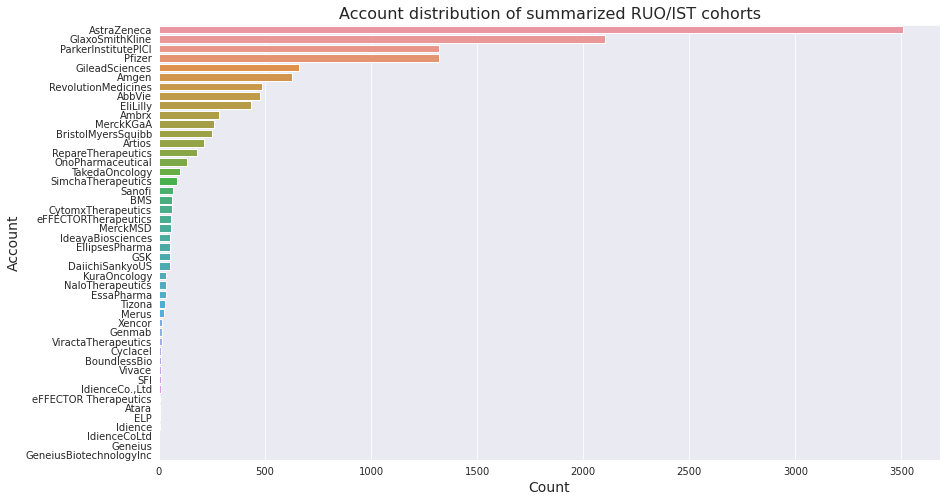

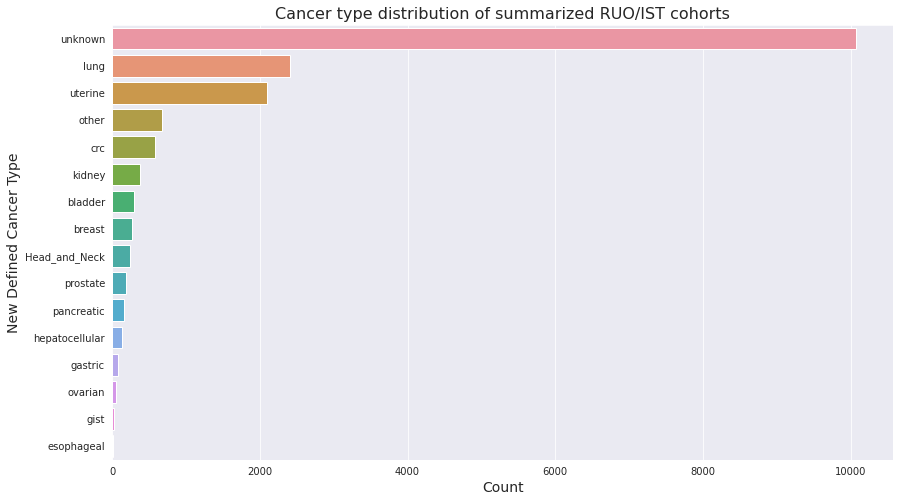

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
sns.set_style('darkgrid')
sns.countplot(data=top_prd_df, y='Account', order=top_prd_df['Account'].value_counts().index)

# Set plot title and labels
plt.title('Account distribution of summarized RUO/IST cohorts', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Account', fontsize=14)

# Plot the count plot for 'new_defined_cancer_type'
plt.figure(figsize=(14, 8))
sns.set_style('darkgrid')
sns.countplot(data=top_prd_df, y='new_defined_cancer_type', order=top_prd_df['new_defined_cancer_type'].value_counts().index)

# Set plot title and labels
plt.title('Cancer type distribution of summarized RUO/IST cohorts', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('New Defined Cancer Type', fontsize=14)

# Show the plot
plt.show()


In [150]:
top_prd_df.new_defined_cancer_type.unique()

array(['unknown', 'other', 'Head_and_Neck', 'gastric', 'lung', 'crc',
       'ovarian', 'breast', 'esophageal', 'bladder', 'pancreatic',
       'uterine', 'hepatocellular', 'kidney', 'gist', 'prostate'],
      dtype=object)

In [35]:
df_kyle_interest = pd.read_csv("/ghsfa/projects/omni_v2/users/kchang/lm_dev/data/all_ruo/tfv2_accn_hy.csv")
df_kyle_interest.head()

runid run_sample_id sample_index  gender  \
0  240104_A02048_0096_AHMGFFDSX7    A091100601   GCAATGGTAG  Female   
1  240114_A00441_0930_BHMJ7VDSX7    A091102401   CGCAGGATCG  Female   
2  240104_A02048_0096_AHMGFFDSX7    A091540201   GATCACTAGG    Male   
3  240208_A00569_0732_AHNNHWDSX7    A091546501   AGCCGAGGAC    Male   
4  240104_A02048_0096_AHMGFFDSX7    A092149601   TGCCCTAGTC    Male   

  sample_type             timestamp        panel  control_lot  \
0    Research  2024-01-06T22:59:58Z  Sirius_v1.0          NaN   
1    Research  2024-01-16T20:51:14Z  Sirius_v1.0          NaN   
2    Research  2024-01-06T22:59:58Z  Sirius_v1.0          NaN   
3    Research  2024-02-11T17:41:46Z  Sirius_v1.0          NaN   
4    Research  2024-01-06T22:59:58Z  Sirius_v1.0          NaN   

        bip_version  git_version  run_mode       product project  \
0  Sirius-1.1.2-RLS          NaN       NaN  Guardant 360  KGA_31   
1  Sirius-1.1.2-RLS          NaN       NaN  Guardant 360  NCC_14   
2  Sirius-1.1.2-RLS          NaN       NaN  Guardant 360  KGA_31   
3  Sirius-1.1.2-RLS          NaN       NaN  Guardant 360  KGA_31   
4  Sirius-1.1.2-RLS          NaN       NaN  Guardant 360  KGA_31   

                 cancer_type  patient_age         parameter_set  lunar_caller  \
0        lung adenocarcinoma         33.0  Sirius_LDT_Soft_v2.0           NaN   
1  colorectal adenocarcinoma          NaN  Sirius_LDT_Soft_v2.0           NaN   
2        lung adenocarcinoma         67.0  Sirius_LDT_Soft_v2.0           NaN   
3        lung adenocarcinoma         64.0  Sirius_LDT_Soft_v2.0           NaN   
4                lung cancer         68.0  Sirius_LDT_Soft_v2.0           NaN   

   comment provided_tumor_type request_id use_case qc_status  \
0      NaN                 NaN   A0911006      cgp      PASS   
1      NaN                 NaN   A0911024      cgp      PASS   
2      NaN                 NaN   A0915402      cgp      PASS   
3      NaN                 NaN   A0915465      cgp      PASS   
4      NaN                 NaN   A0921496      cgp      PASS   

                                                                                                     fc_dir  \
0  /ghsfa/ivd/flowcentral/240104_A02048_0096_AHMGFFDSX7.e587f5fc-40ed-4594-80a1-5e1ee7bf9fa0.20240106065859   
1           /ghsfa/projects/omni_v2/flowcells/240114_A00441_0930_BHMJ7VDSX7_PS3C365LDT_AP3.Sirius-1.1.2-RLS   
2  /ghsfa/ivd/flowcentral/240104_A02048_0096_AHMGFFDSX7.e587f5fc-40ed-4594-80a1-5e1ee7bf9fa0.20240106065859   
3           /ghsfa/projects/omni_v2/flowcells/240208_A00569_0732_AHNNHWDSX7_PS3C447LDT_AP1.Sirius-1.1.2-RLS   
4  /ghsfa/ivd/flowcentral/240104_A02048_0096_AHMGFFDSX7.e587f5fc-40ed-4594-80a1-5e1ee7bf9fa0.20240106065859   

    sample_id  GHSampleID  \
0  A091100601  A091100601   
1  A091102401  A091102401   
2  A091540201  A091540201   
3  A091546501  A091546501   
4  A092149601  A092149601   

                                                                                                           sample_path  \
0  /ghsfa/ivd/flowcentral/240104_A02048_0096_AHMGFFDSX7.e587f5fc-40ed-4594-80a1-5e1ee7bf9fa0.20240106065859/A091100601   
1           /ghsfa/projects/omni_v2/flowcells/240114_A00441_0930_BHMJ7VDSX7_PS3C365LDT_AP3.Sirius-1.1.2-RLS/A091102401   
2  /ghsfa/ivd/flowcentral/240104_A02048_0096_AHMGFFDSX7.e587f5fc-40ed-4594-80a1-5e1ee7bf9fa0.20240106065859/A091540201   
3           /ghsfa/projects/omni_v2/flowcells/240208_A00569_0732_AHNNHWDSX7_PS3C447LDT_AP1.Sirius-1.1.2-RLS/A091546501   
4  /ghsfa/ivd/flowcentral/240104_A02048_0096_AHMGFFDSX7.e587f5fc-40ed-4594-80a1-5e1ee7bf9fa0.20240106065859/A092149601   

                                                                                                                                                 mbd_path  \
0  /ghsfa/ivd/flowcentral/240104_A02048_0096_AHMGFFDSX7.e587f5fc-40ed-4594-80a1-5e1ee7bf9fa0.20240106065859/A091100601/A091100601.mbd_hyper_molecules.tsv   
1           /ghsfa/projects/omni_v2/flo

In [64]:
# Create the baseline and non-baseline conditions
baseline = df_kyle_interest['binary_visit'] == 'baseline'
non_baseline = df_kyle_interest['binary_visit'] == 'non-baseline'

# Create the conditions based on the "flag" column
flag_1_3 = df_kyle_interest['flag'] == 'ratio > 1.3'
flag_2 = df_kyle_interest['flag'] == 'ratio > 2'

# Create the new columns based on the flag conditions
df_kyle_interest['baseline_TFratio1.3'] = (baseline & flag_1_3).astype(int)
df_kyle_interest['baseline_TFratio2'] = (baseline & flag_2).astype(int)
df_kyle_interest['non_baseline_TFratio1.3'] = (non_baseline & flag_1_3).astype(int)
df_kyle_interest['non_baseline_TFratio2'] = (non_baseline & flag_2).astype(int)

# Check the head of the DataFrame to confirm the changes
df_kyle_interest.head()

runid run_sample_id sample_index  gender  \
0  240104_A02048_0096_AHMGFFDSX7    A091100601   GCAATGGTAG  Female   
1  240114_A00441_0930_BHMJ7VDSX7    A091102401   CGCAGGATCG  Female   
2  240104_A02048_0096_AHMGFFDSX7    A091540201   GATCACTAGG    Male   
3  240208_A00569_0732_AHNNHWDSX7    A091546501   AGCCGAGGAC    Male   
4  240104_A02048_0096_AHMGFFDSX7    A092149601   TGCCCTAGTC    Male   

  sample_type             timestamp        panel  control_lot  \
0    Research  2024-01-06T22:59:58Z  Sirius_v1.0          NaN   
1    Research  2024-01-16T20:51:14Z  Sirius_v1.0          NaN   
2    Research  2024-01-06T22:59:58Z  Sirius_v1.0          NaN   
3    Research  2024-02-11T17:41:46Z  Sirius_v1.0          NaN   
4    Research  2024-01-06T22:59:58Z  Sirius_v1.0          NaN   

        bip_version  git_version  run_mode       product project  \
0  Sirius-1.1.2-RLS          NaN       NaN  Guardant 360  KGA_31   
1  Sirius-1.1.2-RLS          NaN       NaN  Guardant 360  NCC_14   
2  Sirius-1.1.2-RLS          NaN       NaN  Guardant 360  KGA_31   
3  Sirius-1.1.2-RLS          NaN       NaN  Guardant 360  KGA_31   
4  Sirius-1.1.2-RLS          NaN       NaN  Guardant 360  KGA_31   

                 cancer_type  patient_age         parameter_set  lunar_caller  \
0        lung adenocarcinoma         33.0  Sirius_LDT_Soft_v2.0           NaN   
1  colorectal adenocarcinoma          NaN  Sirius_LDT_Soft_v2.0           NaN   
2        lung adenocarcinoma         67.0  Sirius_LDT_Soft_v2.0           NaN   
3        lung adenocarcinoma         64.0  Sirius_LDT_Soft_v2.0           NaN   
4                lung cancer         68.0  Sirius_LDT_Soft_v2.0           NaN   

   comment provided_tumor_type request_id use_case qc_status  \
0      NaN                 NaN   A0911006      cgp      PASS   
1      NaN                 NaN   A0911024      cgp      PASS   
2      NaN                 NaN   A0915402      cgp      PASS   
3      NaN                 NaN   A0915465      cgp      PASS   
4      NaN                 NaN   A0921496      cgp      PASS   

                                                                                                     fc_dir  \
0  /ghsfa/ivd/flowcentral/240104_A02048_0096_AHMGFFDSX7.e587f5fc-40ed-4594-80a1-5e1ee7bf9fa0.20240106065859   
1           /ghsfa/projects/omni_v2/flowcells/240114_A00441_0930_BHMJ7VDSX7_PS3C365LDT_AP3.Sirius-1.1.2-RLS   
2  /ghsfa/ivd/flowcentral/240104_A02048_0096_AHMGFFDSX7.e587f5fc-40ed-4594-80a1-5e1ee7bf9fa0.20240106065859   
3           /ghsfa/projects/omni_v2/flowcells/240208_A00569_0732_AHNNHWDSX7_PS3C447LDT_AP1.Sirius-1.1.2-RLS   
4  /ghsfa/ivd/flowcentral/240104_A02048_0096_AHMGFFDSX7.e587f5fc-40ed-4594-80a1-5e1ee7bf9fa0.20240106065859   

    sample_id  GHSampleID  \
0  A091100601  A091100601   
1  A091102401  A091102401   
2  A091540201  A091540201   
3  A091546501  A091546501   
4  A092149601  A092149601   

                                                                                                           sample_path  \
0  /ghsfa/ivd/flowcentral/240104_A02048_0096_AHMGFFDSX7.e587f5fc-40ed-4594-80a1-5e1ee7bf9fa0.20240106065859/A091100601   
1           /ghsfa/projects/omni_v2/flowcells/240114_A00441_0930_BHMJ7VDSX7_PS3C365LDT_AP3.Sirius-1.1.2-RLS/A091102401   
2  /ghsfa/ivd/flowcentral/240104_A02048_0096_AHMGFFDSX7.e587f5fc-40ed-4594-80a1-5e1ee7bf9fa0.20240106065859/A091540201   
3           /ghsfa/projects/omni_v2/flowcells/240208_A00569_0732_AHNNHWDSX7_PS3C447LDT_AP1.Sirius-1.1.2-RLS/A091546501   
4  /ghsfa/ivd/flowcentral/240104_A02048_0096_AHMGFFDSX7.e587f5fc-40ed-4594-80a1-5e1ee7bf9fa0.20240106065859/A092149601   

                                                                                                                                                 mbd_path  \
0  /ghsfa/ivd/flowcentral/240104_A02048_0096_AHMGFFDSX7.e587f5fc-40ed-4594-80a1-5e1ee7bf9fa0.20240106065859/A091100601/A091100601.mbd_hyper_molecules.tsv   
1           /ghsfa/projects/omni_v2/flo

In [42]:
df_kyle_interest.flag.value_counts()


ratio > 1.3    93
ratio > 2      56
Name: flag, dtype: int64

In [65]:
# Create a filter that checks if any of the new columns have a value of 1
filter_any_positive = (
    (df_kyle_interest['baseline_TFratio1.3'] == 1) |
    (df_kyle_interest['baseline_TFratio2'] == 1) |
    (df_kyle_interest['non_baseline_TFratio1.3'] == 1) |
    (df_kyle_interest['non_baseline_TFratio2'] == 1)
)

# Apply the filter to the original DataFrame to get only relevant rows
filtered_df = df_kyle_interest[filter_any_positive]
filtered_df.shape

(149, 75)

In [57]:
filtered_df.head()

runid run_sample_id sample_index   gender  \
826   230302_A01613_0150_AHN7LHDSX5     B00298913   TGCGATGGTT  Unknown   
1360  230329_A01835_0034_BHVHJLDSX5     B00319876   CATGACCTGC  Unknown   
1673  230404_A01744_0071_AHVJGVDSX5     B00324233   TAGATTACCC  Unknown   
1801  230420_A01810_0121_AH37FCDSX7     B00353154   CACGATTCCA  Unknown   
1955  230518_A01902_0142_BH3VYFDSX7     B00386407   AGCGCTTATA     Male   

     sample_type             timestamp        panel  control_lot  \
826     Research  2023-03-05T07:49:17Z  Sirius_v1.0          NaN   
1360    Research  2023-04-01T04:38:05Z  Sirius_v1.0          NaN   
1673    Research  2023-04-07T06:14:09Z  Sirius_v1.0          NaN   
1801    Research  2023-04-23T07:19:55Z  Sirius_v1.0          NaN   
1955    Research  2023-05-20T23:55:41Z  Sirius_v1.0          NaN   

           bip_version  git_version  run_mode       product        project  \
826   Sirius-1.0.0-RLS          NaN       NaN  Guardant 360  TAK_01_NewMSA   
1360  Sirius-1.0.0-RLS          NaN       NaN  Guardant 360  REP_RC1plasma   
1673  Sirius-1.0.0-RLS          NaN       NaN  Guardant 360      PIC_RP_01   
1801  Sirius-1.0.0-RLS          NaN       NaN  Guardant 360      PIC_RP_01   
1955  Sirius-1.0.0-RLS          NaN       NaN  Guardant 360        PFE_RC1   

            cancer_type  patient_age parameter_set  lunar_caller  comment  \
826   gastric carcinoma          NaN   Sirius_v1.0           NaN      NaN   
1360                NaN          NaN   Sirius_v1.0           NaN      NaN   
1673              nsclc          NaN   Sirius_v1.0           NaN      NaN   
1801              nsclc          NaN   Sirius_v1.0           NaN      NaN   
1955        lung cancer          NaN   Sirius_v1.0           NaN      NaN   

     provided_tumor_type request_id use_case qc_status  \
826                  NaN   A0670297      NaN      PASS   
1360                 NaN   A0688536      NaN      PASS   
1673                 NaN   A0675069      NaN      PASS   
1801                 NaN   A0675432      NaN      PASS   
1955                 NaN   A0702325      NaN      PASS   

                                                                                                            fc_dir  \
826   /ghsfa/projects/omni_v2/flowcells/230302_A01613_0150_AHN7LHDSX5_PROD196_AP1.Sirius-1.1.0-RLS_20230822-205253   
1360  /ghsfa/projects/omni_v2/flowcells/230329_A01835_0034_BHVHJLDSX5_PS3R217_AP2.Sirius-1.1.0-RLS_20230803-092440   
1673  /ghsfa/projects/omni_v2/flowcells/230404_A01744_0071_AHVJGVDSX5_PS3R225_AP3.Sirius-1.1.0-RLS_20230825-115900   
1801  /ghsfa/projects/omni_v2/flowcells/230420_A01810_0121_AH37FCDSX7_PS3R233_AP2.Sirius-1.1.0-RLS_20230829-101009   
1955  /ghsfa/projects/omni_v2/flowcells/230518_A01902_0142_BH3VYFDSX7_PS3R288_AP3.Sirius-1.1.0-RLS_20230716-151032   

      sample_id GHSampleID  \
826   B00298913  B00298913   
1360  B00319876  B00319876   
1673  B00324233  B00324233   
1801  B00353154  B00353154   
1955  B00386407  B00386407   

                                                                                                                 sample_path  \
826   /ghsfa/projects/omni_v2/flowcells/230302_A01613_0150_AHN7LHDSX5_PROD196_AP1.Sirius-1.1.0-RLS_20230822-205253/B00298913   
1360  /ghsfa/projects/omni_v2/flowcells/230329_A01835_0034_BHVHJLDSX5_PS3R217_AP2.Sirius-1.1.0-RLS_20230803-092440/B00319876   
1673  /ghsfa/projects/omni_v2/flowcells/230404_A01744_0071_AHVJGVDSX5_PS3R225_AP3.Sirius-1.1.0-RLS_20230825-115900/B00324233   
1801  /ghsfa/projects/omni_v2/flowcells/230420_A01810_0121_AH37FCDSX7_PS3R233_AP2.Sirius-1.1.0-RLS_20230829-101009/B00353154   
1955  /ghsfa/projects/omni_v2/flowcells/230518_A01902_0142_BH3VYFDSX7_PS3R288_AP3.Sirius-1.1.0-RLS_20230716-151032/B00386407   

                                                                                                                                                      mbd_path  \
826   /ghsfa/projects/omni_v2/flowcells/230302_A01613_0150_AHN7LHDSX

In [66]:
# List of columns to include from filtered_df (including the 4 new columns)
columns_to_include = [
    'run_sample_id', 'baseline_TFratio1.3', 'baseline_TFratio2',
    'non_baseline_TFratio1.3', 'non_baseline_TFratio2'
]

# Perform an inner join using 'run_sample_id' and 'GHSampleID'
merged_df = top_prd_df.merge(
    filtered_df[columns_to_include],
    left_on='GHSampleID',
    right_on='run_sample_id',
    how='inner'
)

# Verify the merged DataFrame
merged_df.head()


unique_sample_id  Pancancer      cso_model_type  \
0  B00298913_230302_A01613_0150_AHN7LHDSX5 -22.215816             CSO_crc   
1  B00319876_230329_A01835_0034_BHVHJLDSX5 -17.763464      CSO_esophageal   
2  B00324233_230404_A01744_0071_AHVJGVDSX5 -10.724451          CSO_breast   
3  B00353154_230420_A01810_0121_AH37FCDSX7 -22.172777            CSO_lung   
4  B00386407_230518_A01902_0142_BH3VYFDSX7 -19.058590  CSO_hepatocellular   

   cso_score GHRequestID GHSampleID                Patient_ID  \
0 -18.385915    A0670297  B00298913        CU220214-135-Z2402   
1 -14.443478    A0688536  B00319876                  10070337   
2  -7.740379    A0675069  B00324233  PICI0009.PICI0009-3-1789   
3 -18.226144    A0675432  B00353154  PICI0009.PICI0009-3-1023   
4 -15.157302    A0702325  B00386407                  10381001   

               Visit_name Sample_status Sample_comment  cfDNA_ng  \
0                      T1       SUCCESS            NaN    33.475   
1            Cycle 4 Day8       SUCCESS            NaN    86.450   
2  6 MONTHS POST 1ST DOSE       SUCCESS            NaN     5.220   
3     4-6 WEEKS POST EOSI       SUCCESS            NaN    20.605   
4                   BC2D1       SUCCESS            NaN   241.150   

   Plasma_ml_input         Cancertype  \
0              3.0  Gastric carcinoma   
1              4.0                NaN   
2              1.0              NSCLC   
3              1.0              NSCLC   
4              3.5        Lung Cancer   

                                                       csv_file_name  \
0         20230322_TakedaOncology_SOW01_62Samples_InfinityReport.csv   
1     20230413_RepareTherapeutics_SOW01_49Samples_InfinityReport.csv   
2  20230929_ParkerInstitutePICI_RP_01_1024Samples_InfinityReport.csv   
3   20230615_ParkerInstitutePICI_RP_01_341Samples_InfinityReport.csv   
4                 20230718_Pfizer_RC1_462_Samples_InfinityReport.csv   

               Account SOW_num cancer_category        cancerother cancerstage  \
0       TakedaOncology     1.0           Other  Gastric carcinoma         IIB   
1   RepareTherapeutics     1.0           Other                NaN         NaN   
2  ParkerInstitutePICI      01           Other              NSCLC         NaN   
3  ParkerInstitutePICI      01           Other              NSCLC         NaN   
4                  NaN     NaN           Other        Lung Cancer         NaN   

  cancertype sample_index   gender sample_type             timestamp  \
0        NaN   TGCGATGGTT  Unknown    Research  2023-03-05T07:49:17Z   
1        NaN   CATGACCTGC  Unknown    Research  2023-04-01T04:38:05Z   
2        NaN   TAGATTACCC  Unknown    Research  2023-04-07T06:14:09Z   
3        NaN   CACGATTCCA  Unknown    Research  2023-04-23T07:19:55Z   
4        NaN   AGCGCTTATA     Male    Research  2023-05-20T23:55:41Z   

         panel  control_lot       bip_version  git_version  run_mode  \
0  Sirius_v1.0          NaN  Sirius-1.0.0-RLS          NaN       NaN   
1  Sirius_v1.0          NaN  Sirius-1.0.0-RLS          NaN       NaN   
2  Sirius_v1.0          NaN  Sirius-1.0.0-RLS          NaN       NaN   
3  Sirius_v1.0          NaN  Sirius-1.0.0-RLS          NaN       NaN   
4  Sirius_v1.0          NaN  Sirius-1.0.0-RLS          NaN       NaN   

        product        project cancer_type  patient_age parameter_set  \
0  Guardant 360  TAK_01_NewMSA         NaN          NaN   Sirius_v1.0   
1  Guardant 360  REP_RC1plasma         NaN          NaN   Sirius_v1.0   
2  Guardant 360      PIC_RP_01         NaN          NaN   Sirius_v1.0   
3  Guardant 360      PIC_RP_01         NaN          NaN   Sirius_v1.0   
4  Guardant 360        PFE_RC1         NaN          NaN   Sirius_v1.0   

   lunar_caller  comment provided_tumor_type request_id use_case qc_status  \
0           NaN      NaN                 NaN   A0670297      NaN      PASS   
1           NaN      NaN                 NaN   A0688536      NaN      PASS   
2           NaN      NaN                 NaN   A0675069  

In [75]:
# Extract run_sample_id from merged_df
merged_sample_ids = merged_df['GHSampleID'].unique()

# Filter df_kyle_interest to find rows where run_sample_id is not in merged_sample_ids
df_not_in_merged = df_kyle_interest[~df_kyle_interest['run_sample_id'].isin(merged_sample_ids)]

# Display the result
df_not_in_merged.GHSampleID.unique()


array(['A091100601', 'A091102401', 'A091540201', ..., 'B00651694',
       'B00651695', 'B00651696'], dtype=object)

In [76]:
df_not_in_merged.shape

(19488, 75)

In [67]:
merged_df.shape

(142, 61)

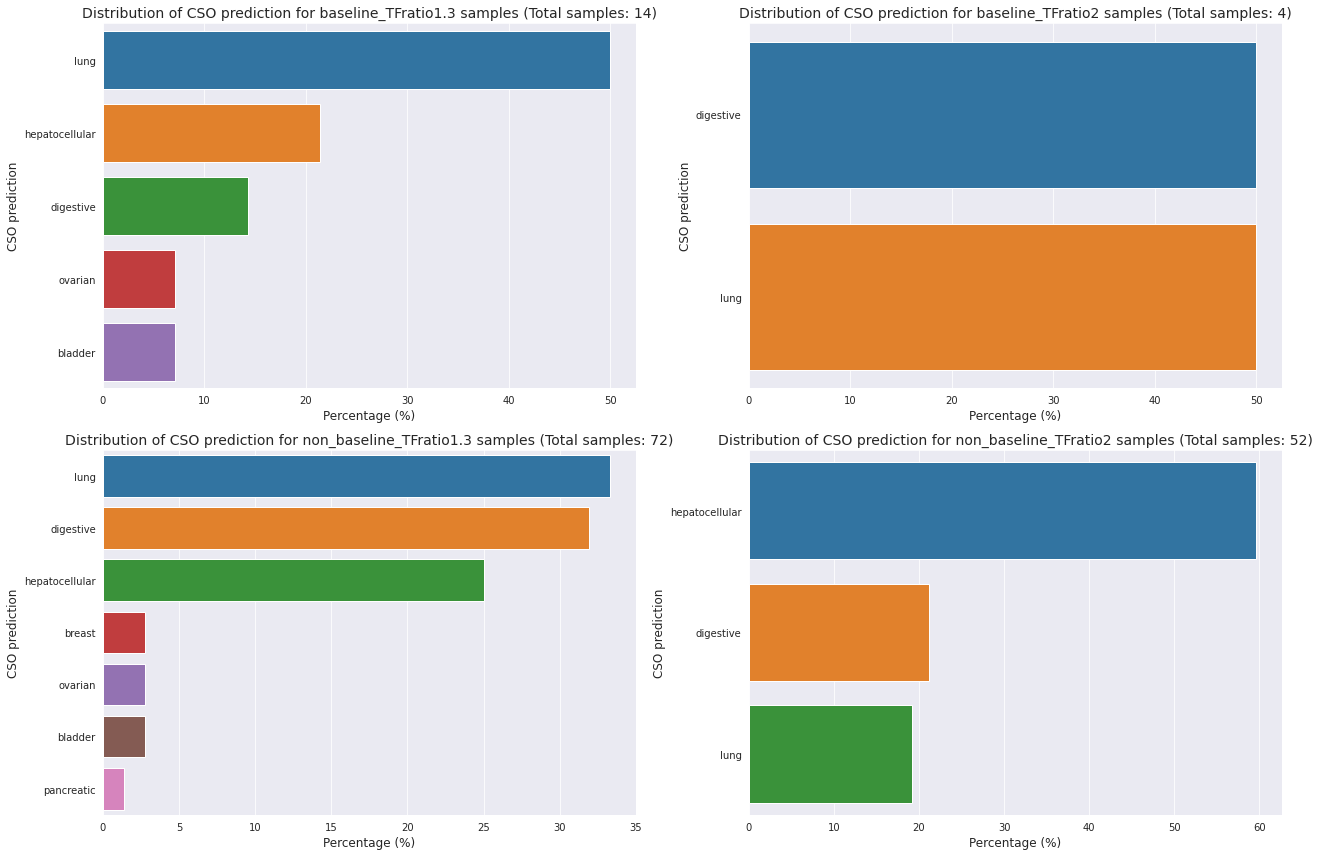

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set up a 2x2 grid for subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
sns.set_style('darkgrid')

# Define a mapping of columns to subplot indices and titles
plot_data = [
    ("baseline_TFratio1.3", 0, 0, 'Distribution of CSO prediction for baseline_TFratio1.3 samples'),
    ("baseline_TFratio2", 0, 1, 'Distribution of CSO prediction for baseline_TFratio2 samples'),
    ("non_baseline_TFratio1.3", 1, 0, 'Distribution of CSO prediction for non_baseline_TFratio1.3 samples'),
    ("non_baseline_TFratio2", 1, 1, 'Distribution of CSO prediction for non_baseline_TFratio2 samples')
]

# Loop through each set of parameters and create percentage plots
for column, row, col, base_title in plot_data:
    # Filter data where the column value is 1
    filtered_df = merged_df[merged_df[column] == 1]
    total_samples = len(filtered_df)
    
    # Calculate the percentage of each cso_prediction
    prediction_counts = filtered_df['cso_prediction'].value_counts(normalize=True).mul(100).reset_index()
    prediction_counts.columns = ['cso_prediction', 'percentage']
    
    # Plot on the respective subplot
    ax = axs[row, col]
    sns.barplot(data=prediction_counts, y='cso_prediction', x='percentage', ax=ax)
    
    # Set titles and labels with total sample size
    ax.set_title(f'{base_title} (Total samples: {total_samples})', fontsize=14)
    ax.set_xlabel('Percentage (%)', fontsize=12)
    ax.set_ylabel('CSO prediction', fontsize=12)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


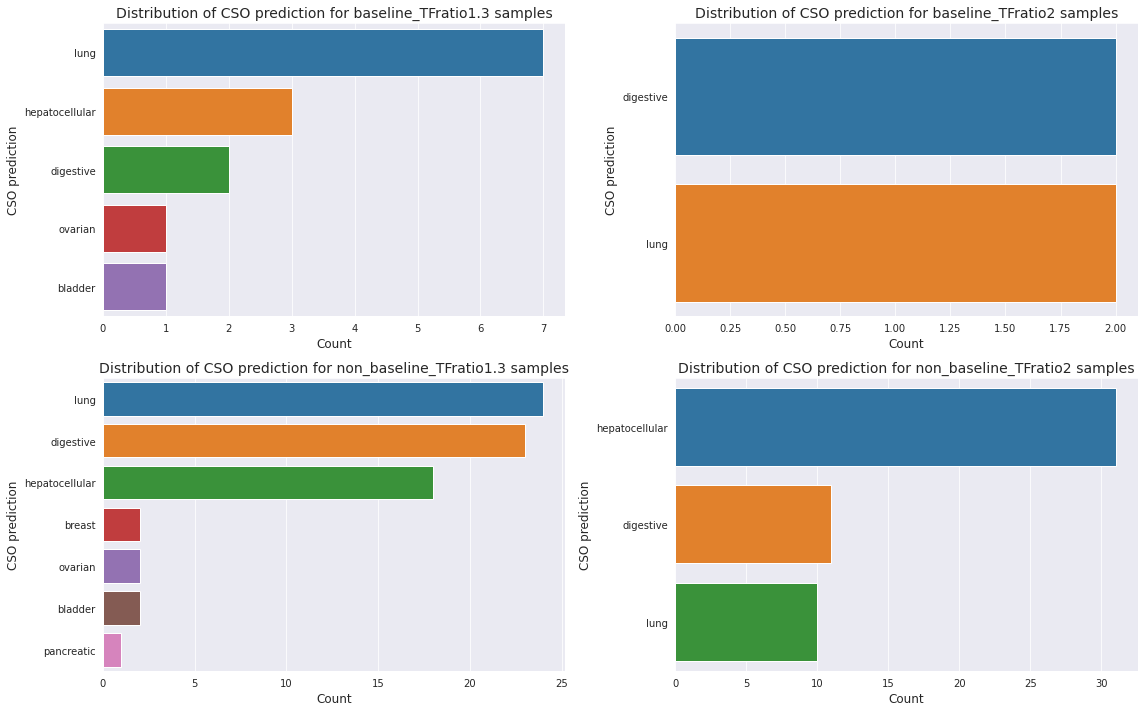

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up a 2x2 grid for subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
sns.set_style('darkgrid')

# Define a mapping of columns to subplot indices and titles
plot_data = [
    ("baseline_TFratio1.3", 0, 0, 'Distribution of CSO prediction for baseline_TFratio1.3 samples'),
    ("baseline_TFratio2", 0, 1, 'Distribution of CSO prediction for baseline_TFratio2 samples'),
    ("non_baseline_TFratio1.3", 1, 0, 'Distribution of CSO prediction for non_baseline_TFratio1.3 samples'),
    ("non_baseline_TFratio2", 1, 1, 'Distribution of CSO prediction for non_baseline_TFratio2 samples')
]

# Loop through each set of parameters and create count plots
for column, row, col, title in plot_data:
    # Filter data where the column value is 1
    filtered_df = merged_df[merged_df[column] == 1]
    
    # Plot on the respective subplot
    sns.countplot(data=filtered_df, y='cso_prediction', 
                  order=filtered_df['cso_prediction'].value_counts().index,
                  ax=axs[row, col])
    
    # Set titles and labels
    axs[row, col].set_title(title, fontsize=14)
    axs[row, col].set_xlabel('Count', fontsize=12)
    axs[row, col].set_ylabel('CSO prediction', fontsize=12)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


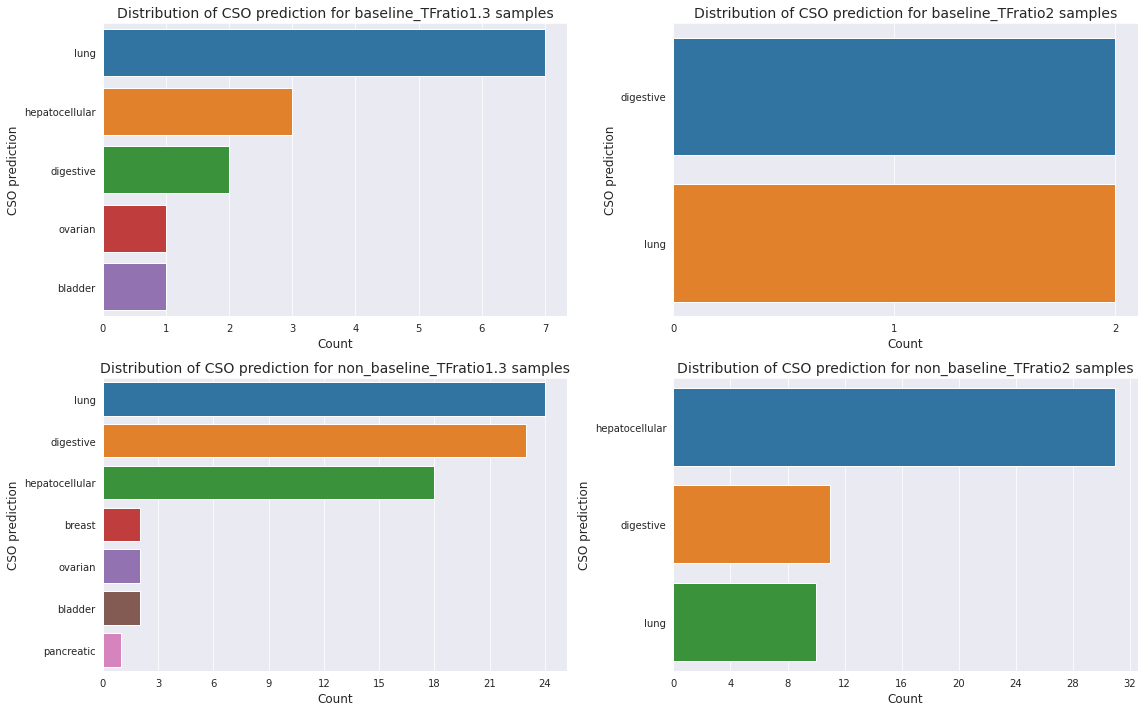

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Set up a 2x2 grid for subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
sns.set_style('darkgrid')

# Define a mapping of columns to subplot indices and titles
plot_data = [
    ("baseline_TFratio1.3", 0, 0, 'Distribution of CSO prediction for baseline_TFratio1.3 samples'),
    ("baseline_TFratio2", 0, 1, 'Distribution of CSO prediction for baseline_TFratio2 samples'),
    ("non_baseline_TFratio1.3", 1, 0, 'Distribution of CSO prediction for non_baseline_TFratio1.3 samples'),
    ("non_baseline_TFratio2", 1, 1, 'Distribution of CSO prediction for non_baseline_TFratio2 samples')
]

# Loop through each set of parameters and create count plots
for column, row, col, title in plot_data:
    # Filter data where the column value is 1
    filtered_df = merged_df[merged_df[column] == 1]
    
    # Plot on the respective subplot
    ax = axs[row, col]
    sns.countplot(data=filtered_df, y='cso_prediction', 
                  order=filtered_df['cso_prediction'].value_counts().index,
                  ax=ax)
    
    # Set titles and labels
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Count', fontsize=12)
    ax.set_ylabel('CSO prediction', fontsize=12)

    # Ensure the x-axis has only integer labels
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


Text(0, 0.5, 'Provided cancer type')

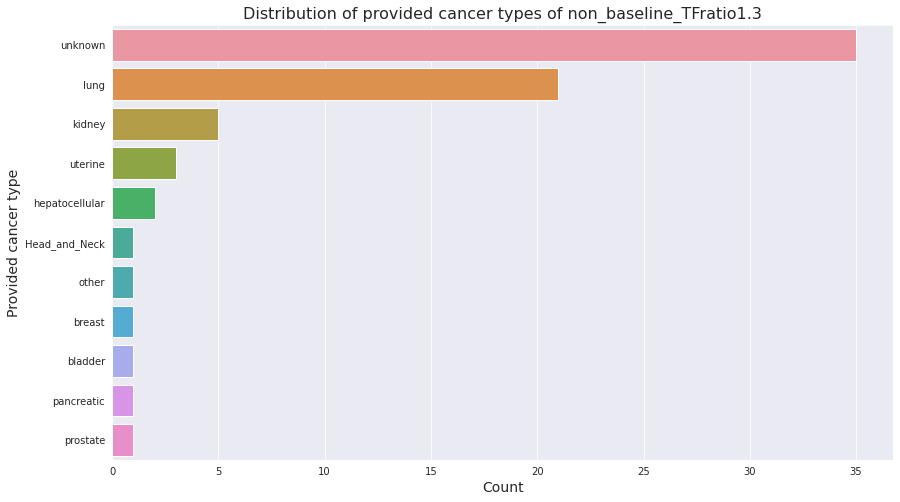

In [84]:
merged_df_1 = merged_df[merged_df["non_baseline_TFratio1.3"] == 1]
plt.figure(figsize=(14, 8))
sns.set_style('darkgrid')
sns.countplot(data=merged_df_1, y='new_defined_cancer_type', order=merged_df_1['new_defined_cancer_type'].value_counts().index)

# Set plot title and labels
plt.title('Distribution of provided cancer types of non_baseline_TFratio1.3', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Provided cancer type', fontsize=14)

In [85]:
merged_df_1.new_defined_cancer_type.value_counts()

unknown           35
lung              21
kidney             5
uterine            3
hepatocellular     2
Head_and_Neck      1
other              1
breast             1
bladder            1
pancreatic         1
prostate           1
Name: new_defined_cancer_type, dtype: int64

In [ ]:
merged_df_1

In [36]:
df_kyle_interest.shape

(19630, 71)

In [60]:


# Use the sample_list to filter top_prd_df for matching GHSampleID values
df_outliers = top_prd_df[top_prd_df['GHSampleID'].isin(sample_list)]

df_outliers.shape


(142, 56)

In [61]:
df_outliers.head()

unique_sample_id  Pancancer      cso_model_type  \
1470  B00298913_230302_A01613_0150_AHN7LHDSX5 -22.215816             CSO_crc   
1806  B00319876_230329_A01835_0034_BHVHJLDSX5 -17.763464      CSO_esophageal   
2104  B00324233_230404_A01744_0071_AHVJGVDSX5 -10.724451          CSO_breast   
2237  B00353154_230420_A01810_0121_AH37FCDSX7 -22.172777            CSO_lung   
2462  B00386407_230518_A01902_0142_BH3VYFDSX7 -19.058590  CSO_hepatocellular   

      cso_score GHRequestID GHSampleID                Patient_ID  \
1470 -18.385915    A0670297  B00298913        CU220214-135-Z2402   
1806 -14.443478    A0688536  B00319876                  10070337   
2104  -7.740379    A0675069  B00324233  PICI0009.PICI0009-3-1789   
2237 -18.226144    A0675432  B00353154  PICI0009.PICI0009-3-1023   
2462 -15.157302    A0702325  B00386407                  10381001   

                  Visit_name Sample_status Sample_comment  cfDNA_ng  \
1470                      T1       SUCCESS            NaN    33.475   
1806            Cycle 4 Day8       SUCCESS            NaN    86.450   
2104  6 MONTHS POST 1ST DOSE       SUCCESS            NaN     5.220   
2237     4-6 WEEKS POST EOSI       SUCCESS            NaN    20.605   
2462                   BC2D1       SUCCESS            NaN   241.150   

      Plasma_ml_input         Cancertype  \
1470              3.0  Gastric carcinoma   
1806              4.0                NaN   
2104              1.0              NSCLC   
2237              1.0              NSCLC   
2462              3.5        Lung Cancer   

                                                          csv_file_name  \
1470         20230322_TakedaOncology_SOW01_62Samples_InfinityReport.csv   
1806     20230413_RepareTherapeutics_SOW01_49Samples_InfinityReport.csv   
2104  20230929_ParkerInstitutePICI_RP_01_1024Samples_InfinityReport.csv   
2237   20230615_ParkerInstitutePICI_RP_01_341Samples_InfinityReport.csv   
2462                 20230718_Pfizer_RC1_462_Samples_InfinityReport.csv   

                  Account SOW_num cancer_category        cancerother  \
1470       TakedaOncology     1.0           Other  Gastric carcinoma   
1806   RepareTherapeutics     1.0           Other                NaN   
2104  ParkerInstitutePICI      01           Other              NSCLC   
2237  ParkerInstitutePICI      01           Other              NSCLC   
2462                  NaN     NaN           Other        Lung Cancer   

     cancerstage cancertype sample_index   gender sample_type  \
1470         IIB        NaN   TGCGATGGTT  Unknown    Research   
1806         NaN        NaN   CATGACCTGC  Unknown    Research   
2104         NaN        NaN   TAGATTACCC  Unknown    Research   
2237         NaN        NaN   CACGATTCCA  Unknown    Research   
2462         NaN        NaN   AGCGCTTATA     Male    Research   

                 timestamp        panel  control_lot       bip_version  \
1470  2023-03-05T07:49:17Z  Sirius_v1.0          NaN  Sirius-1.0.0-RLS   
1806  2023-04-01T04:38:05Z  Sirius_v1.0          NaN  Sirius-1.0.0-RLS   
2104  2023-04-07T06:14:09Z  Sirius_v1.0          NaN  Sirius-1.0.0-RLS   
2237  2023-04-23T07:19:55Z  Sirius_v1.0          NaN  Sirius-1.0.0-RLS   
2462  2023-05-20T23:55:41Z  Sirius_v1.0          NaN  Sirius-1.0.0-RLS   

      git_version  run_mode       product        project cancer_type  \
1470          NaN       NaN  Guardant 360  TAK_01_NewMSA         NaN   
1806          NaN       NaN  Guardant 360  REP_RC1plasma         NaN   
2104          NaN       NaN  Guardant 360      PIC_RP_01         NaN   
2237          NaN       NaN  Guardant 360      PIC_RP_01         NaN   
2462          NaN       NaN  Guardant 360        PFE_RC1         NaN   

      patient_age parameter_set  lunar_caller  comment provided_tumor_type  \
1470          NaN   Sirius_v1.0           NaN      NaN                 NaN   
1806          NaN   Sirius_v1.0           NaN      NaN                 NaN   
2104          NaN   Sirius_v1.0           NaN      NaN      

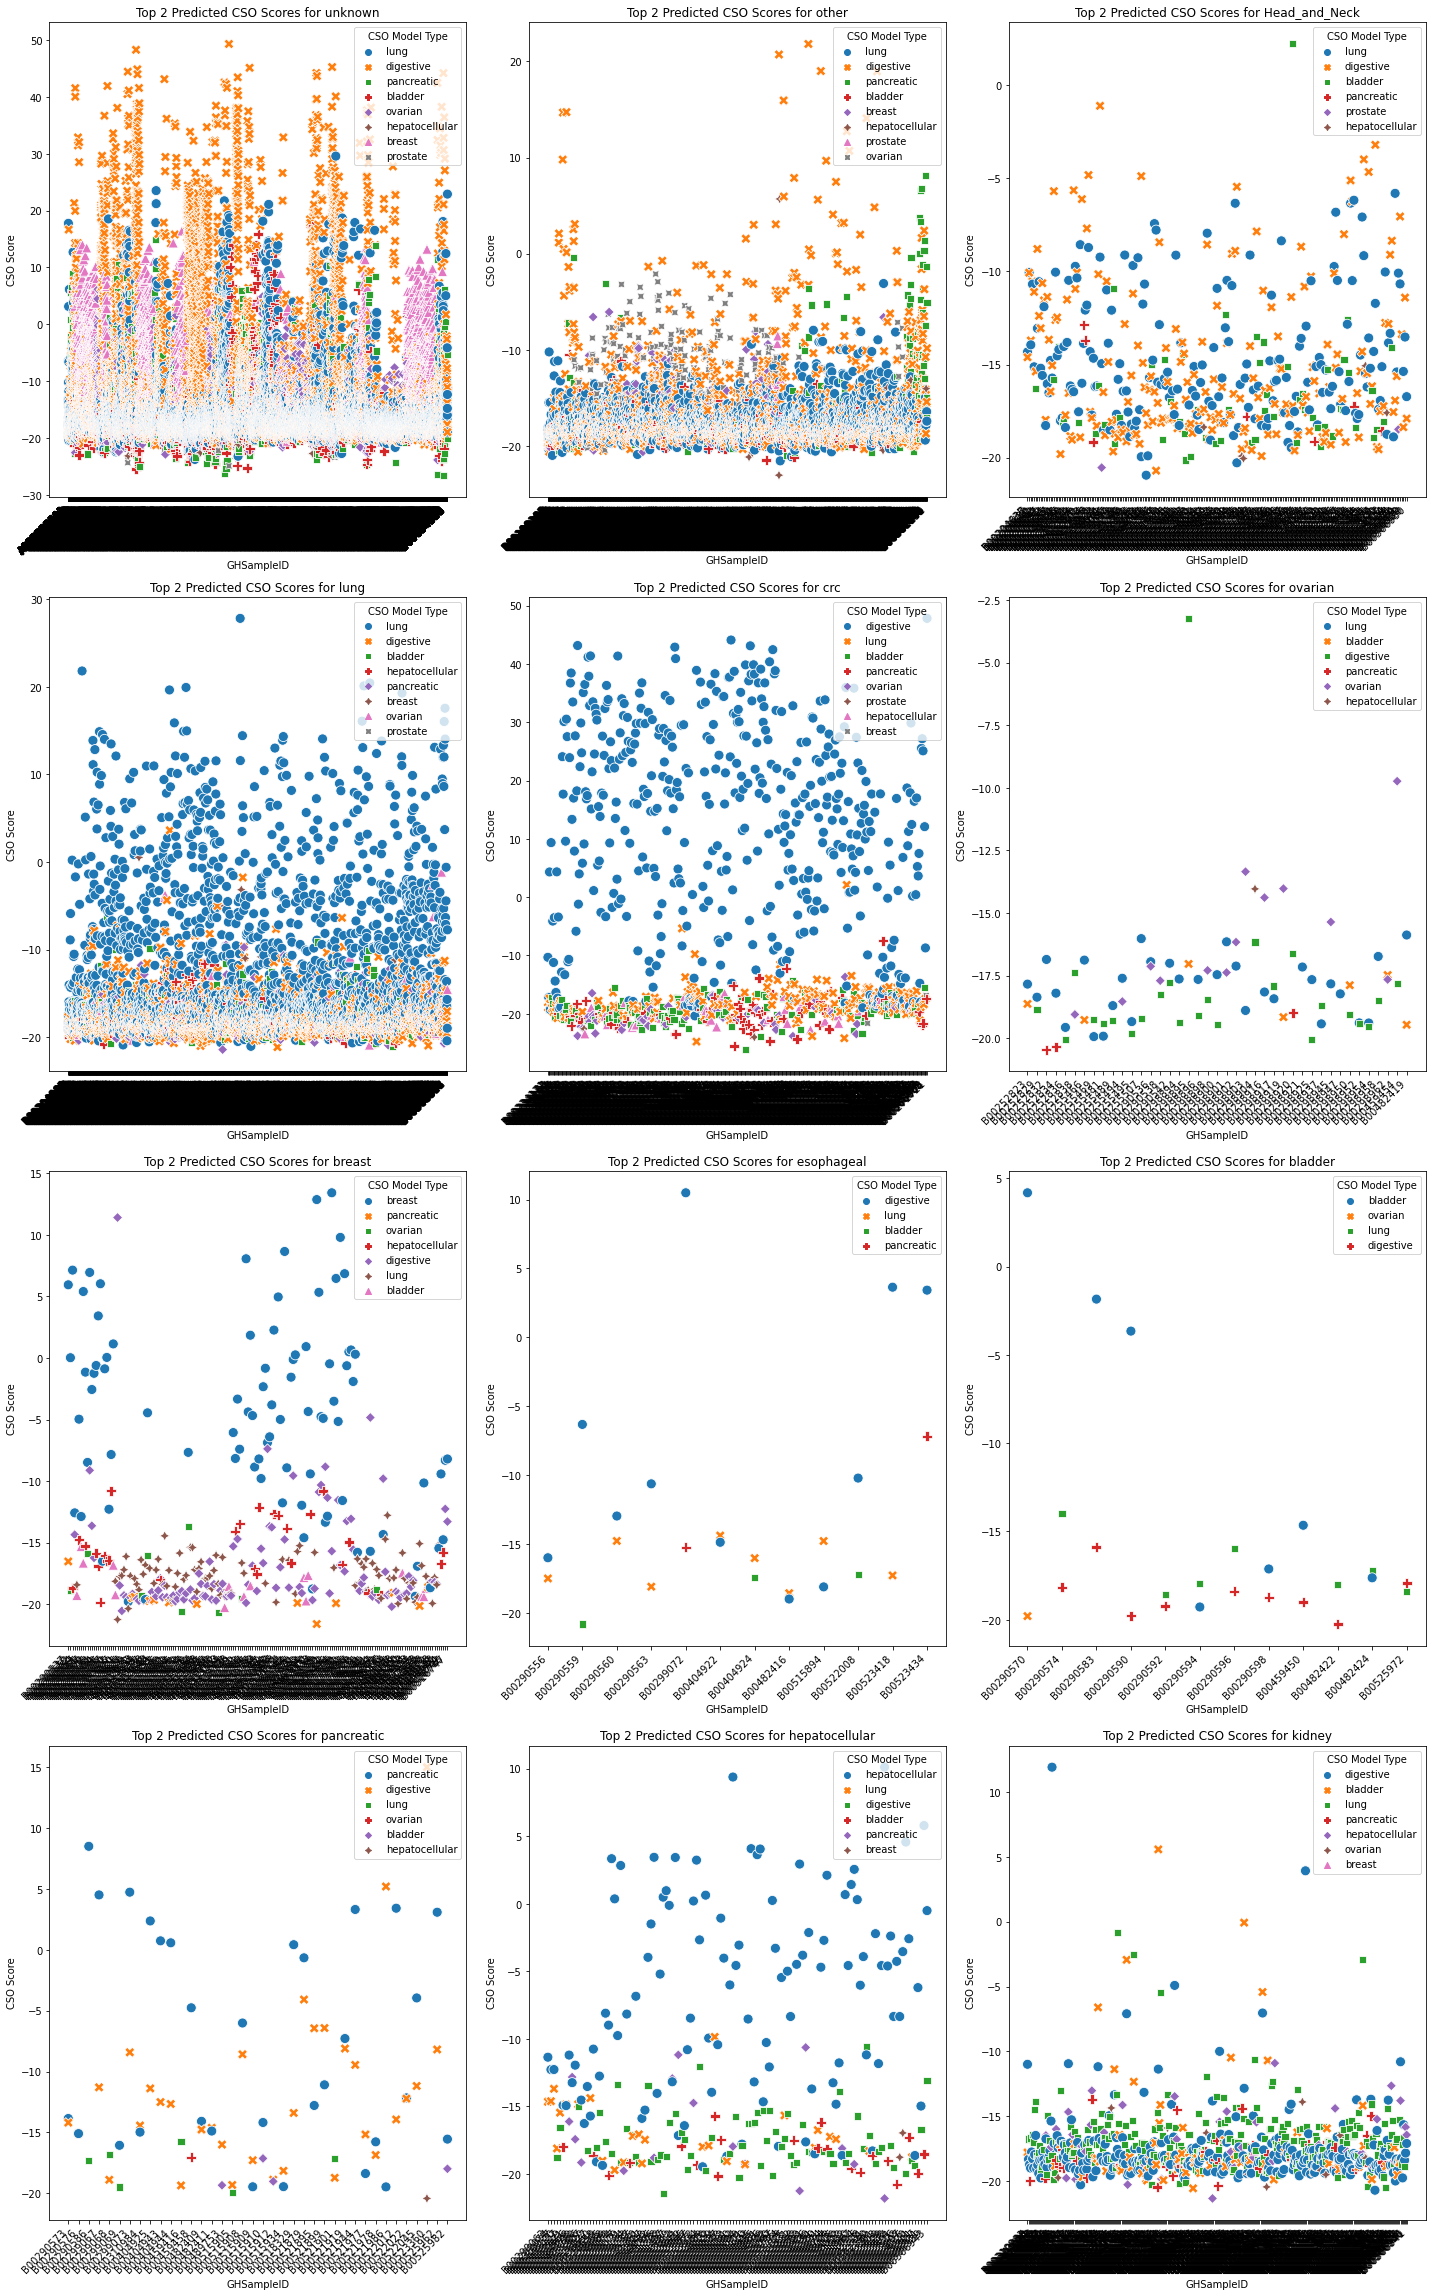

In [44]:
cancer_types = top_2_prd_df['new_defined_cancer_type'].unique()

n = len(cancer_types)
ncols = 3
nrows = (n + 1) // ncols  

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8 * nrows)) 
axes = axes.flatten()  

for ax, cancer in zip(axes, cancer_types):
    df_subset = top_2_prd_df[top_2_prd_df['new_defined_cancer_type'] == cancer]
    
    # sns.scatterplot(data=df_subset, x='GHSampleID', y='cso_score', hue='cso_model_type', style='cso_model_type', s=100, ax=ax)
    sns.scatterplot(data=df_subset, x='GHSampleID', y='cso_score', hue='cso_prediction', style='cso_prediction', s=100, ax=ax)

    
    ax.set_title(f'Top 2 Predicted CSO Scores for {cancer}')
    ax.set_xlabel('GHSampleID')
    ax.set_ylabel('CSO Score')
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    ax.legend(title='CSO Model Type', loc='upper right')

plt.tight_layout()
plt.show()


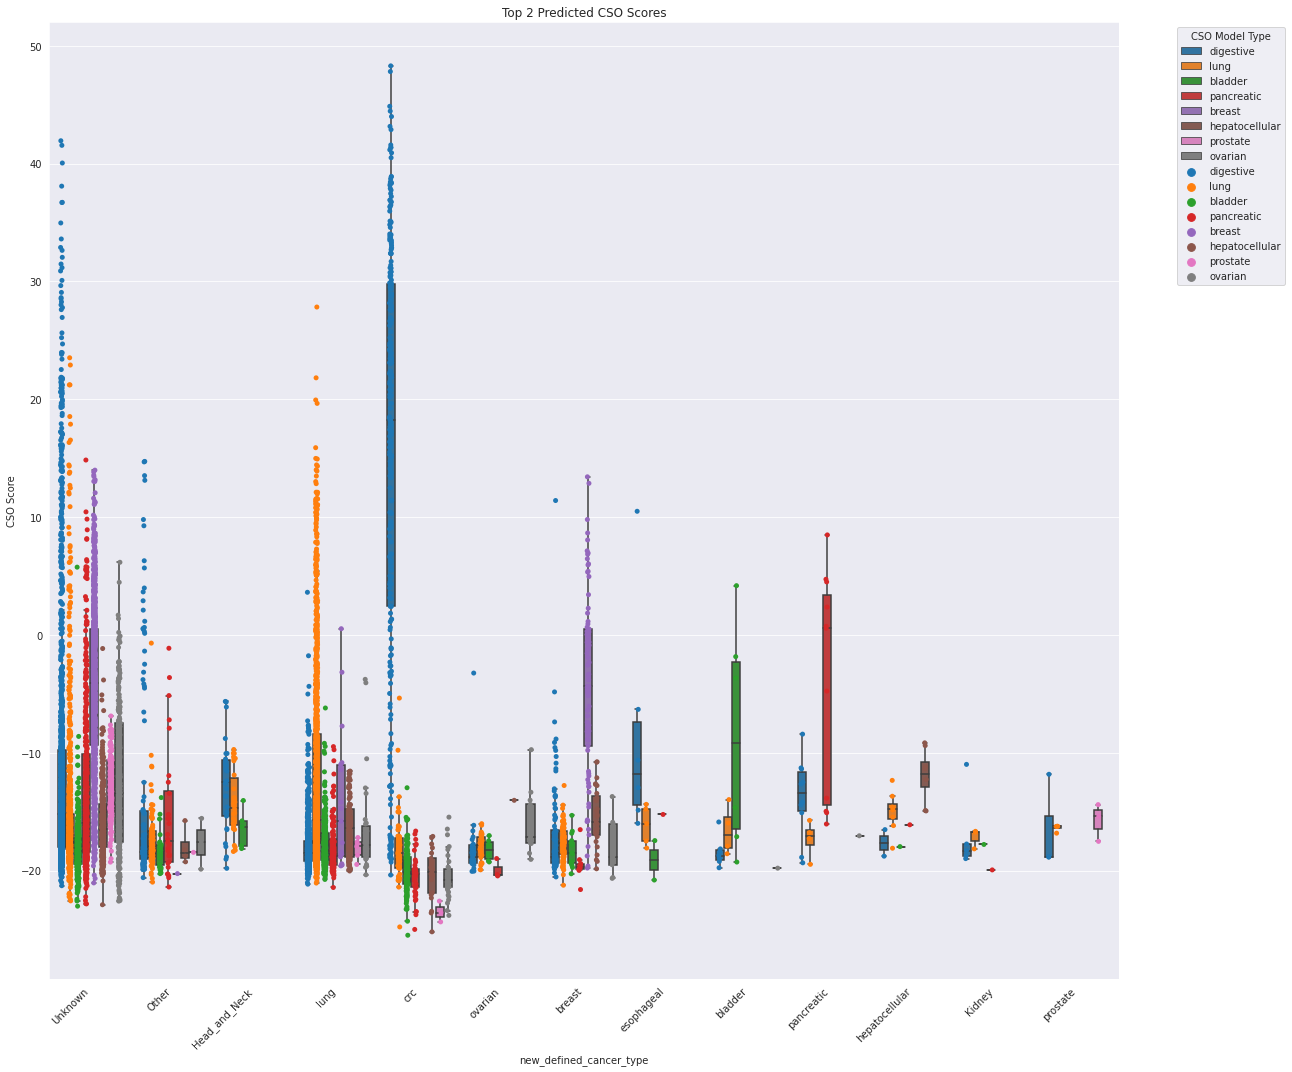

In [47]:
sns.set_style('darkgrid')

plt.figure(figsize=(18, 15))

sns.boxplot(data=top_prd_df, x='new_defined_cancer_type', y='cso_score', hue='cso_prediction', showfliers=False)

sns.stripplot(data=top_2_prd_df, x='new_defined_cancer_type', y='cso_score', hue='cso_prediction', jitter=True, size=5, dodge=True, linewidth=0.5, edgecolor='none')

plt.title('Top 2 Predicted CSO Scores')
plt.xlabel('new_defined_cancer_type')
plt.ylabel('CSO Score')

plt.xticks(rotation=45, ha='right')

plt.legend(title='CSO Model Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [24]:
# Filter to find rows where 'cso_prediction' is 'digestive'
digestive_pred = top_prd_df[top_prd_df['cso_prediction'] == 'digestive']

# Find unique GHSampleIDs that have 'digestive' in the top1 predictions
digestive_ghsample_ids = digestive_pred['GHSampleID'].unique()

# Filter the original DataFrame to get entries for these GHSampleIDs
filtered_df = top_prd_df[top_prd_df['GHSampleID'].isin(digestive_ghsample_ids)]

# Filter out rows where 'new_defined_cancer_type' is either 'hepatocellular', 'Unknown', or 'Other'
df_digestive_cso = filtered_df[~filtered_df['new_defined_cancer_type'].isin(['crc', 'esophageal', 'unknown', 'gastric'])]

print(df_digestive_cso.shape)
# Display the result
df_digestive_cso.head()

(1706, 56)


unique_sample_id  Pancancer cso_model_type  \
50  B00199189_221004_A01902_0023_AHNLF3DSX3 -21.860305        CSO_crc   
51  B00199191_221004_A01810_0046_AHNLG3DSX3 -22.784004        CSO_crc   
58  B00199201_221004_A01902_0023_AHNLF3DSX3 -22.416041        CSO_crc   
63  B00199215_221004_A01810_0046_AHNLG3DSX3 -21.040439        CSO_crc   
65  B00199218_221004_A01902_0023_AHNLF3DSX3 -21.949153        CSO_crc   

    cso_score GHRequestID GHSampleID Patient_ID    Visit_name Sample_status  \
50 -18.700886    A0540229  B00199189      74363  Post-surgery       SUCCESS   
51 -19.205347    A0540546  B00199191     124-68   Pre-surgery       SUCCESS   
58 -18.506771    A0540181  B00199201   32145 VS  Post-surgery       SUCCESS   
63 -18.220895    A0540578  B00199215     K81254   Pre-surgery       SUCCESS   
65 -18.572620    A0540173  B00199218      67759  Post-surgery       SUCCESS   

   Sample_comment  cfDNA_ng  Plasma_ml_input Cancertype  \
50            NaN       NaN              4.2   Melanoma   
51            NaN       NaN              4.8   Melanoma   
58            NaN       NaN              4.2   Melanoma   
63            NaN       NaN              5.4   Melanoma   
65            NaN       NaN              4.2   Melanoma   

                                          csv_file_name Account SOW_num  \
50  20221214_BMS_SOW21_414Sample_InfinityReport_MRD.csv     BMS    21.0   
51  20221214_BMS_SOW21_414Sample_InfinityReport_MRD.csv     BMS    21.0   
58  20221214_BMS_SOW21_414Sample_InfinityReport_MRD.csv     BMS    21.0   
63  20221214_BMS_SOW21_414Sample_InfinityReport_MRD.csv     BMS    21.0   
65  20221214_BMS_SOW21_414Sample_InfinityReport_MRD.csv     BMS    21.0   

   cancer_category cancerother cancerstage cancertype sample_index gender  \
50           Other    Melanoma         NaN        NaN          NaN    NaN   
51           Other    Melanoma         NaN        NaN          NaN    NaN   
58           Other    Melanoma         NaN        NaN          NaN    NaN   
63           Other    Melanoma         NaN        NaN          NaN    NaN   
65           Other    Melanoma         NaN        NaN          NaN    NaN   

   sample_type timestamp panel  control_lot bip_version  git_version  \
50         NaN       NaN   NaN          NaN         NaN          NaN   
51         NaN       NaN   NaN          NaN         NaN          NaN   
58         NaN       NaN   NaN          NaN         NaN          NaN   
63         NaN       NaN   NaN          NaN         NaN          NaN   
65         NaN       NaN   NaN          NaN         NaN          NaN   

    run_mode product project cancer_type  patient_age parameter_set  \
50       NaN     NaN     NaN         NaN          NaN           NaN   
51       NaN     NaN     NaN         NaN          NaN           NaN   
58       NaN     NaN     NaN         NaN          NaN           NaN   
63       NaN     NaN     NaN         NaN          NaN           NaN   
65       NaN     NaN     NaN         NaN          NaN           NaN   

    lunar_caller  comment provided_tumor_type request_id use_case qc_status  \
50           NaN      NaN                 NaN        NaN      NaN       NaN   
51           NaN      NaN                 NaN        NaN      NaN       NaN   
58           NaN      NaN                 NaN        NaN      NaN       NaN   
63           NaN      NaN                 NaN        NaN      NaN       NaN   
65           NaN      NaN                 NaN        NaN      NaN       NaN   

   sample_id sample_path mbd_path  mbd_avail                          runid  \
50       NaN         NaN      NaN        NaN  221004_A01902_0023_AHNLF3DSX3   
51       NaN         NaN      NaN        NaN  221004_A01810_0046_AHNLG3DSX3   
58       NaN         NaN      NaN        NaN  221004_A01902_0023_AHNLF3DSX3   
63       NaN         NaN      NaN        NaN  221004_A01810_0046_AHNLG3DSX3   
65       NaN         NaN      NaN        NaN  221004_A01902_0023_AHNLF3DSX3   

                                  

In [26]:
# Filter for rows where 'cso_prediction' is 'hepatocellular' but provided cancer type is not 'hepatocellular'

# Filter to find rows where 'cso_prediction' is 'hepatocellular'
hepato_pred = top_prd_df[top_prd_df['cso_prediction'] == 'hepatocellular']

# Find unique GHSampleIDs that have 'hepatocellular' in the top-2 predictions
hepato_ghsample_ids = hepato_pred['GHSampleID'].unique()

# Filter the original DataFrame to get entries for these GHSampleIDs
filtered_df = top_prd_df[top_prd_df['GHSampleID'].isin(hepato_ghsample_ids)]

# Filter out rows where 'new_defined_cancer_type' is either 'hepatocellular', 'Unknown', or 'Other'
df_liver_cso = filtered_df[~filtered_df['new_defined_cancer_type'].isin(['hepatocellular', 'unknown'])]

print(df_liver_cso.shape)
# Display the result
df_liver_cso.head()

(101, 56)


unique_sample_id  Pancancer      cso_model_type  \
1453  B00298893_230302_A01613_0150_AHN7LHDSX5 -15.221922  CSO_hepatocellular   
1464  B00298904_230302_A01613_0149_BHN7MFDSX5 -18.904959  CSO_hepatocellular   
1528  B00310939_230319_A01810_0104_BHKTK7DSX5 -22.162823  CSO_hepatocellular   
1536  B00310968_230319_A01810_0104_BHKTK7DSX5 -20.720511  CSO_hepatocellular   
1894  B00320780_230331_A01613_0166_AHVHT7DSX5 -15.586261  CSO_hepatocellular   

      cso_score GHRequestID GHSampleID                Patient_ID  \
1453 -15.398332    A0666346  B00298893                    104003   
1464 -14.037627    A0670324  B00298904        CU220608-128-20405   
1528 -17.921430    A0675050  B00310939  PICI0009.PICI0009-3-1320   
1536 -18.889287    A0674988  B00310968  PICI0009.PICI0009-3-1730   
1894 -17.539904    A0691727  B00320780                   213-204   

                  Visit_name Sample_status              Sample_comment  \
1453           Cycle 9 Day 1       SUCCESS                         NaN   
1464                      T3       SUCCESS                         NaN   
1528     QUARTERLY FOLLOW-UP       SUCCESS       Low Diversity Warning   
1536  6 MONTHS POST 1ST DOSE       SUCCESS                         NaN   
1894                    C3D1       SUCCESS  Low On Target Rate Warning   

      cfDNA_ng  Plasma_ml_input         Cancertype  \
1453    5.8565              2.0                NaN   
1464   31.7200              3.0  Ovarian carcinoma   
1528    2.4960              1.0              NSCLC   
1536    3.3995              1.0              NSCLC   
1894   13.8450              5.0             BREAST   

                                                         csv_file_name  \
1453               20230315_AbbVie_SOW02B_49Samples_InfinityReport.csv   
1464        20230322_TakedaOncology_SOW01_62Samples_InfinityReport.csv   
1528  20230615_ParkerInstitutePICI_RP_01_341Samples_InfinityReport.csv   
1536  20230615_ParkerInstitutePICI_RP_01_341Samples_InfinityReport.csv   
1894  20230731_eFFECTORTherapeutics_SOW01_40Samples_InfinityReport.csv   

                   Account SOW_num cancer_category        cancerother  \
1453                AbbVie     2.0           Other     breast cancer    
1464        TakedaOncology     1.0           Other  Ovarian carcinoma   
1528   ParkerInstitutePICI      01           Other              NSCLC   
1536   ParkerInstitutePICI      01           Other              NSCLC   
1894  eFFECTORTherapeutics     1.0           Other             BREAST   

     cancerstage cancertype sample_index   gender sample_type  \
1453         NaN        NaN   GAAAGTGCAC  Unknown    Research   
1464        IIIC        NaN   CCAGGTCGAT  Unknown    Research   
1528         NaN        NaN   GCCTCCATTG  Unknown    Research   
1536         NaN        NaN   TTAGCCTAGG  Unknown    Research   
1894         NaN        NaN   GATAGAAGGT   Female    Research   

                 timestamp        panel  control_lot       bip_version  \
1453  2023-03-05T07:49:17Z  Sirius_v1.0          NaN  Sirius-1.0.0-RLS   
1464  2023-03-05T07:46:37Z  Sirius_v1.0          NaN  Sirius-1.0.0-RLS   
1528  2023-03-22T07:55:04Z  Sirius_v1.0          NaN  Sirius-1.0.0-RLS   
1536  2023-03-22T07:55:04Z  Sirius_v1.0          NaN  Sirius-1.0.0-RLS   
1894  2023-04-03T04:11:05Z  Sirius_v1.0          NaN  Sirius-1.0.0-RLS   

      git_version  run_mode       product        project cancer_type  \
1453          NaN       NaN  Guardant 360        ABB_02B         NaN   
1464          NaN       NaN  Guardant 360  TAK_01_NewMSA         NaN   
1528          NaN       NaN  Guardant 360      PIC_RP_01         NaN   
1536          NaN       NaN  Guardant 360      PIC_RP_01         NaN   
1894          NaN       NaN  Guardant 360         EFF_01         NaN   

      patient_age parameter_set  lunar_caller  comment provided_tumor_type  \
1453          NaN   Sirius_v1.0           NaN      NaN                 NaN   
1464          NaN   Sirius_v1.0           NaN      NaN      

In [29]:
top_prd_df.treatment.value_counts()

Treatment    9154
Baseline     5715
unknown      2805
Name: treatment, dtype: int64

In [29]:
df_liver_cso_treatment = df_liver_cso[df_liver_cso["treatment"] == "Treatment"]

In [32]:
df_liver_cso_treatment.csv_file_name.value_counts()

20230718_Pfizer_RC1_462_Samples_InfinityReport.csv                         34
20231219_ParkerInstitutePICI_RP01_Batch2_1458Samples_InfinityReport.csv    19
20240108_ParkerInstitutePICI_RP_01_645Samples_InfinityReport.csv            9
20230929_ParkerInstitutePICI_RP_01_1024Samples_InfinityReport.csv           6
20240207_GlaxoSmithKline_SOW25_871Samples_InfinityReport.csv                3
20230315_AbbVie_SOW02B_49Samples_InfinityReport.csv                         1
20230322_TakedaOncology_SOW01_62Samples_InfinityReport.csv                  1
20230615_ParkerInstitutePICI_RP_01_341Samples_InfinityReport.csv            1
20230731_eFFECTORTherapeutics_SOW01_40Samples_InfinityReport.csv            1
20240104_EllipsesPharma_SOW01Core_Batch1_47Samples_InfinityReport.csv       1
Name: csv_file_name, dtype: int64

In [25]:
df_digestive_cso_treatment = df_digestive_cso[df_digestive_cso["treatment"] == "Treatment"]
df_digestive_cso_treatment.treatment.value_counts()

Treatment    1092
Name: treatment, dtype: int64

In [30]:
df_digestive_cso.treatment.value_counts()

Treatment    1092
Baseline      550
unknown        64
Name: treatment, dtype: int64

Text(0, 0.5, 'Provided cancer type')

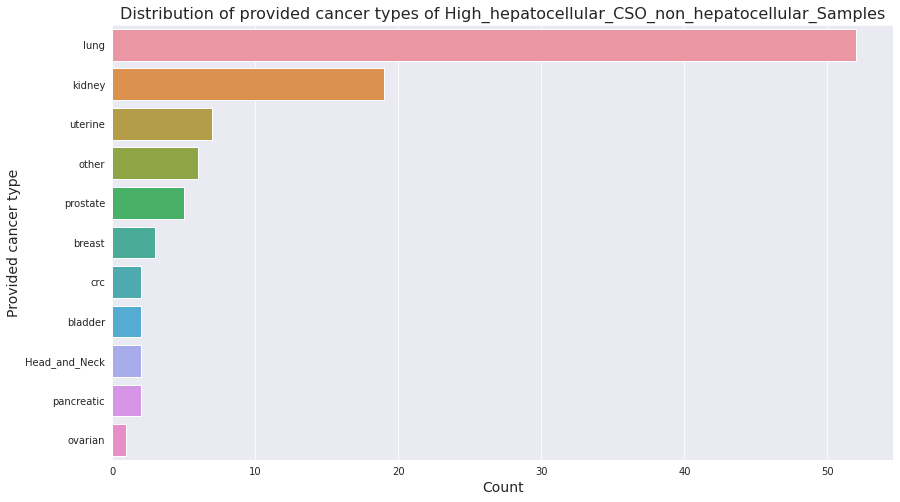

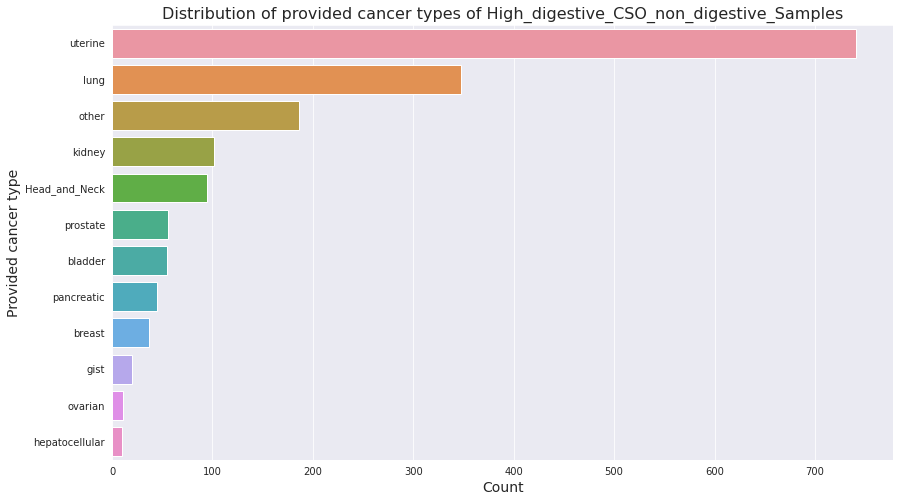

In [27]:
plt.figure(figsize=(14, 8))
sns.set_style('darkgrid')
sns.countplot(data=df_liver_cso, y='new_defined_cancer_type', order=df_liver_cso['new_defined_cancer_type'].value_counts().index)

# Set plot title and labels
plt.title('Distribution of provided cancer types of High_hepatocellular_CSO_non_hepatocellular_Samples', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Provided cancer type', fontsize=14)

plt.figure(figsize=(14, 8))
sns.set_style('darkgrid')
sns.countplot(data=df_digestive_cso, y='new_defined_cancer_type', order=df_digestive_cso['new_defined_cancer_type'].value_counts().index)

# Set plot title and labels
plt.title('Distribution of provided cancer types of High_digestive_CSO_non_digestive_Samples', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Provided cancer type', fontsize=14)

Text(0, 0.5, 'Batch')

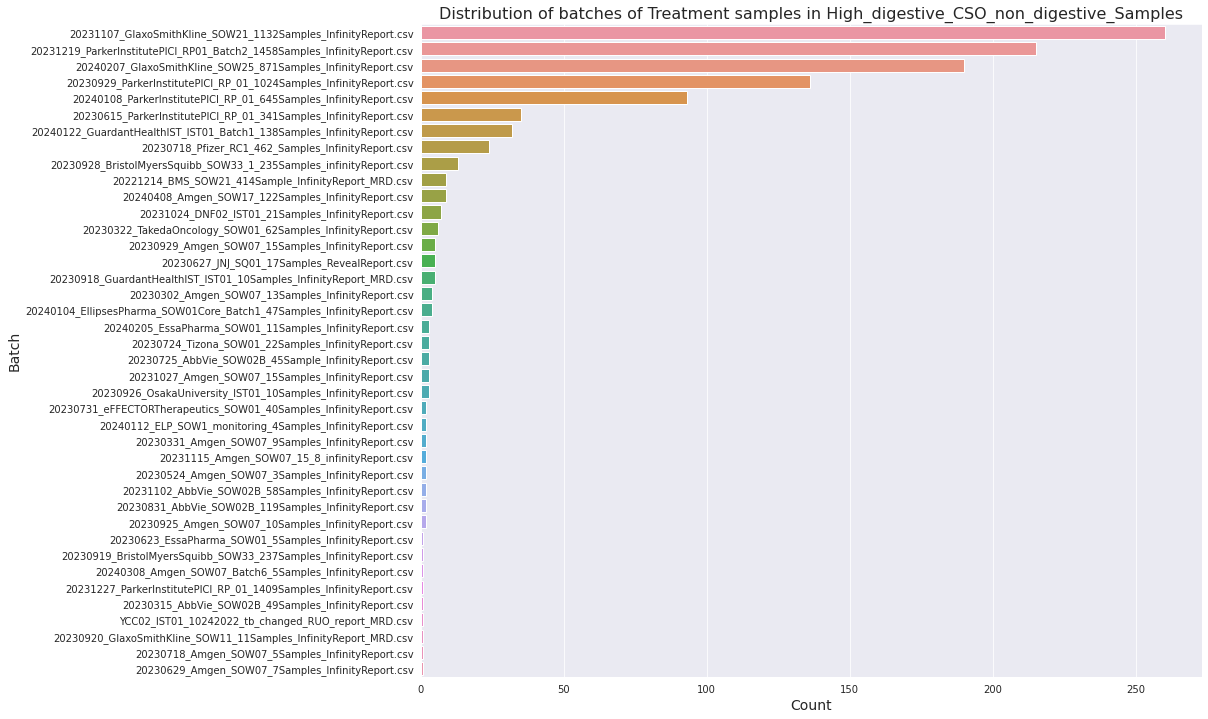

In [28]:
df_liver_cso_treatment = df_liver_cso[df_liver_cso["treatment"] == "Treatment"]
plt.figure(figsize=(14, 12))
sns.set_style('darkgrid')
sns.countplot(data=df_liver_cso_treatment, y='csv_file_name', order=df_liver_cso_treatment['csv_file_name'].value_counts().index)

# Set plot title and labels
plt.title('Distribution of batches of Treatment samples in High_hepatocellular_CSO_non_hepatocellular_Samples', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Batch', fontsize=14)

df_digestive_cso_treatment = df_digestive_cso[df_digestive_cso["treatment"] == "Treatment"]
plt.figure(figsize=(14, 12))
sns.set_style('darkgrid')
sns.countplot(data=df_digestive_cso_treatment, y='csv_file_name', order=df_digestive_cso_treatment['csv_file_name'].value_counts().index)

# Set plot title and labels
plt.title('Distribution of batches of Treatment samples in High_digestive_CSO_non_digestive_Samples', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Batch', fontsize=14)

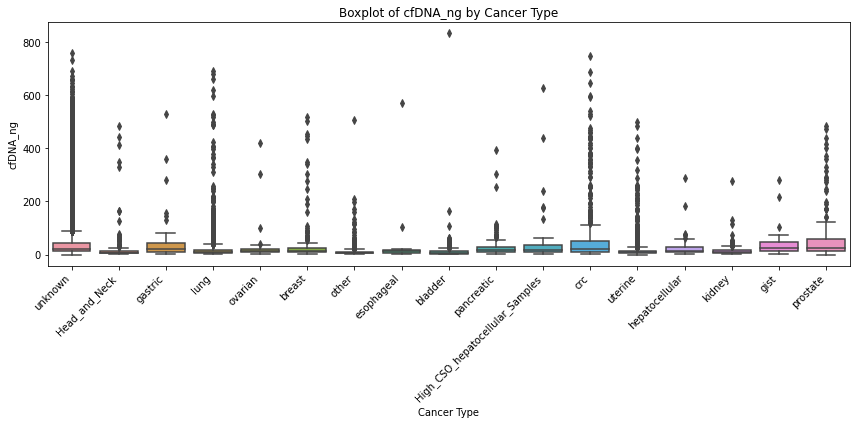

In [38]:
top_prd_df_1 = top_prd_df.copy()

# Extract the GHSampleIDs from df_liver_cso
# high_hepatocellular_samples = df_liver_cso['GHSampleID'].unique()
high_hepatocellular_samples = df_liver_cso_treatment['GHSampleID'].unique()

# Create a new column that will be True if the sample is in high_hepatocellular_samples
top_prd_df_1['is_high_CSO_hepatocellular_sample'] = top_prd_df_1['GHSampleID'].isin(high_hepatocellular_samples)

# Create a new column for plotting that combines original cancer types and the new category
top_prd_df_1['plot_cancer_type'] = top_prd_df_1.apply(
    lambda row: 'High_CSO_hepatocellular_Samples' if row['is_high_CSO_hepatocellular_sample'] else row['new_defined_cancer_type'],
    axis=1
)

# Remove missing values in cfDNA_ng before plotting
top_prd_df_1 = top_prd_df_1.dropna(subset=['cfDNA_ng'])

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=top_prd_df_1, x='plot_cancer_type', y='cfDNA_ng')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Cancer Type')
plt.ylabel('cfDNA_ng')
plt.title('Boxplot of cfDNA_ng by Cancer Type')
plt.tight_layout()
plt.show()


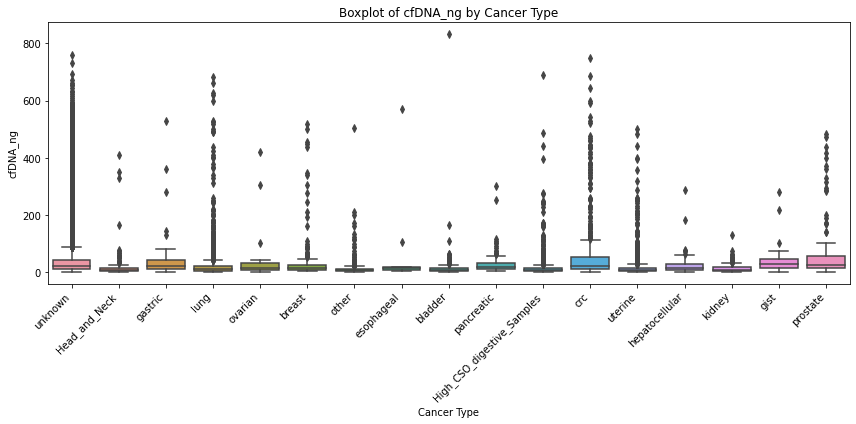

In [39]:
top_prd_df_1 = top_prd_df.copy()

# Extract the GHSampleIDs from df_digestive_cso
# high_digestive_samples = df_digestive_cso['GHSampleID'].unique()
high_digestive_samples = df_digestive_cso_treatment['GHSampleID'].unique()


# Create a new column that will be True if the sample is in high_digestive_samples
top_prd_df_1['is_high_CSO_digestive_sample'] = top_prd_df_1['GHSampleID'].isin(high_digestive_samples)

# Create a new column for plotting that combines original cancer types and the new category
top_prd_df_1['plot_cancer_type'] = top_prd_df_1.apply(
    lambda row: 'High_CSO_digestive_Samples' if row['is_high_CSO_digestive_sample'] else row['new_defined_cancer_type'],
    axis=1
)

# Remove missing values in cfDNA_ng before plotting
top_prd_df_1 = top_prd_df_1.dropna(subset=['cfDNA_ng'])

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=top_prd_df_1, x='plot_cancer_type', y='cfDNA_ng')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Cancer Type')
plt.ylabel('cfDNA_ng')
plt.title('Boxplot of cfDNA_ng by Cancer Type')
plt.tight_layout()
plt.show()


unknown: Median = 21.37200, SD = 89.73170, CI = (19.59012, 23.15388)
Head_and_Neck: Median = 7.33200, SD = 46.73349, CI = (0.73150, 13.93250)
gastric: Median = 20.80100, SD = 86.04395, CI = (-1.05007, 42.65207)
lung: Median = 9.98400, SD = 58.75152, CI = (7.34127, 12.62673)
ovarian: Median = 13.29900, SD = 75.16271, CI = (-9.55255, 36.15055)
breast: Median = 14.13750, SD = 83.88029, CI = (2.88801, 25.38699)
other: Median = 6.44800, SD = 30.68616, CI = (3.77052, 9.12548)
esophageal: Median = 14.53400, SD = 161.15219, CI = (-87.85722, 116.92522)
bladder: Median = 7.51400, SD = 53.22655, CI = (1.01384, 14.01416)
pancreatic: Median = 16.69500, SD = 39.68598, CI = (9.58171, 23.80829)
High_CSO_digestive_Samples: Median = 7.74900, SD = 41.40570, CI = (5.27220, 10.22580)
crc: Median = 21.63850, SD = 111.25065, CI = (12.46987, 30.80713)
uterine: Median = 8.37200, SD = 38.61734, CI = (6.48013, 10.26387)
hepatocellular: Median = 14.92000, SD = 32.76661, CI = (9.07134, 20.76866)
kidney: Median = 9

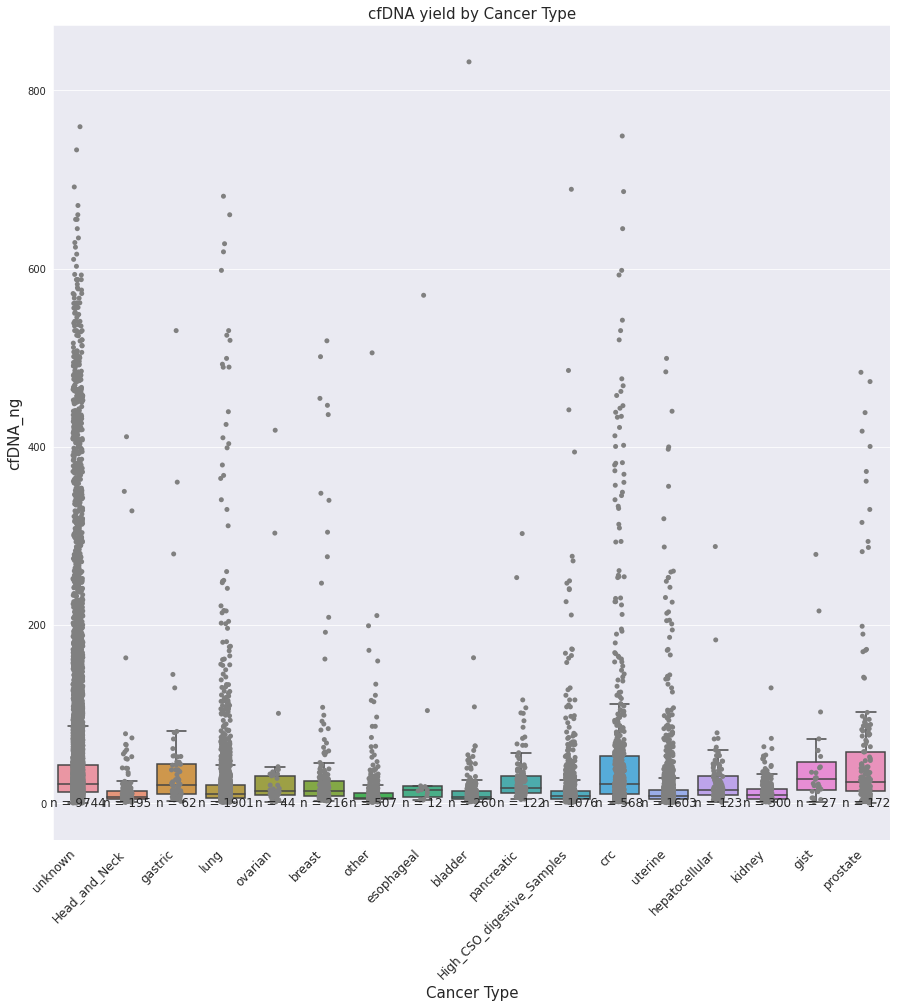

In [189]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statannotations.Annotator import Annotator

def boxplot_cancer_type_shedding_maf(df):
    
    fig, ax0 = plt.subplots(nrows=1, figsize=(15, 15))
    sns.set_style('darkgrid')

    # Define the order of the categories in the x-axis
    # order = df['new_defined_cancer_type'].dropna().unique().tolist()  # Ensure order contains only available categories
    order = df['plot_cancer_type'].unique().tolist()  # Ensure order contains only available categories


    # Setting y-axis to log scale
    # ax0.set_yscale("log")

    # Plotting the boxplot and stripplot with the specified order
    sns.boxplot(data=df, x="plot_cancer_type", y="cfDNA_ng", ax=ax0, order=order, showfliers=False)
    sns.stripplot(data=df, x="plot_cancer_type", y="cfDNA_ng", jitter=True, size=5, ax=ax0, order=order, color='gray')

    offset = 0.00001  # Adjust the position of sample size annotation

    # Annotate sample sizes
    for i, cancer_type in enumerate(order):
        subgroup = df[df['plot_cancer_type'] == cancer_type]
        n = subgroup.shape[0]
        # Log scale for positioning
        ax0.text(i, offset, f'n = {n}', ha='center', va='center', fontsize=12)
        
        # Calculate median, CI, and SD
        median = subgroup['cfDNA_ng'].median()
        sd = subgroup['cfDNA_ng'].std()
        ci_low, ci_upp = stats.t.interval(alpha=0.95, df=len(subgroup['cfDNA_ng'])-1, loc=median, scale=stats.sem(subgroup['cfDNA_ng']))
        print(f'{cancer_type}: Median = {median:.5f}, SD = {sd:.5f}, CI = ({ci_low:.5f}, {ci_upp:.5f})')
        
    # Create pairs for statistical annotation
    pairs = [(order[j], order[i]) for i in range(len(order)) for j in range(i+1, len(order))]

    # # Check if pairs are not empty
    # if pairs:
    #     # Creating an Annotator object and adding statistical annotation
    #     annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='plot_cancer_type', y='cfDNA_ng', order=order)
    #     annotator.configure(test='t-test_ind', text_format='star', loc='outside')
    #     annotator.apply_and_annotate()
    # else:
    #     print("Not enough categories for statistical annotation.")
    
    # Setting other plot properties
    plt.title('cfDNA yield by Cancer Type', fontsize=15)
    ax0.set_xlabel('Cancer Type', fontsize=15)
    ax0.set_ylabel('cfDNA_ng', fontsize=15)
    ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    
    plt.show()

# Call the function with the cleaned DataFrame
boxplot_cancer_type_shedding_maf(top_prd_df_1)


In [83]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# from scipy import stats
# from statannotations.Annotator import Annotator

# def boxplot_cancer_type_shedding_maf(df):
    
#     fig, ax0 = plt.subplots(nrows=1, figsize=(15, 15))
#     sns.set_style('darkgrid')

#     # Define the order of the categories in the x-axis
#     order = df['treatment'].dropna().unique().tolist()  # Ensure order contains only available categories

#     # Setting y-axis to log scale
#     # ax0.set_yscale("log")

#     # Plotting the boxplot and stripplot with the specified order
#     sns.boxplot(data=df, x="treatment", y="cfDNA_ng", ax=ax0, order=order, showfliers=False)
#     sns.stripplot(data=df, x="treatment", y="cfDNA_ng", jitter=True, size=5, ax=ax0, order=order, color='gray')

#     offset = 0.00000001  # Adjust the position of sample size annotation

#     # Annotate sample sizes
#     for i, cancer_type in enumerate(order):
#         subgroup = df[df['treatment'] == cancer_type]
#         n = subgroup.shape[0] // 2
#         # Log scale for positioning
#         ax0.text(i, offset, f'n = {n}', ha='center', va='center', fontsize=12)
        
#         # Calculate median, CI, and SD
#         median = subgroup['cfDNA_ng'].median()
#         sd = subgroup['cfDNA_ng'].std()
#         ci_low, ci_upp = stats.t.interval(alpha=0.95, df=len(subgroup['cfDNA_ng'])-1, loc=median, scale=stats.sem(subgroup['cfDNA_ng']))
#         print(f'{cancer_type}: Median = {median:.5f}, SD = {sd:.5f}, CI = ({ci_low:.5f}, {ci_upp:.5f})')
        
#     # Create pairs for statistical annotation
#     pairs = [(order[j], order[i]) for i in range(len(order)) for j in range(i+1, len(order))]

#     # Check if pairs are not empty
#     if pairs:
#         # Creating an Annotator object and adding statistical annotation
#         annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='treatment', y='cfDNA_ng', order=order)
#         annotator.configure(test='t-test_ind', text_format='star', loc='outside')
#         annotator.apply_and_annotate()
#     else:
#         print("Not enough categories for statistical annotation.")
    
#     # Setting other plot properties
#     plt.title('cfDNA yield in High hepatocellular CSO non-hepatocellular samples', fontsize=15)
#     ax0.set_xlabel('Treatment', fontsize=15)
#     ax0.set_ylabel('cfDNA_ng', fontsize=15)
#     ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    
#     plt.show()

# # Call the function with the cleaned DataFrame
# boxplot_cancer_type_shedding_maf(df_liver_cso)


In [40]:
df_ParkerInstitutePICI_treatment = df_liver_cso_treatment[df_liver_cso_treatment["csv_file_name"].str.contains("Parker", na=False)]
df_ParkerInstitutePICI_treatment.shape

(35, 56)

In [41]:
df_ParkerInstitutePICI_treatment.csv_file_name.value_counts()

20231219_ParkerInstitutePICI_RP01_Batch2_1458Samples_InfinityReport.csv    19
20240108_ParkerInstitutePICI_RP_01_645Samples_InfinityReport.csv            9
20230929_ParkerInstitutePICI_RP_01_1024Samples_InfinityReport.csv           6
20230615_ParkerInstitutePICI_RP_01_341Samples_InfinityReport.csv            1
Name: csv_file_name, dtype: int64

In [42]:
df_ParkerInstitutePICI_treatment.to_csv(f"{work_dir}/df_ParkerInstitutePICI_treatment.csv", index=False)

In [268]:
top_2_prd_df.Account.isnull().sum()

3122

## Rerun MB caller

In [106]:
import epicaller
import epicaller.methylation.methyl_caller

def run_mb_lung_v4_caller_wrapper_slurm(sample_meta_df, mr_model_file, workdir):
    region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_classification_space.tsv'
    control_region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_positive_control_regions.tsv'
    lr_model_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/msre_lr_model.tsv'

    jobs_dir = f"{workdir}/MB_lung_v4_all_jobs"
    output_dir = f"{workdir}/MB_lung_v4_all_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["GHSampleID"]
        fc_dir = row["fc_dir"]
        flowcell_id = row["runid"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        mbd_residual_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_residual_molecules.tsv"
        
        # Check if the molecule file exists
        if not os.path.exists(mbd_hyper_molecules):
            continue

        job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=30gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:10:00\n"
                           f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write("python3 -m epicaller.methylation.methyl_caller " + 
                             f"--hyper-molecule-file {mbd_hyper_molecules} " + 
                             f"--residual-molecule-file {mbd_residual_molecules} " + 
                             f"--region-file {region_file} " +
                             f"--control-region-file {control_region_file} " + 
                             f"--lr-model-file {lr_model_file} " + 
                             f"--mr-model-file {mr_model_file} " +
                             "--min-frag-len 120 --max-frag-len 240 --min-cg-count 12 --max-cg-count 30 --cutsite-count-cutoff 1 --min-mapq 60 " + 
                             f"--sample-id {run_sample_id} --flowcell-id {flowcell_id} --outdir {output_dir}/")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [107]:
#run the function to generate all the MB Lung v4 caller ouputs for BMS_SOW33_Infinity_01 batch 
run_mb_lung_v4_caller_wrapper_slurm(df_complete_MB_rerun, 
                      "/home/byounggreenwald/LungPan_v4_Caller.model_file.98_spec.tsv", 
                      f"{work_dir}")

Submitted batch job 77659226
Submitted batch job 77659227
Submitted batch job 77659228
Submitted batch job 77659229
Submitted batch job 77659230
Submitted batch job 77659231
Submitted batch job 77659232
Submitted batch job 77659233
Submitted batch job 77659234
Submitted batch job 77659235
Submitted batch job 77659236
Submitted batch job 77659237
Submitted batch job 77659238
Submitted batch job 77659239
Submitted batch job 77659240
Submitted batch job 77659241
Submitted batch job 77659242
Submitted batch job 77659243
Submitted batch job 77659244
Submitted batch job 77659245
Submitted batch job 77659246
Submitted batch job 77659247
Submitted batch job 77659248
Submitted batch job 77659249
Submitted batch job 77659250
Submitted batch job 77659251
Submitted batch job 77659252
Submitted batch job 77659253
Submitted batch job 77659254
Submitted batch job 77659255
Submitted batch job 77659256
Submitted batch job 77659258
Submitted batch job 77659259
Submitted batch job 77659260
Submitted batc

In [18]:
df_complete_MB_rerun.head()

GHRequestID GHSampleID Patient_ID                Visit_name Sample_status  \
22    A0941021  B00602822  71-12-001  C2 D1 PREDOSE EXP AMD4&5       SUCCESS   
23    A0941022  B00602820  71-12-001    C1 D1 PREDOSE EXP AMD3       SUCCESS   
24    A0941023  B00602819  71-12-003  C2 D1 PREDOSE EXP AMD4&5       SUCCESS   
25    A0941024  B00602818  71-12-003  C1 D1 PREDOSE EXP AMD4&5       SUCCESS   
26    A0941550  B00586925   11761011          End of Treatment       SUCCESS   

   Sample_comment  cfDNA_ng  Plasma_ml_input Cancertype  \
22            NaN     13.10              2.5        NaN   
23            NaN      4.81              2.5        NaN   
24            NaN     14.14              3.0        NaN   
25            NaN     12.74              2.5        NaN   
26            NaN    339.04              4.0        NaN   

                                                             csv_file_name  \
22       20240227_Merus_SOW02Amendment1_Batch1_4Samples_InfinityReport.csv   
23       20240227_Merus_SOW02Amendment1_Batch1_4Samples_InfinityReport.csv   
24       20240227_Merus_SOW02Amendment1_Batch1_4Samples_InfinityReport.csv   
25       20240227_Merus_SOW02Amendment1_Batch1_4Samples_InfinityReport.csv   
26  20240503_Pfizer_SOW46Amendment1TP5_Batch2_37Samples_InfinityReport.csv   

   Account SOW_num cancer_category cancerother cancerstage cancertype  \
22   Merus      02           Other         NaN         NaN        NaN   
23   Merus      02           Other         NaN         NaN        NaN   
24   Merus      02           Other         NaN         NaN        NaN   
25   Merus      02           Other         NaN         NaN        NaN   
26  Pfizer      46           Other         NaN         NaN        NaN   

   run_sample_id sample_index   gender sample_type             timestamp  \
22     B00602822   CTGCAAACCG  Unknown    Research  2024-02-23T14:52:08Z   
23     B00602820   ATGGTGATAA  Unknown    Research  2024-02-23T14:52:08Z   
24     B00602819   CAGAGGGAAC  Unknown    Research  2024-02-23T14:52:08Z   
25     B00602818   ACATGGCCGG  Unknown    Research  2024-02-23T14:52:08Z   
26     B00586925   ACTGTGGCCT  Unknown    Research  2024-01-28T01:43:57Z   

          panel  control_lot       bip_version  git_version  run_mode  \
22  Sirius_v1.0          NaN  Sirius-1.1.2-RLS          NaN       NaN   
23  Sirius_v1.0          NaN  Sirius-1.1.2-RLS          NaN       NaN   
24  Sirius_v1.0          NaN  Sirius-1.1.2-RLS          NaN       NaN   
25  Sirius_v1.0          NaN  Sirius-1.1.2-RLS          NaN       NaN   
26  Sirius_v1.0          NaN  Sirius-1.1.2-RLS          NaN       NaN   

         product              project cancer_type  patient_age  \
22  Guardant 360           MRS_02_Am1         NaN          NaN   
23  Guardant 360           MRS_02_Am1         NaN          NaN   
24  Guardant 360           MRS_02_Am1         NaN          NaN   
25  Guardant 360           MRS_02_Am1         NaN          NaN   
26  Guardant 360  PFE_46_Infinity_TP5         NaN          NaN   

           parameter_set  lunar_caller  comment provided_tumor_type  \
22  Sirius_LDT_Soft_v2.0           NaN      NaN                 NaN   
23  Sirius_LDT_Soft_v2.0           NaN      NaN                 NaN   
24  Sirius_LDT_Soft_v2.0           NaN      NaN                 NaN   
25  Sirius_LDT_Soft_v2.0           NaN      NaN                 NaN   
26  Sirius_LDT_Soft_v2.0           NaN      NaN                 NaN   

   request_id use_case qc_status  sample_id  \
22   A0941021      cgp      PASS  B00602822   
23   A0941022      cgp      PASS  B00602820   
24   A0941023      cgp      PASS  B00602819   
25   A0941024      cgp      PASS  B00602818   
26   A0941550      cgp      PASS  B00586925   

                                                                                                  sample_path  \
22  /ghsfa/projects/omni_v2/flowcells/240221_A01020_0744_BHTLNVDSX7_PS3C503LDT_AP3.Sirius-1.1.2-RLS/B00602822   
23  /ghsfa/projects/omni_v2/fl